# Proyecto de Aprendizaje Profundo por Refuerzo

En este proyecto entrenamos a un agente para que pueda aprender a jugar a un juego de Football.

Para correr estre proyecto se necesita instalar torchviz:

```
pip install torchviz
```

Además tienen que estar en el mismo directorio los archivos dqn_agent.py y dqn_algorithm.py.

In [2]:
from collections import deque

import gfootball.env as football_env
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import random

env = football_env.create_environment(
    env_name='academy_empty_goal_close', 
    stacked=False,                           # solo estado, no pixeles 
    representation='simple115',              # solo estado, no pixeles 
    with_checkpoints=True,                   # recompensas intermedias, no solo al marcar 
    render=False)                            # mostrar graficamente

## Football Environment

Cada estado es una tupla de 115 elementos. 

| Información         | Estructura           | Explicación
| --------------------|----------------------| ----------------------
| Posición del balón  | (x, y, z)            | 
| Dirección del balón | (x, y, z)            | 
| Control del balón   | array(3)             | (1, 0, 0): nadie, (0, 1, 0): locales, (0, 0, 1): visitantes 
| Jugador activo      | array(11)            | codificación de jugador activo en locales
| Posiciones locales  | 11 x array(2)        | 11 posiciones (x, y) de cada jugador local
| Movimiento locales  | 11 x array(2)        | 11 vectores de movimiento (x, y) de cada jugador local
| Posiciones visitantes  | 11 x array(2)     | 11 posiciones (x, y) de cada jugador visitante
| Movimiento visitantes  | 11 x array(2)     | 11 vectores de movimiento (x, y) de cada jugador visitante
| Modo de juego       | array(7)             | codificación de modo de juego: {NormalMode, KickOffMode, GoalKickMode, FreeKickMode, CornerMode, ThrowInMode, PenaltyMode}

En la modalidad `academy_empty_goal_close` solo hay **51 elementos activos**.

Además. El agente puede realizar 21 acciones:

In [3]:
from gfootball.env import football_action_set
print(env.action_space)
football_action_set.action_set_dict['default']

Discrete(21)


[idle,
 left,
 top_left,
 top,
 top_right,
 right,
 bottom_right,
 bottom,
 bottom_left,
 long_pass,
 high_pass,
 short_pass,
 shot,
 sprint,
 release_direction,
 release_sprint,
 keeper_rush,
 release_keeper_rush,
 sliding,
 dribble,
 release_dribble]

## Deep Q-Learning

Para este modelo entrenaremos agentes empleando _Deep Q-Learning_. La idea de este algoritmo es aproximar la función $Q^{*}$ con una aproximación $Q_{\theta}$ empleando una DNNs.

Primero importamos una implementación de un agente y el algoritmo de entrenamiento:

In [4]:
from dqn_agent import Agent
from dqn_algorithm import dqn
from torchviz import make_dot

Luego de esto, vamos a definir unas cuantas redes para probar:


In [5]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

class BasicNet(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(BasicNet, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
    
class SmallerNet(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=46, fc2_units=46):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(SmallerNet, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = torch.tanh(self.fc1(state))
        x = torch.tanh(self.fc2(x))
        return self.fc3(x)

    
class BiggerNet(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=96, fc2_units=96, fc3_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(BiggerNet, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)


### Red Básica

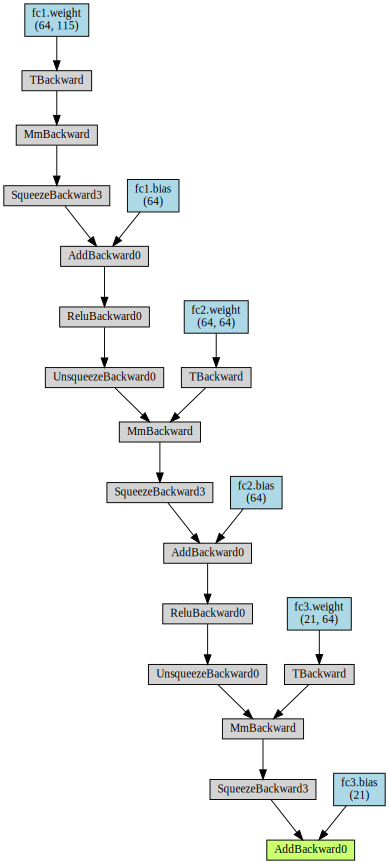

In [6]:
basic_agent_adam = Agent(state_size=115, action_size=21, seed=0, network=BasicNet, optim_fn='adam')

# Visualize the network
samp = torch.zeros(basic_agent_adam.state_size)
out = basic_agent_adam.qnetwork_local(samp)
make_dot(out, params=dict(basic_agent_adam.qnetwork_local.named_parameters()))

Entrenamos la red en 1000 episodios:

I0816 14:40:33.581884 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:33.585010 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 18.0, gameFPS: 587.2


Episodio 1	Puntuacion media (ultimos 50):0.20

I0816 14:40:33.803858 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:40:33.805048 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:33.807461 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 73.6, gameFPS: 364.6


Episodio 2	Puntuacion media (ultimos 50):1.10

I0816 14:40:34.355897 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:34.356928 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 134.8, gameFPS: 491.1


Episodio 3	Puntuacion media (ultimos 50):0.80

I0816 14:40:34.989691 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:34.990850 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 107.8, gameFPS: 409.1


Episodio 4	Puntuacion media (ultimos 50):0.85

I0816 14:40:35.305912 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:35.306856 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 27, FPS: 87.2, gameFPS: 316.2


Episodio 5	Puntuacion media (ultimos 50):0.86

I0816 14:40:35.886915 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:35.887803 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 115.4, gameFPS: 339.9


Episodio 6	Puntuacion media (ultimos 50):0.87

I0816 14:40:36.370572 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:36.371382 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 113.6, gameFPS: 410.2


Episodio 7	Puntuacion media (ultimos 50):0.87

I0816 14:40:36.923958 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:36.924751 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 134.2, gameFPS: 525.7


Episodio 8	Puntuacion media (ultimos 50):0.88

I0816 14:40:37.217094 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:37.219019 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 22, FPS: 79.6, gameFPS: 281.8


Episodio 9	Puntuacion media (ultimos 50):0.88

I0816 14:40:37.869945 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:37.870902 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 125.0, gameFPS: 413.4


Episodio 10	Puntuacion media (ultimos 50):0.88

I0816 14:40:38.306020 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:38.306858 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 119.6, gameFPS: 426.8
I0816 14:40:38.486158 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:40:38.487037 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:38.488054 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 57.7, gameFPS: 296.6


Episodio 12	Puntuacion media (ultimos 50):0.98

I0816 14:40:38.711900 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:40:38.713755 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:38.714666 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 82.0, gameFPS: 369.5
I0816 14:40:38.915138 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:40:38.916114 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:38.916677 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 86.8, gameFPS: 362.7


Episodio 14	Puntuacion media (ultimos 50):1.12

I0816 14:40:39.501236 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:39.502154 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 125.2, gameFPS: 466.3
I0816 14:40:39.784647 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:40:39.785688 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:39.786396 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 26, FPS: 96.2, gameFPS: 501.6


Episodio 16	Puntuacion media (ultimos 50):1.16

I0816 14:40:40.398181 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:40.399409 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 120.5, gameFPS: 450.0


Episodio 17	Puntuacion media (ultimos 50):1.15

I0816 14:40:40.865953 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:40.867055 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 108.4, gameFPS: 364.9


Episodio 18	Puntuacion media (ultimos 50):1.13

I0816 14:40:41.511979 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:41.512965 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 122.5, gameFPS: 462.6
I0816 14:40:41.753635 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:40:41.754662 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:41.755254 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 22, FPS: 95.0, gameFPS: 370.5


Episodio 20	Puntuacion media (ultimos 50):1.17

I0816 14:40:42.406608 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:42.407709 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 107.0, gameFPS: 396.9
I0816 14:40:42.634804 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:40:42.635997 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:42.636669 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 47.0, gameFPS: 325.3


Episodio 22	Puntuacion media (ultimos 50):1.16

I0816 14:40:43.447691 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:43.454041 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 84.8, gameFPS: 307.9


Episodio 23	Puntuacion media (ultimos 50):1.15

I0816 14:40:44.250292 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:44.255192 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 93.8, gameFPS: 357.8


Episodio 24	Puntuacion media (ultimos 50):1.14

I0816 14:40:45.184723 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:45.185542 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 80.3, gameFPS: 313.8


Episodio 25	Puntuacion media (ultimos 50):1.13

I0816 14:40:46.502660 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:46.503470 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 97, FPS: 74.2, gameFPS: 293.1


Episodio 27	Puntuacion media (ultimos 50):1.09

I0816 14:40:47.861687 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:40:47.863398 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:47.867572 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 42.9, gameFPS: 192.3


Episodio 28	Puntuacion media (ultimos 50):1.12

I0816 14:40:48.343541 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:48.344620 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 115.5, gameFPS: 470.6


Episodio 29	Puntuacion media (ultimos 50):1.11

I0816 14:40:49.032021 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 14:40:49.034092 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:49.034824 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 97, FPS: 142.8, gameFPS: 537.6


Episodio 30	Puntuacion media (ultimos 50):1.05

I0816 14:40:49.413656 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:49.414553 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 49, FPS: 132.2, gameFPS: 537.6


Episodio 32	Puntuacion media (ultimos 50):1.04

I0816 14:40:50.974523 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:50.975670 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 59, FPS: 91.3, gameFPS: 301.2


Episodio 33	Puntuacion media (ultimos 50):1.04

I0816 14:40:51.528736 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:51.529729 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 124.9, gameFPS: 447.3


Episodio 34	Puntuacion media (ultimos 50):1.03

I0816 14:40:51.992604 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:51.993572 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 118.7, gameFPS: 407.4
I0816 14:40:52.226620 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:40:52.229898 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:52.234158 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 74.6, gameFPS: 314.5


Episodio 36	Puntuacion media (ultimos 50):1.06

I0816 14:40:52.564940 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:40:52.566283 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:52.567155 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 31.7, gameFPS: 177.0
I0816 14:40:52.726987 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:40:52.727930 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:52.731682 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 74.8, gameFPS: 680.9


Episodio 38	Puntuacion media (ultimos 50):1.11

I0816 14:40:53.326135 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:53.327085 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 133.1, gameFPS: 523.2


Episodio 41	Puntuacion media (ultimos 50):1.09

I0816 14:40:55.396753 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:55.397896 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 128.1, gameFPS: 486.1


Episodio 44	Puntuacion media (ultimos 50):1.06

I0816 14:40:57.514368 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:57.515377 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 130.8, gameFPS: 468.2
I0816 14:40:57.697276 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:40:57.698387 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:57.699509 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.0, gameFPS: 292.0


Episodio 47	Puntuacion media (ultimos 50):1.08

I0816 14:40:58.961819 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:58.962992 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 140.1, gameFPS: 534.5


Episodio 48	Puntuacion media (ultimos 50):1.06

I0816 14:40:59.606874 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:40:59.607850 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 117.2, gameFPS: 443.4


Episodio 49	Puntuacion media (ultimos 50):1.04

I0816 14:41:00.146713 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:00.147704 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 130.1, gameFPS: 495.7
I0816 14:41:00.286712 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:00.287828 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:00.289130 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 76.0, gameFPS: 645.9


Episodio 50	Puntuacion media (50 anteriores): 1.02
Episodio 51	Puntuacion media (ultimos 50):1.06

I0816 14:41:00.722374 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:00.723319 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 122.0, gameFPS: 451.0


Episodio 52	Puntuacion media (ultimos 50):1.04

I0816 14:41:01.165801 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:01.166774 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 119.7, gameFPS: 414.5


Episodio 53	Puntuacion media (ultimos 50):1.05

I0816 14:41:01.646747 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:01.647788 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 60, FPS: 127.2, gameFPS: 506.1
I0816 14:41:01.841325 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:01.842448 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:01.843087 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 96.6, gameFPS: 449.0


Episodio 55	Puntuacion media (ultimos 50):1.07

I0816 14:41:02.643223 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:02.645811 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:02.647042 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 75.1, gameFPS: 357.3


Episodio 57	Puntuacion media (ultimos 50):1.09

I0816 14:41:02.806643 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:02.807710 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:02.808286 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 65.6, gameFPS: 297.4


Episodio 58	Puntuacion media (ultimos 50):1.12

I0816 14:41:03.409064 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:03.410049 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 134.1, gameFPS: 514.8


Episodio 59	Puntuacion media (ultimos 50):1.12

I0816 14:41:03.661685 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:03.662577 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:03.663207 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 96.3, gameFPS: 401.5


Episodio 61	Puntuacion media (ultimos 50):1.14

I0816 14:41:05.168669 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:05.172073 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 94, FPS: 127.3, gameFPS: 420.9
I0816 14:41:05.436819 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:05.437917 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:05.438520 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 95.1, gameFPS: 350.6


Episodio 62	Puntuacion media (ultimos 50):1.12

I0816 14:41:05.635042 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:05.635965 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 12, FPS: 65.0, gameFPS: 221.5


Episodio 64	Puntuacion media (ultimos 50):1.09

I0816 14:41:06.200088 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:06.201040 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 123.8, gameFPS: 426.7


Episodio 65	Puntuacion media (ultimos 50):1.09

I0816 14:41:06.748058 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:06.749020 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 128.5, gameFPS: 479.7


Episodio 66	Puntuacion media (ultimos 50):1.06

I0816 14:41:07.385674 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:07.394192 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 127.0, gameFPS: 433.4


Episodio 68	Puntuacion media (ultimos 50):1.06

I0816 14:41:08.714344 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:08.715512 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 132.8, gameFPS: 527.0


Episodio 69	Puntuacion media (ultimos 50):1.06

I0816 14:41:09.348516 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:09.349459 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 134.7, gameFPS: 511.8


Episodio 72	Puntuacion media (ultimos 50):1.03

I0816 14:41:11.425110 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:11.426294 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 125.8, gameFPS: 470.6


Episodio 73	Puntuacion media (ultimos 50):1.02

I0816 14:41:11.893947 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:11.895022 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 119.2, gameFPS: 418.4


Episodio 75	Puntuacion media (ultimos 50):1.02

I0816 14:41:13.163331 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:13.164275 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 129.3, gameFPS: 481.0


Episodio 76	Puntuacion media (ultimos 50):1.03

I0816 14:41:13.448661 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:13.449954 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:13.450626 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 30, FPS: 108.1, gameFPS: 495.4
I0816 14:41:13.694425 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:13.695665 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:13.697634 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 29, FPS: 122.4, gameFPS: 707.7


Episodio 80	Puntuacion media (ultimos 50):1.09

I0816 14:41:15.718225 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:15.719188 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 129.7, gameFPS: 477.9


Episodio 81	Puntuacion media (ultimos 50):1.09

I0816 14:41:16.269259 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:16.270247 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 62, FPS: 114.4, gameFPS: 351.9


Episodio 82	Puntuacion media (ultimos 50):1.09

I0816 14:41:16.959617 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:16.960650 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 122.2, gameFPS: 374.6


Episodio 83	Puntuacion media (ultimos 50):1.07

I0816 14:41:17.611629 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:17.612703 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 125.8, gameFPS: 413.4
I0816 14:41:17.818137 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:17.819425 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:17.820097 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 87.4, gameFPS: 375.7


Episodio 85	Puntuacion media (ultimos 50):1.09

I0816 14:41:18.401829 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:18.402850 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 132.4, gameFPS: 496.0


Episodio 86	Puntuacion media (ultimos 50):1.07

I0816 14:41:18.928231 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:18.929095 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 141.5, gameFPS: 541.2
I0816 14:41:19.119759 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:19.120776 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:19.121457 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 85.8, gameFPS: 391.0


Episodio 88	Puntuacion media (ultimos 50):1.04

I0816 14:41:20.026286 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:20.027354 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:20.027968 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 102.0, gameFPS: 462.6


Episodio 90	Puntuacion media (ultimos 50):1.06

I0816 14:41:20.466627 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:20.467594 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 49, FPS: 113.6, gameFPS: 385.0


Episodio 91	Puntuacion media (ultimos 50):1.06

I0816 14:41:21.084214 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:21.085216 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 113.6, gameFPS: 346.9
I0816 14:41:21.255707 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:21.256739 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:21.257441 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 67.0, gameFPS: 279.6


Episodio 93	Puntuacion media (ultimos 50):1.09

I0816 14:41:21.524674 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:21.525535 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 23, FPS: 89.1, gameFPS: 308.4
I0816 14:41:21.681633 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:21.682782 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:21.683705 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 73.3, gameFPS: 333.5


Episodio 96	Puntuacion media (ultimos 50):1.10

I0816 14:41:22.922539 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:22.923438 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 141.8, gameFPS: 543.6
I0816 14:41:23.107042 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:23.108096 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:23.108724 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 79.7, gameFPS: 348.0


Episodio 99	Puntuacion media (ultimos 50):1.14

I0816 14:41:24.289554 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:24.290391 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 113.9, gameFPS: 369.9


Episodio 100	Puntuacion media (50 anteriores): 1.15


I0816 14:41:24.941642 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:24.942615 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 129.4, gameFPS: 465.4


Episodio 101	Puntuacion media (ultimos 50):1.13

I0816 14:41:25.393204 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:25.394281 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 119.2, gameFPS: 370.5


Episodio 102	Puntuacion media (ultimos 50):1.13

I0816 14:41:26.057291 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:26.058217 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 140.9, gameFPS: 500.7


Episodio 103	Puntuacion media (ultimos 50):1.13

I0816 14:41:26.712312 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:26.713458 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 133.3, gameFPS: 512.0


Episodio 104	Puntuacion media (ultimos 50):1.13

I0816 14:41:27.326589 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:27.327697 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 125.9, gameFPS: 435.8


Episodio 105	Puntuacion media (ultimos 50):1.11

I0816 14:41:27.932023 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:27.932983 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 131.6, gameFPS: 492.0
I0816 14:41:28.135903 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:28.137362 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:28.138036 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 86.1, gameFPS: 380.7


Episodio 107	Puntuacion media (ultimos 50):1.11

I0816 14:41:28.640120 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:28.641003 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 139.6, gameFPS: 557.5


Episodio 108	Puntuacion media (ultimos 50):1.08

I0816 14:41:29.543373 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:29.544475 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:29.545102 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 68.5, gameFPS: 288.4


Episodio 110	Puntuacion media (ultimos 50):1.08

I0816 14:41:30.157485 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:30.158485 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 138.0, gameFPS: 480.7


Episodio 112	Puntuacion media (ultimos 50):1.08

I0816 14:41:31.450268 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:31.451269 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 127.9, gameFPS: 526.0


Episodio 113	Puntuacion media (ultimos 50):1.04

I0816 14:41:31.738513 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:31.739506 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 28, FPS: 103.6, gameFPS: 386.7


Episodio 114	Puntuacion media (ultimos 50):1.04

I0816 14:41:32.098533 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:32.099289 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 35, FPS: 100.0, gameFPS: 361.0


Episodio 115	Puntuacion media (ultimos 50):1.04

I0816 14:41:32.703961 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:32.704853 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 145.4, gameFPS: 553.5


Episodio 116	Puntuacion media (ultimos 50):1.06

I0816 14:41:33.256987 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:33.258270 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 59, FPS: 110.1, gameFPS: 328.5
I0816 14:41:33.412177 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:33.413263 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:33.413882 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 74.0, gameFPS: 348.8


Episodio 118	Puntuacion media (ultimos 50):1.08

I0816 14:41:34.030877 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:34.031772 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 139.6, gameFPS: 508.5
I0816 14:41:34.237701 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:34.238887 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:34.239554 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 96.0, gameFPS: 455.1


Episodio 121	Puntuacion media (ultimos 50):1.08

I0816 14:41:35.601751 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:35.602762 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 133.0, gameFPS: 518.0


Episodio 122	Puntuacion media (ultimos 50):1.08

I0816 14:41:35.830738 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:35.832325 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:35.832969 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 91.4, gameFPS: 383.9


Episodio 123	Puntuacion media (ultimos 50):1.12

I0816 14:41:36.390127 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:36.391249 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 128.1, gameFPS: 493.1


Episodio 124	Puntuacion media (ultimos 50):1.10

I0816 14:41:36.882105 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:36.883026 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 61, FPS: 125.8, gameFPS: 410.3


Episodio 126	Puntuacion media (ultimos 50):1.10

I0816 14:41:38.232534 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:38.233445 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 129.4, gameFPS: 482.7


Episodio 127	Puntuacion media (ultimos 50):1.08

I0816 14:41:38.794967 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:38.796110 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 124.4, gameFPS: 444.4
I0816 14:41:38.971630 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:38.972922 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:38.973581 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.2, gameFPS: 302.7


Episodio 129	Puntuacion media (ultimos 50):1.08

I0816 14:41:39.475528 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:39.476531 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 141.8, gameFPS: 591.4


Episodio 130	Puntuacion media (ultimos 50):1.08

I0816 14:41:40.020542 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:40.021338 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 138.3, gameFPS: 536.8
I0816 14:41:40.279264 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:40.280589 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:40.281298 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 95.7, gameFPS: 392.0


Episodio 132	Puntuacion media (ultimos 50):1.10

I0816 14:41:40.823831 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:40.825029 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 59, FPS: 110.8, gameFPS: 339.4


Episodio 133	Puntuacion media (ultimos 50):1.12

I0816 14:41:41.316911 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:41.318100 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 60, FPS: 123.9, gameFPS: 479.7


Episodio 134	Puntuacion media (ultimos 50):1.12

I0816 14:41:41.880943 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:41.881927 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 130.4, gameFPS: 508.6


Episodio 135	Puntuacion media (ultimos 50):1.10

I0816 14:41:42.396267 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:42.397225 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 57, FPS: 112.8, gameFPS: 372.5
I0816 14:41:42.555836 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:42.556996 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:42.557593 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 64.8, gameFPS: 295.9


Episodio 137	Puntuacion media (ultimos 50):1.14

I0816 14:41:43.045422 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:43.046593 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 112.4, gameFPS: 353.3


Episodio 138	Puntuacion media (ultimos 50):1.12

I0816 14:41:43.742353 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:43.743324 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 99, FPS: 143.5, gameFPS: 530.9


Episodio 139	Puntuacion media (ultimos 50):1.12

I0816 14:41:44.623171 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:44.624384 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:44.626099 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 78.9, gameFPS: 590.9


Episodio 141	Puntuacion media (ultimos 50):1.12

I0816 14:41:45.190162 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:45.191164 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 141.2, gameFPS: 547.5


Episodio 142	Puntuacion media (ultimos 50):1.12

I0816 14:41:45.477542 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:45.478542 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 28, FPS: 102.2, gameFPS: 361.4


Episodio 145	Puntuacion media (ultimos 50):1.06

I0816 14:41:47.598266 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:47.599248 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 120.3, gameFPS: 395.1


Episodio 146	Puntuacion media (ultimos 50):1.06

I0816 14:41:48.190967 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:48.191992 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 144.9, gameFPS: 599.0


Episodio 147	Puntuacion media (ultimos 50):1.07

I0816 14:41:48.728983 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:48.729943 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 139.3, gameFPS: 576.0


Episodio 148	Puntuacion media (ultimos 50):1.05

I0816 14:41:49.637598 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:49.638747 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:49.639272 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 71.0, gameFPS: 625.1


Episodio 150	Puntuacion media (50 anteriores): 1.07


I0816 14:41:49.806435 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:49.807721 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:49.808369 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 62.7, gameFPS: 279.5


Episodio 151	Puntuacion media (ultimos 50):1.09

I0816 14:41:50.498464 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 14:41:50.499561 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:50.500248 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 98, FPS: 143.4, gameFPS: 546.3
I0816 14:41:50.700189 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:50.701268 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:50.702354 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 93.0, gameFPS: 400.2


Episodio 154	Puntuacion media (ultimos 50):1.09

I0816 14:41:51.893136 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:51.894180 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 127.5, gameFPS: 427.8


Episodio 155	Puntuacion media (ultimos 50):1.09

I0816 14:41:52.535782 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:52.536552 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 132.3, gameFPS: 470.5


Episodio 156	Puntuacion media (ultimos 50):1.09

I0816 14:41:53.170651 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:53.171512 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 139.2, gameFPS: 546.1


Episodio 157	Puntuacion media (ultimos 50):1.07

I0816 14:41:53.706642 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:53.707554 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 140.6, gameFPS: 592.2


Episodio 158	Puntuacion media (ultimos 50):1.08

I0816 14:41:54.289645 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:54.290466 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 131.1, gameFPS: 506.8


Episodio 159	Puntuacion media (ultimos 50):1.09

I0816 14:41:54.993356 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:54.994347 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 122.3, gameFPS: 401.7


Episodio 160	Puntuacion media (ultimos 50):1.05

I0816 14:41:55.607780 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:55.608919 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 128.8, gameFPS: 487.5


Episodio 161	Puntuacion media (ultimos 50):1.05

I0816 14:41:56.571279 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:41:56.572416 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:56.574084 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.4, gameFPS: 382.8


Episodio 163	Puntuacion media (ultimos 50):1.08

I0816 14:41:57.272499 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:57.273462 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 102.4, gameFPS: 426.0


Episodio 164	Puntuacion media (ultimos 50):1.08

I0816 14:41:57.859090 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:57.860045 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 127.5, gameFPS: 473.2


Episodio 165	Puntuacion media (ultimos 50):1.08

I0816 14:41:58.326099 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:58.327041 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 118.3, gameFPS: 456.7


Episodio 167	Puntuacion media (ultimos 50):1.08

I0816 14:41:59.733184 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:41:59.734153 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 136.5, gameFPS: 560.1


Episodio 168	Puntuacion media (ultimos 50):1.05

I0816 14:41:59.999624 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:42:00.000829 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:00.001552 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 28, FPS: 110.2, gameFPS: 507.0


Episodio 170	Puntuacion media (ultimos 50):1.05

I0816 14:42:01.246746 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:01.248221 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 59, FPS: 113.6, gameFPS: 360.1


Episodio 172	Puntuacion media (ultimos 50):1.05

I0816 14:42:02.519502 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:02.520941 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 133.1, gameFPS: 538.7


Episodio 175	Puntuacion media (ultimos 50):1.05

I0816 14:42:04.812471 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:42:04.813484 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:04.816697 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.9, gameFPS: 520.2


Episodio 178	Puntuacion media (ultimos 50):1.07

I0816 14:42:05.846333 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:05.847321 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 26, FPS: 91.8, gameFPS: 320.4
I0816 14:42:06.013856 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:42:06.015145 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:06.015813 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 62.8, gameFPS: 253.0


Episodio 181	Puntuacion media (ultimos 50):1.06

I0816 14:42:07.323225 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:07.324106 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 148.4, gameFPS: 645.5


Episodio 182	Puntuacion media (ultimos 50):1.04

I0816 14:42:07.882419 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:07.883312 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 140.4, gameFPS: 553.5


Episodio 183	Puntuacion media (ultimos 50):1.02

I0816 14:42:08.447683 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:08.451690 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 133.4, gameFPS: 480.6


Episodio 184	Puntuacion media (ultimos 50):1.02

I0816 14:42:08.873419 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:08.874359 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 124.6, gameFPS: 467.3


Episodio 185	Puntuacion media (ultimos 50):1.02

I0816 14:42:09.351874 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:09.352743 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 114.9, gameFPS: 418.5


Episodio 186	Puntuacion media (ultimos 50):1.02

I0816 14:42:09.956348 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:09.957234 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 146.1, gameFPS: 593.0


Episodio 187	Puntuacion media (ultimos 50):1.00

I0816 14:42:10.552690 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:10.553596 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 147.3, gameFPS: 645.8


Episodio 188	Puntuacion media (ultimos 50):0.98

I0816 14:42:11.176357 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:11.177381 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 110.2, gameFPS: 331.9


Episodio 189	Puntuacion media (ultimos 50):0.99

I0816 14:42:11.884650 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:11.885657 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 94, FPS: 136.0, gameFPS: 486.7


Episodio 190	Puntuacion media (ultimos 50):0.98

I0816 14:42:12.165287 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:12.166271 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 25, FPS: 91.5, gameFPS: 328.5


Episodio 191	Puntuacion media (ultimos 50):0.96

I0816 14:42:12.488453 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:42:12.489493 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:12.490106 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 34, FPS: 107.8, gameFPS: 443.9


Episodio 194	Puntuacion media (ultimos 50):1.00

I0816 14:42:15.050320 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:42:15.051542 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:15.055556 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 98.9, gameFPS: 422.5


Episodio 196	Puntuacion media (ultimos 50):1.02

I0816 14:42:15.647974 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:15.649973 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 114.7, gameFPS: 359.4


Episodio 197	Puntuacion media (ultimos 50):1.02

I0816 14:42:16.242211 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:16.243115 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 126.8, gameFPS: 476.9


Episodio 198	Puntuacion media (ultimos 50):1.02

I0816 14:42:16.807940 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:16.808928 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 126.5, gameFPS: 473.4


Episodio 199	Puntuacion media (ultimos 50):1.02

I0816 14:42:17.612378 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:17.613336 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 100, FPS: 125.9, gameFPS: 434.9


Episodio 200	Puntuacion media (50 anteriores): 1.00


I0816 14:42:18.275704 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:18.276718 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 98, FPS: 150.5, gameFPS: 646.9
I0816 14:42:18.428731 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:42:18.429821 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:18.430869 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 63.3, gameFPS: 303.2


Episodio 203	Puntuacion media (ultimos 50):1.00

I0816 14:42:19.746005 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:19.747387 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 126.4, gameFPS: 493.6


Episodio 206	Puntuacion media (ultimos 50):1.00

I0816 14:42:21.717164 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:21.718230 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 140.1, gameFPS: 556.8


Episodio 207	Puntuacion media (ultimos 50):1.00

I0816 14:42:22.310245 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:22.311248 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 124.6, gameFPS: 453.5


Episodio 208	Puntuacion media (ultimos 50):1.00

I0816 14:42:22.942504 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:22.943367 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 129.9, gameFPS: 490.5


Episodio 209	Puntuacion media (ultimos 50):1.00

I0816 14:42:23.406653 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:23.407615 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 122.0, gameFPS: 475.8


Episodio 210	Puntuacion media (ultimos 50):1.02

I0816 14:42:24.098395 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:24.099363 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 90, FPS: 131.9, gameFPS: 503.6


Episodio 211	Puntuacion media (ultimos 50):1.02

I0816 14:42:24.562427 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:24.563362 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 114.0, gameFPS: 353.4


Episodio 212	Puntuacion media (ultimos 50):1.02

I0816 14:42:25.264124 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:25.265010 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 122.9, gameFPS: 436.6


Episodio 213	Puntuacion media (ultimos 50):1.00

I0816 14:42:25.846027 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:25.847095 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 127.2, gameFPS: 486.7


Episodio 214	Puntuacion media (ultimos 50):1.00

I0816 14:42:26.430288 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:26.431180 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 146.1, gameFPS: 622.4


Episodio 215	Puntuacion media (ultimos 50):1.00

I0816 14:42:26.959878 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:26.960772 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 139.7, gameFPS: 570.1


Episodio 216	Puntuacion media (ultimos 50):1.00

I0816 14:42:27.602767 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:27.603697 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 139.8, gameFPS: 537.5


Episodio 217	Puntuacion media (ultimos 50):1.00

I0816 14:42:28.132456 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:28.133289 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 136.8, gameFPS: 558.2


Episodio 218	Puntuacion media (ultimos 50):1.01

I0816 14:42:28.669492 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:28.670419 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 138.7, gameFPS: 551.8


Episodio 220	Puntuacion media (ultimos 50):0.99

I0816 14:42:29.876084 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:29.877135 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 136.4, gameFPS: 507.8


Episodio 222	Puntuacion media (ultimos 50):0.99

I0816 14:42:30.976999 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:30.978013 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 26, FPS: 92.8, gameFPS: 327.7


Episodio 223	Puntuacion media (ultimos 50):0.99

I0816 14:42:31.611313 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:31.612281 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 127.8, gameFPS: 482.2


Episodio 224	Puntuacion media (ultimos 50):0.99

I0816 14:42:32.289153 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:32.290066 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 137.9, gameFPS: 491.5


Episodio 225	Puntuacion media (ultimos 50):0.99

I0816 14:42:32.877152 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:32.878178 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 141.9, gameFPS: 570.4


Episodio 226	Puntuacion media (ultimos 50):0.99

I0816 14:42:33.398932 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:33.399943 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 137.2, gameFPS: 563.9


Episodio 227	Puntuacion media (ultimos 50):0.97

I0816 14:42:34.044962 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:34.048712 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 144.9, gameFPS: 604.1


Episodio 229	Puntuacion media (ultimos 50):0.96

I0816 14:42:35.806237 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:42:35.807316 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:35.807888 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 67.0, gameFPS: 277.1


Episodio 231	Puntuacion media (ultimos 50):0.98

I0816 14:42:36.109546 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:36.110727 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 23, FPS: 79.6, gameFPS: 276.6


Episodio 232	Puntuacion media (ultimos 50):0.98

I0816 14:42:36.711637 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:42:36.712869 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:36.713625 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 73, FPS: 122.6, gameFPS: 494.5


Episodio 233	Puntuacion media (ultimos 50):1.02

I0816 14:42:37.384035 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:37.384924 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 137.4, gameFPS: 486.5


Episodio 234	Puntuacion media (ultimos 50):1.02

I0816 14:42:37.941469 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:37.942547 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 135.5, gameFPS: 523.7


Episodio 235	Puntuacion media (ultimos 50):1.02

I0816 14:42:38.384638 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:38.385540 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 126.2, gameFPS: 499.7


Episodio 236	Puntuacion media (ultimos 50):1.02

I0816 14:42:38.804156 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:38.805167 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 122.0, gameFPS: 447.3


Episodio 237	Puntuacion media (ultimos 50):1.02

I0816 14:42:39.491969 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 14:42:39.493053 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:39.493703 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 92, FPS: 135.7, gameFPS: 498.6


Episodio 238	Puntuacion media (ultimos 50):1.00

I0816 14:42:39.822490 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:39.823422 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 30, FPS: 93.7, gameFPS: 349.0


Episodio 239	Puntuacion media (ultimos 50):0.99

I0816 14:42:40.407914 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:40.409098 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 138.5, gameFPS: 596.2


Episodio 240	Puntuacion media (ultimos 50):0.99

I0816 14:42:41.141241 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:41.142290 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 100, FPS: 138.9, gameFPS: 517.8
I0816 14:42:41.316614 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:42:41.317726 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:41.318389 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 61.5, gameFPS: 254.2


Episodio 242	Puntuacion media (ultimos 50):1.00

I0816 14:42:41.602503 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:41.603560 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 25, FPS: 90.2, gameFPS: 320.5


Episodio 243	Puntuacion media (ultimos 50):0.99

I0816 14:42:42.264183 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:42.264969 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 139.0, gameFPS: 546.8


Episodio 244	Puntuacion media (ultimos 50):0.99

I0816 14:42:42.774184 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:42:42.775315 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:42.776061 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 69, FPS: 138.9, gameFPS: 586.9


Episodio 245	Puntuacion media (ultimos 50):1.02

I0816 14:42:43.226653 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:42:43.227932 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:43.228537 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 54, FPS: 121.2, gameFPS: 493.5


Episodio 246	Puntuacion media (ultimos 50):1.02

I0816 14:42:43.816144 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:43.817386 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 122.5, gameFPS: 441.8


Episodio 247	Puntuacion media (ultimos 50):1.02

I0816 14:42:44.266010 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:44.266981 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 117.7, gameFPS: 432.5


Episodio 248	Puntuacion media (ultimos 50):1.02

I0816 14:42:44.860518 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:44.861510 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 124.7, gameFPS: 456.8


Episodio 249	Puntuacion media (ultimos 50):1.02

I0816 14:42:45.445990 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:45.446952 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 110.7, gameFPS: 330.5


Episodio 250	Puntuacion media (50 anteriores): 1.02


I0816 14:42:45.960223 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:45.963509 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 110.4, gameFPS: 343.6


Episodio 251	Puntuacion media (ultimos 50):1.01

I0816 14:42:46.530747 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:46.531723 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 119.7, gameFPS: 438.2


Episodio 252	Puntuacion media (ultimos 50):0.99

I0816 14:42:46.754827 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:42:46.756174 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:46.756853 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 89.1, gameFPS: 386.0


Episodio 253	Puntuacion media (ultimos 50):1.01

I0816 14:42:47.171613 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:47.172646 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 131.7, gameFPS: 562.2


Episodio 254	Puntuacion media (ultimos 50):1.01

I0816 14:42:47.609711 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:47.610594 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 119.5, gameFPS: 426.4


Episodio 255	Puntuacion media (ultimos 50):1.01

I0816 14:42:48.522481 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:42:48.523585 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:48.524212 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 64.4, gameFPS: 289.0


Episodio 258	Puntuacion media (ultimos 50):1.02

I0816 14:42:49.757625 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:49.758620 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 137.9, gameFPS: 531.6


Episodio 259	Puntuacion media (ultimos 50):1.02

I0816 14:42:50.261566 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:50.262818 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 112.0, gameFPS: 385.6


Episodio 260	Puntuacion media (ultimos 50):1.02

I0816 14:42:50.861088 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:50.862089 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 133.4, gameFPS: 577.8


Episodio 261	Puntuacion media (ultimos 50):1.02

I0816 14:42:51.574596 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:51.575541 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 116.5, gameFPS: 353.8


Episodio 262	Puntuacion media (ultimos 50):1.02

I0816 14:42:52.256315 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:52.257270 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 127.9, gameFPS: 480.6


Episodio 263	Puntuacion media (ultimos 50):1.02

I0816 14:42:52.779987 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:52.780873 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 123.5, gameFPS: 409.5


Episodio 265	Puntuacion media (ultimos 50):1.02

I0816 14:42:54.009630 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:54.010574 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 147.0, gameFPS: 658.6


Episodio 266	Puntuacion media (ultimos 50):1.00

I0816 14:42:54.510504 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:54.511376 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 119.1, gameFPS: 400.2


Episodio 268	Puntuacion media (ultimos 50):1.00

I0816 14:42:55.805032 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:55.805941 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 145.2, gameFPS: 588.5


Episodio 270	Puntuacion media (ultimos 50):1.01

I0816 14:42:56.919358 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:56.920269 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 33, FPS: 101.3, gameFPS: 372.8


Episodio 271	Puntuacion media (ultimos 50):1.01

I0816 14:42:57.625082 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:57.626074 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 128.5, gameFPS: 468.4
I0816 14:42:57.870726 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:42:57.871888 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:57.872753 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 22, FPS: 92.8, gameFPS: 378.2


Episodio 273	Puntuacion media (ultimos 50):1.03

I0816 14:42:58.063624 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:42:58.064660 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:58.065315 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 70.9, gameFPS: 298.7


Episodio 274	Puntuacion media (ultimos 50):1.05

I0816 14:42:58.609987 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:58.610929 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 121.4, gameFPS: 434.0


Episodio 276	Puntuacion media (ultimos 50):1.05

I0816 14:42:59.992543 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:42:59.997033 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 125.8, gameFPS: 445.7


Episodio 278	Puntuacion media (ultimos 50):1.05

I0816 14:43:01.395197 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:01.396156 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 117.9, gameFPS: 388.3


Episodio 279	Puntuacion media (ultimos 50):1.05

I0816 14:43:01.800275 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:01.801154 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 44, FPS: 112.1, gameFPS: 366.0


Episodio 280	Puntuacion media (ultimos 50):1.05

I0816 14:43:02.144687 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:02.145608 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:02.146478 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 37, FPS: 109.4, gameFPS: 442.0


Episodio 281	Puntuacion media (ultimos 50):1.05

I0816 14:43:02.737344 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:02.738346 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 125.0, gameFPS: 473.0


Episodio 283	Puntuacion media (ultimos 50):1.01

I0816 14:43:04.100115 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:04.101097 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 121.0, gameFPS: 425.9


Episodio 287	Puntuacion media (ultimos 50):1.00

I0816 14:43:07.059087 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:07.060054 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 126.3, gameFPS: 450.6


Episodio 288	Puntuacion media (ultimos 50):1.03

I0816 14:43:07.781353 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:07.782513 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 121.2, gameFPS: 422.5


Episodio 290	Puntuacion media (ultimos 50):1.04

I0816 14:43:09.182222 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:09.185526 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 102.3, gameFPS: 458.3


Episodio 291	Puntuacion media (ultimos 50):1.04

I0816 14:43:10.055436 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:10.056437 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 92.9, gameFPS: 400.9


Episodio 293	Puntuacion media (ultimos 50):1.01

I0816 14:43:11.475477 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:11.476521 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 124.4, gameFPS: 515.5


Episodio 294	Puntuacion media (ultimos 50):1.01

I0816 14:43:11.740027 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:11.744547 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:11.745625 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 88.6, gameFPS: 540.7


Episodio 296	Puntuacion media (ultimos 50):0.99

I0816 14:43:13.509368 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:13.510675 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 116.1, gameFPS: 358.2


Episodio 297	Puntuacion media (ultimos 50):0.99

I0816 14:43:14.016836 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:14.017605 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 108.3, gameFPS: 418.2


Episodio 300	Puntuacion media (50 anteriores): 0.99


I0816 14:43:16.675556 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:16.676502 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 113.4, gameFPS: 371.6


Episodio 301	Puntuacion media (ultimos 50):0.99

I0816 14:43:17.088878 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:17.089730 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 46, FPS: 113.5, gameFPS: 475.0


Episodio 302	Puntuacion media (ultimos 50):0.99

I0816 14:43:17.623658 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:17.624864 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 101.4, gameFPS: 326.2


Episodio 304	Puntuacion media (ultimos 50):0.97

I0816 14:43:19.226022 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:19.226883 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 124.4, gameFPS: 485.7


Episodio 305	Puntuacion media (ultimos 50):0.98

I0816 14:43:19.933723 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:19.934817 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 116.1, gameFPS: 447.4
I0816 14:43:20.117558 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:20.118684 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:20.119318 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 57.0, gameFPS: 250.9


Episodio 307	Puntuacion media (ultimos 50):0.97

I0816 14:43:20.421782 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:20.422927 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 61.3, gameFPS: 210.2
I0816 14:43:20.658828 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:20.659759 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:20.660457 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 50.2, gameFPS: 248.1


Episodio 309	Puntuacion media (ultimos 50):1.01

I0816 14:43:20.836532 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:20.837528 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:20.838495 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 60.4, gameFPS: 270.9


Episodio 310	Puntuacion media (ultimos 50):1.03

I0816 14:43:21.061248 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:21.062530 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:21.063241 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 97.9, gameFPS: 451.4
I0816 14:43:21.248394 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:21.249449 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:21.250445 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 59.6, gameFPS: 277.2


Episodio 312	Puntuacion media (ultimos 50):1.07

I0816 14:43:21.423196 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:21.424520 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:21.425216 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.4, gameFPS: 332.7
I0816 14:43:21.607429 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:21.608538 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:21.609091 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 86.3, gameFPS: 578.2


Episodio 314	Puntuacion media (ultimos 50):1.12

I0816 14:43:22.248880 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:22.249870 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 117.0, gameFPS: 415.0
I0816 14:43:22.488843 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:22.489766 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 78.0, gameFPS: 269.2


Episodio 316	Puntuacion media (ultimos 50):1.13

I0816 14:43:22.841567 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:22.842465 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 33, FPS: 98.4, gameFPS: 373.7


Episodio 317	Puntuacion media (ultimos 50):1.13

I0816 14:43:23.817708 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:23.818870 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:23.820198 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 91.4, gameFPS: 601.1


Episodio 319	Puntuacion media (ultimos 50):1.15

I0816 14:43:24.208408 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:24.209571 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 41, FPS: 108.6, gameFPS: 466.9


Episodio 320	Puntuacion media (ultimos 50):1.16

I0816 14:43:24.876631 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:24.877601 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 123.0, gameFPS: 451.5


Episodio 321	Puntuacion media (ultimos 50):1.16

I0816 14:43:25.328763 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:25.329766 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 57, FPS: 129.4, gameFPS: 530.8


Episodio 322	Puntuacion media (ultimos 50):1.17

I0816 14:43:25.938106 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:25.938958 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 107.9, gameFPS: 323.8
I0816 14:43:26.188010 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:26.189038 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 79.2, gameFPS: 283.6


Episodio 324	Puntuacion media (ultimos 50):1.12

I0816 14:43:26.422766 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:26.423886 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 70.7, gameFPS: 254.3


Episodio 325	Puntuacion media (ultimos 50):1.12

I0816 14:43:27.130833 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:27.132156 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 120.2, gameFPS: 408.7


Episodio 326	Puntuacion media (ultimos 50):1.11

I0816 14:43:27.519675 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:27.520627 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 38, FPS: 100.6, gameFPS: 346.4


Episodio 327	Puntuacion media (ultimos 50):1.11

I0816 14:43:27.945202 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:27.946264 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:27.946907 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 49, FPS: 117.0, gameFPS: 494.9
I0816 14:43:28.114377 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:28.115449 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:28.116103 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.8, gameFPS: 343.2


Episodio 329	Puntuacion media (ultimos 50):1.15

I0816 14:43:28.308797 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:28.309752 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:28.310376 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 71.8, gameFPS: 327.9
I0816 14:43:28.496484 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:28.499179 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:28.500180 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 71.8, gameFPS: 316.6


Episodio 331	Puntuacion media (ultimos 50):1.17

I0816 14:43:29.010432 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:29.011358 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 109.3, gameFPS: 418.4
I0816 14:43:29.231670 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:29.232596 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 84.6, gameFPS: 312.1


Episodio 333	Puntuacion media (ultimos 50):1.18

I0816 14:43:29.423200 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:29.424429 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:29.425047 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 70.5, gameFPS: 308.3


Episodio 334	Puntuacion media (ultimos 50):1.20

I0816 14:43:30.061085 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:30.062065 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 127.3, gameFPS: 487.7


Episodio 335	Puntuacion media (ultimos 50):1.20

I0816 14:43:30.854720 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:30.855676 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 97, FPS: 125.3, gameFPS: 440.3


Episodio 336	Puntuacion media (ultimos 50):1.22

I0816 14:43:31.498758 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:31.499536 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 90, FPS: 141.8, gameFPS: 558.4


Episodio 337	Puntuacion media (ultimos 50):1.22

I0816 14:43:31.967968 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:31.968981 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:31.969622 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 58, FPS: 126.8, gameFPS: 488.2
I0816 14:43:32.172853 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:32.174194 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:32.174912 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 77.2, gameFPS: 321.7


Episodio 339	Puntuacion media (ultimos 50):1.26

I0816 14:43:32.338704 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:32.339892 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:32.340588 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 57.7, gameFPS: 263.1


Episodio 340	Puntuacion media (ultimos 50):1.28

I0816 14:43:32.787693 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:32.788848 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 113.7, gameFPS: 424.7


Episodio 341	Puntuacion media (ultimos 50):1.28

I0816 14:43:33.109448 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:33.110803 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:33.112845 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 37, FPS: 117.3, gameFPS: 568.7


Episodio 343	Puntuacion media (ultimos 50):1.31

I0816 14:43:34.686954 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:34.688165 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:34.688797 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 66.0, gameFPS: 293.7


Episodio 345	Puntuacion media (ultimos 50):1.31

I0816 14:43:34.896663 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:34.898040 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:34.898731 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 75.8, gameFPS: 334.0


Episodio 348	Puntuacion media (ultimos 50):1.33

I0816 14:43:37.071806 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:37.072802 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 125.2, gameFPS: 460.6


Episodio 349	Puntuacion media (ultimos 50):1.33

I0816 14:43:37.407808 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:37.408779 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 35, FPS: 108.1, gameFPS: 423.7


Episodio 350	Puntuacion media (50 anteriores): 1.33


I0816 14:43:37.925865 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:37.926854 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 134.3, gameFPS: 561.0


Episodio 351	Puntuacion media (ultimos 50):1.33

I0816 14:43:38.358366 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:38.359302 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 123.2, gameFPS: 458.8


Episodio 352	Puntuacion media (ultimos 50):1.33

I0816 14:43:38.933636 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:38.934590 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 125.8, gameFPS: 429.4


Episodio 353	Puntuacion media (ultimos 50):1.33

I0816 14:43:39.410483 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:39.411466 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 112.5, gameFPS: 379.3
I0816 14:43:39.601261 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:39.602325 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:39.603031 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 71.6, gameFPS: 287.6


Episodio 355	Puntuacion media (ultimos 50):1.35

I0816 14:43:40.021433 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:40.022497 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 45, FPS: 109.5, gameFPS: 404.0
I0816 14:43:40.226984 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:40.228108 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:40.229058 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 85.7, gameFPS: 396.4


Episodio 357	Puntuacion media (ultimos 50):1.35

I0816 14:43:40.788103 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:40.789003 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 139.5, gameFPS: 582.8


Episodio 358	Puntuacion media (ultimos 50):1.35

I0816 14:43:41.297442 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:41.298492 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 132.4, gameFPS: 519.6


Episodio 359	Puntuacion media (ultimos 50):1.33

I0816 14:43:41.851624 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:41.852537 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 139.9, gameFPS: 598.4
I0816 14:43:42.101074 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:42.102173 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:42.102830 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 86.4, gameFPS: 384.9


Episodio 361	Puntuacion media (ultimos 50):1.30

I0816 14:43:42.672446 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:42.673594 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 118.2, gameFPS: 411.5


Episodio 362	Puntuacion media (ultimos 50):1.27

I0816 14:43:42.919362 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:42.920258 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:42.921213 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 99.5, gameFPS: 408.6
I0816 14:43:43.072261 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:43.073340 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:43.073942 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 63.1, gameFPS: 296.9


Episodio 364	Puntuacion media (ultimos 50):1.27

I0816 14:43:43.243370 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:43.244634 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:43.245388 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 61.1, gameFPS: 262.3


Episodio 365	Puntuacion media (ultimos 50):1.29

I0816 14:43:43.847864 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:43.849173 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 121.1, gameFPS: 435.9


Episodio 366	Puntuacion media (ultimos 50):1.29

I0816 14:43:44.495560 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:44.496479 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 142.0, gameFPS: 566.0


Episodio 367	Puntuacion media (ultimos 50):1.29

I0816 14:43:44.797697 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:44.798527 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 29, FPS: 99.7, gameFPS: 383.5
I0816 14:43:44.977776 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:44.980135 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:44.981183 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.5, gameFPS: 296.7


Episodio 369	Puntuacion media (ultimos 50):1.29

I0816 14:43:45.186224 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:45.187381 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:45.187939 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 83.3, gameFPS: 417.6
I0816 14:43:45.381057 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:45.382567 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:45.383181 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 80.1, gameFPS: 355.2


Episodio 371	Puntuacion media (ultimos 50):1.34

I0816 14:43:45.595572 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:45.596845 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:45.597554 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 97.2, gameFPS: 517.3


Episodio 372	Puntuacion media (ultimos 50):1.36

I0816 14:43:45.881759 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:45.882664 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 24, FPS: 87.2, gameFPS: 322.9


Episodio 373	Puntuacion media (ultimos 50):1.36

I0816 14:43:46.764069 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:46.765328 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:46.765969 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 77.7, gameFPS: 330.8


Episodio 375	Puntuacion media (ultimos 50):1.36

I0816 14:43:46.956154 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:46.957178 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:46.957777 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.0, gameFPS: 283.8


Episodio 376	Puntuacion media (ultimos 50):1.40

I0816 14:43:47.422775 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:47.423752 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 111.9, gameFPS: 395.2
I0816 14:43:47.609450 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:47.610515 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:47.611212 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 72.6, gameFPS: 298.7


Episodio 378	Puntuacion media (ultimos 50):1.40

I0816 14:43:47.796940 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:47.797849 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:47.798408 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.0, gameFPS: 290.7
I0816 14:43:47.981486 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:47.982673 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:47.983320 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.2, gameFPS: 278.7


Episodio 380	Puntuacion media (ultimos 50):1.40

I0816 14:43:48.163287 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:48.164532 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:48.165226 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.7, gameFPS: 291.9
I0816 14:43:48.324226 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:48.325412 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:48.326755 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 66.5, gameFPS: 332.7


Episodio 382	Puntuacion media (ultimos 50):1.42

I0816 14:43:48.538577 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:48.539887 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:48.540522 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 78.3, gameFPS: 321.6
I0816 14:43:48.702512 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:48.703537 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:48.704107 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 64.2, gameFPS: 276.5


Episodio 384	Puntuacion media (ultimos 50):1.44

I0816 14:43:48.845969 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:48.847111 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:48.847614 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 67.4, gameFPS: 571.9
I0816 14:43:49.030246 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:49.031374 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:49.031931 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.3, gameFPS: 284.8


Episodio 386	Puntuacion media (ultimos 50):1.48

I0816 14:43:49.220112 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:49.221035 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:49.221630 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.9, gameFPS: 287.0


Episodio 387	Puntuacion media (ultimos 50):1.50

I0816 14:43:49.962608 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:49.963528 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 95, FPS: 129.5, gameFPS: 488.6
I0816 14:43:50.146330 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:50.147463 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:50.148113 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.3, gameFPS: 285.7


Episodio 389	Puntuacion media (ultimos 50):1.47

I0816 14:43:50.981543 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:50.982638 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:50.983309 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.8, gameFPS: 346.9


Episodio 391	Puntuacion media (ultimos 50):1.47

I0816 14:43:51.154171 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:51.155492 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:51.156138 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 57.4, gameFPS: 259.4
I0816 14:43:51.363668 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:51.364776 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:51.365877 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 81.1, gameFPS: 336.2


Episodio 393	Puntuacion media (ultimos 50):1.49

I0816 14:43:51.941658 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:51.942655 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 111.3, gameFPS: 351.4


Episodio 394	Puntuacion media (ultimos 50):1.49

I0816 14:43:52.787416 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:52.788526 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:52.789092 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.4, gameFPS: 347.3


Episodio 396	Puntuacion media (ultimos 50):1.47

I0816 14:43:52.995111 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:52.996258 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:52.997282 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 66.6, gameFPS: 309.2
I0816 14:43:53.127629 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:53.128696 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:53.132929 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 73.0, gameFPS: 698.5


Episodio 398	Puntuacion media (ultimos 50):1.51

I0816 14:43:53.653741 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:53.654647 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 136.8, gameFPS: 573.9


Episodio 399	Puntuacion media (ultimos 50):1.51

I0816 14:43:54.011424 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:54.012302 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 39, FPS: 112.6, gameFPS: 429.5


Episodio 400	Puntuacion media (50 anteriores): 1.50


I0816 14:43:54.279695 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:54.280874 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:54.281601 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 26, FPS: 99.5, gameFPS: 442.6
I0816 14:43:54.526913 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:54.528196 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:54.528889 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 22, FPS: 92.7, gameFPS: 386.6


Episodio 402	Puntuacion media (ultimos 50):1.55

I0816 14:43:54.718855 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:54.720055 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:54.720639 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.7, gameFPS: 302.4
I0816 14:43:54.880210 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:54.881313 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:54.881966 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 65.3, gameFPS: 336.8


Episodio 404	Puntuacion media (ultimos 50):1.59

I0816 14:43:55.529427 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:55.530418 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 128.3, gameFPS: 492.2
I0816 14:43:55.785515 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:55.786419 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 21, FPS: 85.3, gameFPS: 304.0


Episodio 406	Puntuacion media (ultimos 50):1.57

I0816 14:43:56.222254 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:56.223144 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 122.4, gameFPS: 484.1
I0816 14:43:56.394049 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:56.395177 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:56.395794 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 78.6, gameFPS: 353.4


Episodio 408	Puntuacion media (ultimos 50):1.57

I0816 14:43:56.568056 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:56.569267 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:56.569879 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.4, gameFPS: 347.7
I0816 14:43:56.759904 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:56.761187 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:56.761873 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 72.4, gameFPS: 312.6


Episodio 410	Puntuacion media (ultimos 50):1.62

I0816 14:43:56.944320 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:56.945453 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:56.946136 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.0, gameFPS: 294.8


Episodio 411	Puntuacion media (ultimos 50):1.62

I0816 14:43:57.166942 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:57.167937 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 15, FPS: 71.0, gameFPS: 240.0
I0816 14:43:57.331251 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:57.332346 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:57.332950 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.9, gameFPS: 319.6


Episodio 413	Puntuacion media (ultimos 50):1.63

I0816 14:43:57.507441 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:57.508492 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:57.509179 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 60.9, gameFPS: 273.4
I0816 14:43:57.706999 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:57.708081 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:57.708668 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 78.3, gameFPS: 326.6


Episodio 415	Puntuacion media (ultimos 50):1.63

I0816 14:43:57.888496 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:57.889736 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:57.890365 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.4, gameFPS: 314.3
I0816 14:43:58.125421 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:58.126317 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 83.5, gameFPS: 299.6


Episodio 417	Puntuacion media (ultimos 50):1.65

I0816 14:43:58.317456 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:58.318555 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:58.319184 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 72.6, gameFPS: 354.9
I0816 14:43:58.528393 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:43:58.529535 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:58.530240 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 89.2, gameFPS: 384.6


Episodio 419	Puntuacion media (ultimos 50):1.67

I0816 14:43:59.216534 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:43:59.217410 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 96, FPS: 141.8, gameFPS: 540.3


Episodio 421	Puntuacion media (ultimos 50):1.60

I0816 14:44:00.157115 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:00.157872 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 89.7, gameFPS: 330.1


Episodio 422	Puntuacion media (ultimos 50):1.57

I0816 14:44:00.440408 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:00.441215 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 24, FPS: 89.4, gameFPS: 326.3
I0816 14:44:00.628257 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:00.629336 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:00.629976 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 75.0, gameFPS: 344.1


Episodio 424	Puntuacion media (ultimos 50):1.61

I0816 14:44:00.823071 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:00.824243 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:00.824866 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 75.0, gameFPS: 341.1
I0816 14:44:01.009271 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:01.010574 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:01.011254 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.1, gameFPS: 275.5


Episodio 426	Puntuacion media (ultimos 50):1.61

I0816 14:44:01.245484 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:01.246399 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 79.3, gameFPS: 281.5
I0816 14:44:01.421873 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:01.422916 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:01.423500 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.3, gameFPS: 300.1


Episodio 428	Puntuacion media (ultimos 50):1.61

I0816 14:44:01.602550 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:01.603916 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:01.604834 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.5, gameFPS: 334.3
I0816 14:44:01.777079 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:01.778365 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:01.778998 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.9, gameFPS: 337.9


Episodio 431	Puntuacion media (ultimos 50):1.59

I0816 14:44:02.775387 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:02.776628 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:02.777261 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 54.2, gameFPS: 239.5


Episodio 432	Puntuacion media (ultimos 50):1.59

I0816 14:44:03.083135 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:03.083901 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 57.4, gameFPS: 228.4
I0816 14:44:03.296268 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:03.297389 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:03.298264 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 69.7, gameFPS: 279.3


Episodio 434	Puntuacion media (ultimos 50):1.57

I0816 14:44:03.487859 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:03.488974 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:03.489551 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.2, gameFPS: 324.3
I0816 14:44:03.711549 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:03.712621 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 74.6, gameFPS: 266.6


Episodio 436	Puntuacion media (ultimos 50):1.54

I0816 14:44:04.012858 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:04.014107 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:04.014744 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 33, FPS: 112.0, gameFPS: 498.1
I0816 14:44:04.194499 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:04.195591 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:04.196162 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.9, gameFPS: 338.0


Episodio 438	Puntuacion media (ultimos 50):1.58

I0816 14:44:04.365329 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:04.366460 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:04.367045 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 61.3, gameFPS: 281.3


Episodio 440	Puntuacion media (ultimos 50):1.58

I0816 14:44:05.883687 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 14:44:05.884745 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:05.885390 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 91, FPS: 126.9, gameFPS: 444.9
I0816 14:44:06.071506 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:06.072938 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:06.073822 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.7, gameFPS: 274.4


Episodio 442	Puntuacion media (ultimos 50):1.53

I0816 14:44:06.261631 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:06.262756 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:06.263422 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.7, gameFPS: 299.3
I0816 14:44:06.423475 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:06.424606 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:06.425280 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 71.4, gameFPS: 342.6


Episodio 444	Puntuacion media (ultimos 50):1.55

I0816 14:44:06.607874 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:06.610304 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:06.611052 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.1, gameFPS: 292.6
I0816 14:44:06.743356 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:06.744418 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:06.748141 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 72.2, gameFPS: 686.0


Episodio 446	Puntuacion media (ultimos 50):1.57

I0816 14:44:06.893402 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:06.894376 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:06.897933 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 65.6, gameFPS: 626.2
I0816 14:44:07.076727 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:07.077969 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:07.078636 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.8, gameFPS: 318.9


Episodio 448	Puntuacion media (ultimos 50):1.57

I0816 14:44:07.283394 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:07.284562 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:07.285324 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 75.7, gameFPS: 315.6
I0816 14:44:07.455193 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:07.456285 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:07.456817 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.2, gameFPS: 345.5


Episodio 450	Puntuacion media (50 anteriores): 1.61


I0816 14:44:07.658823 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:07.659823 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:07.660498 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 71.6, gameFPS: 305.0
I0816 14:44:07.831526 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:07.832655 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:07.833347 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.1, gameFPS: 314.4


Episodio 452	Puntuacion media (ultimos 50):1.61

I0816 14:44:08.206103 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:08.207216 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:08.208248 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 45, FPS: 123.4, gameFPS: 548.9
I0816 14:44:08.373166 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:08.374240 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:08.374875 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 64.6, gameFPS: 305.5


Episodio 454	Puntuacion media (ultimos 50):1.61

I0816 14:44:08.562096 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:08.563404 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:08.564017 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 72.0, gameFPS: 318.0
I0816 14:44:08.781461 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:08.782279 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 76.7, gameFPS: 285.9


Episodio 456	Puntuacion media (ultimos 50):1.63

I0816 14:44:08.973347 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:08.974452 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:08.975045 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 75.7, gameFPS: 355.1
I0816 14:44:09.141295 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:09.142514 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:09.143212 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.2, gameFPS: 356.6


Episodio 458	Puntuacion media (ultimos 50):1.66

I0816 14:44:09.341178 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:09.342342 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:09.342997 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 73.6, gameFPS: 343.6
I0816 14:44:09.522011 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:09.523355 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:09.524251 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.8, gameFPS: 295.3


Episodio 460	Puntuacion media (ultimos 50):1.66

I0816 14:44:09.702509 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:09.703744 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:09.704350 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.7, gameFPS: 319.9
I0816 14:44:09.881495 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:09.882581 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:09.883215 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.5, gameFPS: 295.3


Episodio 462	Puntuacion media (ultimos 50):1.68

I0816 14:44:10.082134 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:10.083167 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:10.083791 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 68.0, gameFPS: 306.1
I0816 14:44:10.266572 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:10.267846 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:10.268580 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.9, gameFPS: 308.2


Episodio 464	Puntuacion media (ultimos 50):1.68

I0816 14:44:10.469336 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:10.470597 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:10.471281 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 82.0, gameFPS: 367.2
I0816 14:44:10.643898 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:10.645056 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:10.646729 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 89.2, gameFPS: 590.9


Episodio 466	Puntuacion media (ultimos 50):1.68

I0816 14:44:10.984042 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:10.985342 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:10.986083 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 35, FPS: 106.5, gameFPS: 450.7
I0816 14:44:11.171013 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:11.172290 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:11.172921 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.6, gameFPS: 265.3


Episodio 468	Puntuacion media (ultimos 50):1.70

I0816 14:44:11.352749 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:11.353892 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:11.354498 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.1, gameFPS: 311.7


Episodio 469	Puntuacion media (ultimos 50):1.70

I0816 14:44:12.270385 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:12.271507 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:12.272125 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 74.1, gameFPS: 317.9


Episodio 471	Puntuacion media (ultimos 50):1.73

I0816 14:44:12.473268 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:12.474479 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:12.475074 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 67.3, gameFPS: 289.4
I0816 14:44:12.657048 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:12.658397 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:12.659070 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 74.1, gameFPS: 314.0


Episodio 473	Puntuacion media (ultimos 50):1.78

I0816 14:44:13.332298 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:13.333272 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 132.3, gameFPS: 527.9
I0816 14:44:13.516500 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:13.517572 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:13.518194 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.9, gameFPS: 276.8


Episodio 475	Puntuacion media (ultimos 50):1.76

I0816 14:44:13.697958 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:13.699017 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:13.699739 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.0, gameFPS: 302.6
I0816 14:44:13.894865 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:13.895929 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:13.896481 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 76.1, gameFPS: 326.6


Episodio 476	Puntuacion media (ultimos 50):1.76

I0816 14:44:14.093218 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:14.094300 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:14.095401 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.6, gameFPS: 328.2


Episodio 478	Puntuacion media (ultimos 50):1.78

I0816 14:44:14.273044 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:14.274263 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:14.275055 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.6, gameFPS: 323.1
I0816 14:44:14.482456 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:14.483623 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:14.484232 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 81.8, gameFPS: 352.3


Episodio 480	Puntuacion media (ultimos 50):1.78

I0816 14:44:14.669819 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:14.671123 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:14.672037 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.5, gameFPS: 291.0
I0816 14:44:14.842012 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:14.843231 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:14.843910 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.6, gameFPS: 349.2


Episodio 482	Puntuacion media (ultimos 50):1.80

I0816 14:44:15.027187 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:15.028499 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:15.029083 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.3, gameFPS: 301.3
I0816 14:44:15.210710 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:15.211789 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:15.212738 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.5, gameFPS: 266.4


Episodio 484	Puntuacion media (ultimos 50):1.82

I0816 14:44:15.393342 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:15.394273 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:15.394860 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.8, gameFPS: 286.1
I0816 14:44:15.571975 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:15.573034 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:15.574119 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.0, gameFPS: 304.4


Episodio 486	Puntuacion media (ultimos 50):1.85

I0816 14:44:15.746270 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:15.747306 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:15.747875 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.5, gameFPS: 349.5
I0816 14:44:15.934664 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:15.935739 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:15.936369 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 77.5, gameFPS: 323.8


Episodio 488	Puntuacion media (ultimos 50):1.85

I0816 14:44:16.121965 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:16.123003 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:16.123913 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.3, gameFPS: 266.4
I0816 14:44:16.289613 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:16.290821 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:16.291409 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.2, gameFPS: 342.5


Episodio 490	Puntuacion media (ultimos 50):1.87

I0816 14:44:16.512536 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:16.513493 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 75.0, gameFPS: 266.6
I0816 14:44:16.725805 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:16.726974 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:16.727656 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 87.1, gameFPS: 373.2


Episodio 492	Puntuacion media (ultimos 50):1.90

I0816 14:44:16.911654 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:16.912998 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:16.913746 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.1, gameFPS: 293.5
I0816 14:44:17.089101 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:17.090188 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:17.090754 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.6, gameFPS: 302.9


Episodio 494	Puntuacion media (ultimos 50):1.90

I0816 14:44:17.237542 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:17.238564 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:17.240756 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 71.7, gameFPS: 581.6
I0816 14:44:17.411854 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:17.412934 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:17.413592 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 62.3, gameFPS: 254.7


Episodio 496	Puntuacion media (ultimos 50):1.90

I0816 14:44:17.586760 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:17.587992 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:17.588542 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 62.1, gameFPS: 274.3
I0816 14:44:17.716630 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:17.717691 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:17.721451 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 74.0, gameFPS: 665.4


Episodio 498	Puntuacion media (ultimos 50):1.90

I0816 14:44:17.909518 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:17.910630 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:17.911244 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.0, gameFPS: 285.2
I0816 14:44:18.092991 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:18.094269 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:18.094936 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.8, gameFPS: 294.9


Episodio 500	Puntuacion media (50 anteriores): 1.90


I0816 14:44:18.277329 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:18.278644 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:18.279293 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.4, gameFPS: 298.6
I0816 14:44:18.458961 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:18.460159 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:18.461022 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.7, gameFPS: 278.9


Episodio 502	Puntuacion media (ultimos 50):1.90

I0816 14:44:18.645675 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:18.646745 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:18.647441 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.4, gameFPS: 301.5
I0816 14:44:18.828707 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:18.829831 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:18.830484 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.6, gameFPS: 304.6


Episodio 504	Puntuacion media (ultimos 50):1.90

I0816 14:44:19.658976 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:19.660195 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:19.660805 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 68.2, gameFPS: 311.2


Episodio 506	Puntuacion media (ultimos 50):1.89

I0816 14:44:19.853525 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:19.854934 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:19.855826 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.4, gameFPS: 281.2
I0816 14:44:20.010607 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:20.011709 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:20.012271 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 67.4, gameFPS: 324.8


Episodio 508	Puntuacion media (ultimos 50):1.89

I0816 14:44:20.198248 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:20.201053 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:20.201996 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 72.5, gameFPS: 318.3
I0816 14:44:20.377527 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:20.378780 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:20.379393 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.8, gameFPS: 301.2


Episodio 510	Puntuacion media (ultimos 50):1.89

I0816 14:44:21.102458 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:21.103813 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:21.104817 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 97, FPS: 135.3, gameFPS: 578.4
I0816 14:44:21.294333 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:21.295430 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:21.296065 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.9, gameFPS: 295.8


Episodio 512	Puntuacion media (ultimos 50):1.89

I0816 14:44:21.471014 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:21.472299 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:21.472915 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.4, gameFPS: 335.8
I0816 14:44:21.642798 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:21.644029 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:21.644865 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.0, gameFPS: 345.7


Episodio 514	Puntuacion media (ultimos 50):1.89

I0816 14:44:21.829773 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:21.830690 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:21.831284 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.1, gameFPS: 285.7
I0816 14:44:22.009006 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:22.010085 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:22.010745 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.4, gameFPS: 298.4


Episodio 516	Puntuacion media (ultimos 50):1.89

I0816 14:44:22.179073 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:22.180256 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:22.180916 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 62.7, gameFPS: 268.4


Episodio 517	Puntuacion media (ultimos 50):1.89

I0816 14:44:22.604015 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:22.604896 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 120.2, gameFPS: 452.9
I0816 14:44:22.775978 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:22.777153 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:22.777911 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.2, gameFPS: 349.5


Episodio 519	Puntuacion media (ultimos 50):1.86

I0816 14:44:22.959246 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:22.960529 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:22.961469 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.4, gameFPS: 293.7
I0816 14:44:23.132004 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:23.133327 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:23.133991 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.7, gameFPS: 340.0


Episodio 521	Puntuacion media (ultimos 50):1.90

I0816 14:44:23.317759 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:23.319051 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:23.319945 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.7, gameFPS: 339.2
I0816 14:44:23.509773 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:23.510829 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:23.511760 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.2, gameFPS: 266.3


Episodio 523	Puntuacion media (ultimos 50):1.90

I0816 14:44:23.693428 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:23.694417 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:23.695023 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.3, gameFPS: 294.3
I0816 14:44:23.861550 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:23.862626 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:23.863288 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.7, gameFPS: 347.2


Episodio 525	Puntuacion media (ultimos 50):1.92

I0816 14:44:24.045865 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:24.047025 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:24.049962 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.8, gameFPS: 313.9


Episodio 526	Puntuacion media (ultimos 50):1.92

I0816 14:44:24.271114 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:24.272088 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 14, FPS: 67.7, gameFPS: 238.0
I0816 14:44:24.410058 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:24.411169 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:24.414666 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 69.4, gameFPS: 570.1


Episodio 528	Puntuacion media (ultimos 50):1.90

I0816 14:44:24.603995 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:24.605130 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:24.605678 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 72.2, gameFPS: 335.7
I0816 14:44:24.776329 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:24.777426 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:24.778115 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.2, gameFPS: 352.8


Episodio 530	Puntuacion media (ultimos 50):1.90

I0816 14:44:24.955617 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:24.956828 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:24.958588 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.6, gameFPS: 306.0
I0816 14:44:25.110793 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:25.112149 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:25.112802 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 62.4, gameFPS: 302.6


Episodio 532	Puntuacion media (ultimos 50):1.90

I0816 14:44:25.298433 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:25.299661 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:25.300388 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.3, gameFPS: 305.3
I0816 14:44:25.478818 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:25.480200 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:25.480819 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.7, gameFPS: 302.3


Episodio 534	Puntuacion media (ultimos 50):1.90

I0816 14:44:25.714524 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:25.715366 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 76.1, gameFPS: 278.3


Episodio 535	Puntuacion media (ultimos 50):1.88

I0816 14:44:25.935922 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:25.936937 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 84.1, gameFPS: 298.7
I0816 14:44:26.134710 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:26.136042 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:26.137014 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 76.4, gameFPS: 337.5


Episodio 537	Puntuacion media (ultimos 50):1.85

I0816 14:44:26.323152 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:26.324246 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:26.324777 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.4, gameFPS: 305.1
I0816 14:44:26.490957 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:26.492009 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:26.492660 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.9, gameFPS: 342.9


Episodio 539	Puntuacion media (ultimos 50):1.85

I0816 14:44:26.687889 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:26.688991 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:26.690095 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 69.0, gameFPS: 292.4
I0816 14:44:26.879554 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:26.880907 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:26.881531 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 76.3, gameFPS: 323.1


Episodio 541	Puntuacion media (ultimos 50):1.88

I0816 14:44:27.469674 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:27.470827 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 122.8, gameFPS: 449.8
I0816 14:44:27.647398 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:27.648635 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:27.649261 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.2, gameFPS: 300.1


Episodio 543	Puntuacion media (ultimos 50):1.84

I0816 14:44:27.836923 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:27.838260 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:27.838971 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.6, gameFPS: 282.1
I0816 14:44:27.999011 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:28.000109 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:28.000761 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 65.1, gameFPS: 286.5


Episodio 545	Puntuacion media (ultimos 50):1.84

I0816 14:44:28.191704 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:28.192825 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:28.193600 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.6, gameFPS: 303.7
I0816 14:44:28.376134 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:28.377229 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:28.377788 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.0, gameFPS: 284.5


Episodio 547	Puntuacion media (ultimos 50):1.84

I0816 14:44:28.578628 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:28.579944 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:28.580600 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 77.9, gameFPS: 332.0
I0816 14:44:28.818392 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:28.819157 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 78.1, gameFPS: 269.7


Episodio 549	Puntuacion media (ultimos 50):1.82

I0816 14:44:28.991322 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:28.992382 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:28.993508 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.2, gameFPS: 355.9
I0816 14:44:29.159015 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:29.160170 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:29.160790 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.3, gameFPS: 268.7


Episodio 550	Puntuacion media (50 anteriores): 1.82
Episodio 551	Puntuacion media (ultimos 50):1.82

I0816 14:44:29.324924 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:29.326054 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:29.326661 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.6, gameFPS: 319.4
I0816 14:44:29.510564 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:29.511665 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:29.512267 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 74.2, gameFPS: 329.9


Episodio 553	Puntuacion media (ultimos 50):1.82

I0816 14:44:29.679881 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:29.680878 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:29.681904 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 80.6, gameFPS: 599.8
I0816 14:44:29.815163 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:29.816261 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:29.818615 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 69.9, gameFPS: 642.5


Episodio 555	Puntuacion media (ultimos 50):1.85

I0816 14:44:30.042150 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:30.043318 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 78.7, gameFPS: 283.9
I0816 14:44:30.211013 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:30.212356 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:30.212941 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.5, gameFPS: 348.6


Episodio 557	Puntuacion media (ultimos 50):1.83

I0816 14:44:30.396418 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:30.397416 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:30.398000 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.0, gameFPS: 303.3
I0816 14:44:30.590000 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:30.591121 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:30.591693 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 85.1, gameFPS: 363.1


Episodio 559	Puntuacion media (ultimos 50):1.83

I0816 14:44:30.777165 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:30.778396 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:30.778989 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 78.3, gameFPS: 349.4
I0816 14:44:30.956333 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:30.957605 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:30.958355 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.0, gameFPS: 300.6


Episodio 561	Puntuacion media (ultimos 50):1.83

I0816 14:44:31.142988 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:31.143937 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:31.144466 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.6, gameFPS: 293.7
I0816 14:44:31.309528 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:31.310831 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:31.311480 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.6, gameFPS: 346.1


Episodio 563	Puntuacion media (ultimos 50):1.83

I0816 14:44:31.501830 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:31.503134 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:31.503723 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 77.8, gameFPS: 333.4


Episodio 564	Puntuacion media (ultimos 50):1.83

I0816 14:44:32.244198 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:32.245082 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 100, FPS: 136.4, gameFPS: 500.5
I0816 14:44:32.415143 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:32.416172 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:32.416754 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.5, gameFPS: 331.6


Episodio 566	Puntuacion media (ultimos 50):1.80

I0816 14:44:32.580852 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:32.581911 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:32.582518 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.5, gameFPS: 338.9
I0816 14:44:32.771897 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:32.773112 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:32.773702 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 71.0, gameFPS: 319.3


Episodio 568	Puntuacion media (ultimos 50):1.82

I0816 14:44:32.954052 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:32.955413 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:32.956236 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.1, gameFPS: 303.5
I0816 14:44:33.145438 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:33.146544 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:33.147134 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 70.8, gameFPS: 312.9


Episodio 570	Puntuacion media (ultimos 50):1.82

I0816 14:44:33.329762 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:33.330994 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:33.331570 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.0, gameFPS: 300.9
I0816 14:44:33.510819 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:33.511913 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:33.512567 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.7, gameFPS: 294.2


Episodio 572	Puntuacion media (ultimos 50):1.82

I0816 14:44:33.695057 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:33.696241 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:33.696898 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.6, gameFPS: 299.0
I0816 14:44:33.866835 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:33.867913 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:33.868558 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.2, gameFPS: 341.7


Episodio 574	Puntuacion media (ultimos 50):1.82

I0816 14:44:34.053958 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:34.055263 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:34.056039 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.8, gameFPS: 266.0
I0816 14:44:34.236594 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:34.237675 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:34.238351 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.7, gameFPS: 297.1


Episodio 576	Puntuacion media (ultimos 50):1.82

I0816 14:44:34.420125 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:34.421271 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:34.421847 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.5, gameFPS: 297.3
I0816 14:44:34.613688 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:34.614728 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:34.615407 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 69.9, gameFPS: 290.6


Episodio 578	Puntuacion media (ultimos 50):1.84

I0816 14:44:34.799174 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:34.800198 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:34.800808 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.2, gameFPS: 328.2
I0816 14:44:35.030521 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:35.031380 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 73.3, gameFPS: 252.3


Episodio 580	Puntuacion media (ultimos 50):1.82

I0816 14:44:35.218913 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:35.219953 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:35.220520 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 72.0, gameFPS: 350.1
I0816 14:44:35.401960 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:35.403004 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:35.403712 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.9, gameFPS: 299.1


Episodio 582	Puntuacion media (ultimos 50):1.82

I0816 14:44:35.590642 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:35.592080 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:35.592813 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.1, gameFPS: 291.3
I0816 14:44:35.774173 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:35.775505 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:35.776326 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.7, gameFPS: 294.2


Episodio 584	Puntuacion media (ultimos 50):1.82

I0816 14:44:35.953312 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:35.954588 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:35.955526 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.6, gameFPS: 302.7
I0816 14:44:36.172689 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:36.173615 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 76.5, gameFPS: 280.4


Episodio 586	Puntuacion media (ultimos 50):1.84

I0816 14:44:36.356937 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:36.358058 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:36.358670 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.1, gameFPS: 293.1
I0816 14:44:36.572417 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:36.573405 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 82.6, gameFPS: 307.6


Episodio 588	Puntuacion media (ultimos 50):1.82

I0816 14:44:36.758755 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:36.759811 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:36.760466 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 72.9, gameFPS: 310.8
I0816 14:44:36.942515 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:36.943823 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:36.944696 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.9, gameFPS: 291.6


Episodio 590	Puntuacion media (ultimos 50):1.82

I0816 14:44:37.139803 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:37.140892 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:37.141552 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 75.0, gameFPS: 342.4
I0816 14:44:37.301103 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:37.302167 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:37.302846 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 65.3, gameFPS: 295.3


Episodio 592	Puntuacion media (ultimos 50):1.85

I0816 14:44:37.881920 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:37.882903 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 128.0, gameFPS: 499.0
I0816 14:44:38.045193 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:38.046281 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:38.046916 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 64.6, gameFPS: 281.3


Episodio 594	Puntuacion media (ultimos 50):1.83

I0816 14:44:38.236773 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:38.237707 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:38.238270 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 71.2, gameFPS: 307.3
I0816 14:44:38.399129 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:38.400156 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:38.400774 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 59.1, gameFPS: 257.9


Episodio 596	Puntuacion media (ultimos 50):1.83

I0816 14:44:38.549291 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:38.550651 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:38.553310 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 69.8, gameFPS: 590.0
I0816 14:44:38.768316 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:38.769395 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:38.770936 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 22, FPS: 107.3, gameFPS: 729.4


Episodio 598	Puntuacion media (ultimos 50):1.83

I0816 14:44:38.956928 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:38.958094 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:38.958746 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.5, gameFPS: 309.2
I0816 14:44:39.138453 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:39.139548 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:39.140127 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.9, gameFPS: 280.0


Episodio 600	Puntuacion media (50 anteriores): 1.85


I0816 14:44:39.286693 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:39.287693 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:39.292230 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 66.3, gameFPS: 543.9
I0816 14:44:39.469307 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:39.470364 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:39.471221 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.3, gameFPS: 298.4


Episodio 602	Puntuacion media (ultimos 50):1.85

I0816 14:44:39.632567 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:39.633534 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:39.634230 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 58.5, gameFPS: 264.1
I0816 14:44:39.802368 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:39.803427 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:39.804160 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 62.3, gameFPS: 258.6


Episodio 604	Puntuacion media (ultimos 50):1.85

I0816 14:44:40.032156 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:40.033010 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 73.1, gameFPS: 259.8
I0816 14:44:40.258092 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:40.259207 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 73.3, gameFPS: 258.7


Episodio 606	Puntuacion media (ultimos 50):1.83

I0816 14:44:40.443391 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:40.444550 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:40.445250 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.3, gameFPS: 293.7
I0816 14:44:40.610666 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:40.611710 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:40.612493 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.4, gameFPS: 338.0


Episodio 608	Puntuacion media (ultimos 50):1.83

I0816 14:44:40.825503 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:40.826333 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 14, FPS: 68.3, gameFPS: 247.2
I0816 14:44:41.004903 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:41.006063 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:41.006810 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.8, gameFPS: 307.2


Episodio 610	Puntuacion media (ultimos 50):1.81

I0816 14:44:41.186619 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:41.187785 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:41.188591 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.5, gameFPS: 326.0
I0816 14:44:41.354405 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:41.355464 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:41.356182 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.1, gameFPS: 346.7


Episodio 612	Puntuacion media (ultimos 50):1.81

I0816 14:44:41.539106 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:41.540236 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:41.540928 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.3, gameFPS: 293.9
I0816 14:44:41.716402 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:41.717565 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:41.718335 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.1, gameFPS: 328.3


Episodio 614	Puntuacion media (ultimos 50):1.81

I0816 14:44:41.903530 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:41.904664 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:41.905320 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.8, gameFPS: 283.9
I0816 14:44:42.086390 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:42.087481 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:42.089467 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.9, gameFPS: 330.7


Episodio 616	Puntuacion media (ultimos 50):1.85

I0816 14:44:42.274828 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:42.276066 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:42.276731 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.7, gameFPS: 304.4
I0816 14:44:42.436295 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:42.437571 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:42.438202 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 65.6, gameFPS: 284.1


Episodio 618	Puntuacion media (ultimos 50):1.85

I0816 14:44:42.621413 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:42.622581 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:42.623163 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.8, gameFPS: 298.3
I0816 14:44:42.803481 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:42.804582 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:42.805202 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.9, gameFPS: 298.1


Episodio 620	Puntuacion media (ultimos 50):1.85

I0816 14:44:42.993366 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:42.994630 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:42.995345 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 72.8, gameFPS: 340.8
I0816 14:44:43.176275 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:43.177287 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:43.177946 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.3, gameFPS: 283.4


Episodio 622	Puntuacion media (ultimos 50):1.85

I0816 14:44:43.323774 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:43.324745 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:43.326576 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 65.5, gameFPS: 560.4
I0816 14:44:43.502287 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:43.503381 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:43.504052 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.2, gameFPS: 298.4


Episodio 624	Puntuacion media (ultimos 50):1.85

I0816 14:44:43.683534 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:43.684623 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:43.685168 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.3, gameFPS: 294.3
I0816 14:44:43.867628 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:43.868691 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:43.869374 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.4, gameFPS: 291.6


Episodio 626	Puntuacion media (ultimos 50):1.85

I0816 14:44:44.066533 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:44.067731 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:44.068994 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.8, gameFPS: 239.5
I0816 14:44:44.306378 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:44.307221 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 70.7, gameFPS: 260.2


Episodio 628	Puntuacion media (ultimos 50):1.82

I0816 14:44:44.548969 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:44.549761 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 72.9, gameFPS: 255.7
I0816 14:44:44.724443 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:44.725734 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:44.726429 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.0, gameFPS: 301.4


Episodio 630	Puntuacion media (ultimos 50):1.82

I0816 14:44:44.966369 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:44.967230 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 77.2, gameFPS: 281.6
I0816 14:44:45.179518 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:45.180668 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 14, FPS: 68.6, gameFPS: 236.9


Episodio 632	Puntuacion media (ultimos 50):1.78

I0816 14:44:45.358959 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:45.360118 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:45.360771 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.3, gameFPS: 284.4
I0816 14:44:45.540865 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:45.542281 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:45.542943 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.5, gameFPS: 304.1


Episodio 634	Puntuacion media (ultimos 50):1.78

I0816 14:44:45.723529 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:45.724777 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:45.725368 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.8, gameFPS: 348.3
I0816 14:44:45.917210 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:45.918308 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:45.919000 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 71.7, gameFPS: 315.3


Episodio 636	Puntuacion media (ultimos 50):1.80

I0816 14:44:46.106550 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:46.107656 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:46.108603 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.8, gameFPS: 299.4
I0816 14:44:46.276214 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:46.277305 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:46.277964 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.8, gameFPS: 346.2


Episodio 638	Puntuacion media (ultimos 50):1.82

I0816 14:44:46.458321 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:46.459338 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:46.459909 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.1, gameFPS: 293.8
I0816 14:44:46.637037 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:46.638355 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:46.639122 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.6, gameFPS: 303.8


Episodio 640	Puntuacion media (ultimos 50):1.82

I0816 14:44:46.822989 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:46.824206 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:46.824865 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.6, gameFPS: 298.8
I0816 14:44:47.011171 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:47.012227 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:47.013007 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.4, gameFPS: 300.4


Episodio 642	Puntuacion media (ultimos 50):1.82

I0816 14:44:47.197184 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:47.198153 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:47.198805 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.7, gameFPS: 294.6
I0816 14:44:47.377094 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:47.378366 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:47.379032 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.3, gameFPS: 299.6


Episodio 644	Puntuacion media (ultimos 50):1.85

I0816 14:44:47.555217 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:47.556426 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:47.557079 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.2, gameFPS: 327.8
I0816 14:44:47.736321 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:47.737393 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:47.737991 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.6, gameFPS: 303.8


Episodio 646	Puntuacion media (ultimos 50):1.85

I0816 14:44:47.913486 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:47.914748 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:47.915562 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.0, gameFPS: 321.5
I0816 14:44:48.089516 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:48.090756 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:48.091362 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.0, gameFPS: 338.4


Episodio 648	Puntuacion media (ultimos 50):1.85

I0816 14:44:48.277767 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:48.278929 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:48.279569 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.9, gameFPS: 299.7
I0816 14:44:48.440871 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:48.441982 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:48.442553 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 65.1, gameFPS: 285.7


Episodio 650	Puntuacion media (50 anteriores): 1.85


I0816 14:44:48.626294 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:48.627391 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:48.627961 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.0, gameFPS: 323.8
I0816 14:44:48.804757 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:48.805859 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:48.806491 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.9, gameFPS: 298.4


Episodio 652	Puntuacion media (ultimos 50):1.85

I0816 14:44:48.991702 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:48.992779 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:48.993360 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.2, gameFPS: 297.5
I0816 14:44:49.173002 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:49.174016 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:49.174599 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.4, gameFPS: 295.4


Episodio 654	Puntuacion media (ultimos 50):1.85

I0816 14:44:49.363099 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:49.364309 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:49.364902 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.4, gameFPS: 267.7
I0816 14:44:49.559817 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:49.561148 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:49.561756 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 79.7, gameFPS: 334.3


Episodio 656	Puntuacion media (ultimos 50):1.89

I0816 14:44:49.757896 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:49.759094 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:49.759706 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.1, gameFPS: 301.4
I0816 14:44:49.938276 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:49.941075 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:49.942087 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.1, gameFPS: 298.9


Episodio 658	Puntuacion media (ultimos 50):1.89

I0816 14:44:50.154506 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:50.155634 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:50.156330 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 78.5, gameFPS: 331.3
I0816 14:44:50.356858 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:50.358200 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:50.358922 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 77.5, gameFPS: 324.9


Episodio 659	Puntuacion media (ultimos 50):1.91

I0816 14:44:50.539903 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:50.540840 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:50.541452 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.0, gameFPS: 295.2


Episodio 661	Puntuacion media (ultimos 50):1.91

I0816 14:44:50.725209 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:50.726208 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:50.726824 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.1, gameFPS: 308.1
I0816 14:44:50.900153 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:50.901360 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:50.902091 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.2, gameFPS: 325.2


Episodio 663	Puntuacion media (ultimos 50):1.91

I0816 14:44:51.084015 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:51.085122 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:51.085697 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.3, gameFPS: 301.5
I0816 14:44:51.257032 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:51.258348 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:51.258955 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.1, gameFPS: 343.5


Episodio 665	Puntuacion media (ultimos 50):1.91

I0816 14:44:51.450886 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:51.452048 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:51.452785 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.3, gameFPS: 275.3
I0816 14:44:51.626150 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:51.627317 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:51.627925 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 78.1, gameFPS: 359.2


Episodio 667	Puntuacion media (ultimos 50):1.91

I0816 14:44:51.804344 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:51.805553 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:51.806142 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.9, gameFPS: 336.2
I0816 14:44:51.984259 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:51.985348 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:51.985980 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.0, gameFPS: 297.0


Episodio 669	Puntuacion media (ultimos 50):1.91

I0816 14:44:52.171509 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:52.172754 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:52.173523 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.2, gameFPS: 293.4
I0816 14:44:52.354834 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:52.355929 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:52.356570 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.7, gameFPS: 294.5


Episodio 671	Puntuacion media (ultimos 50):1.91

I0816 14:44:52.532568 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:52.534176 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:52.534950 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.5, gameFPS: 315.7
I0816 14:44:52.712736 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:52.713795 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:52.714795 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.0, gameFPS: 299.1


Episodio 673	Puntuacion media (ultimos 50):1.91

I0816 14:44:53.046674 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:53.047722 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 34, FPS: 106.5, gameFPS: 397.2
I0816 14:44:53.263841 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:53.264958 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:53.266952 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 85.9, gameFPS: 384.0


Episodio 675	Puntuacion media (ultimos 50):1.89

I0816 14:44:53.456444 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:53.457412 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:53.457972 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.4, gameFPS: 296.3
I0816 14:44:53.638441 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:53.639657 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:53.640278 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.8, gameFPS: 297.7


Episodio 677	Puntuacion media (ultimos 50):1.89

I0816 14:44:53.826019 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:53.827112 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:53.827708 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.0, gameFPS: 299.6
I0816 14:44:54.007650 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:54.008655 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:54.009244 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.3, gameFPS: 292.6


Episodio 679	Puntuacion media (ultimos 50):1.93

I0816 14:44:54.234174 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:54.235503 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:54.236217 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 69.5, gameFPS: 318.4
I0816 14:44:54.399693 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:54.400840 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:54.401469 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 76.3, gameFPS: 350.8


Episodio 681	Puntuacion media (ultimos 50):1.96

I0816 14:44:55.240967 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:55.242074 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:55.242676 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.6, gameFPS: 340.5


Episodio 683	Puntuacion media (ultimos 50):1.94

I0816 14:44:55.438038 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:55.439069 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:55.439868 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.5, gameFPS: 288.9
I0816 14:44:55.624205 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:55.625464 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:55.626091 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.3, gameFPS: 303.8


Episodio 685	Puntuacion media (ultimos 50):1.94

I0816 14:44:55.817500 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:55.818582 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:55.819269 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.2, gameFPS: 289.9
I0816 14:44:55.986692 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:55.987812 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:55.988529 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.6, gameFPS: 332.2


Episodio 687	Puntuacion media (ultimos 50):1.94

I0816 14:44:56.173114 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:56.174342 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:56.174926 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.5, gameFPS: 316.8
I0816 14:44:56.351663 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:56.352792 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:56.353435 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.4, gameFPS: 305.0


Episodio 689	Puntuacion media (ultimos 50):1.94

I0816 14:44:56.528583 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:56.529674 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:56.530358 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.0, gameFPS: 332.8
I0816 14:44:56.715726 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:56.716797 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:56.717512 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 73.6, gameFPS: 310.1


Episodio 691	Puntuacion media (ultimos 50):1.94

I0816 14:44:56.911020 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:56.912184 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:56.912768 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.0, gameFPS: 312.9
I0816 14:44:57.091473 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:57.092545 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:57.093135 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.1, gameFPS: 305.9


Episodio 693	Puntuacion media (ultimos 50):1.94

I0816 14:44:57.272928 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:57.273962 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:57.274625 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.6, gameFPS: 326.1
I0816 14:44:57.446271 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:57.447296 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:57.448191 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.1, gameFPS: 351.7


Episodio 695	Puntuacion media (ultimos 50):1.94

I0816 14:44:57.632918 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:57.633923 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:57.634482 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.0, gameFPS: 307.4
I0816 14:44:57.832501 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:57.833396 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 14, FPS: 73.6, gameFPS: 273.6


Episodio 697	Puntuacion media (ultimos 50):1.92

I0816 14:44:58.014549 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:58.015764 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:58.016355 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 63.2, gameFPS: 274.4
I0816 14:44:58.153293 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:58.154416 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:58.155064 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 69.0, gameFPS: 585.2


Episodio 699	Puntuacion media (ultimos 50):1.92

I0816 14:44:58.344257 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:58.345383 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:58.346109 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.0, gameFPS: 292.9


Episodio 700	Puntuacion media (50 anteriores): 1.92


I0816 14:44:58.566524 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:58.567729 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 75.1, gameFPS: 265.3
I0816 14:44:58.794258 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:58.795138 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 78.2, gameFPS: 282.5


Episodio 702	Puntuacion media (ultimos 50):1.88

I0816 14:44:58.977984 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:58.979363 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:58.980413 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 74.1, gameFPS: 320.0


Episodio 703	Puntuacion media (ultimos 50):1.88

I0816 14:44:59.352615 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:59.355246 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:59.356145 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 45, FPS: 123.3, gameFPS: 538.2
I0816 14:44:59.535471 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:59.536542 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:59.537214 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.6, gameFPS: 290.7


Episodio 705	Puntuacion media (ultimos 50):1.88

I0816 14:44:59.732509 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:59.733537 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:59.734216 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 68.4, gameFPS: 301.0
I0816 14:44:59.900229 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:44:59.901515 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:44:59.902164 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.2, gameFPS: 336.3


Episodio 707	Puntuacion media (ultimos 50):1.88

I0816 14:45:00.089323 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:00.090350 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:00.090938 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.1, gameFPS: 301.0
I0816 14:45:00.259250 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:00.260285 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:00.260900 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.2, gameFPS: 339.9


Episodio 709	Puntuacion media (ultimos 50):1.88

I0816 14:45:00.447471 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:00.448610 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:00.449273 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.4, gameFPS: 300.3
I0816 14:45:00.625849 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:00.627063 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:00.627657 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.8, gameFPS: 346.3


Episodio 711	Puntuacion media (ultimos 50):1.88

I0816 14:45:01.137670 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:01.138734 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:01.139379 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 61, FPS: 121.4, gameFPS: 479.9
I0816 14:45:01.307785 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:01.308797 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:01.309413 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.3, gameFPS: 336.4


Episodio 713	Puntuacion media (ultimos 50):1.88

I0816 14:45:01.490431 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:01.491560 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:01.493534 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 74.7, gameFPS: 344.9
I0816 14:45:01.676654 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:01.677724 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:01.678484 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.1, gameFPS: 302.4


Episodio 715	Puntuacion media (ultimos 50):1.88

I0816 14:45:01.857254 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:01.858364 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:01.859022 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.6, gameFPS: 291.2
I0816 14:45:02.027619 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:02.028831 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:02.029393 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.0, gameFPS: 354.1


Episodio 717	Puntuacion media (ultimos 50):1.88

I0816 14:45:02.209695 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:02.210821 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:02.211417 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.1, gameFPS: 317.1
I0816 14:45:02.377972 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:02.379223 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:02.379932 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.7, gameFPS: 346.1


Episodio 719	Puntuacion media (ultimos 50):1.88

I0816 14:45:02.569473 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:02.570518 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:02.571097 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.8, gameFPS: 277.9
I0816 14:45:02.740477 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:02.741596 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:02.742185 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.0, gameFPS: 338.1


Episodio 721	Puntuacion media (ultimos 50):1.88

I0816 14:45:02.972684 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:02.973496 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 74.0, gameFPS: 259.9


Episodio 722	Puntuacion media (ultimos 50):1.85

I0816 14:45:03.206092 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:03.206995 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 77.0, gameFPS: 271.0
I0816 14:45:03.383824 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:03.384920 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:03.385574 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.7, gameFPS: 325.0


Episodio 724	Puntuacion media (ultimos 50):1.85

I0816 14:45:03.561283 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:03.562500 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:03.563237 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.7, gameFPS: 330.2
I0816 14:45:03.742257 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:03.743586 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:03.744343 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.2, gameFPS: 304.4


Episodio 726	Puntuacion media (ultimos 50):1.85

I0816 14:45:03.925872 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:03.926947 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:03.927613 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.3, gameFPS: 298.9
I0816 14:45:04.109101 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:04.110360 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:04.111045 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.7, gameFPS: 325.1


Episodio 728	Puntuacion media (ultimos 50):1.85

I0816 14:45:04.713134 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:04.714072 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 122.7, gameFPS: 459.4
I0816 14:45:04.891285 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:04.892377 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:04.892978 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.2, gameFPS: 306.4


Episodio 730	Puntuacion media (ultimos 50):1.83

I0816 14:45:05.085375 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:05.086691 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:05.087444 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.6, gameFPS: 295.4
I0816 14:45:05.284707 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:05.287401 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:05.288948 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 78.6, gameFPS: 332.7


Episodio 731	Puntuacion media (ultimos 50):1.83

I0816 14:45:05.460113 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:05.461199 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:05.461846 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.8, gameFPS: 326.2


Episodio 733	Puntuacion media (ultimos 50):1.87

I0816 14:45:05.706037 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:05.706917 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 70.0, gameFPS: 264.2
I0816 14:45:05.877056 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:05.878318 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:05.879083 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.4, gameFPS: 336.5


Episodio 735	Puntuacion media (ultimos 50):1.85

I0816 14:45:06.050960 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:06.052489 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:06.053232 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.9, gameFPS: 332.0
I0816 14:45:06.231464 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:06.232533 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:06.233547 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.1, gameFPS: 294.7


Episodio 737	Puntuacion media (ultimos 50):1.85

I0816 14:45:06.415058 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:06.416307 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:06.417123 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.5, gameFPS: 288.8
I0816 14:45:06.583996 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:06.585258 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:06.586011 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.0, gameFPS: 345.2


Episodio 739	Puntuacion media (ultimos 50):1.85

I0816 14:45:06.771893 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:06.773008 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:06.774011 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.8, gameFPS: 288.8
I0816 14:45:06.949415 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:06.950471 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:06.951097 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.1, gameFPS: 295.8


Episodio 741	Puntuacion media (ultimos 50):1.85

I0816 14:45:07.130237 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:07.131315 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:07.131881 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.9, gameFPS: 299.8
I0816 14:45:07.298754 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:07.300155 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:07.300795 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.7, gameFPS: 347.5


Episodio 743	Puntuacion media (ultimos 50):1.85

I0816 14:45:07.489336 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:07.490432 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:07.491085 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.9, gameFPS: 298.7
I0816 14:45:07.658020 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:07.659087 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:07.659763 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.9, gameFPS: 351.5


Episodio 745	Puntuacion media (ultimos 50):1.85

I0816 14:45:07.844650 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:07.845661 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:07.846298 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.4, gameFPS: 301.2
I0816 14:45:08.029485 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:08.030588 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:08.031300 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.2, gameFPS: 297.9


Episodio 747	Puntuacion media (ultimos 50):1.87

I0816 14:45:08.208397 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:08.209510 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:08.210616 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.1, gameFPS: 334.2
I0816 14:45:08.398802 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:08.400120 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:08.400727 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.6, gameFPS: 293.2


Episodio 749	Puntuacion media (ultimos 50):1.87

I0816 14:45:08.584414 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:08.585507 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:08.589004 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 91.8, gameFPS: 624.6
I0816 14:45:08.761349 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:08.762403 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:08.763030 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.5, gameFPS: 333.0


Episodio 750	Puntuacion media (50 anteriores): 1.87
Episodio 751	Puntuacion media (ultimos 50):1.89

I0816 14:45:08.926595 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:08.927639 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:08.928266 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.7, gameFPS: 274.8
I0816 14:45:09.102500 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:09.103432 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 10, FPS: 60.3, gameFPS: 207.6


Episodio 753	Puntuacion media (ultimos 50):1.89

I0816 14:45:09.285570 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:09.286781 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:09.287359 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.9, gameFPS: 288.1
I0816 14:45:09.451458 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:09.452768 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:09.453421 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 76.1, gameFPS: 349.9


Episodio 755	Puntuacion media (ultimos 50):1.89

I0816 14:45:09.613336 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:09.614634 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:09.615301 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 65.1, gameFPS: 309.2
I0816 14:45:09.771696 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:09.772958 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:09.773769 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 59.7, gameFPS: 260.6


Episodio 757	Puntuacion media (ultimos 50):1.89

I0816 14:45:09.959768 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:09.961106 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:09.962078 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 72.5, gameFPS: 312.1
I0816 14:45:10.132911 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:10.134140 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:10.134748 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.7, gameFPS: 349.4


Episodio 759	Puntuacion media (ultimos 50):1.89

I0816 14:45:10.313256 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:10.314558 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:10.315191 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.7, gameFPS: 342.9
I0816 14:45:10.493448 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:10.494536 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:10.495602 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.5, gameFPS: 298.6


Episodio 761	Puntuacion media (ultimos 50):1.89

I0816 14:45:10.718531 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:10.719732 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:10.720342 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 83.1, gameFPS: 370.9
I0816 14:45:10.941359 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:10.942383 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 75.2, gameFPS: 272.1


Episodio 763	Puntuacion media (ultimos 50):1.87

I0816 14:45:11.179338 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:11.180174 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 70.7, gameFPS: 275.9


Episodio 764	Puntuacion media (ultimos 50):1.85

I0816 14:45:11.406707 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:11.407644 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 73.3, gameFPS: 255.1
I0816 14:45:11.584344 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:11.585520 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:11.586489 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.6, gameFPS: 340.1


Episodio 766	Puntuacion media (ultimos 50):1.82

I0816 14:45:11.772604 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:11.773750 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:11.774440 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.8, gameFPS: 295.7
I0816 14:45:11.952116 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:11.953208 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:11.953987 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.2, gameFPS: 294.5


Episodio 768	Puntuacion media (ultimos 50):1.82

I0816 14:45:12.137620 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:12.138892 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:12.139519 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.7, gameFPS: 296.0
I0816 14:45:12.318617 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:12.319815 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:12.320760 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.7, gameFPS: 296.5


Episodio 770	Puntuacion media (ultimos 50):1.82

I0816 14:45:12.533732 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:12.534959 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:12.535532 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 77.5, gameFPS: 310.6
I0816 14:45:12.693931 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:12.694984 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:12.698771 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 85.4, gameFPS: 575.0


Episodio 772	Puntuacion media (ultimos 50):1.85

I0816 14:45:12.928946 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:12.929942 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 72.8, gameFPS: 264.4
I0816 14:45:13.158535 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:13.159397 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 77.2, gameFPS: 270.9


Episodio 774	Puntuacion media (ultimos 50):1.82

I0816 14:45:13.385276 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:13.386398 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 73.6, gameFPS: 266.5


Episodio 775	Puntuacion media (ultimos 50):1.80

I0816 14:45:13.680171 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:13.681324 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:13.681925 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 31, FPS: 107.6, gameFPS: 474.1
I0816 14:45:13.860276 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:13.861179 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:13.861705 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.9, gameFPS: 294.5


Episodio 777	Puntuacion media (ultimos 50):1.80

I0816 14:45:14.047363 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:14.048713 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:14.049365 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.8, gameFPS: 291.0
I0816 14:45:14.234127 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:14.235407 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:14.236005 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.8, gameFPS: 289.1


Episodio 779	Puntuacion media (ultimos 50):1.82

I0816 14:45:14.416284 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:14.417376 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:14.417993 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.9, gameFPS: 299.5
I0816 14:45:14.587659 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:14.588670 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:14.589318 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.6, gameFPS: 342.2


Episodio 781	Puntuacion media (ultimos 50):1.82

I0816 14:45:14.777923 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:14.779294 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:14.779969 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.5, gameFPS: 309.4
I0816 14:45:14.945086 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:14.946340 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:14.947027 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.6, gameFPS: 348.5


Episodio 783	Puntuacion media (ultimos 50):1.82

I0816 14:45:15.126346 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:15.127444 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:15.128026 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.8, gameFPS: 327.6
I0816 14:45:15.307774 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:15.309076 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:15.309733 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.1, gameFPS: 299.9


Episodio 785	Puntuacion media (ultimos 50):1.85

I0816 14:45:15.496972 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:15.498231 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:15.498997 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.0, gameFPS: 296.3
I0816 14:45:15.666815 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:15.668085 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:15.668675 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 76.1, gameFPS: 349.7


Episodio 787	Puntuacion media (ultimos 50):1.85

I0816 14:45:15.857980 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:15.858983 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:15.859609 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 71.3, gameFPS: 318.8
I0816 14:45:16.040306 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:16.041418 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:16.042052 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.8, gameFPS: 310.8


Episodio 789	Puntuacion media (ultimos 50):1.85

I0816 14:45:16.234669 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:16.235782 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:16.236406 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.4, gameFPS: 281.7
I0816 14:45:16.416284 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:16.417366 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:16.418491 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.5, gameFPS: 298.5


Episodio 791	Puntuacion media (ultimos 50):1.85

I0816 14:45:16.593282 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:16.594347 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:16.595412 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.0, gameFPS: 336.4
I0816 14:45:16.771638 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:16.772730 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:16.773394 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.6, gameFPS: 294.8


Episodio 793	Puntuacion media (ultimos 50):1.85

I0816 14:45:16.955220 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:16.956349 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:16.956956 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.6, gameFPS: 332.2
I0816 14:45:17.122464 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:17.123516 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:17.124237 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.7, gameFPS: 350.8


Episodio 795	Puntuacion media (ultimos 50):1.85

I0816 14:45:17.304917 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:17.306293 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:17.306927 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 74.7, gameFPS: 326.5
I0816 14:45:17.487958 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:17.488980 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:17.489572 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.5, gameFPS: 296.2


Episodio 797	Puntuacion media (ultimos 50):1.85

I0816 14:45:17.670369 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:17.671444 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:17.671987 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.8, gameFPS: 302.4
I0816 14:45:17.848489 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:17.849562 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:17.850239 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.7, gameFPS: 345.2


Episodio 799	Puntuacion media (ultimos 50):1.85

I0816 14:45:18.034196 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:18.035295 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:18.035856 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.6, gameFPS: 322.2
I0816 14:45:18.216198 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:18.217389 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:18.218021 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.0, gameFPS: 297.0


Episodio 800	Puntuacion media (50 anteriores): 1.85
Episodio 801	Puntuacion media (ultimos 50):1.85

I0816 14:45:18.401112 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:18.402247 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:18.402798 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.1, gameFPS: 287.8
I0816 14:45:18.570590 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:18.572009 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:18.572700 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.2, gameFPS: 341.9


Episodio 803	Puntuacion media (ultimos 50):1.87

I0816 14:45:18.757000 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:18.758349 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:18.759052 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.7, gameFPS: 310.0
I0816 14:45:18.935790 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:18.936854 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:18.937451 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.3, gameFPS: 308.7


Episodio 805	Puntuacion media (ultimos 50):1.87

I0816 14:45:19.122622 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:19.123762 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:19.124405 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.9, gameFPS: 295.1
I0816 14:45:19.310332 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:19.311354 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:19.311965 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.0, gameFPS: 289.6


Episodio 807	Puntuacion media (ultimos 50):1.87

I0816 14:45:19.492887 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:19.494061 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:19.494928 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.4, gameFPS: 304.0
I0816 14:45:19.684197 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:19.685469 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:19.686204 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.4, gameFPS: 265.9


Episodio 809	Puntuacion media (ultimos 50):1.87

I0816 14:45:19.868664 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:19.869867 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:19.870499 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.3, gameFPS: 287.1
I0816 14:45:20.047937 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:20.049246 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:20.049934 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.8, gameFPS: 303.4


Episodio 811	Puntuacion media (ultimos 50):1.87

I0816 14:45:20.217208 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:20.218187 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:20.218764 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 62.2, gameFPS: 295.6
I0816 14:45:20.387859 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:20.388888 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:20.389500 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.0, gameFPS: 348.8


Episodio 813	Puntuacion media (ultimos 50):1.89

I0816 14:45:20.572494 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:20.573400 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:20.573981 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.1, gameFPS: 300.6
I0816 14:45:20.751182 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:20.752438 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:20.753025 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.1, gameFPS: 306.8


Episodio 815	Puntuacion media (ultimos 50):1.93

I0816 14:45:20.938686 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:20.939873 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:20.940482 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.2, gameFPS: 296.1
I0816 14:45:21.117714 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:21.118802 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:21.119499 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.1, gameFPS: 294.4


Episodio 817	Puntuacion media (ultimos 50):1.93

I0816 14:45:21.295046 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:21.296308 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:21.296917 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.8, gameFPS: 335.4
I0816 14:45:21.459632 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:21.460902 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:21.461576 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 76.1, gameFPS: 352.2


Episodio 819	Puntuacion media (ultimos 50):1.93

I0816 14:45:21.652725 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:21.653857 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:21.654473 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.8, gameFPS: 288.1
I0816 14:45:21.822759 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:21.823849 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:21.824431 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.7, gameFPS: 349.2


Episodio 821	Puntuacion media (ultimos 50):1.93

I0816 14:45:22.007022 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:22.008113 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:22.008739 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.6, gameFPS: 329.3
I0816 14:45:22.196196 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:22.197353 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:22.197998 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.3, gameFPS: 301.1


Episodio 823	Puntuacion media (ultimos 50):1.96

I0816 14:45:22.373207 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:22.374364 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:22.374922 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.6, gameFPS: 334.7
I0816 14:45:22.551596 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:22.552671 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:22.553288 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.2, gameFPS: 301.1


Episodio 825	Puntuacion media (ultimos 50):2.00

I0816 14:45:22.740398 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:22.741317 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:22.741889 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.4, gameFPS: 290.2
I0816 14:45:22.920519 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:22.921553 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:22.922294 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.0, gameFPS: 298.2


Episodio 827	Puntuacion media (ultimos 50):2.00

I0816 14:45:23.104191 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:23.105416 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:23.106029 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.2, gameFPS: 302.2
I0816 14:45:23.281054 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:23.282312 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:23.283053 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 76.7, gameFPS: 343.1


Episodio 829	Puntuacion media (ultimos 50):2.00

I0816 14:45:23.465734 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:23.466879 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:23.467493 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.2, gameFPS: 298.5
I0816 14:45:23.645245 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:23.646336 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:23.646939 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.2, gameFPS: 294.4


Episodio 831	Puntuacion media (ultimos 50):2.00

I0816 14:45:23.826277 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:23.827421 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:23.828071 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.9, gameFPS: 336.6
I0816 14:45:23.995886 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:23.996901 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:23.997655 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.4, gameFPS: 346.8


Episodio 833	Puntuacion media (ultimos 50):2.00

I0816 14:45:24.198575 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:24.199617 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:24.200647 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.5, gameFPS: 288.3
I0816 14:45:24.379988 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:24.381067 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:24.381705 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.5, gameFPS: 298.2


Episodio 835	Puntuacion media (ultimos 50):2.00

I0816 14:45:24.560737 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:24.561847 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:24.562415 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.4, gameFPS: 295.5
I0816 14:45:24.741700 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:24.743098 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:24.743995 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.3, gameFPS: 301.8


Episodio 837	Puntuacion media (ultimos 50):2.00

I0816 14:45:24.933697 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:24.934800 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:24.935388 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.3, gameFPS: 300.5
I0816 14:45:25.113416 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:25.114450 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:25.115302 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.3, gameFPS: 298.4


Episodio 839	Puntuacion media (ultimos 50):2.00

I0816 14:45:25.302877 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:25.303990 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:25.304528 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.7, gameFPS: 295.1
I0816 14:45:25.471335 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:25.472475 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:25.473130 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.2, gameFPS: 351.8


Episodio 841	Puntuacion media (ultimos 50):2.00

I0816 14:45:25.655820 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:25.656969 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:25.657698 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.3, gameFPS: 297.7
I0816 14:45:25.836621 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:25.837693 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:25.838316 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.6, gameFPS: 301.2


Episodio 843	Puntuacion media (ultimos 50):2.00

I0816 14:45:26.027205 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:26.028126 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:26.028693 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.9, gameFPS: 280.1
I0816 14:45:26.210627 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:26.211925 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:26.212764 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.8, gameFPS: 305.4


Episodio 845	Puntuacion media (ultimos 50):2.00

I0816 14:45:26.408344 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:26.409788 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:26.410478 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.8, gameFPS: 299.8
I0816 14:45:26.599834 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:26.600883 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:26.601575 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.4, gameFPS: 291.5


Episodio 847	Puntuacion media (ultimos 50):2.00

I0816 14:45:26.788273 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:26.789468 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:26.790123 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.6, gameFPS: 286.8
I0816 14:45:26.975752 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:26.977059 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:26.977872 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.5, gameFPS: 292.5


Episodio 849	Puntuacion media (ultimos 50):2.00

I0816 14:45:27.173682 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:27.174687 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:27.175304 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.7, gameFPS: 290.2


Episodio 850	Puntuacion media (50 anteriores): 2.00


I0816 14:45:27.630466 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:27.631388 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 113.0, gameFPS: 397.9
I0816 14:45:27.809130 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:27.810492 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:27.811166 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.0, gameFPS: 299.9


Episodio 852	Puntuacion media (ultimos 50):1.98

I0816 14:45:28.049248 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:28.050220 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 69.6, gameFPS: 265.7
I0816 14:45:28.227986 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:28.229151 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:28.229805 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.7, gameFPS: 302.2


Episodio 854	Puntuacion media (ultimos 50):1.96

I0816 14:45:28.415982 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:28.417073 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:28.417680 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.7, gameFPS: 304.5
I0816 14:45:28.600102 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:28.601359 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:28.602109 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.3, gameFPS: 299.8


Episodio 856	Puntuacion media (ultimos 50):1.96

I0816 14:45:28.781908 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:28.783202 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:28.783933 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.7, gameFPS: 321.2
I0816 14:45:28.962769 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:28.963858 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:28.964482 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.5, gameFPS: 297.8


Episodio 858	Puntuacion media (ultimos 50):1.96

I0816 14:45:29.131542 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:29.132757 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:29.133364 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 62.3, gameFPS: 289.6
I0816 14:45:29.304967 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:29.306201 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:29.306814 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.0, gameFPS: 346.9


Episodio 860	Puntuacion media (ultimos 50):1.96

I0816 14:45:29.488804 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:29.489716 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:29.490509 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.8, gameFPS: 295.9
I0816 14:45:29.666794 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:29.668051 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:29.668708 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.5, gameFPS: 300.3


Episodio 862	Puntuacion media (ultimos 50):1.96

I0816 14:45:29.851132 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:29.852226 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:29.852811 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.7, gameFPS: 297.1
I0816 14:45:30.027565 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:30.028856 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:30.029551 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 77.2, gameFPS: 325.9


Episodio 864	Puntuacion media (ultimos 50):1.96

I0816 14:45:30.222131 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:30.223227 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:30.223981 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.4, gameFPS: 337.9
I0816 14:45:30.391291 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:30.392422 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:30.393046 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.1, gameFPS: 351.4


Episodio 866	Puntuacion media (ultimos 50):1.96

I0816 14:45:30.568735 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:30.569947 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:30.570611 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.0, gameFPS: 332.7
I0816 14:45:30.741540 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:30.742820 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:30.743492 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.2, gameFPS: 342.9


Episodio 868	Puntuacion media (ultimos 50):1.96

I0816 14:45:30.939649 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:30.940684 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:30.941223 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.0, gameFPS: 295.8
I0816 14:45:31.121473 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:31.122820 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:31.123451 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 74.3, gameFPS: 360.4


Episodio 870	Puntuacion media (ultimos 50):1.96

I0816 14:45:31.310171 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:31.311093 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:31.311684 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.8, gameFPS: 298.5
I0816 14:45:31.478666 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:31.480047 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:31.480713 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.1, gameFPS: 351.7


Episodio 872	Puntuacion media (ultimos 50):1.96

I0816 14:45:31.661546 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:31.662845 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:31.663560 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.2, gameFPS: 300.3
I0816 14:45:31.840052 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:31.841255 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:31.842006 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.9, gameFPS: 296.1


Episodio 874	Puntuacion media (ultimos 50):1.96

I0816 14:45:32.029036 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:32.030169 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:32.030787 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.9, gameFPS: 294.8
I0816 14:45:32.202342 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:32.203514 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:32.204191 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.3, gameFPS: 341.4


Episodio 876	Puntuacion media (ultimos 50):1.96

I0816 14:45:32.388566 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:32.389771 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:32.390408 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.9, gameFPS: 316.5
I0816 14:45:32.600861 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:32.601933 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:32.602505 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 79.0, gameFPS: 323.0


Episodio 878	Puntuacion media (ultimos 50):1.96

I0816 14:45:32.842502 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:32.843319 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 73.2, gameFPS: 258.3
I0816 14:45:33.012512 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:33.013571 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:33.014254 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.3, gameFPS: 352.5


Episodio 880	Puntuacion media (ultimos 50):1.93

I0816 14:45:33.196075 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:33.197265 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:33.197946 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.1, gameFPS: 285.3
I0816 14:45:33.363269 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:33.364564 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:33.365222 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.4, gameFPS: 337.0


Episodio 882	Puntuacion media (ultimos 50):1.93

I0816 14:45:33.552233 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:33.553339 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:33.554092 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.0, gameFPS: 297.1
I0816 14:45:33.734712 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:33.735653 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:33.736283 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.7, gameFPS: 295.5


Episodio 884	Puntuacion media (ultimos 50):1.93

I0816 14:45:33.919952 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:33.920913 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:33.921535 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.8, gameFPS: 291.3
I0816 14:45:34.097949 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:34.098978 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:34.100021 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.7, gameFPS: 302.7


Episodio 886	Puntuacion media (ultimos 50):1.93

I0816 14:45:34.879801 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:34.880692 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 98, FPS: 126.9, gameFPS: 476.6
I0816 14:45:35.062524 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:35.063657 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:35.064732 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.1, gameFPS: 291.7


Episodio 888	Puntuacion media (ultimos 50):1.90

I0816 14:45:35.300527 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:35.301929 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 70.2, gameFPS: 254.6
I0816 14:45:35.470371 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:35.471460 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:35.472067 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.7, gameFPS: 351.5


Episodio 890	Puntuacion media (ultimos 50):1.88

I0816 14:45:35.657714 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:35.658612 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:35.659194 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.2, gameFPS: 284.6
I0816 14:45:35.834124 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:35.835190 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:35.835798 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.3, gameFPS: 344.5


Episodio 892	Puntuacion media (ultimos 50):1.88

I0816 14:45:36.019437 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:36.020460 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:36.021072 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.0, gameFPS: 305.6
I0816 14:45:36.189108 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:36.190205 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:36.190840 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.8, gameFPS: 346.5


Episodio 894	Puntuacion media (ultimos 50):1.88

I0816 14:45:36.376398 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:36.377633 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:36.378299 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.6, gameFPS: 290.3
I0816 14:45:36.551162 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:36.552222 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:36.553147 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.6, gameFPS: 362.5


Episodio 896	Puntuacion media (ultimos 50):1.88

I0816 14:45:36.744886 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:36.746258 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:36.746938 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.8, gameFPS: 296.9
I0816 14:45:36.923892 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:36.925099 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:36.925705 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.9, gameFPS: 346.6


Episodio 898	Puntuacion media (ultimos 50):1.88

I0816 14:45:37.114563 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:37.115532 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:37.116141 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.0, gameFPS: 284.1
I0816 14:45:37.288213 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:37.289559 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:37.290271 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.5, gameFPS: 336.3


Episodio 900	Puntuacion media (50 anteriores): 1.88


I0816 14:45:37.469809 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:37.471086 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:37.471706 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.3, gameFPS: 297.2
I0816 14:45:37.649820 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:37.650953 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:37.652909 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.8, gameFPS: 298.0


Episodio 902	Puntuacion media (ultimos 50):1.90

I0816 14:45:37.839786 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:37.840983 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:37.841675 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.9, gameFPS: 294.3
I0816 14:45:38.007262 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:38.008315 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:38.008937 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.0, gameFPS: 346.6


Episodio 904	Puntuacion media (ultimos 50):1.92

I0816 14:45:38.177282 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:38.178631 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:38.179304 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 61.8, gameFPS: 284.8
I0816 14:45:38.362859 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:38.363933 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:38.364634 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.6, gameFPS: 299.7


Episodio 906	Puntuacion media (ultimos 50):1.92

I0816 14:45:38.548969 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:38.550087 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:38.551128 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.7, gameFPS: 286.6
I0816 14:45:38.718993 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:38.720207 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:38.720831 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.3, gameFPS: 357.9


Episodio 908	Puntuacion media (ultimos 50):1.92

I0816 14:45:38.896418 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:38.897613 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:38.898193 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.0, gameFPS: 333.0
I0816 14:45:39.068313 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:39.069646 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:39.070293 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.0, gameFPS: 346.3


Episodio 910	Puntuacion media (ultimos 50):1.92

I0816 14:45:39.248575 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:39.249569 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:39.250426 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.7, gameFPS: 307.2
I0816 14:45:39.428156 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:39.429239 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:39.429863 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.1, gameFPS: 304.8


Episodio 912	Puntuacion media (ultimos 50):1.92

I0816 14:45:39.610859 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:39.611941 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:39.612983 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.8, gameFPS: 299.8
I0816 14:45:39.795550 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:39.796572 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:39.797191 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.9, gameFPS: 296.0


Episodio 914	Puntuacion media (ultimos 50):1.92

I0816 14:45:39.979617 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:39.980660 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:39.981229 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.5, gameFPS: 288.4
I0816 14:45:40.170269 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:40.171501 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:40.172116 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.7, gameFPS: 296.9


Episodio 916	Puntuacion media (ultimos 50):1.92

I0816 14:45:40.347482 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:40.348707 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:40.349366 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.1, gameFPS: 329.2
I0816 14:45:40.525416 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:40.526713 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:40.527407 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.0, gameFPS: 303.4


Episodio 918	Puntuacion media (ultimos 50):1.92

I0816 14:45:40.717750 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:40.718724 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:40.719300 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.6, gameFPS: 292.1
I0816 14:45:40.895445 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:40.896726 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:40.897457 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.9, gameFPS: 299.2


Episodio 920	Puntuacion media (ultimos 50):1.92

I0816 14:45:41.081060 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:41.082123 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:41.082834 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.3, gameFPS: 345.1
I0816 14:45:41.262742 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:41.263970 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:41.264599 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.9, gameFPS: 299.5


Episodio 922	Puntuacion media (ultimos 50):1.92

I0816 14:45:41.454099 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:41.455340 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:41.456047 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.1, gameFPS: 297.1
I0816 14:45:41.634210 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:41.635221 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:41.635836 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.4, gameFPS: 296.4


Episodio 924	Puntuacion media (ultimos 50):1.92

I0816 14:45:41.812642 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:41.813900 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:41.814746 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.3, gameFPS: 335.7
I0816 14:45:41.990472 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:41.991789 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:41.992439 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.4, gameFPS: 297.4


Episodio 926	Puntuacion media (ultimos 50):1.92

I0816 14:45:42.175448 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:42.176377 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:42.176996 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.3, gameFPS: 298.6
I0816 14:45:42.347571 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:42.348792 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:42.349417 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.4, gameFPS: 353.8


Episodio 928	Puntuacion media (ultimos 50):1.92

I0816 14:45:42.531793 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:42.533223 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:42.533966 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.2, gameFPS: 302.7


Episodio 929	Puntuacion media (ultimos 50):1.94

I0816 14:45:42.754293 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:42.755775 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 75.9, gameFPS: 267.1
I0816 14:45:42.972760 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:42.973757 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 76.5, gameFPS: 273.3


Episodio 931	Puntuacion media (ultimos 50):1.90

I0816 14:45:43.155289 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:43.156445 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:43.157135 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.5, gameFPS: 326.8
I0816 14:45:43.339673 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:43.340966 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:43.341601 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.2, gameFPS: 296.9


Episodio 933	Puntuacion media (ultimos 50):1.90

I0816 14:45:43.517008 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:43.518291 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:43.518985 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.0, gameFPS: 341.3
I0816 14:45:43.698065 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:43.699344 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:43.699954 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.2, gameFPS: 303.3


Episodio 935	Puntuacion media (ultimos 50):1.90

I0816 14:45:43.885969 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:43.887100 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:43.887778 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.4, gameFPS: 292.0
I0816 14:45:44.065086 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:44.066227 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:44.066890 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.7, gameFPS: 297.4


Episodio 937	Puntuacion media (ultimos 50):1.93

I0816 14:45:44.245166 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:44.246231 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:44.246844 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.5, gameFPS: 341.4
I0816 14:45:44.404909 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:44.405949 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:44.406556 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 68.2, gameFPS: 324.0


Episodio 939	Puntuacion media (ultimos 50):1.96

I0816 14:45:44.583775 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:44.585061 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:44.585831 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.2, gameFPS: 336.6
I0816 14:45:44.761137 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:44.762248 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:44.762867 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.5, gameFPS: 301.9


Episodio 941	Puntuacion media (ultimos 50):1.96

I0816 14:45:44.941538 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:44.942869 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:44.943523 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.6, gameFPS: 328.0
I0816 14:45:45.120980 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:45.122298 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:45.122977 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.1, gameFPS: 298.5


Episodio 943	Puntuacion media (ultimos 50):1.96

I0816 14:45:45.301307 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:45.302531 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:45.303096 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.1, gameFPS: 306.0
I0816 14:45:45.470619 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:45.471716 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:45.472487 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.4, gameFPS: 359.9


Episodio 945	Puntuacion media (ultimos 50):1.96

I0816 14:45:45.654928 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:45.656343 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:45.656945 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.3, gameFPS: 304.3


Episodio 946	Puntuacion media (ultimos 50):1.96

I0816 14:45:46.515976 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:46.517162 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:46.517902 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.5, gameFPS: 345.9


Episodio 948	Puntuacion media (ultimos 50):1.93

I0816 14:45:46.710730 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:46.711819 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:46.712365 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.3, gameFPS: 292.0
I0816 14:45:46.882616 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:46.883871 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:46.884522 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.4, gameFPS: 336.3


Episodio 950	Puntuacion media (50 anteriores): 1.93


I0816 14:45:47.068957 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:47.070115 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:47.070774 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.5, gameFPS: 301.8
I0816 14:45:47.255691 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:47.256745 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:47.257313 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.3, gameFPS: 296.1


Episodio 952	Puntuacion media (ultimos 50):1.93

I0816 14:45:47.438459 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:47.439802 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:47.440461 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.8, gameFPS: 298.0
I0816 14:45:47.621745 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:47.623007 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:47.623729 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.1, gameFPS: 296.0


Episodio 954	Puntuacion media (ultimos 50):1.93

I0816 14:45:47.804444 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:47.805328 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:47.805898 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.0, gameFPS: 301.9
I0816 14:45:47.986808 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:47.987855 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:47.988473 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.0, gameFPS: 299.3


Episodio 956	Puntuacion media (ultimos 50):1.93

I0816 14:45:48.173567 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:48.174566 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:48.175140 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.4, gameFPS: 286.0
I0816 14:45:48.352091 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:48.353247 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:48.354000 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.2, gameFPS: 301.6


Episodio 958	Puntuacion media (ultimos 50):1.93

I0816 14:45:48.534312 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:48.535421 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:48.536014 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.9, gameFPS: 295.1
I0816 14:45:48.699897 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:48.700970 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:48.701618 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 76.1, gameFPS: 349.5


Episodio 960	Puntuacion media (ultimos 50):1.93

I0816 14:45:48.889325 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:48.890331 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:48.890912 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.3, gameFPS: 293.5
I0816 14:45:49.061704 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:49.062824 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:49.063459 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.4, gameFPS: 348.3


Episodio 962	Puntuacion media (ultimos 50):1.93

I0816 14:45:49.241677 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:49.243080 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:49.243764 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.9, gameFPS: 332.9
I0816 14:45:49.424682 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:49.425891 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:49.426550 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.5, gameFPS: 293.6


Episodio 964	Puntuacion media (ultimos 50):1.93

I0816 14:45:49.611610 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:49.612970 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:49.613675 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.2, gameFPS: 292.1
I0816 14:45:49.781959 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:49.783291 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:49.783916 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.8, gameFPS: 347.1


Episodio 966	Puntuacion media (ultimos 50):1.93

I0816 14:45:49.974685 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:49.976158 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:49.977020 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.5, gameFPS: 320.1
I0816 14:45:50.147073 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:50.148276 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:50.148881 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.9, gameFPS: 342.0


Episodio 968	Puntuacion media (ultimos 50):1.93

I0816 14:45:50.331903 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:50.333131 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:50.333745 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.9, gameFPS: 297.0
I0816 14:45:50.514479 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:50.515578 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:50.516139 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.8, gameFPS: 304.9


Episodio 970	Puntuacion media (ultimos 50):1.93

I0816 14:45:50.697821 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:50.699169 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:50.699786 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.6, gameFPS: 305.0
I0816 14:45:50.866800 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:50.868001 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:50.868610 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.6, gameFPS: 348.5


Episodio 972	Puntuacion media (ultimos 50):1.93

I0816 14:45:51.050638 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:51.051855 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:51.052517 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.3, gameFPS: 304.1
I0816 14:45:51.232448 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:51.233775 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:51.234435 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.0, gameFPS: 342.5


Episodio 974	Puntuacion media (ultimos 50):1.93

I0816 14:45:51.420326 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:51.421660 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:51.422682 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.9, gameFPS: 323.1
I0816 14:45:51.591539 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:51.592747 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:51.593556 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.9, gameFPS: 347.2


Episodio 976	Puntuacion media (ultimos 50):1.93

I0816 14:45:51.777310 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:51.778470 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:51.779131 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.8, gameFPS: 353.2
I0816 14:45:51.959054 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:51.960201 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:51.960806 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.9, gameFPS: 297.9


Episodio 978	Puntuacion media (ultimos 50):1.93

I0816 14:45:52.143795 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:52.145004 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:52.145591 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.8, gameFPS: 280.3
I0816 14:45:52.314449 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:52.315672 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:52.316243 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.0, gameFPS: 348.2


Episodio 980	Puntuacion media (ultimos 50):1.96

I0816 14:45:52.499101 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:52.500320 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:52.500964 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.9, gameFPS: 297.3
I0816 14:45:52.680186 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:52.681468 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:52.682153 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.7, gameFPS: 300.7


Episodio 982	Puntuacion media (ultimos 50):1.98

I0816 14:45:52.866730 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:52.868044 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:52.868735 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.7, gameFPS: 301.9
I0816 14:45:53.047712 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:53.048816 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:53.049478 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.6, gameFPS: 301.0


Episodio 984	Puntuacion media (ultimos 50):1.98

I0816 14:45:53.234209 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:53.235373 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:53.236095 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.5, gameFPS: 327.9
I0816 14:45:53.415810 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:53.416875 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:53.417460 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.5, gameFPS: 297.8


Episodio 986	Puntuacion media (ultimos 50):1.98

I0816 14:45:54.035999 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:54.036893 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 141.0, gameFPS: 626.7
I0816 14:45:54.226482 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:54.227790 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:54.228727 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 72.2, gameFPS: 311.6


Episodio 988	Puntuacion media (ultimos 50):1.96

I0816 14:45:54.405369 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:54.406472 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:54.407204 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.0, gameFPS: 337.2
I0816 14:45:54.576272 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:54.577509 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:54.578260 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.8, gameFPS: 356.5


Episodio 990	Puntuacion media (ultimos 50):1.96

I0816 14:45:54.766051 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:54.766974 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:54.767983 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.4, gameFPS: 301.0
I0816 14:45:54.950793 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:54.951867 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:54.952543 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.7, gameFPS: 301.0


Episodio 992	Puntuacion media (ultimos 50):1.96

I0816 14:45:55.121625 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:55.122745 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:55.123688 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 61.4, gameFPS: 274.2
I0816 14:45:55.296042 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:55.297348 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:55.298039 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.5, gameFPS: 344.4


Episodio 994	Puntuacion media (ultimos 50):1.96

I0816 14:45:55.488337 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:55.489624 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:55.490515 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.8, gameFPS: 299.4
I0816 14:45:55.656705 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:55.657960 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:55.658720 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.6, gameFPS: 343.5


Episodio 996	Puntuacion media (ultimos 50):1.96

I0816 14:45:55.842681 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:55.843998 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:55.844585 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.1, gameFPS: 293.7
I0816 14:45:56.027353 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:56.028679 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:56.029416 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.5, gameFPS: 295.4


Episodio 998	Puntuacion media (ultimos 50):1.98

I0816 14:45:56.211750 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:56.212891 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:56.213981 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.5, gameFPS: 300.0
I0816 14:45:56.393241 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:56.394530 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:56.395157 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.9, gameFPS: 297.6


Episodio 1000	Puntuacion media (50 anteriores): 1.98


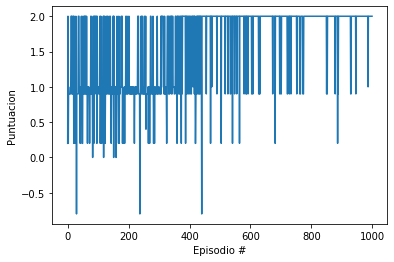

In [7]:
scores = dqn(basic_agent_adam, env, n_episodes=1000)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Puntuacion')
plt.xlabel('Episodio #')
plt.show()

### Red más pequeña

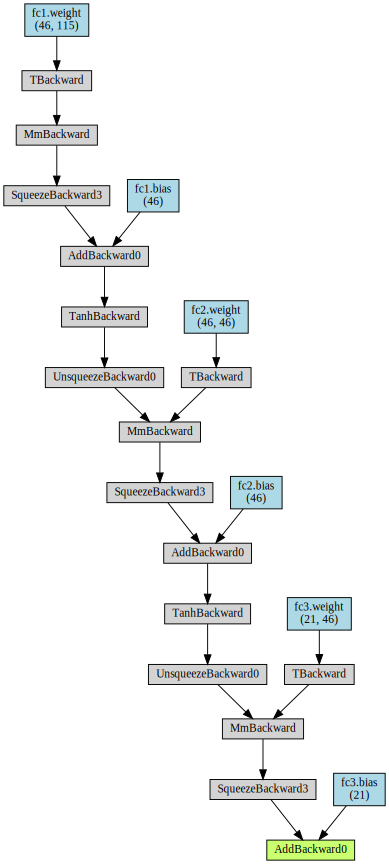

In [8]:
smaller_agent_adam = Agent(state_size=115, action_size=21, seed=0, network=SmallerNet, optim_fn='adam')

# Visualize the network
samp = torch.zeros(smaller_agent_adam.state_size)
out = smaller_agent_adam.qnetwork_local(samp)
make_dot(out, params=dict(smaller_agent_adam.qnetwork_local.named_parameters()))

A veces, ciertos problemas pueden ser resueltos en menos tiempo con menos parámetros, por lo que probar una red más pequeña puede dar una idea de la complejidad del problema. Si una red más pequeña alcanza una performance similar a la básica, puede que el problema no esté en la cantidad de parámetros de cada capa sino en la cantidad de episodios de entrenamiento.

I0816 14:45:57.290054 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:57.291979 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 129.3, gameFPS: 401.0
I0816 14:45:57.487712 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:45:57.488977 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:57.489574 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 79.1, gameFPS: 361.3


Episodio 2	Puntuacion media (ultimos 50):1.10

I0816 14:45:58.070604 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:58.071618 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 128.0, gameFPS: 483.9


Episodio 3	Puntuacion media (ultimos 50):0.80

I0816 14:45:58.566492 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:58.567563 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 137.4, gameFPS: 480.2


Episodio 4	Puntuacion media (ultimos 50):0.85

I0816 14:45:58.835900 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:58.836866 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 27, FPS: 103.6, gameFPS: 371.4


Episodio 5	Puntuacion media (ultimos 50):0.86

I0816 14:45:59.388033 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:59.390164 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 121.5, gameFPS: 355.3


Episodio 6	Puntuacion media (ultimos 50):0.87

I0816 14:45:59.850096 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:45:59.851071 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 118.8, gameFPS: 374.1


Episodio 7	Puntuacion media (ultimos 50):0.87

I0816 14:46:00.375173 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:00.375952 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 141.5, gameFPS: 515.7


Episodio 8	Puntuacion media (ultimos 50):0.88

I0816 14:46:00.642141 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:00.643039 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 22, FPS: 85.4, gameFPS: 278.8


Episodio 9	Puntuacion media (ultimos 50):0.88

I0816 14:46:01.274621 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:01.275586 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 128.4, gameFPS: 407.4


Episodio 10	Puntuacion media (ultimos 50):0.88

I0816 14:46:01.710083 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:01.711185 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 119.5, gameFPS: 427.8
I0816 14:46:01.864977 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:01.866268 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:01.866861 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 68.8, gameFPS: 336.1


Episodio 12	Puntuacion media (ultimos 50):0.98

I0816 14:46:02.083358 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:02.084487 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:02.085171 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 86.1, gameFPS: 375.2
I0816 14:46:02.284887 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:02.286217 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:02.286809 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 87.6, gameFPS: 378.7


Episodio 14	Puntuacion media (ultimos 50):1.12

I0816 14:46:02.884205 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:02.885239 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 121.6, gameFPS: 439.9


Episodio 15	Puntuacion media (ultimos 50):1.11

I0816 14:46:03.147032 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:03.148270 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:03.148911 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 26, FPS: 100.6, gameFPS: 398.6


Episodio 16	Puntuacion media (ultimos 50):1.16

I0816 14:46:03.742331 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:03.743207 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 124.4, gameFPS: 446.1


Episodio 17	Puntuacion media (ultimos 50):1.15

I0816 14:46:04.180374 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:04.181268 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 119.7, gameFPS: 419.5


Episodio 18	Puntuacion media (ultimos 50):1.13

I0816 14:46:04.778032 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:04.778975 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 134.3, gameFPS: 466.7


Episodio 19	Puntuacion media (ultimos 50):1.12

I0816 14:46:05.151032 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:05.152105 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 46, FPS: 126.5, gameFPS: 492.7


Episodio 20	Puntuacion media (ultimos 50):1.11

I0816 14:46:05.636699 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:05.637670 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 113.3, gameFPS: 352.4
I0816 14:46:05.801078 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:05.802446 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:05.803157 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 70.4, gameFPS: 306.5


Episodio 22	Puntuacion media (ultimos 50):1.15

I0816 14:46:06.609868 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:06.610940 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:06.611950 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 73.9, gameFPS: 326.8


Episodio 24	Puntuacion media (ultimos 50):1.18

I0816 14:46:06.993565 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:06.994570 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 47, FPS: 128.0, gameFPS: 504.2


Episodio 25	Puntuacion media (ultimos 50):1.16

I0816 14:46:07.901499 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:07.902616 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:07.903227 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 81.2, gameFPS: 350.9


Episodio 27	Puntuacion media (ultimos 50):1.19

I0816 14:46:08.388512 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:08.389410 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 145.0, gameFPS: 518.6
I0816 14:46:08.565438 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:08.566728 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:08.567440 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 82.9, gameFPS: 341.9


Episodio 29	Puntuacion media (ultimos 50):1.21

I0816 14:46:08.721056 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:08.722257 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:08.722877 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 60.8, gameFPS: 254.1


Episodio 30	Puntuacion media (ultimos 50):1.23

I0816 14:46:09.677263 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:09.678377 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:09.678920 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 22, FPS: 98.7, gameFPS: 397.0


Episodio 34	Puntuacion media (ultimos 50):1.21

I0816 14:46:11.394708 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:11.395581 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 131.0, gameFPS: 449.3


Episodio 35	Puntuacion media (ultimos 50):1.20

I0816 14:46:11.991735 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:11.992747 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 146.4, gameFPS: 481.9


Episodio 36	Puntuacion media (ultimos 50):1.19

I0816 14:46:12.369961 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:12.370845 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 49, FPS: 133.0, gameFPS: 499.4


Episodio 37	Puntuacion media (ultimos 50):1.18

I0816 14:46:12.932408 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:12.933380 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 131.6, gameFPS: 441.1


Episodio 38	Puntuacion media (ultimos 50):1.17

I0816 14:46:13.352506 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:13.353362 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 121.1, gameFPS: 411.1
I0816 14:46:13.507857 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:13.508858 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:13.509504 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 67.4, gameFPS: 296.5


Episodio 40	Puntuacion media (ultimos 50):1.19

I0816 14:46:13.671994 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:13.673246 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:13.673911 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 70.1, gameFPS: 310.7


Episodio 41	Puntuacion media (ultimos 50):1.21

I0816 14:46:14.087939 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:14.088830 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 125.4, gameFPS: 428.7


Episodio 42	Puntuacion media (ultimos 50):1.20

I0816 14:46:14.609977 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:14.610877 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 152.7, gameFPS: 604.3
I0816 14:46:14.787651 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:14.788759 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:14.789572 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 59.5, gameFPS: 228.7


Episodio 44	Puntuacion media (ultimos 50):1.21

I0816 14:46:15.710856 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:15.712081 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:15.712678 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.4, gameFPS: 291.3


Episodio 46	Puntuacion media (ultimos 50):1.22

I0816 14:46:15.904020 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:15.905226 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:15.905787 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 88.3, gameFPS: 371.7


Episodio 47	Puntuacion media (ultimos 50):1.24

I0816 14:46:16.422511 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:16.423663 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 151.5, gameFPS: 588.8


Episodio 48	Puntuacion media (ultimos 50):1.23

I0816 14:46:17.164306 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:17.165282 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 98, FPS: 134.5, gameFPS: 442.6


Episodio 49	Puntuacion media (ultimos 50):1.23

I0816 14:46:17.385473 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:17.386436 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 79.4, gameFPS: 270.3


Episodio 50	Puntuacion media (50 anteriores): 1.22


I0816 14:46:17.918949 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:17.919920 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 131.4, gameFPS: 465.8


Episodio 51	Puntuacion media (ultimos 50):1.22

I0816 14:46:18.287280 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:18.288256 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 44, FPS: 122.4, gameFPS: 478.0


Episodio 52	Puntuacion media (ultimos 50):1.20

I0816 14:46:18.816764 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:18.817876 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 131.8, gameFPS: 460.5


Episodio 53	Puntuacion media (ultimos 50):1.20

I0816 14:46:19.337394 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:19.338425 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 150.5, gameFPS: 568.1


Episodio 54	Puntuacion media (ultimos 50):1.18

I0816 14:46:20.216763 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:20.217846 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:20.218455 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 76.7, gameFPS: 325.5


Episodio 56	Puntuacion media (ultimos 50):1.21

I0816 14:46:20.711741 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:20.712616 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 146.9, gameFPS: 534.5


Episodio 58	Puntuacion media (ultimos 50):1.21

I0816 14:46:21.837548 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:21.838466 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 150.7, gameFPS: 562.0


Episodio 60	Puntuacion media (ultimos 50):1.18

I0816 14:46:23.522638 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:23.523840 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:23.524442 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 25, FPS: 102.6, gameFPS: 411.2


Episodio 62	Puntuacion media (ultimos 50):1.18

I0816 14:46:24.004945 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:24.005954 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 148.0, gameFPS: 556.7
I0816 14:46:24.153919 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:24.154857 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:24.157016 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 79.3, gameFPS: 727.1


Episodio 64	Puntuacion media (ultimos 50):1.16

I0816 14:46:24.715135 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:24.716012 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 155.1, gameFPS: 602.1
I0816 14:46:24.868338 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:24.869518 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:24.870186 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 69.4, gameFPS: 326.0


Episodio 66	Puntuacion media (ultimos 50):1.16

I0816 14:46:25.508570 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:25.509575 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 136.2, gameFPS: 457.5


Episodio 68	Puntuacion media (ultimos 50):1.14

I0816 14:46:26.835686 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:26.836647 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 141.3, gameFPS: 531.3
I0816 14:46:26.987639 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:26.988837 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:26.989488 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 62.1, gameFPS: 267.9


Episodio 70	Puntuacion media (ultimos 50):1.16

I0816 14:46:27.669851 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 14:46:27.671019 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:27.674702 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 92, FPS: 136.4, gameFPS: 461.7


Episodio 71	Puntuacion media (ultimos 50):1.14

I0816 14:46:28.206981 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:28.207948 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 133.5, gameFPS: 483.3


Episodio 72	Puntuacion media (ultimos 50):1.10

I0816 14:46:28.875681 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:28.876636 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 138.0, gameFPS: 494.3


Episodio 73	Puntuacion media (ultimos 50):1.10

I0816 14:46:29.474831 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:29.475812 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 137.0, gameFPS: 488.1


Episodio 74	Puntuacion media (ultimos 50):1.08

I0816 14:46:29.965407 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:29.966899 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 60, FPS: 125.9, gameFPS: 444.4


Episodio 76	Puntuacion media (ultimos 50):1.08

I0816 14:46:31.105251 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:31.106202 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 149.7, gameFPS: 592.9


Episodio 77	Puntuacion media (ultimos 50):1.05

I0816 14:46:31.392499 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:31.393647 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 29, FPS: 107.5, gameFPS: 382.9
I0816 14:46:31.550404 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:31.551307 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:31.551899 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 61.9, gameFPS: 258.5


Episodio 79	Puntuacion media (ultimos 50):1.05

I0816 14:46:32.371177 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:32.372347 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:32.373968 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 64.5, gameFPS: 274.3


Episodio 81	Puntuacion media (ultimos 50):1.05

I0816 14:46:32.818835 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:32.820713 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:32.824099 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 22, FPS: 57.6, gameFPS: 337.8


Episodio 83	Puntuacion media (ultimos 50):1.06

I0816 14:46:35.164799 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:35.165999 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:35.166777 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 100, FPS: 107.4, gameFPS: 457.7


Episodio 84	Puntuacion media (ultimos 50):1.08

I0816 14:46:35.669378 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:35.670286 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 108.3, gameFPS: 401.3
I0816 14:46:35.851089 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:35.853812 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:35.855190 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 86.7, gameFPS: 386.8


Episodio 86	Puntuacion media (ultimos 50):1.11

I0816 14:46:36.399054 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:36.399943 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 147.8, gameFPS: 538.2


Episodio 87	Puntuacion media (ultimos 50):1.11

I0816 14:46:36.618653 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:36.619696 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 82.3, gameFPS: 284.7


Episodio 88	Puntuacion media (ultimos 50):1.11

I0816 14:46:37.168269 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:37.169252 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 130.3, gameFPS: 454.0


Episodio 89	Puntuacion media (ultimos 50):1.11

I0816 14:46:37.431337 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:37.432312 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:37.432880 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 26, FPS: 103.3, gameFPS: 420.8


Episodio 92	Puntuacion media (ultimos 50):1.09

I0816 14:46:39.342053 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:39.343048 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 133.4, gameFPS: 476.1


Episodio 93	Puntuacion media (ultimos 50):1.09

I0816 14:46:39.919525 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:39.920562 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 137.7, gameFPS: 507.5


Episodio 94	Puntuacion media (ultimos 50):1.07

I0816 14:46:40.514284 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:40.515174 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 134.6, gameFPS: 475.7


Episodio 95	Puntuacion media (ultimos 50):1.07

I0816 14:46:41.419001 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:41.420108 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:41.420847 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 89.4, gameFPS: 363.1


Episodio 97	Puntuacion media (ultimos 50):1.05

I0816 14:46:41.830568 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:41.831901 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 127.4, gameFPS: 490.6


Episodio 98	Puntuacion media (ultimos 50):1.04

I0816 14:46:42.439934 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:42.440908 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 130.0, gameFPS: 437.7
I0816 14:46:42.604059 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:42.605308 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:42.606221 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 65.1, gameFPS: 265.1


Episodio 100	Puntuacion media (50 anteriores): 1.06


I0816 14:46:42.874727 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:42.875890 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:42.876559 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 28, FPS: 106.4, gameFPS: 430.5


Episodio 101	Puntuacion media (ultimos 50):1.10

I0816 14:46:43.437608 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:43.438589 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 123.6, gameFPS: 382.2


Episodio 102	Puntuacion media (ultimos 50):1.10

I0816 14:46:43.991579 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:43.992555 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 135.6, gameFPS: 503.2


Episodio 103	Puntuacion media (ultimos 50):1.11

I0816 14:46:44.431414 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:44.432361 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 61, FPS: 143.5, gameFPS: 603.9


Episodio 104	Puntuacion media (ultimos 50):1.13

I0816 14:46:44.924961 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:44.925886 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 146.8, gameFPS: 564.6


Episodio 105	Puntuacion media (ultimos 50):1.13

I0816 14:46:45.561234 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:45.562212 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 133.6, gameFPS: 444.7


Episodio 106	Puntuacion media (ultimos 50):1.11

I0816 14:46:46.235917 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:46.236963 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 90, FPS: 134.8, gameFPS: 444.7


Episodio 107	Puntuacion media (ultimos 50):1.11

I0816 14:46:46.740457 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:46.741356 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 135.1, gameFPS: 422.0


Episodio 108	Puntuacion media (ultimos 50):1.11

I0816 14:46:47.146238 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:47.147257 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 132.7, gameFPS: 462.7


Episodio 109	Puntuacion media (ultimos 50):1.12

I0816 14:46:47.662802 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:47.663713 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 148.4, gameFPS: 568.1


Episodio 110	Puntuacion media (ultimos 50):1.14

I0816 14:46:48.145542 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:48.146584 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 146.3, gameFPS: 555.6
I0816 14:46:48.297471 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:48.298723 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:48.299420 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 70.0, gameFPS: 333.3


Episodio 112	Puntuacion media (ultimos 50):1.12

I0816 14:46:48.799948 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:48.800824 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 150.0, gameFPS: 556.2


Episodio 113	Puntuacion media (ultimos 50):1.12

I0816 14:46:49.345916 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:49.346882 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 130.4, gameFPS: 454.1
I0816 14:46:49.509876 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:49.510990 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:49.511625 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 66.8, gameFPS: 292.9


Episodio 115	Puntuacion media (ultimos 50):1.12

I0816 14:46:49.677488 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:49.678592 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:49.679371 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.4, gameFPS: 357.1


Episodio 116	Puntuacion media (ultimos 50):1.12

I0816 14:46:50.352804 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:50.353984 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 132.9, gameFPS: 433.5


Episodio 117	Puntuacion media (ultimos 50):1.14

I0816 14:46:50.755414 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:50.756412 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 143.3, gameFPS: 577.9
I0816 14:46:50.925628 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:50.926841 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:50.927671 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 79.5, gameFPS: 330.2


Episodio 119	Puntuacion media (ultimos 50):1.16

I0816 14:46:51.156109 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:51.157429 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:51.158054 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 94.9, gameFPS: 394.9


Episodio 120	Puntuacion media (ultimos 50):1.16

I0816 14:46:51.647277 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:51.648155 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 145.9, gameFPS: 546.7


Episodio 121	Puntuacion media (ultimos 50):1.17

I0816 14:46:52.096010 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:52.096881 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 127.7, gameFPS: 420.3


Episodio 122	Puntuacion media (ultimos 50):1.18

I0816 14:46:52.625250 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:52.626189 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 148.3, gameFPS: 549.0


Episodio 123	Puntuacion media (ultimos 50):1.18

I0816 14:46:53.173923 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:53.174996 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 152.3, gameFPS: 642.8
I0816 14:46:53.398828 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:53.399897 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:53.405965 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 26, FPS: 121.2, gameFPS: 677.7


Episodio 125	Puntuacion media (ultimos 50):1.20

I0816 14:46:53.793749 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:53.794616 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 49, FPS: 128.5, gameFPS: 505.5


Episodio 126	Puntuacion media (ultimos 50):1.20

I0816 14:46:54.379427 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:54.380407 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 128.6, gameFPS: 437.9
I0816 14:46:54.539453 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:54.542009 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:54.542848 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 65.9, gameFPS: 273.8


Episodio 128	Puntuacion media (ultimos 50):1.24

I0816 14:46:55.188179 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:55.189385 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:55.190108 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 84, FPS: 131.7, gameFPS: 441.2
I0816 14:46:55.412379 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:46:55.413459 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:55.414594 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 96.9, gameFPS: 406.4


Episodio 130	Puntuacion media (ultimos 50):1.26

I0816 14:46:55.977083 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:55.978059 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 154.9, gameFPS: 579.4


Episodio 131	Puntuacion media (ultimos 50):1.24

I0816 14:46:56.539516 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:56.540402 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 153.6, gameFPS: 595.6


Episodio 132	Puntuacion media (ultimos 50):1.21

I0816 14:46:57.044218 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:57.045103 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 144.4, gameFPS: 561.2


Episodio 133	Puntuacion media (ultimos 50):1.21

I0816 14:46:57.734143 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:57.735122 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 96, FPS: 141.1, gameFPS: 469.7


Episodio 135	Puntuacion media (ultimos 50):1.19

I0816 14:46:58.961417 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:58.962540 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 132.2, gameFPS: 470.6


Episodio 136	Puntuacion media (ultimos 50):1.17

I0816 14:46:59.487774 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:46:59.488753 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 126.0, gameFPS: 429.6


Episodio 138	Puntuacion media (ultimos 50):1.17

I0816 14:47:00.356305 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:00.357308 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 90.8, gameFPS: 311.3


Episodio 139	Puntuacion media (ultimos 50):1.17

I0816 14:47:00.823591 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:00.824556 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 119.9, gameFPS: 386.8


Episodio 140	Puntuacion media (ultimos 50):1.14

I0816 14:47:01.389712 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:01.394442 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 134.4, gameFPS: 480.0


Episodio 141	Puntuacion media (ultimos 50):1.14

I0816 14:47:02.124746 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:02.125713 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 98, FPS: 135.1, gameFPS: 447.4


Episodio 142	Puntuacion media (ultimos 50):1.14

I0816 14:47:02.669207 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:02.670244 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 136.3, gameFPS: 513.7


Episodio 143	Puntuacion media (ultimos 50):1.14

I0816 14:47:03.083410 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:03.084210 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 139.0, gameFPS: 529.1


Episodio 144	Puntuacion media (ultimos 50):1.14

I0816 14:47:03.797055 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:03.798059 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 127.0, gameFPS: 385.9


Episodio 146	Puntuacion media (ultimos 50):1.15

I0816 14:47:04.946392 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:04.947411 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 146.5, gameFPS: 541.6
I0816 14:47:05.102847 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:47:05.103911 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:05.104605 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 70.0, gameFPS: 318.9


Episodio 148	Puntuacion media (ultimos 50):1.15

I0816 14:47:05.737869 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:05.738965 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 118.2, gameFPS: 322.8


Episodio 149	Puntuacion media (ultimos 50):1.15

I0816 14:47:06.079099 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:06.080157 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 35, FPS: 105.4, gameFPS: 354.5


Episodio 150	Puntuacion media (50 anteriores): 1.13


I0816 14:47:06.668026 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:06.668803 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 126.0, gameFPS: 361.6


Episodio 152	Puntuacion media (ultimos 50):1.11

I0816 14:47:07.938851 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:07.939824 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 133.5, gameFPS: 478.6
I0816 14:47:08.093068 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:47:08.094416 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:08.095159 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 70.1, gameFPS: 337.0


Episodio 154	Puntuacion media (ultimos 50):1.13

I0816 14:47:08.615075 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:08.615970 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 150.6, gameFPS: 558.1


Episodio 155	Puntuacion media (ultimos 50):1.13

I0816 14:47:09.173063 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:09.174112 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 144.3, gameFPS: 504.9


Episodio 157	Puntuacion media (ultimos 50):1.14

I0816 14:47:10.371447 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:10.372339 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 145.5, gameFPS: 553.6
I0816 14:47:10.554521 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:10.555551 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 11, FPS: 64.3, gameFPS: 223.6


Episodio 159	Puntuacion media (ultimos 50):1.12

I0816 14:47:11.047584 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:11.048363 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 144.4, gameFPS: 546.5


Episodio 160	Puntuacion media (ultimos 50):1.12

I0816 14:47:11.669203 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:11.670691 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 145.5, gameFPS: 484.5


Episodio 162	Puntuacion media (ultimos 50):1.11

I0816 14:47:12.662045 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:12.662947 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 44, FPS: 125.6, gameFPS: 461.7


Episodio 164	Puntuacion media (ultimos 50):1.11

I0816 14:47:13.919002 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:13.919900 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 151.5, gameFPS: 550.6


Episodio 165	Puntuacion media (ultimos 50):1.09

I0816 14:47:14.504933 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:14.506038 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 129.4, gameFPS: 462.0


Episodio 166	Puntuacion media (ultimos 50):1.06

I0816 14:47:15.162858 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:15.163833 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 136.1, gameFPS: 481.0


Episodio 167	Puntuacion media (ultimos 50):1.06

I0816 14:47:15.827410 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:15.828545 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 138.7, gameFPS: 515.4


Episodio 168	Puntuacion media (ultimos 50):1.07

I0816 14:47:16.354641 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:16.355529 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 146.1, gameFPS: 564.4


Episodio 170	Puntuacion media (ultimos 50):1.02

I0816 14:47:17.586014 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:17.587159 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 132.6, gameFPS: 470.6
I0816 14:47:17.789562 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:17.790565 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 15, FPS: 77.3, gameFPS: 266.2


Episodio 172	Puntuacion media (ultimos 50):1.02

I0816 14:47:18.382834 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:18.383813 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 145.8, gameFPS: 508.6


Episodio 174	Puntuacion media (ultimos 50):1.01

I0816 14:47:19.345767 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:19.346543 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 31, FPS: 108.6, gameFPS: 357.6


Episodio 175	Puntuacion media (ultimos 50):0.99

I0816 14:47:19.825002 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:19.826200 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 148.7, gameFPS: 602.5


Episodio 176	Puntuacion media (ultimos 50):0.99

I0816 14:47:20.317102 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:20.318053 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 147.3, gameFPS: 595.7


Episodio 179	Puntuacion media (ultimos 50):0.94

I0816 14:47:22.327694 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:22.328628 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 138.7, gameFPS: 529.8


Episodio 180	Puntuacion media (ultimos 50):0.92

I0816 14:47:22.585786 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:47:22.586824 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:22.587416 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 22, FPS: 87.1, gameFPS: 285.1


Episodio 181	Puntuacion media (ultimos 50):0.94

I0816 14:47:23.160644 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:23.161620 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 127.3, gameFPS: 408.8
I0816 14:47:23.408589 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:47:23.409614 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:23.410229 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 99.8, gameFPS: 395.2


Episodio 183	Puntuacion media (ultimos 50):0.97

I0816 14:47:23.934535 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:23.935507 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 135.5, gameFPS: 516.4


Episodio 184	Puntuacion media (ultimos 50):0.97

I0816 14:47:24.434207 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:24.435212 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 131.5, gameFPS: 506.6


Episodio 186	Puntuacion media (ultimos 50):0.97

I0816 14:47:25.320850 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:25.321833 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 24, FPS: 99.2, gameFPS: 355.7


Episodio 187	Puntuacion media (ultimos 50):0.97

I0816 14:47:25.962185 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:25.963335 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 95, FPS: 150.3, gameFPS: 532.8
I0816 14:47:26.174186 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:47:26.175330 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:26.175963 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 98.7, gameFPS: 404.6


Episodio 189	Puntuacion media (ultimos 50):0.99

I0816 14:47:26.450293 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:47:26.451514 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:26.452085 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 32, FPS: 119.1, gameFPS: 510.4


Episodio 190	Puntuacion media (ultimos 50):1.01

I0816 14:47:27.057483 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:27.058796 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 130.3, gameFPS: 435.5


Episodio 191	Puntuacion media (ultimos 50):1.01

I0816 14:47:27.725190 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 14:47:27.726376 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:27.727049 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 90, FPS: 136.0, gameFPS: 452.5
I0816 14:47:27.886723 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:47:27.888070 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:27.888733 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 65.0, gameFPS: 263.3


Episodio 193	Puntuacion media (ultimos 50):1.00

I0816 14:47:28.546976 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:28.547927 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 136.7, gameFPS: 468.9


Episodio 194	Puntuacion media (ultimos 50):1.00

I0816 14:47:29.087941 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:29.089166 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 133.4, gameFPS: 471.6
I0816 14:47:30.100622 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:47:30.101715 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:30.102308 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.6, gameFPS: 304.3


Episodio 196	Puntuacion media (ultimos 50):1.02

I0816 14:47:30.339246 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:30.340128 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 82.8, gameFPS: 284.6


Episodio 197	Puntuacion media (ultimos 50):1.02

I0816 14:47:31.063602 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:31.064813 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 100, FPS: 139.9, gameFPS: 512.7


Episodio 198	Puntuacion media (ultimos 50):1.00

I0816 14:47:31.657922 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:31.662625 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 134.9, gameFPS: 506.2


Episodio 199	Puntuacion media (ultimos 50):1.00

I0816 14:47:32.205882 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:32.206862 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 133.7, gameFPS: 492.9


Episodio 200	Puntuacion media (50 anteriores): 0.99
Episodio 201	Puntuacion media (ultimos 50):0.99

I0816 14:47:33.553343 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:33.554275 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 90, FPS: 139.6, gameFPS: 433.4


Episodio 203	Puntuacion media (ultimos 50):0.98

I0816 14:47:35.196611 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:47:35.197644 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:35.198407 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 80.6, gameFPS: 322.5


Episodio 205	Puntuacion media (ultimos 50):0.98

I0816 14:47:35.746029 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:35.746920 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 149.8, gameFPS: 543.2


Episodio 208	Puntuacion media (ultimos 50):0.98

I0816 14:47:37.386937 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:37.387866 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 38, FPS: 119.1, gameFPS: 437.9


Episodio 211	Puntuacion media (ultimos 50):0.99

I0816 14:47:39.550985 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:39.551960 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 134.5, gameFPS: 448.2


Episodio 214	Puntuacion media (ultimos 50):1.00

I0816 14:47:41.556243 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:41.557388 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 118.2, gameFPS: 344.6


Episodio 215	Puntuacion media (ultimos 50):1.00

I0816 14:47:42.092514 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:42.093454 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 152.5, gameFPS: 622.3


Episodio 216	Puntuacion media (ultimos 50):1.00

I0816 14:47:42.688201 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:42.689054 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 136.5, gameFPS: 497.7


Episodio 217	Puntuacion media (ultimos 50):1.00

I0816 14:47:43.199297 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:43.200270 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 115.6, gameFPS: 341.2


Episodio 218	Puntuacion media (ultimos 50):1.00

I0816 14:47:43.444497 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:43.445499 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 86.1, gameFPS: 294.6


Episodio 219	Puntuacion media (ultimos 50):1.00

I0816 14:47:44.103382 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:44.104418 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 135.0, gameFPS: 464.1


Episodio 221	Puntuacion media (ultimos 50):1.01

I0816 14:47:45.101831 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:47:45.103171 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:45.103867 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 32, FPS: 106.7, gameFPS: 414.4


Episodio 222	Puntuacion media (ultimos 50):1.04

I0816 14:47:45.679197 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:45.680251 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 133.6, gameFPS: 483.8


Episodio 223	Puntuacion media (ultimos 50):1.04

I0816 14:47:46.330506 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:46.331386 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 90, FPS: 139.9, gameFPS: 470.4


Episodio 224	Puntuacion media (ultimos 50):1.05

I0816 14:47:46.974724 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:46.975966 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 130.3, gameFPS: 420.8


Episodio 225	Puntuacion media (ultimos 50):1.05

I0816 14:47:47.487976 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:47.488997 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 132.3, gameFPS: 490.1


Episodio 227	Puntuacion media (ultimos 50):1.05

I0816 14:47:48.426153 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:48.427147 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 79.0, gameFPS: 267.0
I0816 14:47:48.582836 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:47:48.584115 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:48.584777 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 73.7, gameFPS: 330.6


Episodio 230	Puntuacion media (ultimos 50):1.07

I0816 14:47:49.671051 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:47:49.672116 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:49.672777 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 41, FPS: 119.1, gameFPS: 487.1


Episodio 231	Puntuacion media (ultimos 50):1.07

I0816 14:47:49.944025 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:47:49.945175 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:49.945797 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 28, FPS: 105.8, gameFPS: 416.9
I0816 14:47:50.195130 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:47:50.196458 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:50.197139 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 99.3, gameFPS: 396.2


Episodio 233	Puntuacion media (ultimos 50):1.09

I0816 14:47:50.824869 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:50.825890 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 130.5, gameFPS: 436.0


Episodio 234	Puntuacion media (ultimos 50):1.09

I0816 14:47:51.188130 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:51.189042 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 40, FPS: 114.8, gameFPS: 420.7


Episodio 235	Puntuacion media (ultimos 50):1.09

I0816 14:47:51.678450 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:51.679317 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 138.9, gameFPS: 496.8
I0816 14:47:51.840438 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:47:51.841436 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:51.842453 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 77.9, gameFPS: 349.0


Episodio 237	Puntuacion media (ultimos 50):1.11

I0816 14:47:52.470164 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:52.471877 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 134.5, gameFPS: 486.7
I0816 14:47:52.701831 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:52.702720 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 80.9, gameFPS: 271.0


Episodio 239	Puntuacion media (ultimos 50):1.09

I0816 14:47:52.968901 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:52.969826 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 24, FPS: 92.4, gameFPS: 330.8


Episodio 240	Puntuacion media (ultimos 50):1.07

I0816 14:47:53.468855 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:53.469753 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 132.0, gameFPS: 403.3


Episodio 242	Puntuacion media (ultimos 50):1.10

I0816 14:47:54.780283 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:54.781293 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 130.7, gameFPS: 434.7


Episodio 243	Puntuacion media (ultimos 50):1.08

I0816 14:47:55.388952 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:55.389937 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 110.0, gameFPS: 293.6


Episodio 244	Puntuacion media (ultimos 50):1.08

I0816 14:47:56.001462 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:56.002430 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 141.0, gameFPS: 546.0


Episodio 245	Puntuacion media (ultimos 50):1.07

I0816 14:47:56.578159 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:56.579121 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 138.1, gameFPS: 533.0


Episodio 246	Puntuacion media (ultimos 50):1.05

I0816 14:47:57.223764 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:57.224606 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 135.8, gameFPS: 486.4


Episodio 247	Puntuacion media (ultimos 50):1.05

I0816 14:47:57.655452 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:57.656238 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 130.3, gameFPS: 437.5


Episodio 248	Puntuacion media (ultimos 50):1.05

I0816 14:47:58.236090 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:58.237069 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 132.7, gameFPS: 472.1


Episodio 249	Puntuacion media (ultimos 50):1.05

I0816 14:47:58.949909 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:58.951215 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 95, FPS: 134.8, gameFPS: 465.0


Episodio 250	Puntuacion media (50 anteriores): 1.05


I0816 14:47:59.602392 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:47:59.603373 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 132.6, gameFPS: 446.2


Episodio 252	Puntuacion media (ultimos 50):1.05

I0816 14:48:00.885975 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:48:00.887223 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:00.887830 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 99, FPS: 159.8, gameFPS: 643.4
I0816 14:48:01.143180 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:48:01.144311 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:01.144926 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 28, FPS: 113.3, gameFPS: 483.4


Episodio 254	Puntuacion media (ultimos 50):1.11

I0816 14:48:01.648409 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:01.649991 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 136.4, gameFPS: 456.4


Episodio 255	Puntuacion media (ultimos 50):1.08

I0816 14:48:02.220511 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:02.221729 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 145.9, gameFPS: 529.9


Episodio 256	Puntuacion media (ultimos 50):1.08

I0816 14:48:02.846150 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:02.847053 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 137.8, gameFPS: 522.8


Episodio 257	Puntuacion media (ultimos 50):1.08

I0816 14:48:03.146007 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:03.147003 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 29, FPS: 99.9, gameFPS: 346.4


Episodio 258	Puntuacion media (ultimos 50):1.08

I0816 14:48:04.099061 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 14:48:04.100188 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:04.100698 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 94, FPS: 99.7, gameFPS: 339.3


Episodio 259	Puntuacion media (ultimos 50):1.06

I0816 14:48:04.878992 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:04.879821 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 96.9, gameFPS: 411.5


Episodio 260	Puntuacion media (ultimos 50):1.06

I0816 14:48:05.740485 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:05.741425 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 10, FPS: 61.5, gameFPS: 211.6


Episodio 262	Puntuacion media (ultimos 50):1.04

I0816 14:48:06.241473 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:06.242333 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 136.1, gameFPS: 546.7


Episodio 263	Puntuacion media (ultimos 50):1.04

I0816 14:48:06.878872 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:06.882538 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 140.0, gameFPS: 561.1


Episodio 264	Puntuacion media (ultimos 50):1.04

I0816 14:48:07.444806 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:07.447913 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 125.9, gameFPS: 424.1


Episodio 266	Puntuacion media (ultimos 50):1.04

I0816 14:48:08.458046 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:08.459016 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 24, FPS: 93.4, gameFPS: 326.3


Episodio 267	Puntuacion media (ultimos 50):1.04

I0816 14:48:08.862181 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:08.863160 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 128.8, gameFPS: 523.0


Episodio 268	Puntuacion media (ultimos 50):1.04

I0816 14:48:09.485943 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:09.486899 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 130.2, gameFPS: 435.1


Episodio 269	Puntuacion media (ultimos 50):1.04

I0816 14:48:10.158782 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:10.159772 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 133.1, gameFPS: 458.7


Episodio 270	Puntuacion media (ultimos 50):1.05

I0816 14:48:10.868141 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:10.869254 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 130.1, gameFPS: 414.2


Episodio 271	Puntuacion media (ultimos 50):1.05

I0816 14:48:11.444204 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:11.445161 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 134.1, gameFPS: 493.8


Episodio 272	Puntuacion media (ultimos 50):1.03

I0816 14:48:12.193966 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:12.194924 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 100, FPS: 135.4, gameFPS: 448.0


Episodio 273	Puntuacion media (ultimos 50):1.03

I0816 14:48:12.748679 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:12.749635 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 139.2, gameFPS: 575.9


Episodio 274	Puntuacion media (ultimos 50):1.03

I0816 14:48:13.497515 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:13.498553 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 94, FPS: 126.6, gameFPS: 377.6


Episodio 277	Puntuacion media (ultimos 50):1.03

I0816 14:48:15.210538 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:15.211551 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 130.3, gameFPS: 495.8
I0816 14:48:15.362926 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:48:15.364085 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:15.368020 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 80.4, gameFPS: 601.1


Episodio 279	Puntuacion media (ultimos 50):1.03

I0816 14:48:15.961929 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:15.963073 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 137.6, gameFPS: 521.3


Episodio 280	Puntuacion media (ultimos 50):1.03

I0816 14:48:16.453145 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:16.454183 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 138.7, gameFPS: 542.9


Episodio 281	Puntuacion media (ultimos 50):1.01

I0816 14:48:16.977478 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:16.978368 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 151.7, gameFPS: 635.6


Episodio 282	Puntuacion media (ultimos 50):0.99

I0816 14:48:17.645922 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:17.646817 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 99, FPS: 151.6, gameFPS: 617.9


Episodio 285	Puntuacion media (ultimos 50):0.97

I0816 14:48:19.656797 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 14:48:19.658059 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:19.658666 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 100, FPS: 150.6, gameFPS: 522.8
I0816 14:48:19.903125 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:48:19.904376 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:19.905073 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 26, FPS: 108.9, gameFPS: 466.0


Episodio 288	Puntuacion media (ultimos 50):0.95

I0816 14:48:21.210426 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:21.211388 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 133.9, gameFPS: 494.3


Episodio 291	Puntuacion media (ultimos 50):0.94

I0816 14:48:23.575405 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:23.576381 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 112.2, gameFPS: 493.4


Episodio 292	Puntuacion media (ultimos 50):0.94

I0816 14:48:24.497545 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 14:48:24.498456 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:24.499263 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 98, FPS: 108.5, gameFPS: 393.5


Episodio 293	Puntuacion media (ultimos 50):0.92

I0816 14:48:25.263858 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:25.264755 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 109.2, gameFPS: 421.1
I0816 14:48:25.523526 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:25.524420 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 15, FPS: 59.8, gameFPS: 210.1


Episodio 295	Puntuacion media (ultimos 50):0.93

I0816 14:48:26.041448 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:26.042301 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 109.2, gameFPS: 399.4
I0816 14:48:26.226453 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:48:26.227555 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:26.228255 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 58.6, gameFPS: 248.3


Episodio 297	Puntuacion media (ultimos 50):0.95

I0816 14:48:27.003966 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:27.004850 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 120.0, gameFPS: 458.2


Episodio 298	Puntuacion media (ultimos 50):0.95

I0816 14:48:27.592888 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:27.593703 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 127.9, gameFPS: 490.4


Episodio 299	Puntuacion media (ultimos 50):0.95

I0816 14:48:28.233191 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:28.233988 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 133.6, gameFPS: 546.8


Episodio 300	Puntuacion media (50 anteriores): 0.95


I0816 14:48:28.774846 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:28.775835 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 125.5, gameFPS: 505.9


Episodio 301	Puntuacion media (ultimos 50):0.95

I0816 14:48:29.347158 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:29.350557 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 117.8, gameFPS: 419.2


Episodio 302	Puntuacion media (ultimos 50):0.95

I0816 14:48:30.056266 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:30.057656 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 111.7, gameFPS: 316.4


Episodio 303	Puntuacion media (ultimos 50):0.93

I0816 14:48:30.720645 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:30.721847 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 102.9, gameFPS: 338.4


Episodio 307	Puntuacion media (ultimos 50):0.91

I0816 14:48:33.575793 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:33.576810 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 118.0, gameFPS: 345.7


Episodio 310	Puntuacion media (ultimos 50):0.93

I0816 14:48:35.495339 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:35.496313 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 133.9, gameFPS: 528.9


Episodio 311	Puntuacion media (ultimos 50):0.92

I0816 14:48:36.156161 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:36.157120 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 127.6, gameFPS: 408.1


Episodio 312	Puntuacion media (ultimos 50):0.92

I0816 14:48:36.598349 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:36.599184 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 122.5, gameFPS: 447.9


Episodio 313	Puntuacion media (ultimos 50):0.92

I0816 14:48:37.130734 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:37.131838 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 119.7, gameFPS: 418.7
I0816 14:48:37.395069 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:37.396257 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 23, FPS: 90.6, gameFPS: 319.8


Episodio 315	Puntuacion media (ultimos 50):0.91

I0816 14:48:37.673090 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:37.674092 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 24, FPS: 89.8, gameFPS: 314.8
I0816 14:48:37.901354 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:48:37.902448 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:37.904085 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 103.5, gameFPS: 473.2


Episodio 317	Puntuacion media (ultimos 50):0.93

I0816 14:48:38.672463 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:38.673366 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 99, FPS: 131.0, gameFPS: 417.7
I0816 14:48:38.836110 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:48:38.837196 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:38.837921 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.5, gameFPS: 273.1


Episodio 319	Puntuacion media (ultimos 50):0.95

I0816 14:48:39.306855 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:39.307795 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 119.2, gameFPS: 406.9
I0816 14:48:39.503296 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:48:39.504546 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:39.505131 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 100.7, gameFPS: 471.9


Episodio 321	Puntuacion media (ultimos 50):0.97

I0816 14:48:39.843375 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:39.844400 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 42, FPS: 128.5, gameFPS: 531.6


Episodio 322	Puntuacion media (ultimos 50):0.97

I0816 14:48:40.578436 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:40.579393 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 95, FPS: 131.0, gameFPS: 441.6
I0816 14:48:40.813576 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:40.814512 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 83.2, gameFPS: 287.7


Episodio 324	Puntuacion media (ultimos 50):0.97

I0816 14:48:41.075278 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:48:41.076309 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:41.076982 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 95.7, gameFPS: 367.5


Episodio 325	Puntuacion media (ultimos 50):0.99

I0816 14:48:41.702533 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:41.703416 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 94, FPS: 152.2, gameFPS: 613.6
I0816 14:48:41.884789 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:48:41.885884 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:41.886460 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 77.4, gameFPS: 322.5


Episodio 328	Puntuacion media (ultimos 50):1.01

I0816 14:48:43.252199 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:43.253170 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 120.0, gameFPS: 368.5


Episodio 329	Puntuacion media (ultimos 50):0.99

I0816 14:48:44.169786 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:48:44.171082 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:44.171716 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.7, gameFPS: 278.0


Episodio 331	Puntuacion media (ultimos 50):1.01

I0816 14:48:44.744575 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:44.745636 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 130.4, gameFPS: 485.5


Episodio 332	Puntuacion media (ultimos 50):1.01

I0816 14:48:45.347049 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:45.348063 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 138.8, gameFPS: 572.1


Episodio 333	Puntuacion media (ultimos 50):1.01

I0816 14:48:45.762029 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:48:45.763276 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:45.763892 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 50, FPS: 123.2, gameFPS: 473.6


Episodio 334	Puntuacion media (ultimos 50):1.03

I0816 14:48:46.358004 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:46.358914 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 134.6, gameFPS: 498.1


Episodio 335	Puntuacion media (ultimos 50):1.03

I0816 14:48:47.024209 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:47.025268 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 141.0, gameFPS: 564.3


Episodio 336	Puntuacion media (ultimos 50):1.05

I0816 14:48:47.312579 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:48:47.313632 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:47.314270 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 28, FPS: 99.6, gameFPS: 388.7


Episodio 337	Puntuacion media (ultimos 50):1.05

I0816 14:48:47.661218 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:47.661984 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 33, FPS: 98.1, gameFPS: 315.7


Episodio 340	Puntuacion media (ultimos 50):1.07

I0816 14:48:50.118432 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:48:50.119570 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:50.120208 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 97.2, gameFPS: 377.3


Episodio 342	Puntuacion media (ultimos 50):1.09

I0816 14:48:50.374878 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:50.376324 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 21, FPS: 86.6, gameFPS: 298.6


Episodio 343	Puntuacion media (ultimos 50):1.11

I0816 14:48:50.896109 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:50.897110 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 130.7, gameFPS: 482.4
I0816 14:48:51.055499 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:48:51.056555 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:51.057173 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 66.2, gameFPS: 292.8


Episodio 345	Puntuacion media (ultimos 50):1.13

I0816 14:48:51.315258 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:48:51.316465 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:51.317134 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 95.6, gameFPS: 386.1


Episodio 346	Puntuacion media (ultimos 50):1.16

I0816 14:48:51.739213 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:51.740225 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 126.7, gameFPS: 504.7


Episodio 348	Puntuacion media (ultimos 50):1.14

I0816 14:48:53.171856 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:53.172955 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 96, FPS: 135.7, gameFPS: 485.8


Episodio 349	Puntuacion media (ultimos 50):1.14

I0816 14:48:53.470481 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:53.471349 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 26, FPS: 90.0, gameFPS: 286.6


Episodio 350	Puntuacion media (50 anteriores): 1.14
Episodio 351	Puntuacion media (ultimos 50):1.14

I0816 14:48:55.139903 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:48:55.140972 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:55.141597 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 83.3, gameFPS: 347.7


Episodio 353	Puntuacion media (ultimos 50):1.16

I0816 14:48:55.729611 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:55.730570 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 138.2, gameFPS: 551.2


Episodio 354	Puntuacion media (ultimos 50):1.16

I0816 14:48:56.162892 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:56.163875 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 117.4, gameFPS: 409.5


Episodio 356	Puntuacion media (ultimos 50):1.16

I0816 14:48:57.595726 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:57.596689 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 131.5, gameFPS: 446.8


Episodio 357	Puntuacion media (ultimos 50):1.16

I0816 14:48:58.150542 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:58.151419 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 144.9, gameFPS: 557.7
I0816 14:48:58.301398 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:48:58.302560 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:58.303680 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 63.5, gameFPS: 292.9


Episodio 359	Puntuacion media (ultimos 50):1.18

I0816 14:48:58.564418 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:48:58.565743 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:58.566457 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 94.8, gameFPS: 366.9


Episodio 360	Puntuacion media (ultimos 50):1.20

I0816 14:48:59.191603 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:59.192527 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 122.3, gameFPS: 382.4


Episodio 361	Puntuacion media (ultimos 50):1.22

I0816 14:48:59.792786 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:48:59.793775 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 128.4, gameFPS: 438.4


Episodio 362	Puntuacion media (ultimos 50):1.23

I0816 14:49:00.437883 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:00.438735 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 132.3, gameFPS: 463.4
I0816 14:49:00.595517 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:49:00.596580 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:00.597365 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 65.5, gameFPS: 292.9


Episodio 364	Puntuacion media (ultimos 50):1.26

I0816 14:49:01.140291 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:01.141123 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 121.3, gameFPS: 393.3


Episodio 366	Puntuacion media (ultimos 50):1.26

I0816 14:49:02.468576 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:02.469445 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 94, FPS: 139.2, gameFPS: 430.6


Episodio 367	Puntuacion media (ultimos 50):1.23

I0816 14:49:03.110312 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:03.111227 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 130.8, gameFPS: 440.9


Episodio 368	Puntuacion media (ultimos 50):1.23

I0816 14:49:03.594323 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:03.595243 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 142.2, gameFPS: 548.4


Episodio 369	Puntuacion media (ultimos 50):1.21

I0816 14:49:03.835235 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:49:03.836397 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:03.837043 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 104.3, gameFPS: 445.4


Episodio 370	Puntuacion media (ultimos 50):1.23

I0816 14:49:04.277651 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:04.278618 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 120.3, gameFPS: 430.7


Episodio 371	Puntuacion media (ultimos 50):1.21

I0816 14:49:04.907721 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:04.908673 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 133.4, gameFPS: 483.1


Episodio 372	Puntuacion media (ultimos 50):1.21

I0816 14:49:05.254404 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:05.255287 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 36, FPS: 107.1, gameFPS: 384.3


Episodio 373	Puntuacion media (ultimos 50):1.21

I0816 14:49:05.876378 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:05.877592 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 116.9, gameFPS: 347.3


Episodio 374	Puntuacion media (ultimos 50):1.21

I0816 14:49:06.370437 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:06.371333 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 62, FPS: 127.9, gameFPS: 399.8


Episodio 375	Puntuacion media (ultimos 50):1.19

I0816 14:49:06.908170 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:06.909162 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 132.3, gameFPS: 486.6


Episodio 376	Puntuacion media (ultimos 50):1.19

I0816 14:49:07.468956 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:07.469938 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 131.8, gameFPS: 476.9


Episodio 378	Puntuacion media (ultimos 50):1.17

I0816 14:49:08.523926 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:49:08.525166 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:08.525967 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 33, FPS: 107.7, gameFPS: 418.6


Episodio 379	Puntuacion media (ultimos 50):1.19

I0816 14:49:08.902063 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:08.902968 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 44, FPS: 119.2, gameFPS: 425.1
I0816 14:49:09.088270 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:49:09.091062 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:09.092290 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 88.7, gameFPS: 422.7


Episodio 381	Puntuacion media (ultimos 50):1.19

I0816 14:49:09.316856 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:09.317835 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 74.9, gameFPS: 262.1


Episodio 382	Puntuacion media (ultimos 50):1.19

I0816 14:49:09.958414 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:09.959892 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 134.1, gameFPS: 478.8
I0816 14:49:10.182233 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:10.183204 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 76.2, gameFPS: 267.5


Episodio 384	Puntuacion media (ultimos 50):1.17

I0816 14:49:10.463269 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:10.464333 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 25, FPS: 91.6, gameFPS: 324.9


Episodio 385	Puntuacion media (ultimos 50):1.17

I0816 14:49:11.057742 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:11.059907 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 121.3, gameFPS: 387.2


Episodio 387	Puntuacion media (ultimos 50):1.15

I0816 14:49:12.455009 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:12.456016 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 134.6, gameFPS: 495.5


Episodio 390	Puntuacion media (ultimos 50):1.15

I0816 14:49:14.582844 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:14.583830 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 138.2, gameFPS: 510.5


Episodio 391	Puntuacion media (ultimos 50):1.15

I0816 14:49:15.135049 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:15.136049 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 128.4, gameFPS: 460.6


Episodio 392	Puntuacion media (ultimos 50):1.12

I0816 14:49:15.621848 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:15.622823 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 113.2, gameFPS: 351.0


Episodio 393	Puntuacion media (ultimos 50):1.12

I0816 14:49:15.986956 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:49:15.988285 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:15.988916 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 42, FPS: 116.8, gameFPS: 466.7


Episodio 394	Puntuacion media (ultimos 50):1.15

I0816 14:49:16.411962 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:16.416722 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 49, FPS: 118.0, gameFPS: 431.7


Episodio 395	Puntuacion media (ultimos 50):1.12

I0816 14:49:16.982847 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:16.983850 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 131.9, gameFPS: 514.8


Episodio 396	Puntuacion media (ultimos 50):1.10

I0816 14:49:17.624309 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:17.627408 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 132.9, gameFPS: 476.8


Episodio 397	Puntuacion media (ultimos 50):1.10

I0816 14:49:18.317836 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:18.318962 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 130.4, gameFPS: 451.8


Episodio 398	Puntuacion media (ultimos 50):1.10

I0816 14:49:18.742459 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:18.743366 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 129.5, gameFPS: 470.3
I0816 14:49:19.004830 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled


Episodio 399	Puntuacion media (ultimos 50):1.11

I0816 14:49:19.006244 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:19.007275 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 25, FPS: 97.6, gameFPS: 382.8


Episodio 400	Puntuacion media (50 anteriores): 1.13


I0816 14:49:19.528129 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:19.529064 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 140.5, gameFPS: 541.5
I0816 14:49:19.795201 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled


Episodio 401	Puntuacion media (ultimos 50):1.13

I0816 14:49:19.796274 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:19.798721 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 28, FPS: 108.8, gameFPS: 421.2
I0816 14:49:19.965488 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:49:19.966494 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:19.967569 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 67.0, gameFPS: 320.8


Episodio 403	Puntuacion media (ultimos 50):1.15

I0816 14:49:20.429988 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:20.431018 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 138.5, gameFPS: 530.5


Episodio 404	Puntuacion media (ultimos 50):1.15

I0816 14:49:21.039125 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:21.040118 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 126.5, gameFPS: 417.5


Episodio 405	Puntuacion media (ultimos 50):1.15

I0816 14:49:21.677325 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:21.678181 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 129.0, gameFPS: 437.2


Episodio 406	Puntuacion media (ultimos 50):1.14

I0816 14:49:22.013416 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:22.014801 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 40, FPS: 121.2, gameFPS: 510.5


Episodio 407	Puntuacion media (ultimos 50):1.14

I0816 14:49:22.528418 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:22.529321 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 137.1, gameFPS: 495.6
I0816 14:49:22.701124 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:49:22.702359 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:22.703299 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 79.4, gameFPS: 349.4


Episodio 409	Puntuacion media (ultimos 50):1.14

I0816 14:49:23.353129 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:23.354211 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 122.8, gameFPS: 372.0


Episodio 410	Puntuacion media (ultimos 50):1.12

I0816 14:49:23.900890 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:23.901769 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 147.5, gameFPS: 578.5


Episodio 411	Puntuacion media (ultimos 50):1.12

I0816 14:49:24.525081 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:24.526053 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 130.1, gameFPS: 449.7


Episodio 412	Puntuacion media (ultimos 50):1.12

I0816 14:49:25.088310 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:25.091288 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 126.9, gameFPS: 463.0
I0816 14:49:25.257886 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:49:25.258930 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:25.259485 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.6, gameFPS: 316.8


Episodio 414	Puntuacion media (ultimos 50):1.12

I0816 14:49:25.759587 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:25.760530 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 149.6, gameFPS: 636.7


Episodio 415	Puntuacion media (ultimos 50):1.12

I0816 14:49:26.310589 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:26.311478 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 146.0, gameFPS: 570.3


Episodio 416	Puntuacion media (ultimos 50):1.12

I0816 14:49:26.865033 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:26.865977 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 134.1, gameFPS: 433.4


Episodio 418	Puntuacion media (ultimos 50):1.13

I0816 14:49:28.097552 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:28.098569 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 143.5, gameFPS: 522.7


Episodio 419	Puntuacion media (ultimos 50):1.13

I0816 14:49:28.689450 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:28.690431 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 140.8, gameFPS: 575.9


Episodio 420	Puntuacion media (ultimos 50):1.11

I0816 14:49:29.579331 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:49:29.580608 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:29.581339 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.5, gameFPS: 289.0


Episodio 422	Puntuacion media (ultimos 50):1.13

I0816 14:49:30.208253 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:30.209078 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 142.0, gameFPS: 494.5


Episodio 423	Puntuacion media (ultimos 50):1.13

I0816 14:49:30.436355 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:30.437247 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 75.1, gameFPS: 268.5


Episodio 425	Puntuacion media (ultimos 50):1.13

I0816 14:49:31.741976 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:31.742975 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 145.9, gameFPS: 530.0


Episodio 427	Puntuacion media (ultimos 50):1.13

I0816 14:49:33.086268 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:33.087249 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 140.8, gameFPS: 566.2


Episodio 428	Puntuacion media (ultimos 50):1.11

I0816 14:49:33.695924 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:33.697138 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 125.3, gameFPS: 427.2


Episodio 429	Puntuacion media (ultimos 50):1.09

I0816 14:49:34.314564 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:34.315531 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 138.0, gameFPS: 547.9


Episodio 430	Puntuacion media (ultimos 50):1.09

I0816 14:49:34.831271 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:34.836510 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 129.6, gameFPS: 494.8


Episodio 431	Puntuacion media (ultimos 50):1.07

I0816 14:49:35.244552 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:49:35.245736 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:35.246354 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 50, FPS: 123.8, gameFPS: 502.3
I0816 14:49:35.483425 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:49:35.484572 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:35.486987 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 105.6, gameFPS: 500.1


Episodio 433	Puntuacion media (ultimos 50):1.12

I0816 14:49:35.932734 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:49:35.934232 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:35.934925 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 54, FPS: 124.3, gameFPS: 464.3


Episodio 434	Puntuacion media (ultimos 50):1.14

I0816 14:49:36.504382 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:36.505389 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 114.5, gameFPS: 339.7


Episodio 435	Puntuacion media (ultimos 50):1.14

I0816 14:49:37.124288 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:37.125271 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 132.5, gameFPS: 475.9
I0816 14:49:37.322453 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:49:37.323547 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:37.324171 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 80.5, gameFPS: 327.4


Episodio 438	Puntuacion media (ultimos 50):1.16

I0816 14:49:38.633538 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:38.635823 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 131.3, gameFPS: 478.8


Episodio 439	Puntuacion media (ultimos 50):1.16

I0816 14:49:39.264878 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:39.265658 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 146.8, gameFPS: 533.5


Episodio 440	Puntuacion media (ultimos 50):1.16

I0816 14:49:39.555287 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:49:39.556507 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:39.557167 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 28, FPS: 101.3, gameFPS: 421.7


Episodio 442	Puntuacion media (ultimos 50):1.18

I0816 14:49:40.939803 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:40.940769 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 90, FPS: 136.3, gameFPS: 510.9


Episodio 445	Puntuacion media (ultimos 50):1.16

I0816 14:49:42.719811 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:49:42.720875 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:42.722073 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 30, FPS: 108.3, gameFPS: 439.0


Episodio 446	Puntuacion media (ultimos 50):1.18

I0816 14:49:42.954386 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:49:42.955441 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:42.956126 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 90.0, gameFPS: 345.5


Episodio 447	Puntuacion media (ultimos 50):1.21

I0816 14:49:43.461039 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:43.462053 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 140.1, gameFPS: 553.5
I0816 14:49:43.670184 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:49:43.671339 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:43.671963 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 90.4, gameFPS: 364.3


Episodio 449	Puntuacion media (ultimos 50):1.21

I0816 14:49:44.292340 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:44.293299 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 118.8, gameFPS: 352.4
I0816 14:49:44.550200 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:49:44.551401 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:44.552037 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 96.2, gameFPS: 360.9


Episodio 450	Puntuacion media (50 anteriores): 1.19
Episodio 452	Puntuacion media (ultimos 50):1.19

I0816 14:49:45.891376 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:45.892387 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 135.0, gameFPS: 496.1


Episodio 453	Puntuacion media (ultimos 50):1.17

I0816 14:49:46.496519 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:46.497566 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 127.7, gameFPS: 441.1
I0816 14:49:46.668387 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:49:46.669418 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:46.670028 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 67.7, gameFPS: 282.6


Episodio 455	Puntuacion media (ultimos 50):1.19

I0816 14:49:47.214479 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:47.215369 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 126.7, gameFPS: 379.7


Episodio 456	Puntuacion media (ultimos 50):1.19

I0816 14:49:47.793107 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:47.794016 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 147.9, gameFPS: 596.8


Episodio 457	Puntuacion media (ultimos 50):1.20

I0816 14:49:48.344245 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:48.345185 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 148.3, gameFPS: 601.1


Episodio 458	Puntuacion media (ultimos 50):1.20

I0816 14:49:48.971876 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:48.974488 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 129.3, gameFPS: 438.3


Episodio 459	Puntuacion media (ultimos 50):1.17

I0816 14:49:49.543724 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:49.544813 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 131.5, gameFPS: 488.4
I0816 14:49:49.692895 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:49:49.694005 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:49.694645 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 78.2, gameFPS: 595.5


Episodio 461	Puntuacion media (ultimos 50):1.20

I0816 14:49:50.156460 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:50.157310 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 119.6, gameFPS: 441.7


Episodio 462	Puntuacion media (ultimos 50):1.20

I0816 14:49:51.071435 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:51.072281 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 23, FPS: 98.3, gameFPS: 351.0


Episodio 465	Puntuacion media (ultimos 50):1.18

I0816 14:49:52.289962 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:52.290986 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 148.4, gameFPS: 571.2


Episodio 467	Puntuacion media (ultimos 50):1.18

I0816 14:49:53.583642 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:53.584599 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 130.5, gameFPS: 475.2


Episodio 468	Puntuacion media (ultimos 50):1.18

I0816 14:49:54.042555 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:54.043462 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 121.3, gameFPS: 436.2


Episodio 471	Puntuacion media (ultimos 50):1.16

I0816 14:49:56.082287 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:56.085040 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 132.0, gameFPS: 475.9


Episodio 473	Puntuacion media (ultimos 50):1.14

I0816 14:49:57.435217 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:57.436236 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 112.6, gameFPS: 323.0


Episodio 475	Puntuacion media (ultimos 50):1.13

I0816 14:49:58.416337 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:49:58.417635 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:58.418364 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 88.5, gameFPS: 339.7


Episodio 476	Puntuacion media (ultimos 50):1.15

I0816 14:49:59.099807 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:59.103117 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 95, FPS: 140.8, gameFPS: 550.0
I0816 14:49:59.322028 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:59.323186 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 75.4, gameFPS: 255.5


Episodio 478	Puntuacion media (ultimos 50):1.16

I0816 14:49:59.805774 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:49:59.806720 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 61, FPS: 128.1, gameFPS: 519.9


Episodio 479	Puntuacion media (ultimos 50):1.16

I0816 14:50:00.392719 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:00.393638 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 136.5, gameFPS: 507.9


Episodio 480	Puntuacion media (ultimos 50):1.16

I0816 14:50:01.026784 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:01.028416 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 133.5, gameFPS: 483.1


Episodio 481	Puntuacion media (ultimos 50):1.16

I0816 14:50:01.475346 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:01.476208 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 118.2, gameFPS: 419.0


Episodio 483	Puntuacion media (ultimos 50):1.12

I0816 14:50:02.746448 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:02.747372 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 124.4, gameFPS: 432.8
I0816 14:50:02.926943 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:50:02.927978 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:02.929070 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 74.8, gameFPS: 319.2


Episodio 485	Puntuacion media (ultimos 50):1.12

I0816 14:50:03.496085 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:03.497648 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 114.2, gameFPS: 435.6


Episodio 486	Puntuacion media (ultimos 50):1.12

I0816 14:50:04.313778 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:04.315255 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 100.1, gameFPS: 395.7


Episodio 487	Puntuacion media (ultimos 50):1.09

I0816 14:50:04.814791 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:50:04.816014 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:04.817331 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 56, FPS: 113.4, gameFPS: 430.4


Episodio 489	Puntuacion media (ultimos 50):1.11

I0816 14:50:05.901019 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:50:05.902072 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:05.902742 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 37, FPS: 113.2, gameFPS: 444.1
I0816 14:50:06.126506 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:50:06.127940 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:06.128601 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 91.6, gameFPS: 372.8


Episodio 491	Puntuacion media (ultimos 50):1.13

I0816 14:50:06.390157 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:06.391184 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 24, FPS: 96.3, gameFPS: 352.9


Episodio 492	Puntuacion media (ultimos 50):1.13

I0816 14:50:06.903253 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:06.904201 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 128.3, gameFPS: 458.3


Episodio 493	Puntuacion media (ultimos 50):1.13

I0816 14:50:07.643741 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:07.644707 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 100, FPS: 136.9, gameFPS: 504.5


Episodio 494	Puntuacion media (ultimos 50):1.13

I0816 14:50:07.885015 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:50:07.886215 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:07.886964 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 90.2, gameFPS: 354.7


Episodio 495	Puntuacion media (ultimos 50):1.15

I0816 14:50:08.546013 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:08.546960 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 134.1, gameFPS: 494.5


Episodio 496	Puntuacion media (ultimos 50):1.13

I0816 14:50:09.061119 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:09.062075 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 61, FPS: 122.0, gameFPS: 433.0


Episodio 497	Puntuacion media (ultimos 50):1.11

I0816 14:50:09.551094 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:09.552064 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 57, FPS: 118.3, gameFPS: 415.6


Episodio 499	Puntuacion media (ultimos 50):1.10

I0816 14:50:10.704557 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:10.705487 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 143.2, gameFPS: 570.7


Episodio 500	Puntuacion media (50 anteriores): 1.10


I0816 14:50:11.380113 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:11.381103 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 134.6, gameFPS: 490.2


Episodio 501	Puntuacion media (ultimos 50):1.08

I0816 14:50:12.047403 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:12.048500 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 118.6, gameFPS: 343.4


Episodio 502	Puntuacion media (ultimos 50):1.08

I0816 14:50:12.711536 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:12.712773 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 133.0, gameFPS: 480.6


Episodio 504	Puntuacion media (ultimos 50):1.08

I0816 14:50:14.135339 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:14.136355 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 130.0, gameFPS: 436.4


Episodio 505	Puntuacion media (ultimos 50):1.06

I0816 14:50:14.476742 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:50:14.477896 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:14.478532 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 35, FPS: 107.2, gameFPS: 398.0


Episodio 506	Puntuacion media (ultimos 50):1.08

I0816 14:50:15.139487 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:15.140427 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 132.2, gameFPS: 465.6
I0816 14:50:15.302215 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:50:15.303414 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:15.304067 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 65.1, gameFPS: 289.6


Episodio 508	Puntuacion media (ultimos 50):1.10

I0816 14:50:15.666420 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:15.667330 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 38, FPS: 107.1, gameFPS: 385.4
I0816 14:50:15.923271 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:15.924306 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 24, FPS: 96.8, gameFPS: 339.6


Episodio 510	Puntuacion media (ultimos 50):1.10

I0816 14:50:16.398606 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:16.399753 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 119.2, gameFPS: 420.9


Episodio 512	Puntuacion media (ultimos 50):1.09

I0816 14:50:17.478003 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:17.478890 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 29, FPS: 100.2, gameFPS: 356.4


Episodio 513	Puntuacion media (ultimos 50):1.08

I0816 14:50:17.698235 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:17.699102 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 76.9, gameFPS: 271.2


Episodio 514	Puntuacion media (ultimos 50):1.08

I0816 14:50:18.255655 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:18.256561 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 142.4, gameFPS: 543.0


Episodio 515	Puntuacion media (ultimos 50):1.08

I0816 14:50:18.674971 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:18.676002 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 124.5, gameFPS: 477.3


Episodio 516	Puntuacion media (ultimos 50):1.09

I0816 14:50:19.297598 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:19.298566 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 135.1, gameFPS: 523.1


Episodio 517	Puntuacion media (ultimos 50):1.09

I0816 14:50:19.961441 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:19.962415 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 136.3, gameFPS: 535.8


Episodio 518	Puntuacion media (ultimos 50):1.08

I0816 14:50:20.612140 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:20.613111 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 130.8, gameFPS: 472.8


Episodio 520	Puntuacion media (ultimos 50):1.07

I0816 14:50:21.918357 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:21.919245 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 97, FPS: 151.5, gameFPS: 573.0


Episodio 521	Puntuacion media (ultimos 50):1.09

I0816 14:50:22.241558 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:22.242493 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 30, FPS: 97.5, gameFPS: 348.8


Episodio 522	Puntuacion media (ultimos 50):1.09

I0816 14:50:22.942748 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:22.943984 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 131.4, gameFPS: 456.7
I0816 14:50:23.137282 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:23.138138 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 14, FPS: 74.7, gameFPS: 263.4


Episodio 524	Puntuacion media (ultimos 50):1.09

I0816 14:50:23.987291 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:50:23.988253 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:23.989542 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 111.6, gameFPS: 625.8


Episodio 525	Puntuacion media (ultimos 50):1.10

I0816 14:50:24.175816 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:50:24.176871 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:24.177420 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 83.0, gameFPS: 371.3


Episodio 528	Puntuacion media (ultimos 50):1.12

I0816 14:50:25.572998 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:25.574023 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 131.6, gameFPS: 463.3


Episodio 529	Puntuacion media (ultimos 50):1.12

I0816 14:50:25.939976 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:25.940855 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 35, FPS: 98.6, gameFPS: 326.9


Episodio 533	Puntuacion media (ultimos 50):1.12

I0816 14:50:28.741290 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:50:28.742504 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:28.743408 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 80.6, gameFPS: 332.0


Episodio 535	Puntuacion media (ultimos 50):1.12

I0816 14:50:29.048564 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:29.049446 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 26, FPS: 87.9, gameFPS: 283.8


Episodio 536	Puntuacion media (ultimos 50):1.13

I0816 14:50:29.610590 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:29.611513 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 126.4, gameFPS: 434.1


Episodio 538	Puntuacion media (ultimos 50):1.09

I0816 14:50:30.811840 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:30.812782 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 120.6, gameFPS: 415.9


Episodio 539	Puntuacion media (ultimos 50):1.09

I0816 14:50:31.138791 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:50:31.140088 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:31.140751 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 35, FPS: 109.8, gameFPS: 468.0


Episodio 540	Puntuacion media (ultimos 50):1.09

I0816 14:50:31.705935 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:31.706820 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 145.1, gameFPS: 545.5


Episodio 541	Puntuacion media (ultimos 50):1.07

I0816 14:50:32.136140 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:32.137017 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 126.1, gameFPS: 477.6


Episodio 542	Puntuacion media (ultimos 50):1.07

I0816 14:50:32.710867 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:32.711881 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 128.6, gameFPS: 471.5


Episodio 543	Puntuacion media (ultimos 50):1.07

I0816 14:50:33.265256 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:33.268731 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 127.6, gameFPS: 467.8


Episodio 544	Puntuacion media (ultimos 50):1.07

I0816 14:50:33.481822 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:50:33.483627 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:33.484353 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 87.1, gameFPS: 368.2


Episodio 545	Puntuacion media (ultimos 50):1.07

I0816 14:50:34.113924 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:34.115860 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 138.9, gameFPS: 554.4


Episodio 546	Puntuacion media (ultimos 50):1.07

I0816 14:50:34.685563 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:34.686507 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 131.2, gameFPS: 496.8
I0816 14:50:34.949709 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled


Episodio 547	Puntuacion media (ultimos 50):1.07

I0816 14:50:34.950543 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 22, FPS: 85.5, gameFPS: 298.1


Episodio 548	Puntuacion media (ultimos 50):1.07

I0816 14:50:35.598424 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:35.599346 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 132.8, gameFPS: 492.9


Episodio 549	Puntuacion media (ultimos 50):1.07

I0816 14:50:36.091007 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:36.092170 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 59, FPS: 122.4, gameFPS: 443.5


Episodio 550	Puntuacion media (50 anteriores): 1.07


I0816 14:50:36.400867 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:36.401736 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 29, FPS: 96.8, gameFPS: 342.0


Episodio 551	Puntuacion media (ultimos 50):1.07

I0816 14:50:36.683117 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:36.684126 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 26, FPS: 94.8, gameFPS: 336.2
I0816 14:50:36.849343 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:50:36.850643 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:36.851394 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 76.0, gameFPS: 340.6


Episodio 553	Puntuacion media (ultimos 50):1.09

I0816 14:50:37.489704 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:50:37.490958 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:37.491632 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 84, FPS: 133.4, gameFPS: 507.1


Episodio 554	Puntuacion media (ultimos 50):1.11

I0816 14:50:38.209859 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:38.210986 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 112.7, gameFPS: 446.6


Episodio 555	Puntuacion media (ultimos 50):1.12

I0816 14:50:38.831753 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:38.832899 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 132.4, gameFPS: 485.9


Episodio 556	Puntuacion media (ultimos 50):1.09

I0816 14:50:39.232025 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:39.232899 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 43, FPS: 110.2, gameFPS: 387.4


Episodio 557	Puntuacion media (ultimos 50):1.09

I0816 14:50:39.555868 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:39.556739 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 32, FPS: 101.2, gameFPS: 347.6


Episodio 558	Puntuacion media (ultimos 50):1.07

I0816 14:50:39.826524 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:39.827560 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 24, FPS: 91.9, gameFPS: 324.1
I0816 14:50:40.011409 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:50:40.012626 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:40.013204 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 73.5, gameFPS: 303.3


Episodio 560	Puntuacion media (ultimos 50):1.09

I0816 14:50:40.329035 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:50:40.330134 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:40.330807 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 32, FPS: 103.2, gameFPS: 416.7
I0816 14:50:40.574992 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:50:40.576111 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:40.576783 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 25, FPS: 105.3, gameFPS: 448.5


Episodio 562	Puntuacion media (ultimos 50):1.13

I0816 14:50:41.307288 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:41.308273 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 94, FPS: 130.7, gameFPS: 472.1


Episodio 563	Puntuacion media (ultimos 50):1.13

I0816 14:50:42.047342 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:42.048344 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 96, FPS: 131.5, gameFPS: 441.0


Episodio 564	Puntuacion media (ultimos 50):1.13

I0816 14:50:42.658605 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:42.659633 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 129.4, gameFPS: 466.1


Episodio 568	Puntuacion media (ultimos 50):1.13

I0816 14:50:45.325455 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:45.326557 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 116.0, gameFPS: 375.6


Episodio 569	Puntuacion media (ultimos 50):1.15

I0816 14:50:45.887017 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:45.888123 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 59, FPS: 106.7, gameFPS: 290.8


Episodio 570	Puntuacion media (ultimos 50):1.15

I0816 14:50:46.602488 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:46.605731 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 94, FPS: 132.7, gameFPS: 494.2


Episodio 572	Puntuacion media (ultimos 50):1.14

I0816 14:50:47.861209 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:47.862284 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 130.3, gameFPS: 495.4


Episodio 574	Puntuacion media (ultimos 50):1.15

I0816 14:50:48.860085 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:48.861068 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 26, FPS: 93.4, gameFPS: 317.9


Episodio 575	Puntuacion media (ultimos 50):1.15

I0816 14:50:49.259298 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:49.260423 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 47, FPS: 120.3, gameFPS: 465.2


Episodio 577	Puntuacion media (ultimos 50):1.11

I0816 14:50:50.390894 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:50.391787 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 43, FPS: 110.8, gameFPS: 390.2


Episodio 578	Puntuacion media (ultimos 50):1.11

I0816 14:50:50.837988 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:50.838967 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 131.9, gameFPS: 492.9


Episodio 579	Puntuacion media (ultimos 50):1.11

I0816 14:50:51.180518 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:51.181542 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 38, FPS: 113.6, gameFPS: 418.7


Episodio 580	Puntuacion media (ultimos 50):1.11

I0816 14:50:51.823854 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:51.824873 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 125.9, gameFPS: 412.1


Episodio 583	Puntuacion media (ultimos 50):1.09

I0816 14:50:53.780071 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:53.780818 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 119.9, gameFPS: 439.0
I0816 14:50:54.003270 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:50:54.004327 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:54.004915 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 74.3, gameFPS: 246.3


Episodio 586	Puntuacion media (ultimos 50):1.09

I0816 14:50:55.053761 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:55.054768 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 27, FPS: 94.0, gameFPS: 319.4


Episodio 587	Puntuacion media (ultimos 50):1.09

I0816 14:50:55.521756 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:55.522882 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 128.1, gameFPS: 456.6


Episodio 588	Puntuacion media (ultimos 50):1.10

I0816 14:50:55.968051 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:55.969012 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 117.2, gameFPS: 408.5


Episodio 589	Puntuacion media (ultimos 50):1.10

I0816 14:50:56.677635 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:56.678784 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 93, FPS: 132.8, gameFPS: 469.2
I0816 14:50:56.855916 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:50:56.857109 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:56.861698 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 99.1, gameFPS: 606.4


Episodio 591	Puntuacion media (ultimos 50):1.10

I0816 14:50:57.339221 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:57.340127 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 138.9, gameFPS: 560.4


Episodio 593	Puntuacion media (ultimos 50):1.10

I0816 14:50:58.483345 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:58.484415 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 62, FPS: 136.5, gameFPS: 547.6


Episodio 594	Puntuacion media (ultimos 50):1.10

I0816 14:50:59.038382 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:59.039270 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 144.4, gameFPS: 571.6
I0816 14:50:59.271728 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:50:59.272959 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:59.275453 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 106.8, gameFPS: 477.2


Episodio 596	Puntuacion media (ultimos 50):1.10

I0816 14:50:59.996431 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:50:59.997446 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 97, FPS: 136.1, gameFPS: 497.4


Episodio 597	Puntuacion media (ultimos 50):1.11

I0816 14:51:00.337783 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:00.338644 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 31, FPS: 96.6, gameFPS: 355.4
I0816 14:51:00.502279 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:00.503849 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:00.504565 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.7, gameFPS: 342.0


Episodio 599	Puntuacion media (ultimos 50):1.13

I0816 14:51:00.939180 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:00.946823 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 128.5, gameFPS: 467.0


Episodio 600	Puntuacion media (50 anteriores): 1.13


I0816 14:51:01.379530 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:01.380634 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 123.2, gameFPS: 494.4
I0816 14:51:01.550975 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:01.552288 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:01.552864 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 85.8, gameFPS: 416.3


Episodio 602	Puntuacion media (ultimos 50):1.15

I0816 14:51:02.079847 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:02.080840 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 60, FPS: 116.5, gameFPS: 362.6
I0816 14:51:02.275888 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:02.276941 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:02.277558 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 80.9, gameFPS: 344.6


Episodio 604	Puntuacion media (ultimos 50):1.13

I0816 14:51:02.620678 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:02.621720 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 39, FPS: 116.1, gameFPS: 421.6


Episodio 605	Puntuacion media (ultimos 50):1.13

I0816 14:51:03.220646 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:03.221466 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 147.2, gameFPS: 596.6


Episodio 606	Puntuacion media (ultimos 50):1.13

I0816 14:51:03.609559 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:03.610592 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 46, FPS: 122.4, gameFPS: 477.8


Episodio 607	Puntuacion media (ultimos 50):1.13

I0816 14:51:04.322507 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:04.323598 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 130.5, gameFPS: 437.8


Episodio 608	Puntuacion media (ultimos 50):1.13

I0816 14:51:04.615586 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:04.616557 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:04.617141 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 29, FPS: 102.0, gameFPS: 403.8
I0816 14:51:04.800850 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:04.801939 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:04.802946 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.0, gameFPS: 297.4


Episodio 610	Puntuacion media (ultimos 50):1.15

I0816 14:51:05.430164 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:05.431138 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 129.7, gameFPS: 460.9


Episodio 611	Puntuacion media (ultimos 50):1.13

I0816 14:51:06.054122 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:06.055089 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 126.4, gameFPS: 445.1
I0816 14:51:06.318079 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:06.319107 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:06.319722 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 95.1, gameFPS: 370.2


Episodio 613	Puntuacion media (ultimos 50):1.13

I0816 14:51:06.918221 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:06.919123 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 143.7, gameFPS: 551.5


Episodio 614	Puntuacion media (ultimos 50):1.13

I0816 14:51:07.193744 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:07.194628 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 22, FPS: 84.8, gameFPS: 301.1


Episodio 615	Puntuacion media (ultimos 50):1.13

I0816 14:51:07.633798 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:07.634705 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 49, FPS: 113.9, gameFPS: 390.9


Episodio 616	Puntuacion media (ultimos 50):1.13

I0816 14:51:08.097399 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:08.098507 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 57, FPS: 125.8, gameFPS: 493.6


Episodio 617	Puntuacion media (ultimos 50):1.13

I0816 14:51:08.751998 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:08.753014 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:08.753618 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 87, FPS: 134.8, gameFPS: 513.2


Episodio 618	Puntuacion media (ultimos 50):1.15

I0816 14:51:09.049710 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:09.050786 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:09.051500 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 33, FPS: 114.0, gameFPS: 474.9


Episodio 620	Puntuacion media (ultimos 50):1.15

I0816 14:51:10.105671 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:10.106752 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:10.107395 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 34, FPS: 109.3, gameFPS: 445.5


Episodio 621	Puntuacion media (ultimos 50):1.17

I0816 14:51:11.090302 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:11.091385 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:11.092097 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 79.5, gameFPS: 327.9


Episodio 623	Puntuacion media (ultimos 50):1.19

I0816 14:51:11.472853 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:11.473731 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 40, FPS: 106.8, gameFPS: 377.8
I0816 14:51:11.698611 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:11.699732 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 87.4, gameFPS: 307.7


Episodio 625	Puntuacion media (ultimos 50):1.19

I0816 14:51:12.036038 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:12.036959 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 38, FPS: 114.9, gameFPS: 430.0


Episodio 626	Puntuacion media (ultimos 50):1.19

I0816 14:51:12.580794 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:12.581683 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 141.5, gameFPS: 546.0


Episodio 627	Puntuacion media (ultimos 50):1.19

I0816 14:51:13.053832 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:13.054874 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:13.055518 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 55, FPS: 120.0, gameFPS: 433.1


Episodio 630	Puntuacion media (ultimos 50):1.22

I0816 14:51:14.984596 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:14.985555 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 61, FPS: 125.4, gameFPS: 465.9


Episodio 631	Puntuacion media (ultimos 50):1.22

I0816 14:51:15.627982 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:15.628999 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 132.9, gameFPS: 529.0


Episodio 632	Puntuacion media (ultimos 50):1.22

I0816 14:51:16.176737 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:16.177690 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 132.4, gameFPS: 522.7


Episodio 633	Puntuacion media (ultimos 50):1.22

I0816 14:51:16.738023 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:16.739100 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 119.0, gameFPS: 376.2
I0816 14:51:16.953451 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:16.954759 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:16.955627 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 79.3, gameFPS: 338.2


Episodio 635	Puntuacion media (ultimos 50):1.22

I0816 14:51:17.818727 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:17.819811 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:17.827733 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 116.3, gameFPS: 692.0


Episodio 637	Puntuacion media (ultimos 50):1.24

I0816 14:51:18.052075 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:18.053339 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:18.054115 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 97.5, gameFPS: 505.2


Episodio 638	Puntuacion media (ultimos 50):1.26

I0816 14:51:18.899157 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:18.900462 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:18.901341 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 88.8, gameFPS: 380.2


Episodio 640	Puntuacion media (ultimos 50):1.28

I0816 14:51:19.141914 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:19.142909 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:19.143532 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 89.7, gameFPS: 388.2
I0816 14:51:19.323559 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:19.324467 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:19.325021 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.9, gameFPS: 289.2


Episodio 642	Puntuacion media (ultimos 50):1.30

I0816 14:51:19.548673 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:19.549793 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:19.550765 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 87.3, gameFPS: 348.0


Episodio 643	Puntuacion media (ultimos 50):1.32

I0816 14:51:19.784111 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:19.785107 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 80.5, gameFPS: 276.6


Episodio 645	Puntuacion media (ultimos 50):1.32

I0816 14:51:21.082926 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:21.083840 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 131.8, gameFPS: 483.5


Episodio 647	Puntuacion media (ultimos 50):1.30

I0816 14:51:22.416181 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:22.417154 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 151.3, gameFPS: 617.1
I0816 14:51:22.640428 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:22.641581 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 82.0, gameFPS: 289.4


Episodio 650	Puntuacion media (50 anteriores): 1.28


I0816 14:51:23.792361 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:23.793676 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 143.1, gameFPS: 555.5
I0816 14:51:23.991085 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:23.992473 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:23.993114 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 78.5, gameFPS: 324.5


Episodio 653	Puntuacion media (ultimos 50):1.26

I0816 14:51:24.944093 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:24.945186 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:24.946026 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 92.9, gameFPS: 347.8


Episodio 654	Puntuacion media (ultimos 50):1.26

I0816 14:51:25.510530 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:25.511504 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 124.0, gameFPS: 440.0


Episodio 655	Puntuacion media (ultimos 50):1.26

I0816 14:51:25.959027 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:25.959940 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 123.3, gameFPS: 483.7


Episodio 656	Puntuacion media (ultimos 50):1.26

I0816 14:51:26.287356 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:26.288729 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:26.289449 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 35, FPS: 109.6, gameFPS: 455.2


Episodio 657	Puntuacion media (ultimos 50):1.28

I0816 14:51:26.635403 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:26.636333 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 38, FPS: 113.3, gameFPS: 420.7


Episodio 658	Puntuacion media (ultimos 50):1.28

I0816 14:51:27.230588 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:27.231465 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 90.2, gameFPS: 204.3


Episodio 659	Puntuacion media (ultimos 50):1.26

I0816 14:51:27.682404 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:27.683292 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 117.0, gameFPS: 418.9


Episodio 661	Puntuacion media (ultimos 50):1.24

I0816 14:51:28.932997 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:28.933896 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 60, FPS: 112.3, gameFPS: 326.5


Episodio 662	Puntuacion media (ultimos 50):1.24

I0816 14:51:29.505665 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:29.506762 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:29.507342 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 71, FPS: 125.2, gameFPS: 463.0


Episodio 663	Puntuacion media (ultimos 50):1.24

I0816 14:51:30.085196 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:30.086159 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 112.7, gameFPS: 326.3


Episodio 664	Puntuacion media (ultimos 50):1.23

I0816 14:51:30.375789 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:30.376914 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:30.381541 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 31, FPS: 109.5, gameFPS: 561.0


Episodio 666	Puntuacion media (ultimos 50):1.25

I0816 14:51:31.794476 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:31.795384 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 132.7, gameFPS: 489.2


Episodio 667	Puntuacion media (ultimos 50):1.26

I0816 14:51:32.486839 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:32.487826 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 127.4, gameFPS: 429.3


Episodio 669	Puntuacion media (ultimos 50):1.21

I0816 14:51:33.573270 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:33.574197 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 41, FPS: 111.2, gameFPS: 402.0


Episodio 670	Puntuacion media (ultimos 50):1.23

I0816 14:51:34.484304 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:34.485367 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:34.486004 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.6, gameFPS: 296.5


Episodio 672	Puntuacion media (ultimos 50):1.23

I0816 14:51:34.908433 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:34.909272 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 124.1, gameFPS: 494.3


Episodio 673	Puntuacion media (ultimos 50):1.21

I0816 14:51:35.307994 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:35.308966 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 47, FPS: 120.2, gameFPS: 476.7


Episodio 674	Puntuacion media (ultimos 50):1.21

I0816 14:51:35.902964 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:35.903963 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 135.1, gameFPS: 539.5
I0816 14:51:36.095822 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:36.096818 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:36.097403 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 78.9, gameFPS: 344.8


Episodio 676	Puntuacion media (ultimos 50):1.23

I0816 14:51:36.649894 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:36.650767 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 133.9, gameFPS: 456.4
I0816 14:51:36.907919 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:36.908993 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:36.915719 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 31, FPS: 124.7, gameFPS: 679.0


Episodio 678	Puntuacion media (ultimos 50):1.23

I0816 14:51:37.266865 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:37.268165 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:37.268992 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 42, FPS: 123.8, gameFPS: 526.5


Episodio 679	Puntuacion media (ultimos 50):1.25

I0816 14:51:37.592113 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:37.592986 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 35, FPS: 110.7, gameFPS: 418.7


Episodio 680	Puntuacion media (ultimos 50):1.25

I0816 14:51:37.989159 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:37.990389 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:37.991681 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 47, FPS: 120.9, gameFPS: 494.4


Episodio 681	Puntuacion media (ultimos 50):1.27

I0816 14:51:38.739757 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:38.740740 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 98, FPS: 132.3, gameFPS: 455.7


Episodio 682	Puntuacion media (ultimos 50):1.29

I0816 14:51:39.075715 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:39.077065 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:39.077794 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 36, FPS: 109.5, gameFPS: 424.6
I0816 14:51:39.245343 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:39.246377 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:39.246963 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.5, gameFPS: 341.2


Episodio 684	Puntuacion media (ultimos 50):1.33

I0816 14:51:39.411132 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:39.412226 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:39.412804 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 64.4, gameFPS: 303.1


Episodio 685	Puntuacion media (ultimos 50):1.33

I0816 14:51:39.733809 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:39.734751 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 34, FPS: 108.9, gameFPS: 391.0


Episodio 686	Puntuacion media (ultimos 50):1.33

I0816 14:51:40.260834 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:40.261704 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 130.9, gameFPS: 421.5


Episodio 687	Puntuacion media (ultimos 50):1.31

I0816 14:51:41.104287 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:41.105382 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:41.105971 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.8, gameFPS: 295.3


Episodio 689	Puntuacion media (ultimos 50):1.29

I0816 14:51:41.299365 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:41.300478 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:41.301081 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 69.3, gameFPS: 268.9
I0816 14:51:41.508596 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:41.509715 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:41.510321 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 81.6, gameFPS: 326.2


Episodio 691	Puntuacion media (ultimos 50):1.29

I0816 14:51:41.755424 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:41.756371 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 84.1, gameFPS: 296.4
I0816 14:51:41.991329 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:41.992346 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 87.4, gameFPS: 308.9


Episodio 694	Puntuacion media (ultimos 50):1.25

I0816 14:51:42.991007 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:42.991914 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 37, FPS: 110.0, gameFPS: 371.8


Episodio 696	Puntuacion media (ultimos 50):1.26

I0816 14:51:44.383501 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:44.384654 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 136.2, gameFPS: 500.7


Episodio 697	Puntuacion media (ultimos 50):1.26

I0816 14:51:44.691745 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:44.692670 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 28, FPS: 93.9, gameFPS: 310.3


Episodio 698	Puntuacion media (ultimos 50):1.26

I0816 14:51:45.238878 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:45.239807 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 120.6, gameFPS: 354.8


Episodio 699	Puntuacion media (ultimos 50):1.26

I0816 14:51:45.787119 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:45.788033 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 122.7, gameFPS: 367.9


Episodio 700	Puntuacion media (50 anteriores): 1.26


I0816 14:51:46.134553 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:46.135457 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 39, FPS: 115.6, gameFPS: 441.4
I0816 14:51:46.319676 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:46.320741 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:46.321397 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.6, gameFPS: 274.9


Episodio 703	Puntuacion media (ultimos 50):1.27

I0816 14:51:47.574242 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:47.575140 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 125.5, gameFPS: 382.4


Episodio 704	Puntuacion media (ultimos 50):1.25

I0816 14:51:47.830250 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:47.831233 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 22, FPS: 91.7, gameFPS: 323.5
I0816 14:51:48.056207 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:48.057050 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 73.5, gameFPS: 252.1


Episodio 706	Puntuacion media (ultimos 50):1.25

I0816 14:51:48.636141 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:48.637124 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 136.3, gameFPS: 532.9


Episodio 707	Puntuacion media (ultimos 50):1.23

I0816 14:51:49.211530 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:49.212438 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 146.5, gameFPS: 585.6


Episodio 708	Puntuacion media (ultimos 50):1.22

I0816 14:51:49.484406 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:49.485753 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:49.486444 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 26, FPS: 101.3, gameFPS: 412.7
I0816 14:51:49.673549 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:49.674864 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:49.675549 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.2, gameFPS: 276.0


Episodio 711	Puntuacion media (ultimos 50):1.26

I0816 14:51:51.217799 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:51.218737 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 86.4, gameFPS: 307.2


Episodio 713	Puntuacion media (ultimos 50):1.24

I0816 14:51:51.857616 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:51.858689 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 132.9, gameFPS: 495.5


Episodio 714	Puntuacion media (ultimos 50):1.24

I0816 14:51:52.202553 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:52.203448 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 35, FPS: 104.1, gameFPS: 383.9


Episodio 716	Puntuacion media (ultimos 50):1.22

I0816 14:51:53.312679 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:53.313666 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 46, FPS: 122.7, gameFPS: 522.2


Episodio 717	Puntuacion media (ultimos 50):1.22

I0816 14:51:53.661826 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:53.662765 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 36, FPS: 106.0, gameFPS: 378.5


Episodio 718	Puntuacion media (ultimos 50):1.22

I0816 14:51:53.961780 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:53.962819 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 29, FPS: 99.1, gameFPS: 349.7


Episodio 719	Puntuacion media (ultimos 50):1.22

I0816 14:51:54.665417 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:54.666379 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 90, FPS: 129.5, gameFPS: 453.1


Episodio 720	Puntuacion media (ultimos 50):1.22

I0816 14:51:55.381956 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:55.382939 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 129.8, gameFPS: 433.5
I0816 14:51:55.549015 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:55.550143 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:55.550771 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.0, gameFPS: 334.5


Episodio 722	Puntuacion media (ultimos 50):1.22

I0816 14:51:56.161422 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:56.162323 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 131.2, gameFPS: 494.6
I0816 14:51:56.367330 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:56.368573 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:56.369213 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 79.7, gameFPS: 304.6


Episodio 724	Puntuacion media (ultimos 50):1.24

I0816 14:51:56.940824 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:56.941913 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 125.8, gameFPS: 451.8


Episodio 725	Puntuacion media (ultimos 50):1.24

I0816 14:51:57.297047 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:57.297963 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 34, FPS: 97.4, gameFPS: 321.3


Episodio 726	Puntuacion media (ultimos 50):1.22

I0816 14:51:57.577162 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:57.578214 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:57.578850 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 27, FPS: 99.1, gameFPS: 381.6


Episodio 727	Puntuacion media (ultimos 50):1.24

I0816 14:51:57.943726 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:57.944787 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 41, FPS: 115.0, gameFPS: 435.7


Episodio 728	Puntuacion media (ultimos 50):1.22

I0816 14:51:58.259512 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:58.260561 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 29, FPS: 95.3, gameFPS: 336.2


Episodio 729	Puntuacion media (ultimos 50):1.20

I0816 14:51:58.574617 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:58.575582 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:58.576191 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 33, FPS: 106.6, gameFPS: 433.1


Episodio 730	Puntuacion media (ultimos 50):1.23

I0816 14:51:59.203033 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:59.203938 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 140.8, gameFPS: 514.4
I0816 14:51:59.361333 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:51:59.362549 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:59.363251 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 67.3, gameFPS: 319.9


Episodio 732	Puntuacion media (ultimos 50):1.23

I0816 14:51:59.651644 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:51:59.652527 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 26, FPS: 93.1, gameFPS: 332.3


Episodio 734	Puntuacion media (ultimos 50):1.17

I0816 14:52:00.699120 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:00.700017 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 35, FPS: 105.9, gameFPS: 388.0
I0816 14:52:00.905981 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:00.906893 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 14, FPS: 70.2, gameFPS: 240.6


Episodio 736	Puntuacion media (ultimos 50):1.14

I0816 14:52:01.861695 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:01.863427 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:01.865007 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 78.6, gameFPS: 316.9


Episodio 738	Puntuacion media (ultimos 50):1.18

I0816 14:52:02.151657 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:02.152549 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 27, FPS: 97.7, gameFPS: 368.4
I0816 14:52:02.325220 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:02.326275 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:02.326894 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.3, gameFPS: 342.9


Episodio 740	Puntuacion media (ultimos 50):1.16

I0816 14:52:02.493482 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:02.494637 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:02.495323 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 62.7, gameFPS: 266.4


Episodio 741	Puntuacion media (ultimos 50):1.16

I0816 14:52:03.110229 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:03.111237 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 131.7, gameFPS: 490.2


Episodio 742	Puntuacion media (ultimos 50):1.16

I0816 14:52:03.457788 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:03.458960 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:03.459649 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 36, FPS: 106.4, gameFPS: 434.3
I0816 14:52:03.713104 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:03.714245 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:03.714997 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 48.2, gameFPS: 231.9


Episodio 744	Puntuacion media (ultimos 50):1.20

I0816 14:52:04.205445 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:04.206361 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 39, FPS: 80.6, gameFPS: 277.2
I0816 14:52:04.412076 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:04.413201 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:04.413816 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 49.6, gameFPS: 209.3


Episodio 746	Puntuacion media (ultimos 50):1.22

I0816 14:52:04.663150 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:04.664358 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:04.665459 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 49.0, gameFPS: 214.3


Episodio 748	Puntuacion media (ultimos 50):1.24

I0816 14:52:06.143886 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:06.144895 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 94, FPS: 148.1, gameFPS: 563.9
I0816 14:52:06.352392 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:06.353394 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 14, FPS: 71.9, gameFPS: 258.7


Episodio 750	Puntuacion media (50 anteriores): 1.24


I0816 14:52:06.916536 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:06.917662 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 125.1, gameFPS: 455.5
I0816 14:52:07.095936 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:07.097075 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:07.097850 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.0, gameFPS: 283.0


Episodio 753	Puntuacion media (ultimos 50):1.24

I0816 14:52:08.053674 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:08.054849 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:08.056063 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 82.3, gameFPS: 287.6


Episodio 755	Puntuacion media (ultimos 50):1.26

I0816 14:52:09.282863 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:09.283993 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:09.285575 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 80, FPS: 148.5, gameFPS: 618.2


Episodio 756	Puntuacion media (ultimos 50):1.28

I0816 14:52:09.516612 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:09.518133 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:09.518850 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 88.4, gameFPS: 366.6
I0816 14:52:09.719661 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:09.720980 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:09.722088 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 83.5, gameFPS: 355.4


Episodio 758	Puntuacion media (ultimos 50):1.34

I0816 14:52:10.309150 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:10.310130 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 128.3, gameFPS: 462.9
I0816 14:52:10.513109 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:10.514215 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:10.514902 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 82.9, gameFPS: 360.6


Episodio 760	Puntuacion media (ultimos 50):1.32

I0816 14:52:10.688495 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:10.689762 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:10.690452 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.0, gameFPS: 329.6


Episodio 761	Puntuacion media (ultimos 50):1.34

I0816 14:52:11.228605 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:11.229496 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 141.1, gameFPS: 553.9


Episodio 763	Puntuacion media (ultimos 50):1.34

I0816 14:52:12.271553 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:12.272615 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 43, FPS: 119.7, gameFPS: 445.3


Episodio 764	Puntuacion media (ultimos 50):1.34

I0816 14:52:12.574331 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:12.575413 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:12.576002 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 31, FPS: 104.3, gameFPS: 405.4


Episodio 765	Puntuacion media (ultimos 50):1.36

I0816 14:52:13.058200 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:13.059450 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 116.3, gameFPS: 395.8


Episodio 766	Puntuacion media (ultimos 50):1.36

I0816 14:52:13.638181 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:13.639200 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 133.4, gameFPS: 453.2


Episodio 768	Puntuacion media (ultimos 50):1.36

I0816 14:52:15.076583 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:15.077454 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 90, FPS: 116.4, gameFPS: 286.5


Episodio 770	Puntuacion media (ultimos 50):1.36

I0816 14:52:16.061665 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:16.062685 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:16.063265 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 93.4, gameFPS: 378.1
I0816 14:52:16.235406 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:16.236476 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:16.237131 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.5, gameFPS: 344.2


Episodio 772	Puntuacion media (ultimos 50):1.38

I0816 14:52:16.795926 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:16.797017 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 125.2, gameFPS: 444.9


Episodio 773	Puntuacion media (ultimos 50):1.38

I0816 14:52:17.422127 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:17.422990 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 126.4, gameFPS: 432.7


Episodio 774	Puntuacion media (ultimos 50):1.36

I0816 14:52:17.687844 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:17.689083 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:17.689794 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 25, FPS: 96.8, gameFPS: 383.0


Episodio 775	Puntuacion media (ultimos 50):1.38

I0816 14:52:18.364267 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:18.368526 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 128.3, gameFPS: 512.6


Episodio 776	Puntuacion media (ultimos 50):1.37

I0816 14:52:18.661077 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:18.661952 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 24, FPS: 89.3, gameFPS: 307.9
I0816 14:52:18.869201 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:18.870499 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:18.871071 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 79.8, gameFPS: 309.3


Episodio 778	Puntuacion media (ultimos 50):1.37

I0816 14:52:19.782581 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:19.783701 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:19.792118 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 93.7, gameFPS: 631.8


Episodio 780	Puntuacion media (ultimos 50):1.36

I0816 14:52:20.086860 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:20.088135 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:20.088764 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 32, FPS: 111.2, gameFPS: 498.6
I0816 14:52:20.330984 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:20.331956 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 85.3, gameFPS: 308.9


Episodio 782	Puntuacion media (ultimos 50):1.36

I0816 14:52:20.988179 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:20.989052 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 93, FPS: 143.8, gameFPS: 532.0
I0816 14:52:21.187447 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:21.188556 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:21.189241 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 89.4, gameFPS: 419.8


Episodio 783	Puntuacion media (ultimos 50):1.36

I0816 14:52:21.459631 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:21.460559 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 22, FPS: 84.5, gameFPS: 278.5


Episodio 785	Puntuacion media (ultimos 50):1.40

I0816 14:52:21.670412 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:21.671368 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 15, FPS: 73.9, gameFPS: 266.9


Episodio 786	Puntuacion media (ultimos 50):1.40

I0816 14:52:22.641486 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:22.642406 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 88.5, gameFPS: 321.1


Episodio 788	Puntuacion media (ultimos 50):1.38

I0816 14:52:22.960406 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:22.961507 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:22.962132 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 33, FPS: 105.7, gameFPS: 400.5
I0816 14:52:23.190036 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:23.190904 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 78.6, gameFPS: 281.3


Episodio 790	Puntuacion media (ultimos 50):1.38

I0816 14:52:23.667368 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:23.668498 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 114.8, gameFPS: 373.8


Episodio 791	Puntuacion media (ultimos 50):1.36

I0816 14:52:24.097646 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:24.098437 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 47, FPS: 112.6, gameFPS: 405.2
I0816 14:52:24.277462 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:24.278714 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:24.279356 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.7, gameFPS: 289.1


Episodio 793	Puntuacion media (ultimos 50):1.36

I0816 14:52:24.774572 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:24.775830 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 114.8, gameFPS: 368.5
I0816 14:52:25.013757 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:25.014737 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 74.8, gameFPS: 268.2


Episodio 795	Puntuacion media (ultimos 50):1.33

I0816 14:52:25.637173 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:25.638086 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 145.3, gameFPS: 559.0


Episodio 796	Puntuacion media (ultimos 50):1.31

I0816 14:52:25.861349 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:25.862522 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:25.863121 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 93.0, gameFPS: 373.0


Episodio 797	Puntuacion media (ultimos 50):1.31

I0816 14:52:26.480441 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:26.481386 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 126.6, gameFPS: 444.8
I0816 14:52:26.656993 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:26.658287 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:26.659217 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.9, gameFPS: 298.6


Episodio 799	Puntuacion media (ultimos 50):1.33

I0816 14:52:26.887796 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:26.888787 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 80.9, gameFPS: 292.8
I0816 14:52:27.066652 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:27.067776 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:27.068440 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.0, gameFPS: 294.6


Episodio 800	Puntuacion media (50 anteriores): 1.33
Episodio 801	Puntuacion media (ultimos 50):1.35

I0816 14:52:27.342061 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:27.343359 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:27.344043 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 26, FPS: 98.0, gameFPS: 381.6
I0816 14:52:27.512407 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:27.515039 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:27.516055 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.2, gameFPS: 321.6


Episodio 803	Puntuacion media (ultimos 50):1.37

I0816 14:52:27.938988 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:27.940755 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:27.941423 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 51, FPS: 122.6, gameFPS: 501.5


Episodio 804	Puntuacion media (ultimos 50):1.37

I0816 14:52:28.351898 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:28.352745 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 45, FPS: 114.0, gameFPS: 419.2


Episodio 805	Puntuacion media (ultimos 50):1.37

I0816 14:52:28.943504 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:28.944540 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 128.4, gameFPS: 442.5


Episodio 806	Puntuacion media (ultimos 50):1.35

I0816 14:52:29.332066 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:29.332823 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 45, FPS: 120.3, gameFPS: 462.7


Episodio 807	Puntuacion media (ultimos 50):1.33

I0816 14:52:30.301912 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:30.302921 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:30.303552 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 22, FPS: 92.5, gameFPS: 361.8


Episodio 809	Puntuacion media (ultimos 50):1.33

I0816 14:52:30.752573 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:30.753617 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:30.754205 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 54, FPS: 122.9, gameFPS: 475.9
I0816 14:52:30.992466 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:30.993420 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 78.7, gameFPS: 268.8


Episodio 811	Puntuacion media (ultimos 50):1.31

I0816 14:52:31.672132 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:31.673030 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 95, FPS: 141.9, gameFPS: 507.6
I0816 14:52:31.836582 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:31.837812 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:31.838502 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 58.7, gameFPS: 257.2


Episodio 813	Puntuacion media (ultimos 50):1.33

I0816 14:52:32.064565 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:32.065642 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:32.066236 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 91.6, gameFPS: 387.3
I0816 14:52:32.257541 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:32.258868 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:32.259590 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 87.4, gameFPS: 386.3


Episodio 815	Puntuacion media (ultimos 50):1.35

I0816 14:52:32.396491 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:32.397755 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:32.398555 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 68.4, gameFPS: 543.5


Episodio 816	Puntuacion media (ultimos 50):1.37

I0816 14:52:33.023292 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:33.024286 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 124.4, gameFPS: 410.2


Episodio 817	Puntuacion media (ultimos 50):1.37

I0816 14:52:33.484440 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:33.485355 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 117.2, gameFPS: 422.3


Episodio 818	Puntuacion media (ultimos 50):1.37

I0816 14:52:33.695759 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:33.698619 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 14, FPS: 69.3, gameFPS: 230.9
I0816 14:52:33.858697 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:33.863549 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:33.867965 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 82.8, gameFPS: 592.2


Episodio 820	Puntuacion media (ultimos 50):1.39

I0816 14:52:34.141200 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:34.142299 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:34.143038 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 29, FPS: 108.0, gameFPS: 487.3
I0816 14:52:34.315200 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:34.316531 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:34.317193 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 61.4, gameFPS: 258.9


Episodio 822	Puntuacion media (ultimos 50):1.39

I0816 14:52:34.578860 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:34.579954 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:34.580651 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 94.9, gameFPS: 366.2
I0816 14:52:34.827990 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:34.828992 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 23, FPS: 95.8, gameFPS: 361.2


Episodio 824	Puntuacion media (ultimos 50):1.41

I0816 14:52:35.091464 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:35.092495 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:35.093243 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 25, FPS: 97.8, gameFPS: 377.2
I0816 14:52:35.335802 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:35.336683 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 85.8, gameFPS: 310.1


Episodio 826	Puntuacion media (ultimos 50):1.42

I0816 14:52:36.059970 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:36.060966 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 96, FPS: 135.9, gameFPS: 508.4


Episodio 827	Puntuacion media (ultimos 50):1.42

I0816 14:52:36.568911 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:36.569802 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 62, FPS: 124.9, gameFPS: 459.3


Episodio 829	Puntuacion media (ultimos 50):1.40

I0816 14:52:37.861203 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:37.862219 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 144.7, gameFPS: 555.1


Episodio 830	Puntuacion media (ultimos 50):1.38

I0816 14:52:38.169989 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:38.170910 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 28, FPS: 96.4, gameFPS: 348.5


Episodio 831	Puntuacion media (ultimos 50):1.36

I0816 14:52:38.586783 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:38.588042 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:38.588944 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 54, FPS: 131.6, gameFPS: 564.8


Episodio 832	Puntuacion media (ultimos 50):1.38

I0816 14:52:39.018136 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:39.019023 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 48, FPS: 114.7, gameFPS: 416.7


Episodio 834	Puntuacion media (ultimos 50):1.36

I0816 14:52:40.124074 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:40.125097 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:40.125722 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 35, FPS: 107.4, gameFPS: 415.2
I0816 14:52:40.290955 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:40.292049 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:40.292679 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.3, gameFPS: 338.0


Episodio 836	Puntuacion media (ultimos 50):1.40

I0816 14:52:41.221993 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:41.223016 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:41.224035 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.9, gameFPS: 294.2


Episodio 838	Puntuacion media (ultimos 50):1.42

I0816 14:52:41.411829 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:41.412900 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:41.414278 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 98.9, gameFPS: 632.6
I0816 14:52:41.614102 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:41.615379 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:41.616079 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 76.5, gameFPS: 319.2


Episodio 840	Puntuacion media (ultimos 50):1.45

I0816 14:52:41.919020 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:41.920042 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 30, FPS: 102.0, gameFPS: 371.4
I0816 14:52:42.089972 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:42.091227 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:42.091860 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.4, gameFPS: 341.2


Episodio 842	Puntuacion media (ultimos 50):1.47

I0816 14:52:42.494807 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:42.496071 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:42.496787 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 45, FPS: 113.5, gameFPS: 423.1


Episodio 843	Puntuacion media (ultimos 50):1.47

I0816 14:52:42.756771 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:42.757820 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:42.758468 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 95.0, gameFPS: 384.5
I0816 14:52:42.938135 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:42.939361 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:42.939970 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.4, gameFPS: 278.9


Episodio 845	Puntuacion media (ultimos 50):1.51

I0816 14:52:43.665788 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:43.667013 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 93, FPS: 132.0, gameFPS: 464.4


Episodio 846	Puntuacion media (ultimos 50):1.51

I0816 14:52:43.996366 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:43.997301 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 32, FPS: 99.1, gameFPS: 350.5
I0816 14:52:44.173558 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:44.174779 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:44.175570 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 75.8, gameFPS: 317.6


Episodio 848	Puntuacion media (ultimos 50):1.51

I0816 14:52:44.459007 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:44.460128 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:44.460747 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 31, FPS: 112.3, gameFPS: 488.8


Episodio 849	Puntuacion media (ultimos 50):1.51

I0816 14:52:44.792093 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:44.792981 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 34, FPS: 105.1, gameFPS: 389.0


Episodio 850	Puntuacion media (50 anteriores): 1.51


I0816 14:52:45.080780 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:45.081878 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:45.082553 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 29, FPS: 103.4, gameFPS: 399.4


Episodio 851	Puntuacion media (ultimos 50):1.51

I0816 14:52:45.665055 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:45.665935 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 146.0, gameFPS: 585.5


Episodio 852	Puntuacion media (ultimos 50):1.49

I0816 14:52:46.022868 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:46.023766 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 39, FPS: 112.5, gameFPS: 401.9


Episodio 853	Puntuacion media (ultimos 50):1.47

I0816 14:52:46.718727 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:46.719786 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 130.5, gameFPS: 462.6
I0816 14:52:46.967316 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:46.968150 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 83.9, gameFPS: 299.3


Episodio 855	Puntuacion media (ultimos 50):1.44

I0816 14:52:47.269196 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:47.270120 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 29, FPS: 98.0, gameFPS: 347.2


Episodio 856	Puntuacion media (ultimos 50):1.44

I0816 14:52:47.505971 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:47.507099 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 83.4, gameFPS: 295.4


Episodio 857	Puntuacion media (ultimos 50):1.44

I0816 14:52:48.041365 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:48.042454 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 127.7, gameFPS: 474.0


Episodio 858	Puntuacion media (ultimos 50):1.44

I0816 14:52:48.452464 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:48.453600 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:48.454154 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 52, FPS: 128.6, gameFPS: 583.9


Episodio 859	Puntuacion media (ultimos 50):1.44

I0816 14:52:49.122386 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:49.123490 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 128.7, gameFPS: 453.5


Episodio 860	Puntuacion media (ultimos 50):1.40

I0816 14:52:49.722875 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:49.723985 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 124.6, gameFPS: 420.4


Episodio 861	Puntuacion media (ultimos 50):1.40

I0816 14:52:50.041316 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:50.042083 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 30, FPS: 96.9, gameFPS: 330.6


Episodio 862	Puntuacion media (ultimos 50):1.40

I0816 14:52:50.730825 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:50.731811 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 126.3, gameFPS: 423.0
I0816 14:52:50.908658 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:50.909732 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:50.910837 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.9, gameFPS: 297.7


Episodio 864	Puntuacion media (ultimos 50):1.37

I0816 14:52:51.144478 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:51.145543 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:51.146173 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 93.4, gameFPS: 414.7


Episodio 866	Puntuacion media (ultimos 50):1.35

I0816 14:52:52.218262 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:52.219211 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 25, FPS: 90.4, gameFPS: 315.9


Episodio 867	Puntuacion media (ultimos 50):1.35

I0816 14:52:52.770417 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:52.771570 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:52.772175 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 70, FPS: 128.6, gameFPS: 501.8
I0816 14:52:52.955502 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:52.956592 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:52.957171 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.3, gameFPS: 319.1


Episodio 869	Puntuacion media (ultimos 50):1.39

I0816 14:52:53.232852 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:53.234077 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:53.234707 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 30, FPS: 111.7, gameFPS: 494.2
I0816 14:52:53.518219 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:53.519091 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 24, FPS: 88.7, gameFPS: 320.4


Episodio 871	Puntuacion media (ultimos 50):1.37

I0816 14:52:53.843103 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:53.844238 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:53.844808 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 39, FPS: 122.3, gameFPS: 525.1


Episodio 872	Puntuacion media (ultimos 50):1.37

I0816 14:52:54.184228 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:54.185304 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:54.185907 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 36, FPS: 108.3, gameFPS: 442.9


Episodio 873	Puntuacion media (ultimos 50):1.37

I0816 14:52:54.609163 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:54.610256 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:54.611464 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 49, FPS: 118.7, gameFPS: 462.3
I0816 14:52:54.831184 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:54.832424 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 75.2, gameFPS: 263.4


Episodio 875	Puntuacion media (ultimos 50):1.37

I0816 14:52:55.426744 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:55.427910 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 131.0, gameFPS: 503.5
I0816 14:52:55.603518 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:55.604796 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:55.605539 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.3, gameFPS: 293.4


Episodio 877	Puntuacion media (ultimos 50):1.39

I0816 14:52:55.826311 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:55.827300 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 75.7, gameFPS: 264.5


Episodio 878	Puntuacion media (ultimos 50):1.39

I0816 14:52:56.164500 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:56.165261 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 34, FPS: 102.8, gameFPS: 377.8


Episodio 879	Puntuacion media (ultimos 50):1.39

I0816 14:52:56.495555 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:56.496592 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 34, FPS: 105.7, gameFPS: 397.8


Episodio 880	Puntuacion media (ultimos 50):1.39

I0816 14:52:57.143064 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:57.144042 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 96, FPS: 150.0, gameFPS: 603.9


Episodio 881	Puntuacion media (ultimos 50):1.39

I0816 14:52:57.414937 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:57.415964 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 23, FPS: 89.0, gameFPS: 321.2


Episodio 882	Puntuacion media (ultimos 50):1.37

I0816 14:52:57.865076 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:57.866058 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 125.0, gameFPS: 529.6


Episodio 883	Puntuacion media (ultimos 50):1.37

I0816 14:52:58.461879 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:58.462900 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 131.6, gameFPS: 491.0


Episodio 884	Puntuacion media (ultimos 50):1.37

I0816 14:52:58.852629 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:58.853659 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 42, FPS: 109.6, gameFPS: 378.6
I0816 14:52:59.029408 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:59.031205 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:59.031894 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.0, gameFPS: 290.4


Episodio 886	Puntuacion media (ultimos 50):1.35

I0816 14:52:59.341382 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:59.342413 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 30, FPS: 98.8, gameFPS: 359.2
I0816 14:52:59.511754 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:52:59.512935 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:59.513553 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.8, gameFPS: 312.5


Episodio 888	Puntuacion media (ultimos 50):1.35

I0816 14:52:59.961676 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:52:59.962854 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 117.9, gameFPS: 428.3
I0816 14:53:00.142123 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:00.143269 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:00.143883 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.4, gameFPS: 337.2


Episodio 890	Puntuacion media (ultimos 50):1.33

I0816 14:53:00.781024 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:00.782006 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 133.8, gameFPS: 523.7


Episodio 891	Puntuacion media (ultimos 50):1.33

I0816 14:53:01.244943 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:01.245868 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 114.2, gameFPS: 392.8


Episodio 893	Puntuacion media (ultimos 50):1.28

I0816 14:53:02.355343 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:02.356372 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:02.357008 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 42, FPS: 115.8, gameFPS: 457.5


Episodio 894	Puntuacion media (ultimos 50):1.28

I0816 14:53:02.571767 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:02.573098 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:02.573845 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 86.2, gameFPS: 349.3
I0816 14:53:02.806871 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:02.807984 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:02.808960 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 102.9, gameFPS: 434.0


Episodio 896	Puntuacion media (ultimos 50):1.30

I0816 14:53:03.385712 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:03.386695 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 125.9, gameFPS: 439.4


Episodio 897	Puntuacion media (ultimos 50):1.30

I0816 14:53:04.039522 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:04.040464 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 128.5, gameFPS: 464.4
I0816 14:53:04.242895 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:04.244262 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:04.245079 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 77.0, gameFPS: 313.0


Episodio 899	Puntuacion media (ultimos 50):1.28

I0816 14:53:04.425936 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:04.427033 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:04.427670 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.5, gameFPS: 297.5
I0816 14:53:04.601987 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:04.603015 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:04.603684 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.1, gameFPS: 300.9


Episodio 900	Puntuacion media (50 anteriores): 1.31
Episodio 901	Puntuacion media (ultimos 50):1.31

I0816 14:53:05.012876 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:05.013742 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 45, FPS: 112.6, gameFPS: 418.6
I0816 14:53:05.201322 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:05.202293 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:05.203488 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.6, gameFPS: 275.9


Episodio 903	Puntuacion media (ultimos 50):1.33

I0816 14:53:05.577404 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:05.578452 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 39, FPS: 106.3, gameFPS: 383.6


Episodio 904	Puntuacion media (ultimos 50):1.33

I0816 14:53:06.222984 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:06.224032 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 96, FPS: 150.3, gameFPS: 666.5


Episodio 906	Puntuacion media (ultimos 50):1.34

I0816 14:53:07.603104 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:07.604237 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:07.606781 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 99, FPS: 151.7, gameFPS: 614.9
I0816 14:53:07.764835 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:07.765898 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:07.768107 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 81.0, gameFPS: 568.5


Episodio 908	Puntuacion media (ultimos 50):1.38

I0816 14:53:08.071344 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:08.072407 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 29, FPS: 100.4, gameFPS: 379.5


Episodio 909	Puntuacion media (ultimos 50):1.36

I0816 14:53:08.292614 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:08.293952 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 75.6, gameFPS: 261.4
I0816 14:53:08.459704 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:08.460974 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:08.461705 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.9, gameFPS: 345.6


Episodio 911	Puntuacion media (ultimos 50):1.40

I0816 14:53:08.639382 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:08.640542 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:08.641314 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.1, gameFPS: 288.1
I0816 14:53:08.841769 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:08.843162 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:08.843802 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 82.6, gameFPS: 333.7


Episodio 913	Puntuacion media (ultimos 50):1.45

I0816 14:53:09.259454 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:09.260508 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:09.261572 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 52, FPS: 128.8, gameFPS: 533.9
I0816 14:53:09.521308 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:09.522433 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled


Episodio 914	Puntuacion media (ultimos 50):1.45

I0816 14:53:09.523309 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 29, FPS: 114.3, gameFPS: 494.0


Episodio 916	Puntuacion media (ultimos 50):1.45

I0816 14:53:10.796951 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:10.797925 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 130.1, gameFPS: 491.4


Episodio 917	Puntuacion media (ultimos 50):1.45

I0816 14:53:11.200525 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:11.201831 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:11.202641 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 45, FPS: 114.8, gameFPS: 454.6


Episodio 918	Puntuacion media (ultimos 50):1.45

I0816 14:53:11.697803 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:11.698865 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 59, FPS: 121.3, gameFPS: 440.8


Episodio 919	Puntuacion media (ultimos 50):1.43

I0816 14:53:12.179295 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:12.180468 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:12.181116 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 65, FPS: 136.7, gameFPS: 578.9
I0816 14:53:12.429514 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:12.430567 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 22, FPS: 91.0, gameFPS: 323.8


Episodio 921	Puntuacion media (ultimos 50):1.43

I0816 14:53:12.610522 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:12.613454 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:12.614392 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.6, gameFPS: 300.5


Episodio 924	Puntuacion media (ultimos 50):1.39

I0816 14:53:14.308075 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:14.309066 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 77.7, gameFPS: 263.1
I0816 14:53:14.534976 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:14.535869 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 77.7, gameFPS: 274.0


Episodio 926	Puntuacion media (ultimos 50):1.39

I0816 14:53:15.004762 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:15.005730 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 116.6, gameFPS: 394.3
I0816 14:53:15.209632 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:15.210576 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 15, FPS: 77.8, gameFPS: 278.9


Episodio 928	Puntuacion media (ultimos 50):1.37

I0816 14:53:15.446366 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:15.447243 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 77.0, gameFPS: 266.0
I0816 14:53:15.665298 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:15.666215 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 76.2, gameFPS: 280.4


Episodio 930	Puntuacion media (ultimos 50):1.37

I0816 14:53:15.992514 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:15.993405 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 32, FPS: 100.6, gameFPS: 352.7
I0816 14:53:16.167889 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:16.169215 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:16.169922 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.6, gameFPS: 297.0


Episodio 932	Puntuacion media (ultimos 50):1.39

I0816 14:53:16.334889 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:16.335800 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:16.336370 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.0, gameFPS: 267.6


Episodio 933	Puntuacion media (ultimos 50):1.41

I0816 14:53:16.622601 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:16.623646 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 27, FPS: 96.2, gameFPS: 344.3


Episodio 934	Puntuacion media (ultimos 50):1.42

I0816 14:53:16.990312 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:16.991624 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:16.992452 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 43, FPS: 119.4, gameFPS: 487.6


Episodio 935	Puntuacion media (ultimos 50):1.44

I0816 14:53:17.358926 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:17.359840 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 41, FPS: 114.6, gameFPS: 433.1
I0816 14:53:17.525582 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:17.526645 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:17.528514 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 87.8, gameFPS: 583.1


Episodio 937	Puntuacion media (ultimos 50):1.44

I0816 14:53:18.017292 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:18.018214 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 120.9, gameFPS: 440.0


Episodio 938	Puntuacion media (ultimos 50):1.42

I0816 14:53:18.598691 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:18.599664 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 125.3, gameFPS: 441.4


Episodio 940	Puntuacion media (ultimos 50):1.40

I0816 14:53:19.713431 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:19.714281 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 128.9, gameFPS: 482.2


Episodio 941	Puntuacion media (ultimos 50):1.40

I0816 14:53:19.959847 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:19.960827 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 22, FPS: 92.7, gameFPS: 333.5
I0816 14:53:20.138773 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:20.140033 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:20.140718 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.7, gameFPS: 279.9


Episodio 943	Puntuacion media (ultimos 50):1.42

I0816 14:53:20.331658 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:20.332736 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:20.333315 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 86.9, gameFPS: 393.3
I0816 14:53:20.570703 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:20.571594 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 78.1, gameFPS: 262.5


Episodio 945	Puntuacion media (ultimos 50):1.40

I0816 14:53:21.021075 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:21.022152 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:21.022760 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 62, FPS: 139.7, gameFPS: 585.0
I0816 14:53:21.204368 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:21.205599 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:21.206443 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.4, gameFPS: 290.0


Episodio 947	Puntuacion media (ultimos 50):1.42

I0816 14:53:21.639013 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:21.640050 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 124.5, gameFPS: 448.1


Episodio 948	Puntuacion media (ultimos 50):1.42

I0816 14:53:22.038946 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:22.040090 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:22.040741 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 46, FPS: 117.5, gameFPS: 458.8
I0816 14:53:22.213845 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:22.214929 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:22.215595 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.0, gameFPS: 333.0


Episodio 950	Puntuacion media (50 anteriores): 1.42


I0816 14:53:22.814180 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:22.815064 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 132.7, gameFPS: 430.2


Episodio 951	Puntuacion media (ultimos 50):1.40

I0816 14:53:23.258472 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:23.259263 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 122.1, gameFPS: 438.4


Episodio 952	Puntuacion media (ultimos 50):1.40

I0816 14:53:23.669394 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:23.670577 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:23.671195 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 53, FPS: 131.3, gameFPS: 572.4


Episodio 953	Puntuacion media (ultimos 50):1.40

I0816 14:53:23.954345 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:23.955214 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 27, FPS: 98.8, gameFPS: 360.7


Episodio 955	Puntuacion media (ultimos 50):1.38

I0816 14:53:25.066653 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:25.067562 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 39, FPS: 109.1, gameFPS: 401.5


Episodio 956	Puntuacion media (ultimos 50):1.38

I0816 14:53:25.379542 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:25.380675 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 29, FPS: 95.2, gameFPS: 346.1


Episodio 957	Puntuacion media (ultimos 50):1.36

I0816 14:53:26.066903 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:26.068264 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 128.4, gameFPS: 475.9


Episodio 958	Puntuacion media (ultimos 50):1.34

I0816 14:53:26.273907 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:26.274910 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 79.9, gameFPS: 276.2


Episodio 959	Puntuacion media (ultimos 50):1.34

I0816 14:53:26.652521 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:26.653543 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:26.654106 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 46, FPS: 126.2, gameFPS: 547.9


Episodio 960	Puntuacion media (ultimos 50):1.36

I0816 14:53:26.929410 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:26.930646 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:26.931311 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 28, FPS: 104.9, gameFPS: 433.7


Episodio 961	Puntuacion media (ultimos 50):1.36

I0816 14:53:27.749880 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:27.751098 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:27.751803 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 64.0, gameFPS: 293.1


Episodio 963	Puntuacion media (ultimos 50):1.34

I0816 14:53:28.327173 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:28.328074 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 146.7, gameFPS: 591.7


Episodio 964	Puntuacion media (ultimos 50):1.32

I0816 14:53:28.604510 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:28.605476 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 27, FPS: 101.5, gameFPS: 375.6
I0816 14:53:28.792122 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:28.793168 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:28.794267 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.7, gameFPS: 296.9


Episodio 966	Puntuacion media (ultimos 50):1.32

I0816 14:53:29.038364 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:29.039299 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 71.8, gameFPS: 273.6


Episodio 967	Puntuacion media (ultimos 50):1.32

I0816 14:53:29.314101 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:29.315194 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:29.315917 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 25, FPS: 93.7, gameFPS: 379.4


Episodio 968	Puntuacion media (ultimos 50):1.32

I0816 14:53:29.852183 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:29.853070 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 121.4, gameFPS: 434.6
I0816 14:53:30.034617 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:30.035749 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:30.036461 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.4, gameFPS: 292.2


Episodio 970	Puntuacion media (ultimos 50):1.31

I0816 14:53:30.220951 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:30.222253 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:30.222987 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.6, gameFPS: 302.8
I0816 14:53:30.398495 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:30.399544 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:30.400191 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.7, gameFPS: 296.3


Episodio 972	Puntuacion media (ultimos 50):1.33

I0816 14:53:30.572497 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:30.573641 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:30.575329 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 90.6, gameFPS: 624.8
I0816 14:53:30.771926 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:30.772891 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 12, FPS: 65.7, gameFPS: 227.3


Episodio 974	Puntuacion media (ultimos 50):1.35

I0816 14:53:30.971505 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:30.972617 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:30.973347 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 78.7, gameFPS: 314.1
I0816 14:53:31.167075 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:31.168227 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:31.168886 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 80.2, gameFPS: 329.6


Episodio 976	Puntuacion media (ultimos 50):1.40

I0816 14:53:31.353128 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:31.354406 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:31.355156 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.3, gameFPS: 289.1


Episodio 977	Puntuacion media (ultimos 50):1.42

I0816 14:53:31.691002 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:31.694910 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:31.695682 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 37, FPS: 112.1, gameFPS: 472.6


Episodio 979	Puntuacion media (ultimos 50):1.44

I0816 14:53:32.629362 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:32.630520 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 14, FPS: 69.8, gameFPS: 233.6
I0816 14:53:32.858789 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:32.859908 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:32.860550 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 90.3, gameFPS: 363.6


Episodio 981	Puntuacion media (ultimos 50):1.46

I0816 14:53:33.101170 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:33.102150 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 84.8, gameFPS: 309.1


Episodio 983	Puntuacion media (ultimos 50):1.42

I0816 14:53:34.171600 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:34.174279 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:34.175281 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 32, FPS: 106.0, gameFPS: 437.0


Episodio 984	Puntuacion media (ultimos 50):1.44

I0816 14:53:34.774885 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:34.775866 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 121.4, gameFPS: 399.0
I0816 14:53:34.953605 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:34.954750 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:34.955389 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.5, gameFPS: 294.7


Episodio 986	Puntuacion media (ultimos 50):1.44

I0816 14:53:35.121208 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:35.123224 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:35.124941 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.0, gameFPS: 299.6
I0816 14:53:35.292124 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:35.293364 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:35.293934 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.5, gameFPS: 338.6


Episodio 988	Puntuacion media (ultimos 50):1.46

I0816 14:53:35.462397 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:35.463656 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:35.464309 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.0, gameFPS: 271.6


Episodio 989	Puntuacion media (ultimos 50):1.48

I0816 14:53:35.784229 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:35.785103 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 30, FPS: 96.5, gameFPS: 333.7


Episodio 990	Puntuacion media (ultimos 50):1.48

I0816 14:53:36.289321 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:36.290346 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 134.4, gameFPS: 519.1


Episodio 991	Puntuacion media (ultimos 50):1.48

I0816 14:53:36.613859 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:36.614806 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 32, FPS: 100.7, gameFPS: 356.7
I0816 14:53:36.792541 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:36.793742 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:36.794435 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.1, gameFPS: 299.5


Episodio 993	Puntuacion media (ultimos 50):1.48

I0816 14:53:36.978196 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:36.979292 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:36.979956 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.2, gameFPS: 266.8


Episodio 994	Puntuacion media (ultimos 50):1.48

I0816 14:53:37.250773 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:37.252118 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:37.252763 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 26, FPS: 98.3, gameFPS: 408.8
I0816 14:53:37.445286 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:37.446379 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:37.447041 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 81.1, gameFPS: 384.5


Episodio 996	Puntuacion media (ultimos 50):1.50

I0816 14:53:37.830505 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:37.831397 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 39, FPS: 104.8, gameFPS: 376.6
I0816 14:53:38.005634 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:38.006661 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:38.007249 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.5, gameFPS: 336.3


Episodio 998	Puntuacion media (ultimos 50):1.50

I0816 14:53:38.152569 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:38.153681 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:38.156022 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 73.2, gameFPS: 606.0
I0816 14:53:38.385966 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 14:53:38.387038 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 14:53:38.387604 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 94.3, gameFPS: 405.3


Episodio 1000	Puntuacion media (50 anteriores): 1.50


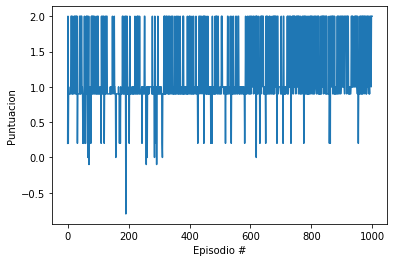

In [9]:
scores = dqn(smaller_agent_adam, env, n_episodes=1000)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Puntuacion')
plt.xlabel('Episodio #')
plt.show()

### Red más grande

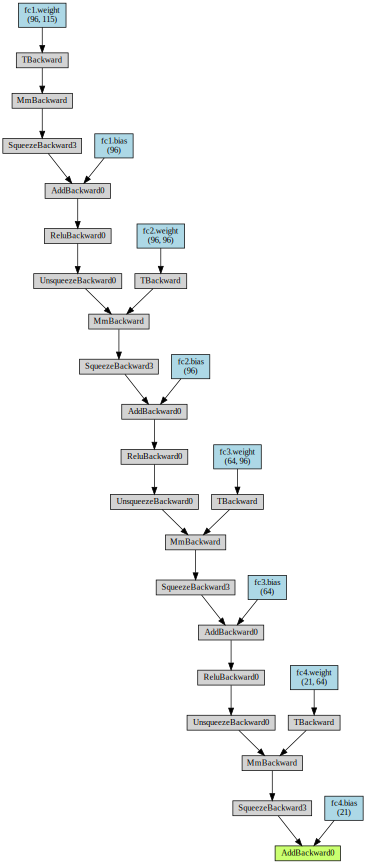

In [12]:
bigger_agent_adam = Agent(state_size=115, action_size=21, seed=0, network=BiggerNet, optim_fn='adam')

# Visualize the network
samp = torch.zeros(bigger_agent_adam.state_size)
out = bigger_agent_adam.qnetwork_local(samp)
make_dot(out, params=dict(bigger_agent_adam.qnetwork_local.named_parameters()))

Asímismo, se puede probar con una red más grande. Si el problema es más complejo, agregar parámetros a las capas, o incluso agregar más capas con activaciones no lineales, puede ayudar a generar una mejor representación de la tarea subjacente

I0816 15:01:08.696745 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:08.697754 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 187.9, gameFPS: 511.9
I0816 15:01:08.925564 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:01:08.926620 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:08.927235 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 68.9, gameFPS: 351.6


Episodio 2	Puntuacion media (ultimos 50):1.10

I0816 15:01:09.615487 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:09.619622 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 109.1, gameFPS: 491.5


Episodio 3	Puntuacion media (ultimos 50):0.80

I0816 15:01:10.558052 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:10.561753 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 72.5, gameFPS: 365.1


Episodio 4	Puntuacion media (ultimos 50):0.85

I0816 15:01:10.954705 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:10.955440 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 27, FPS: 70.2, gameFPS: 268.7


Episodio 5	Puntuacion media (ultimos 50):0.86

I0816 15:01:11.664475 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:11.670061 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 94.0, gameFPS: 301.0


Episodio 6	Puntuacion media (ultimos 50):0.87

I0816 15:01:12.304754 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:12.308664 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 86.2, gameFPS: 278.4


Episodio 7	Puntuacion media (ultimos 50):0.87

I0816 15:01:13.403879 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:13.411814 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 68.1, gameFPS: 303.7


Episodio 8	Puntuacion media (ultimos 50):0.88

I0816 15:01:13.745312 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:13.746439 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 22, FPS: 71.0, gameFPS: 277.8


Episodio 9	Puntuacion media (ultimos 50):0.88

I0816 15:01:14.695848 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:14.697429 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 90.2, gameFPS: 358.2


Episodio 10	Puntuacion media (ultimos 50):0.88

I0816 15:01:15.526571 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:15.533401 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 68.3, gameFPS: 297.8
I0816 15:01:15.849635 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:01:15.850788 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:15.851485 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 61.8, gameFPS: 362.7


Episodio 12	Puntuacion media (ultimos 50):0.98

I0816 15:01:16.094071 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:01:16.095047 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:16.095695 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 74.0, gameFPS: 353.2


Episodio 14	Puntuacion media (ultimos 50):1.04

I0816 15:01:18.021617 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:18.022598 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 100.9, gameFPS: 433.9


Episodio 15	Puntuacion media (ultimos 50):1.03

I0816 15:01:18.770940 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:18.772093 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 114.8, gameFPS: 503.9


Episodio 17	Puntuacion media (ultimos 50):0.98

I0816 15:01:20.353023 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:20.353951 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 89.3, gameFPS: 332.7


Episodio 18	Puntuacion media (ultimos 50):0.97

I0816 15:01:21.139548 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:21.144356 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 61, FPS: 78.9, gameFPS: 391.2


Episodio 19	Puntuacion media (ultimos 50):0.97

I0816 15:01:21.779462 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:21.780562 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 87.2, gameFPS: 323.8


Episodio 20	Puntuacion media (ultimos 50):0.97

I0816 15:01:22.476531 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:22.478003 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 81.4, gameFPS: 372.5


Episodio 22	Puntuacion media (ultimos 50):0.96

I0816 15:01:24.037754 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:24.038694 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 43, FPS: 83.0, gameFPS: 415.1


Episodio 24	Puntuacion media (ultimos 50):0.95

I0816 15:01:25.793985 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:25.797167 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 109.6, gameFPS: 483.8


Episodio 25	Puntuacion media (ultimos 50):0.92

I0816 15:01:26.074146 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:26.075027 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 74.4, gameFPS: 284.4


Episodio 26	Puntuacion media (ultimos 50):0.92

I0816 15:01:26.877928 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:26.881782 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 98.6, gameFPS: 377.6


Episodio 27	Puntuacion media (ultimos 50):0.91

I0816 15:01:27.101706 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:01:27.102696 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:27.106359 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 85.6, gameFPS: 697.0
I0816 15:01:27.311652 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:01:27.312856 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:27.313426 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 51.1, gameFPS: 248.2


Episodio 29	Puntuacion media (ultimos 50):0.99

I0816 15:01:28.278943 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:28.282344 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 60.7, gameFPS: 347.6


Episodio 30	Puntuacion media (ultimos 50):0.99

I0816 15:01:29.073233 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:29.074222 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 92.0, gameFPS: 403.1


Episodio 31	Puntuacion media (ultimos 50):0.98

I0816 15:01:30.412983 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:01:30.417566 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:30.423774 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 98, FPS: 74.3, gameFPS: 323.6


Episodio 32	Puntuacion media (ultimos 50):0.93

I0816 15:01:31.071684 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:31.073757 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 83.4, gameFPS: 361.3


Episodio 33	Puntuacion media (ultimos 50):0.93

I0816 15:01:31.917603 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:31.920888 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 83.8, gameFPS: 345.3


Episodio 34	Puntuacion media (ultimos 50):0.93

I0816 15:01:32.787811 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:32.791295 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 82.7, gameFPS: 353.2
I0816 15:01:32.994769 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:01:32.995956 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:32.996528 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 53.4, gameFPS: 269.0


Episodio 36	Puntuacion media (ultimos 50):0.94

I0816 15:01:33.353802 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:01:33.354771 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:33.355365 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 28.7, gameFPS: 192.5


Episodio 37	Puntuacion media (ultimos 50):0.96

I0816 15:01:34.119258 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:34.120077 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 113.3, gameFPS: 427.1
I0816 15:01:34.309390 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:01:34.310539 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:34.311343 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 54.8, gameFPS: 278.3


Episodio 39	Puntuacion media (ultimos 50):0.97

I0816 15:01:34.546220 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:01:34.547440 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:34.548299 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 66.8, gameFPS: 290.3


Episodio 40	Puntuacion media (ultimos 50):1.00

I0816 15:01:35.696253 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:01:35.697284 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:35.699739 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 70.0, gameFPS: 310.5


Episodio 42	Puntuacion media (ultimos 50):1.02

I0816 15:01:36.232350 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:36.235395 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 97.5, gameFPS: 371.5
I0816 15:01:36.419471 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:01:36.420775 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:36.421490 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 62.0, gameFPS: 305.0


Episodio 44	Puntuacion media (ultimos 50):1.04

I0816 15:01:37.358262 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:37.359738 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 93, FPS: 100.7, gameFPS: 474.4


Episodio 45	Puntuacion media (ultimos 50):1.04

I0816 15:01:38.215313 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:38.216229 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 93, FPS: 109.9, gameFPS: 444.6
I0816 15:01:38.447458 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:01:38.448682 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:38.449302 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 81.6, gameFPS: 415.6


Episodio 47	Puntuacion media (ultimos 50):1.06

I0816 15:01:39.097905 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:39.098991 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 98.4, gameFPS: 316.8


Episodio 50	Puntuacion media (50 anteriores): 1.05


I0816 15:01:41.373859 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:41.375249 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 98.4, gameFPS: 412.4


Episodio 51	Puntuacion media (ultimos 50):1.06

I0816 15:01:42.140190 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:42.141050 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 112.6, gameFPS: 500.9


Episodio 52	Puntuacion media (ultimos 50):1.04

I0816 15:01:42.813263 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:42.816433 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 112.0, gameFPS: 490.5


Episodio 53	Puntuacion media (ultimos 50):1.05

I0816 15:01:43.551168 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:43.552095 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 121.2, gameFPS: 531.2


Episodio 54	Puntuacion media (ultimos 50):1.05

I0816 15:01:43.921577 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:43.922361 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 41, FPS: 114.1, gameFPS: 589.8


Episodio 55	Puntuacion media (ultimos 50):1.05

I0816 15:01:44.596780 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:44.597754 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 104.3, gameFPS: 450.8


Episodio 56	Puntuacion media (ultimos 50):1.05

I0816 15:01:45.467380 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:01:45.468458 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:45.469044 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 96, FPS: 111.5, gameFPS: 416.5


Episodio 58	Puntuacion media (ultimos 50):1.02

I0816 15:01:46.531728 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:01:46.533036 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:46.533673 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 86.0, gameFPS: 428.0


Episodio 60	Puntuacion media (ultimos 50):1.04

I0816 15:01:48.098134 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:48.098994 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 109.0, gameFPS: 458.2


Episodio 62	Puntuacion media (ultimos 50):1.02

I0816 15:01:49.569511 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:49.570435 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 121.9, gameFPS: 545.1


Episodio 63	Puntuacion media (ultimos 50):1.00

I0816 15:01:50.145340 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:50.146204 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 99.0, gameFPS: 354.2


Episodio 64	Puntuacion media (ultimos 50):1.00

I0816 15:01:50.911597 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:50.914829 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 114.9, gameFPS: 503.2


Episodio 65	Puntuacion media (ultimos 50):1.00

I0816 15:01:51.682724 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:51.683735 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 110.5, gameFPS: 436.6


Episodio 66	Puntuacion media (ultimos 50):0.99

I0816 15:01:52.409565 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:52.410488 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 110.3, gameFPS: 450.2


Episodio 67	Puntuacion media (ultimos 50):0.99

I0816 15:01:53.091830 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:53.092812 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 116.4, gameFPS: 471.2
I0816 15:01:53.288946 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:01:53.290144 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:53.290841 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 69.2, gameFPS: 326.2


Episodio 69	Puntuacion media (ultimos 50):1.02

I0816 15:01:53.943785 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:53.944645 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 108.9, gameFPS: 450.0


Episodio 70	Puntuacion media (ultimos 50):1.02

I0816 15:01:54.930329 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:01:54.931536 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:54.932190 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 77.0, gameFPS: 363.9


Episodio 72	Puntuacion media (ultimos 50):1.04

I0816 15:01:55.371347 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:55.372262 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 45, FPS: 104.5, gameFPS: 470.6


Episodio 73	Puntuacion media (ultimos 50):1.04

I0816 15:01:55.970422 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:55.971587 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 120.9, gameFPS: 561.8


Episodio 75	Puntuacion media (ultimos 50):1.06

I0816 15:01:57.579824 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:57.580626 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 96, FPS: 121.1, gameFPS: 479.9
I0816 15:01:57.848608 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled


Episodio 76	Puntuacion media (ultimos 50):1.06

I0816 15:01:57.849667 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 73.6, gameFPS: 290.1


Episodio 77	Puntuacion media (ultimos 50):1.06

I0816 15:01:58.645210 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:58.646067 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 110.4, gameFPS: 450.6


Episodio 78	Puntuacion media (ultimos 50):1.02

I0816 15:01:58.936828 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:01:58.939529 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:01:58.940447 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 84.1, gameFPS: 404.8


Episodio 80	Puntuacion media (ultimos 50):1.02

I0816 15:02:00.354796 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:00.359238 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 59, FPS: 99.1, gameFPS: 333.3
I0816 15:02:00.593767 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:02:00.595149 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:00.595980 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 57.6, gameFPS: 271.3


Episodio 82	Puntuacion media (ultimos 50):1.08

I0816 15:02:01.319464 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:01.320263 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 115.0, gameFPS: 525.0


Episodio 83	Puntuacion media (ultimos 50):1.08

I0816 15:02:02.129262 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:02.130133 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 108.9, gameFPS: 402.6
I0816 15:02:02.328348 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:02:02.329475 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:02.330070 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 68.1, gameFPS: 312.5


Episodio 85	Puntuacion media (ultimos 50):1.11

I0816 15:02:03.093177 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:03.094138 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 113.9, gameFPS: 477.4


Episodio 86	Puntuacion media (ultimos 50):1.09

I0816 15:02:03.880533 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:03.881500 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 106.6, gameFPS: 393.1
I0816 15:02:04.136318 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:02:04.137531 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:04.138179 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 85.2, gameFPS: 404.8


Episodio 88	Puntuacion media (ultimos 50):1.11

I0816 15:02:04.973804 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:04.975181 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 94, FPS: 113.7, gameFPS: 457.6


Episodio 89	Puntuacion media (ultimos 50):1.08

I0816 15:02:05.669510 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:05.670459 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 93.3, gameFPS: 307.2


Episodio 90	Puntuacion media (ultimos 50):1.06

I0816 15:02:06.424458 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:06.427706 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 109.7, gameFPS: 473.4


Episodio 91	Puntuacion media (ultimos 50):1.06

I0816 15:02:06.660970 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:02:06.662055 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:06.662751 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 53.1, gameFPS: 284.5


Episodio 92	Puntuacion media (ultimos 50):1.06

I0816 15:02:07.368364 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:07.369467 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 105.1, gameFPS: 484.1


Episodio 93	Puntuacion media (ultimos 50):1.06

I0816 15:02:07.815706 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:07.816540 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 45, FPS: 102.8, gameFPS: 458.3


Episodio 95	Puntuacion media (ultimos 50):1.04

I0816 15:02:09.218307 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:09.219405 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 99.1, gameFPS: 400.9


Episodio 96	Puntuacion media (ultimos 50):1.04

I0816 15:02:09.730826 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:09.733296 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 100.8, gameFPS: 393.0
I0816 15:02:09.918387 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:02:09.919347 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:09.920006 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 56.9, gameFPS: 278.0


Episodio 98	Puntuacion media (ultimos 50):1.04

I0816 15:02:10.446518 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:10.448156 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 113.1, gameFPS: 481.5


Episodio 100	Puntuacion media (50 anteriores): 1.04
Episodio 101	Puntuacion media (ultimos 50):1.04

I0816 15:02:12.831112 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:12.832104 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 108.9, gameFPS: 455.2


Episodio 102	Puntuacion media (ultimos 50):1.03

I0816 15:02:13.520679 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:13.521667 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 125.4, gameFPS: 600.4


Episodio 103	Puntuacion media (ultimos 50):1.03

I0816 15:02:14.285473 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:14.286498 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 111.4, gameFPS: 451.7


Episodio 106	Puntuacion media (ultimos 50):1.03

I0816 15:02:16.812111 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:16.812962 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 112.1, gameFPS: 480.8


Episodio 108	Puntuacion media (ultimos 50):1.07

I0816 15:02:18.084923 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:18.085944 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 113.0, gameFPS: 478.4


Episodio 109	Puntuacion media (ultimos 50):1.05

I0816 15:02:18.590235 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:18.591097 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 105.8, gameFPS: 519.2


Episodio 110	Puntuacion media (ultimos 50):1.05

I0816 15:02:19.309759 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:19.311008 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 107.1, gameFPS: 412.0


Episodio 111	Puntuacion media (ultimos 50):1.05

I0816 15:02:20.103803 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:02:20.105041 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:20.105652 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 99, FPS: 125.8, gameFPS: 561.2


Episodio 114	Puntuacion media (ultimos 50):1.01

I0816 15:02:22.489432 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:22.490453 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 97, FPS: 126.1, gameFPS: 543.1


Episodio 115	Puntuacion media (ultimos 50):1.01

I0816 15:02:23.514649 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:02:23.515776 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:23.516401 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 83.7, gameFPS: 400.7


Episodio 117	Puntuacion media (ultimos 50):1.05

I0816 15:02:24.153836 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:24.154823 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 111.2, gameFPS: 483.4


Episodio 118	Puntuacion media (ultimos 50):1.04

I0816 15:02:25.163602 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:25.164509 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 73.0, gameFPS: 285.7


Episodio 122	Puntuacion media (ultimos 50):1.00

I0816 15:02:27.251089 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:27.252125 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 24, FPS: 86.4, gameFPS: 335.9


Episodio 123	Puntuacion media (ultimos 50):1.00

I0816 15:02:27.879128 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:27.880075 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 118.3, gameFPS: 515.1


Episodio 124	Puntuacion media (ultimos 50):1.00

I0816 15:02:28.528197 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:28.531197 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 122.6, gameFPS: 556.5


Episodio 126	Puntuacion media (ultimos 50):1.00

I0816 15:02:29.841388 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:29.843799 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 47, FPS: 103.4, gameFPS: 463.8
I0816 15:02:30.017270 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:02:30.018273 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:30.018867 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 59.6, gameFPS: 282.5


Episodio 129	Puntuacion media (ultimos 50):1.01

I0816 15:02:31.345190 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:31.346069 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 97.7, gameFPS: 390.9


Episodio 131	Puntuacion media (ultimos 50):1.01

I0816 15:02:32.887210 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:32.888138 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 106.7, gameFPS: 498.4
I0816 15:02:33.132683 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:33.133590 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 76.6, gameFPS: 301.1


Episodio 133	Puntuacion media (ultimos 50):0.99

I0816 15:02:33.845836 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:33.846901 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 113.6, gameFPS: 496.0


Episodio 134	Puntuacion media (ultimos 50):0.99

I0816 15:02:34.348387 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:34.349391 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 111.2, gameFPS: 495.2


Episodio 136	Puntuacion media (ultimos 50):0.98

I0816 15:02:35.849964 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:35.850751 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 119.9, gameFPS: 511.7


Episodio 137	Puntuacion media (ultimos 50):0.98

I0816 15:02:36.575812 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:36.576759 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 120.2, gameFPS: 530.0


Episodio 139	Puntuacion media (ultimos 50):0.94

I0816 15:02:38.187793 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:38.188695 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 90, FPS: 125.3, gameFPS: 557.5


Episodio 140	Puntuacion media (ultimos 50):0.94

I0816 15:02:38.908117 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:38.909016 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 120.9, gameFPS: 531.5


Episodio 141	Puntuacion media (ultimos 50):0.94

I0816 15:02:39.611874 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:39.612715 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 121.2, gameFPS: 525.2


Episodio 146	Puntuacion media (ultimos 50):0.89

I0816 15:02:43.467355 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:43.468323 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 119.1, gameFPS: 549.9


Episodio 148	Puntuacion media (ultimos 50):0.87

I0816 15:02:44.903506 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:44.904490 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 62, FPS: 110.6, gameFPS: 522.3


Episodio 149	Puntuacion media (ultimos 50):0.87

I0816 15:02:45.329786 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:45.330677 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 48, FPS: 115.5, gameFPS: 609.9
I0816 15:02:45.500943 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:02:45.501981 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:45.502628 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 56.0, gameFPS: 274.2


Episodio 150	Puntuacion media (50 anteriores): 0.87
Episodio 151	Puntuacion media (ultimos 50):0.89

I0816 15:02:46.234443 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:46.235371 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 110.7, gameFPS: 454.0


Episodio 152	Puntuacion media (ultimos 50):0.90

I0816 15:02:46.661524 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:46.662426 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 46, FPS: 111.0, gameFPS: 588.3


Episodio 153	Puntuacion media (ultimos 50):0.90

I0816 15:02:47.287047 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:47.287961 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 111.0, gameFPS: 415.3


Episodio 154	Puntuacion media (ultimos 50):0.90

I0816 15:02:47.875262 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:02:47.876235 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:47.876814 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 62, FPS: 108.5, gameFPS: 498.4


Episodio 155	Puntuacion media (ultimos 50):0.92

I0816 15:02:48.163029 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:02:48.164409 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:48.165195 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 84.8, gameFPS: 391.7


Episodio 157	Puntuacion media (ultimos 50):0.94

I0816 15:02:49.601795 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:49.602826 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 121.0, gameFPS: 570.2
I0816 15:02:49.865643 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:02:49.867024 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:49.867714 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 84.0, gameFPS: 392.4


Episodio 159	Puntuacion media (ultimos 50):0.95

I0816 15:02:50.394999 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:50.396074 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 98.8, gameFPS: 373.7
I0816 15:02:50.581620 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:02:50.582843 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:50.583456 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.0, gameFPS: 307.5


Episodio 161	Puntuacion media (ultimos 50):0.97

I0816 15:02:51.286437 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:51.287408 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 109.4, gameFPS: 484.2


Episodio 162	Puntuacion media (ultimos 50):1.00

I0816 15:02:52.150028 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:52.150968 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 96, FPS: 112.6, gameFPS: 467.1


Episodio 163	Puntuacion media (ultimos 50):1.00

I0816 15:02:52.474195 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:02:52.475156 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:52.475727 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 30, FPS: 96.6, gameFPS: 454.5


Episodio 164	Puntuacion media (ultimos 50):1.03

I0816 15:02:53.064265 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:53.065198 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 117.8, gameFPS: 546.7


Episodio 165	Puntuacion media (ultimos 50):1.01

I0816 15:02:53.744240 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:53.745311 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 125.8, gameFPS: 605.1


Episodio 167	Puntuacion media (ultimos 50):0.99

I0816 15:02:55.309334 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:55.310354 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 120.7, gameFPS: 487.6
I0816 15:02:55.549877 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:55.551211 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 71.2, gameFPS: 285.0


Episodio 169	Puntuacion media (ultimos 50):1.00

I0816 15:02:56.290339 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:56.291223 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 114.8, gameFPS: 551.7


Episodio 170	Puntuacion media (ultimos 50):0.99

I0816 15:02:56.901322 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:56.902243 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 120.0, gameFPS: 539.5


Episodio 171	Puntuacion media (ultimos 50):0.98

I0816 15:02:57.697967 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:57.698874 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 115.7, gameFPS: 431.9


Episodio 172	Puntuacion media (ultimos 50):0.96

I0816 15:02:58.365084 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:58.365970 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 106.4, gameFPS: 417.8


Episodio 173	Puntuacion media (ultimos 50):0.96

I0816 15:02:59.006291 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:02:59.007431 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 112.5, gameFPS: 498.9


Episodio 176	Puntuacion media (ultimos 50):0.94

I0816 15:03:01.487798 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:01.488652 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 107.0, gameFPS: 446.7


Episodio 177	Puntuacion media (ultimos 50):0.94

I0816 15:03:02.614049 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:02.614973 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 73.0, gameFPS: 282.4


Episodio 179	Puntuacion media (ultimos 50):0.92

I0816 15:03:03.446829 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:03.447607 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 95, FPS: 115.3, gameFPS: 517.7


Episodio 181	Puntuacion media (ultimos 50):0.92

I0816 15:03:04.961514 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:04.962488 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 111.1, gameFPS: 498.7


Episodio 182	Puntuacion media (ultimos 50):0.92

I0816 15:03:05.393540 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:05.394523 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 44, FPS: 104.0, gameFPS: 527.1


Episodio 183	Puntuacion media (ultimos 50):0.92

I0816 15:03:06.044593 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:06.045552 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 110.5, gameFPS: 491.6


Episodio 184	Puntuacion media (ultimos 50):0.92

I0816 15:03:06.804265 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:06.805138 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 113.9, gameFPS: 508.5


Episodio 185	Puntuacion media (ultimos 50):0.90

I0816 15:03:07.367835 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:07.368696 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 61, FPS: 110.2, gameFPS: 511.7


Episodio 186	Puntuacion media (ultimos 50):0.90

I0816 15:03:08.128680 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:08.129655 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 114.6, gameFPS: 517.3
I0816 15:03:08.306734 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:03:08.307769 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:08.308331 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 59.5, gameFPS: 288.7


Episodio 188	Puntuacion media (ultimos 50):0.94

I0816 15:03:08.974438 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:08.975319 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 109.7, gameFPS: 465.4


Episodio 189	Puntuacion media (ultimos 50):0.94

I0816 15:03:09.682314 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:09.683229 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 124.3, gameFPS: 587.5


Episodio 190	Puntuacion media (ultimos 50):0.94

I0816 15:03:10.358839 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:10.359858 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 107.8, gameFPS: 466.1


Episodio 191	Puntuacion media (ultimos 50):0.94

I0816 15:03:10.755821 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:10.756690 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 33, FPS: 85.6, gameFPS: 304.1


Episodio 192	Puntuacion media (ultimos 50):0.96

I0816 15:03:11.490133 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:11.493363 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 110.2, gameFPS: 471.2


Episodio 195	Puntuacion media (ultimos 50):0.97

I0816 15:03:14.025551 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:14.026512 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 113.1, gameFPS: 498.3


Episodio 196	Puntuacion media (ultimos 50):0.97

I0816 15:03:14.760575 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:14.761784 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 110.2, gameFPS: 494.5


Episodio 197	Puntuacion media (ultimos 50):0.97

I0816 15:03:15.401304 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:15.402259 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 118.7, gameFPS: 549.1
I0816 15:03:15.662131 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:15.662931 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 71.7, gameFPS: 276.0


Episodio 199	Puntuacion media (ultimos 50):0.97

I0816 15:03:16.253893 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:16.254819 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 118.4, gameFPS: 540.3


Episodio 200	Puntuacion media (50 anteriores): 0.97


I0816 15:03:16.851780 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:16.852793 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 117.8, gameFPS: 535.2


Episodio 201	Puntuacion media (ultimos 50):0.94

I0816 15:03:17.572272 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:17.573171 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 119.9, gameFPS: 523.6


Episodio 203	Puntuacion media (ultimos 50):0.94

I0816 15:03:19.056496 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:19.057440 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 126.0, gameFPS: 624.3


Episodio 204	Puntuacion media (ultimos 50):0.94

I0816 15:03:19.843977 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:19.845064 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 98, FPS: 126.4, gameFPS: 592.8


Episodio 205	Puntuacion media (ultimos 50):0.92

I0816 15:03:20.580813 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:20.581813 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 111.8, gameFPS: 526.7


Episodio 207	Puntuacion media (ultimos 50):0.90

I0816 15:03:22.127742 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:22.128758 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 123.8, gameFPS: 573.4


Episodio 208	Puntuacion media (ultimos 50):0.90

I0816 15:03:22.780427 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:22.781360 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 123.9, gameFPS: 617.4


Episodio 209	Puntuacion media (ultimos 50):0.88

I0816 15:03:23.477854 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:23.478830 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 109.2, gameFPS: 462.6


Episodio 213	Puntuacion media (ultimos 50):0.84

I0816 15:03:26.581905 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:26.582765 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 39, FPS: 95.8, gameFPS: 395.6


Episodio 214	Puntuacion media (ultimos 50):0.82

I0816 15:03:26.905332 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:26.906236 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 26, FPS: 82.7, gameFPS: 325.8


Episodio 215	Puntuacion media (ultimos 50):0.84

I0816 15:03:27.578412 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:27.579203 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 123.7, gameFPS: 603.3


Episodio 216	Puntuacion media (ultimos 50):0.84

I0816 15:03:28.215365 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:28.216153 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 118.3, gameFPS: 505.0


Episodio 219	Puntuacion media (ultimos 50):0.83

I0816 15:03:30.562961 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:30.563990 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 123.1, gameFPS: 538.5


Episodio 220	Puntuacion media (ultimos 50):0.83

I0816 15:03:31.299550 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:31.300471 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 123.1, gameFPS: 558.0


Episodio 221	Puntuacion media (ultimos 50):0.85

I0816 15:03:31.924008 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:31.924821 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 119.0, gameFPS: 529.8


Episodio 222	Puntuacion media (ultimos 50):0.86

I0816 15:03:32.836296 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:32.837293 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 99, FPS: 110.5, gameFPS: 436.3


Episodio 223	Puntuacion media (ultimos 50):0.85

I0816 15:03:33.284766 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:33.285690 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 45, FPS: 102.3, gameFPS: 411.2


Episodio 225	Puntuacion media (ultimos 50):0.86

I0816 15:03:35.092002 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:35.092882 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 95, FPS: 107.7, gameFPS: 417.9
I0816 15:03:35.256669 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:03:35.258077 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:35.258739 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 64.1, gameFPS: 322.9


Episodio 227	Puntuacion media (ultimos 50):0.89

I0816 15:03:35.919120 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:35.920095 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 109.1, gameFPS: 464.2


Episodio 228	Puntuacion media (ultimos 50):0.89

I0816 15:03:36.600921 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:36.604015 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 108.3, gameFPS: 453.5


Episodio 229	Puntuacion media (ultimos 50):0.89

I0816 15:03:37.154691 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:37.155677 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 57, FPS: 105.2, gameFPS: 457.8


Episodio 230	Puntuacion media (ultimos 50):0.88

I0816 15:03:37.587404 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:37.588544 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 43, FPS: 102.1, gameFPS: 489.8
I0816 15:03:37.829100 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:03:37.830215 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:37.830858 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 88.0, gameFPS: 424.5


Episodio 234	Puntuacion media (ultimos 50):0.91

I0816 15:03:40.383174 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:40.384504 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 109.1, gameFPS: 445.2


Episodio 236	Puntuacion media (ultimos 50):0.92

I0816 15:03:42.157182 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:42.159886 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 96, FPS: 110.9, gameFPS: 473.5


Episodio 237	Puntuacion media (ultimos 50):0.92

I0816 15:03:43.033583 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:43.034556 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 105.0, gameFPS: 394.3


Episodio 238	Puntuacion media (ultimos 50):0.90

I0816 15:03:43.922836 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:03:43.923870 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:43.924531 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 98, FPS: 111.1, gameFPS: 465.9


Episodio 239	Puntuacion media (ultimos 50):0.88

I0816 15:03:44.986300 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:03:44.987429 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:44.988117 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 60.1, gameFPS: 295.3


Episodio 241	Puntuacion media (ultimos 50):0.91

I0816 15:03:45.640367 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:45.641307 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 119.8, gameFPS: 524.7


Episodio 242	Puntuacion media (ultimos 50):0.91

I0816 15:03:46.452058 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:46.453112 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 99, FPS: 123.7, gameFPS: 553.5


Episodio 243	Puntuacion media (ultimos 50):0.91

I0816 15:03:47.095610 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:47.096634 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 118.3, gameFPS: 598.5


Episodio 244	Puntuacion media (ultimos 50):0.91

I0816 15:03:47.822756 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:47.823542 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 123.2, gameFPS: 599.6


Episodio 246	Puntuacion media (ultimos 50):0.91

I0816 15:03:49.444060 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:49.445116 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 108.7, gameFPS: 455.7


Episodio 247	Puntuacion media (ultimos 50):0.91

I0816 15:03:50.159099 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:50.160087 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 107.3, gameFPS: 422.3


Episodio 248	Puntuacion media (ultimos 50):0.91

I0816 15:03:50.870045 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:50.870905 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 108.5, gameFPS: 467.2


Episodio 249	Puntuacion media (ultimos 50):0.91

I0816 15:03:51.691518 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:03:51.692530 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:51.693144 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 90, FPS: 110.9, gameFPS: 449.7


Episodio 250	Puntuacion media (50 anteriores): 0.88


I0816 15:03:52.317957 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:52.318741 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 120.3, gameFPS: 561.0


Episodio 251	Puntuacion media (ultimos 50):0.88

I0816 15:03:52.966931 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:52.967896 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 111.0, gameFPS: 516.9


Episodio 252	Puntuacion media (ultimos 50):0.88

I0816 15:03:53.570025 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:53.571027 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 119.5, gameFPS: 569.1


Episodio 254	Puntuacion media (ultimos 50):0.88

I0816 15:03:55.098585 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:55.099572 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 62, FPS: 95.2, gameFPS: 315.5


Episodio 255	Puntuacion media (ultimos 50):0.88

I0816 15:03:55.763816 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:55.764657 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 105.3, gameFPS: 436.8


Episodio 256	Puntuacion media (ultimos 50):0.88

I0816 15:03:56.436710 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:56.437627 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 108.8, gameFPS: 470.2


Episodio 257	Puntuacion media (ultimos 50):0.88

I0816 15:03:57.008200 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:57.009184 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 116.2, gameFPS: 539.2


Episodio 258	Puntuacion media (ultimos 50):0.89

I0816 15:03:57.280944 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:03:57.282187 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:57.283335 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 25, FPS: 95.2, gameFPS: 455.9
I0816 15:03:57.496590 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:03:57.497610 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:57.499576 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 70.0, gameFPS: 327.4


Episodio 260	Puntuacion media (ultimos 50):0.93

I0816 15:03:58.167314 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:58.168282 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 125.1, gameFPS: 637.6


Episodio 261	Puntuacion media (ultimos 50):0.93

I0816 15:03:58.868615 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:58.869601 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 107.7, gameFPS: 445.3


Episodio 262	Puntuacion media (ultimos 50):0.93

I0816 15:03:59.395036 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:03:59.396112 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 98.9, gameFPS: 390.7


Episodio 264	Puntuacion media (ultimos 50):0.95

I0816 15:04:01.111698 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:01.112494 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 106.5, gameFPS: 473.6


Episodio 265	Puntuacion media (ultimos 50):0.95

I0816 15:04:01.765960 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:01.766857 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 120.8, gameFPS: 560.5


Episodio 267	Puntuacion media (ultimos 50):0.95

I0816 15:04:03.222202 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:03.223032 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 115.6, gameFPS: 496.5


Episodio 268	Puntuacion media (ultimos 50):0.95

I0816 15:04:03.837491 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:03.838392 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 121.1, gameFPS: 583.9


Episodio 269	Puntuacion media (ultimos 50):0.95

I0816 15:04:04.564743 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:04.565739 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 111.0, gameFPS: 490.8


Episodio 270	Puntuacion media (ultimos 50):0.97

I0816 15:04:05.016037 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:05.016969 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 36, FPS: 81.5, gameFPS: 357.3


Episodio 272	Puntuacion media (ultimos 50):0.97

I0816 15:04:06.809487 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:06.811694 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 86.5, gameFPS: 424.9


Episodio 273	Puntuacion media (ultimos 50):0.98

I0816 15:04:07.531785 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:07.532575 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 103.8, gameFPS: 436.7


Episodio 275	Puntuacion media (ultimos 50):0.98

I0816 15:04:09.227273 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:09.228168 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 107.6, gameFPS: 443.4


Episodio 276	Puntuacion media (ultimos 50):0.98

I0816 15:04:10.028518 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:10.029583 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 112.6, gameFPS: 513.0


Episodio 277	Puntuacion media (ultimos 50):0.96

I0816 15:04:10.785876 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:10.786863 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 113.8, gameFPS: 531.1


Episodio 278	Puntuacion media (ultimos 50):0.95

I0816 15:04:11.430804 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:11.431822 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 110.7, gameFPS: 500.6


Episodio 279	Puntuacion media (ultimos 50):0.93

I0816 15:04:12.080796 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:12.081928 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 118.9, gameFPS: 525.9


Episodio 280	Puntuacion media (ultimos 50):0.93

I0816 15:04:12.751802 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:12.752724 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 122.1, gameFPS: 606.9


Episodio 282	Puntuacion media (ultimos 50):0.91

I0816 15:04:14.225091 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:14.225973 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 109.8, gameFPS: 490.6


Episodio 283	Puntuacion media (ultimos 50):0.91

I0816 15:04:15.019832 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:15.020921 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 107.0, gameFPS: 457.6


Episodio 285	Puntuacion media (ultimos 50):0.91

I0816 15:04:16.552723 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:16.553800 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 87.0, gameFPS: 319.0


Episodio 286	Puntuacion media (ultimos 50):0.91

I0816 15:04:17.388520 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:17.389532 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 90, FPS: 108.7, gameFPS: 542.4
I0816 15:04:17.579261 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:04:17.580592 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:17.581467 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 56.3, gameFPS: 262.5


Episodio 289	Puntuacion media (ultimos 50):0.95

I0816 15:04:19.201081 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:04:19.202522 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:19.204719 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 50.6, gameFPS: 207.5


Episodio 290	Puntuacion media (ultimos 50):0.97

I0816 15:04:19.939696 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:19.940809 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 112.0, gameFPS: 600.0


Episodio 291	Puntuacion media (ultimos 50):0.94

I0816 15:04:20.445354 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:20.446337 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 103.1, gameFPS: 425.8


Episodio 293	Puntuacion media (ultimos 50):0.93

I0816 15:04:22.465516 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:22.466602 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 83.6, gameFPS: 386.0


Episodio 294	Puntuacion media (ultimos 50):0.93

I0816 15:04:23.434646 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:23.435689 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 96, FPS: 100.3, gameFPS: 379.7


Episodio 295	Puntuacion media (ultimos 50):0.93

I0816 15:04:24.234576 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:24.235739 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 101.2, gameFPS: 533.1


Episodio 296	Puntuacion media (ultimos 50):0.93

I0816 15:04:25.320553 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:25.326014 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 99, FPS: 92.1, gameFPS: 477.4


Episodio 297	Puntuacion media (ultimos 50):0.93

I0816 15:04:26.115700 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:26.116677 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 95.7, gameFPS: 455.9


Episodio 300	Puntuacion media (50 anteriores): 0.97


I0816 15:04:29.001565 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:29.005011 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 95.0, gameFPS: 345.9


Episodio 302	Puntuacion media (ultimos 50):0.97

I0816 15:04:30.895660 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:30.898935 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 90, FPS: 97.7, gameFPS: 429.9


Episodio 305	Puntuacion media (ultimos 50):0.97

I0816 15:04:33.499869 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:33.501033 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 90.7, gameFPS: 414.4


Episodio 306	Puntuacion media (ultimos 50):0.97

I0816 15:04:34.394892 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:34.396079 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 93.2, gameFPS: 498.7


Episodio 307	Puntuacion media (ultimos 50):0.97

I0816 15:04:35.257908 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:35.261226 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 97.4, gameFPS: 444.5


Episodio 308	Puntuacion media (ultimos 50):0.97

I0816 15:04:36.290199 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:04:36.291444 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:36.292103 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 99, FPS: 97.5, gameFPS: 421.4


Episodio 309	Puntuacion media (ultimos 50):0.93

I0816 15:04:37.055537 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:37.056416 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 108.9, gameFPS: 508.4


Episodio 311	Puntuacion media (ultimos 50):0.91

I0816 15:04:38.766927 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:38.772387 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 94.8, gameFPS: 486.1


Episodio 312	Puntuacion media (ultimos 50):0.91

I0816 15:04:39.558418 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:39.559426 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 110.1, gameFPS: 528.9


Episodio 313	Puntuacion media (ultimos 50):0.91

I0816 15:04:39.848878 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:04:39.850095 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:39.850671 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 25, FPS: 88.2, gameFPS: 440.6


Episodio 316	Puntuacion media (ultimos 50):0.93

I0816 15:04:42.749495 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:42.750293 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 109.5, gameFPS: 551.6


Episodio 317	Puntuacion media (ultimos 50):0.93

I0816 15:04:43.499218 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:43.500197 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 102.1, gameFPS: 384.4


Episodio 318	Puntuacion media (ultimos 50):0.93

I0816 15:04:44.389891 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:44.393697 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 90, FPS: 102.4, gameFPS: 495.9


Episodio 319	Puntuacion media (ultimos 50):0.93

I0816 15:04:45.304735 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:45.305595 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 89.1, gameFPS: 379.5


Episodio 320	Puntuacion media (ultimos 50):0.93

I0816 15:04:46.079163 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:46.080159 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 91.1, gameFPS: 412.1


Episodio 322	Puntuacion media (ultimos 50):0.93

I0816 15:04:47.501693 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:04:47.502732 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:47.503322 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 30, FPS: 84.1, gameFPS: 453.8


Episodio 324	Puntuacion media (ultimos 50):0.95

I0816 15:04:48.919437 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:48.920364 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 33, FPS: 86.4, gameFPS: 374.5


Episodio 325	Puntuacion media (ultimos 50):0.95

I0816 15:04:49.325993 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:49.326912 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 35, FPS: 88.3, gameFPS: 372.5


Episodio 326	Puntuacion media (ultimos 50):0.95

I0816 15:04:50.257414 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:50.258371 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 94, FPS: 101.8, gameFPS: 494.1


Episodio 327	Puntuacion media (ultimos 50):0.96

I0816 15:04:51.033079 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:51.033991 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 97.8, gameFPS: 471.1


Episodio 328	Puntuacion media (ultimos 50):0.97

I0816 15:04:51.722405 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:51.723348 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 104.7, gameFPS: 461.6


Episodio 329	Puntuacion media (ultimos 50):0.99

I0816 15:04:52.594392 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:52.595277 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 99.8, gameFPS: 519.3


Episodio 331	Puntuacion media (ultimos 50):0.97

I0816 15:04:54.349757 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:54.350652 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 99.2, gameFPS: 444.0


Episodio 332	Puntuacion media (ultimos 50):0.97

I0816 15:04:55.215039 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:55.215870 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 96, FPS: 113.0, gameFPS: 506.7


Episodio 334	Puntuacion media (ultimos 50):0.97

I0816 15:04:56.979270 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:56.980222 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 104.2, gameFPS: 425.1


Episodio 335	Puntuacion media (ultimos 50):0.97

I0816 15:04:57.678628 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:57.679523 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 121.5, gameFPS: 577.5


Episodio 336	Puntuacion media (ultimos 50):0.97

I0816 15:04:58.526324 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:04:58.529392 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 105.0, gameFPS: 450.4


Episodio 338	Puntuacion media (ultimos 50):0.95

I0816 15:05:00.262030 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:00.262998 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 106.2, gameFPS: 527.1


Episodio 340	Puntuacion media (ultimos 50):0.93

I0816 15:05:01.526404 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:01.532283 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:01.535373 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 22, FPS: 78.8, gameFPS: 382.1


Episodio 341	Puntuacion media (ultimos 50):0.97

I0816 15:05:02.074028 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:02.075008 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 49, FPS: 92.9, gameFPS: 458.4


Episodio 342	Puntuacion media (ultimos 50):0.97

I0816 15:05:02.399975 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:02.401172 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:02.401885 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 72.8, gameFPS: 351.3


Episodio 343	Puntuacion media (ultimos 50):0.99

I0816 15:05:03.101301 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:03.102212 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 101.3, gameFPS: 499.4


Episodio 344	Puntuacion media (ultimos 50):0.99

I0816 15:05:03.484069 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:03.485212 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:03.485832 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 30, FPS: 80.1, gameFPS: 449.0


Episodio 345	Puntuacion media (ultimos 50):1.01

I0816 15:05:04.420895 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:04.424278 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 97, FPS: 104.8, gameFPS: 454.8


Episodio 346	Puntuacion media (ultimos 50):1.01

I0816 15:05:05.190565 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:05.198136 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 105.6, gameFPS: 513.8


Episodio 347	Puntuacion media (ultimos 50):1.01

I0816 15:05:06.193742 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:06.194618 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 95, FPS: 97.4, gameFPS: 418.1


Episodio 348	Puntuacion media (ultimos 50):1.01

I0816 15:05:06.489339 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:06.490528 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:06.491171 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 80.1, gameFPS: 384.8


Episodio 349	Puntuacion media (ultimos 50):1.03

I0816 15:05:07.098117 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:07.098897 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 91.7, gameFPS: 390.3


Episodio 350	Puntuacion media (50 anteriores): 1.03


I0816 15:05:07.608630 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:07.609818 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:07.610497 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 43, FPS: 86.5, gameFPS: 456.7


Episodio 351	Puntuacion media (ultimos 50):1.05

I0816 15:05:08.398320 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:08.399288 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 103.1, gameFPS: 451.2


Episodio 352	Puntuacion media (ultimos 50):1.05

I0816 15:05:09.043859 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:09.044945 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 61, FPS: 95.7, gameFPS: 383.9


Episodio 355	Puntuacion media (ultimos 50):1.05

I0816 15:05:11.613773 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:11.614816 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 100.1, gameFPS: 402.5


Episodio 356	Puntuacion media (ultimos 50):1.05

I0816 15:05:12.336047 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:12.336996 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 119.3, gameFPS: 610.9


Episodio 357	Puntuacion media (ultimos 50):1.04

I0816 15:05:13.146514 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:13.147385 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 97, FPS: 121.5, gameFPS: 566.2


Episodio 359	Puntuacion media (ultimos 50):1.06

I0816 15:05:15.562939 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:15.564230 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 63.1, gameFPS: 267.5


Episodio 360	Puntuacion media (ultimos 50):1.06

I0816 15:05:16.098874 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:16.100292 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 26, FPS: 49.8, gameFPS: 241.1


Episodio 361	Puntuacion media (ultimos 50):1.06

I0816 15:05:16.958710 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:16.962289 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 80.6, gameFPS: 408.2


Episodio 362	Puntuacion media (ultimos 50):1.06

I0816 15:05:17.751637 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:17.752539 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 102.7, gameFPS: 450.6
I0816 15:05:17.917900 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:17.919000 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:17.919696 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 64.6, gameFPS: 340.9


Episodio 365	Puntuacion media (ultimos 50):1.06

I0816 15:05:19.870730 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:19.871712 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 113.8, gameFPS: 539.6


Episodio 368	Puntuacion media (ultimos 50):1.05

I0816 15:05:22.044658 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:22.045785 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:22.046369 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 25, FPS: 79.0, gameFPS: 369.8


Episodio 369	Puntuacion media (ultimos 50):1.07

I0816 15:05:22.888148 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:22.889057 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 109.4, gameFPS: 497.4


Episodio 371	Puntuacion media (ultimos 50):1.07

I0816 15:05:24.589704 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:24.590724 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 110.7, gameFPS: 492.5


Episodio 372	Puntuacion media (ultimos 50):1.07

I0816 15:05:25.129471 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:25.130224 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 94.6, gameFPS: 394.6


Episodio 373	Puntuacion media (ultimos 50):1.05

I0816 15:05:25.837957 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:25.838757 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 105.7, gameFPS: 456.2


Episodio 376	Puntuacion media (ultimos 50):1.05

I0816 15:05:28.262001 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:28.262817 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 101.3, gameFPS: 361.6
I0816 15:05:28.450231 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:28.451315 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:28.451973 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 55.9, gameFPS: 279.1


Episodio 378	Puntuacion media (ultimos 50):1.07

I0816 15:05:29.019186 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:29.020387 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:29.020967 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 56, FPS: 100.7, gameFPS: 502.4


Episodio 379	Puntuacion media (ultimos 50):1.09

I0816 15:05:29.869212 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:29.870318 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 104.9, gameFPS: 493.9


Episodio 380	Puntuacion media (ultimos 50):1.10

I0816 15:05:30.600687 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:30.601639 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 109.3, gameFPS: 506.7


Episodio 381	Puntuacion media (ultimos 50):1.10

I0816 15:05:31.292803 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:31.293791 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 110.5, gameFPS: 550.6


Episodio 382	Puntuacion media (ultimos 50):1.11

I0816 15:05:31.506245 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:31.507307 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:31.507934 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.8, gameFPS: 277.7
I0816 15:05:31.728918 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:31.729960 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:31.730529 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 47.4, gameFPS: 265.3


Episodio 384	Puntuacion media (ultimos 50):1.15

I0816 15:05:32.017372 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:32.018382 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:32.018928 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 43.3, gameFPS: 265.2
I0816 15:05:32.299776 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:32.300558 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 14, FPS: 55.9, gameFPS: 211.6


Episodio 386	Puntuacion media (ultimos 50):1.17

I0816 15:05:33.193074 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:33.193933 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 97.5, gameFPS: 458.6
I0816 15:05:33.457155 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:33.458374 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:33.458989 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 22, FPS: 85.8, gameFPS: 419.0


Episodio 388	Puntuacion media (ultimos 50):1.18

I0816 15:05:34.300443 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:34.303772 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 96, FPS: 116.2, gameFPS: 529.7


Episodio 389	Puntuacion media (ultimos 50):1.18

I0816 15:05:34.655765 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:34.656665 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:34.657320 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 30, FPS: 88.1, gameFPS: 442.3


Episodio 391	Puntuacion media (ultimos 50):1.18

I0816 15:05:35.808628 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:35.811481 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:35.812106 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 84.6, gameFPS: 604.0


Episodio 392	Puntuacion media (ultimos 50):1.20

I0816 15:05:36.561394 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:36.562366 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 104.3, gameFPS: 440.2


Episodio 395	Puntuacion media (ultimos 50):1.16

I0816 15:05:39.034993 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:39.035907 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 110.9, gameFPS: 523.2


Episodio 396	Puntuacion media (ultimos 50):1.16

I0816 15:05:39.348264 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:39.349548 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:39.350260 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 25, FPS: 83.5, gameFPS: 342.5


Episodio 398	Puntuacion media (ultimos 50):1.18

I0816 15:05:40.582195 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:40.583262 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 38, FPS: 91.5, gameFPS: 374.9
I0816 15:05:40.845081 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:40.846233 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled


Episodio 399	Puntuacion media (ultimos 50):1.16

I0816 15:05:40.847490 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 90.2, gameFPS: 445.3


Episodio 400	Puntuacion media (50 anteriores): 1.18


I0816 15:05:41.136878 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:41.137915 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:41.138551 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 83.5, gameFPS: 393.7


Episodio 401	Puntuacion media (ultimos 50):1.18

I0816 15:05:41.459211 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:41.461792 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:41.462646 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 26, FPS: 83.4, gameFPS: 359.4


Episodio 402	Puntuacion media (ultimos 50):1.21

I0816 15:05:41.731796 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:41.732958 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:41.733629 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 88.5, gameFPS: 446.1


Episodio 403	Puntuacion media (ultimos 50):1.23

I0816 15:05:42.295705 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:42.296916 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:42.297600 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 57, FPS: 103.0, gameFPS: 530.8


Episodio 404	Puntuacion media (ultimos 50):1.25

I0816 15:05:42.523763 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:42.525093 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:42.525740 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 71.2, gameFPS: 344.5


Episodio 406	Puntuacion media (ultimos 50):1.27

I0816 15:05:44.093562 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:44.094642 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 105.4, gameFPS: 461.3


Episodio 407	Puntuacion media (ultimos 50):1.29

I0816 15:05:44.389176 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:44.389968 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 21, FPS: 73.1, gameFPS: 293.2


Episodio 408	Puntuacion media (ultimos 50):1.28

I0816 15:05:44.866693 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:44.868040 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:44.869022 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 51, FPS: 109.6, gameFPS: 558.7


Episodio 410	Puntuacion media (ultimos 50):1.31

I0816 15:05:46.131814 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:46.132714 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 34, FPS: 92.0, gameFPS: 379.6
I0816 15:05:46.359833 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:46.360797 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 15, FPS: 68.6, gameFPS: 272.8


Episodio 412	Puntuacion media (ultimos 50):1.31

I0816 15:05:46.992662 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:46.993474 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 59, FPS: 95.6, gameFPS: 450.0


Episodio 413	Puntuacion media (ultimos 50):1.31

I0816 15:05:47.711393 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:47.712294 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 119.6, gameFPS: 581.3
I0816 15:05:47.900785 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:47.902003 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:47.902651 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.9, gameFPS: 344.7


Episodio 415	Puntuacion media (ultimos 50):1.31

I0816 15:05:48.125380 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:48.126577 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:48.127166 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 67.7, gameFPS: 297.5
I0816 15:05:48.286335 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:48.287670 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:48.288361 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 59.5, gameFPS: 292.2


Episodio 417	Puntuacion media (ultimos 50):1.36

I0816 15:05:48.614231 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:48.615882 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:48.616517 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 28, FPS: 87.9, gameFPS: 402.3


Episodio 419	Puntuacion media (ultimos 50):1.36

I0816 15:05:49.798233 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:49.799454 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:49.800101 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 86.4, gameFPS: 477.0


Episodio 420	Puntuacion media (ultimos 50):1.38

I0816 15:05:50.063243 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:50.064361 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:50.065007 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 82.1, gameFPS: 390.8


Episodio 421	Puntuacion media (ultimos 50):1.40

I0816 15:05:50.644336 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:50.645343 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 91.8, gameFPS: 343.8
I0816 15:05:50.855002 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:50.856134 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:50.856727 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.8, gameFPS: 284.0


Episodio 424	Puntuacion media (ultimos 50):1.43

I0816 15:05:52.526374 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:52.527994 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 102.6, gameFPS: 458.9


Episodio 425	Puntuacion media (ultimos 50):1.43

I0816 15:05:52.889446 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:52.890767 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:52.893501 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 30, FPS: 86.3, gameFPS: 426.3


Episodio 426	Puntuacion media (ultimos 50):1.45

I0816 15:05:53.690454 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:53.691329 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 104.6, gameFPS: 495.8
I0816 15:05:53.870466 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:53.871789 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:53.872436 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 59.8, gameFPS: 312.7


Episodio 428	Puntuacion media (ultimos 50):1.45

I0816 15:05:54.089817 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:54.090539 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 11, FPS: 52.6, gameFPS: 192.9
I0816 15:05:54.282811 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:54.283914 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:54.284897 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.8, gameFPS: 322.6


Episodio 430	Puntuacion media (ultimos 50):1.43

I0816 15:05:55.191595 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:55.192705 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 99.2, gameFPS: 389.7


Episodio 431	Puntuacion media (ultimos 50):1.43

I0816 15:05:55.502396 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:55.503324 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:55.503911 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 80.6, gameFPS: 356.4
I0816 15:05:55.755814 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:55.756694 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 14, FPS: 58.0, gameFPS: 212.5


Episodio 433	Puntuacion media (ultimos 50):1.41

I0816 15:05:55.954169 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:55.955203 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:55.955811 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 69.0, gameFPS: 350.4
I0816 15:05:56.218585 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:56.219452 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 72.0, gameFPS: 287.0


Episodio 434	Puntuacion media (ultimos 50):1.41

I0816 15:05:56.433306 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:56.434565 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:56.435364 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.9, gameFPS: 300.4


Episodio 436	Puntuacion media (ultimos 50):1.41

I0816 15:05:56.693364 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:56.694161 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 14, FPS: 56.0, gameFPS: 216.7
I0816 15:05:56.934684 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:56.937149 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:56.938125 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 64.5, gameFPS: 320.2


Episodio 438	Puntuacion media (ultimos 50):1.42

I0816 15:05:57.163713 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:57.164851 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:57.165490 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 65.5, gameFPS: 311.7


Episodio 441	Puntuacion media (ultimos 50):1.42

I0816 15:05:59.260313 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:59.261303 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 72.8, gameFPS: 301.0
I0816 15:05:59.464404 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:59.465580 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:59.466235 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.3, gameFPS: 300.7


Episodio 443	Puntuacion media (ultimos 50):1.42

I0816 15:05:59.669095 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:59.670451 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:59.671143 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.5, gameFPS: 279.9
I0816 15:05:59.874742 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:05:59.876096 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:05:59.876771 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.1, gameFPS: 298.3


Episodio 445	Puntuacion media (ultimos 50):1.46

I0816 15:06:00.086472 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:00.087663 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:00.088240 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 64.4, gameFPS: 277.9
I0816 15:06:00.266330 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:00.267502 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:00.268155 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 64.4, gameFPS: 311.4


Episodio 447	Puntuacion media (ultimos 50):1.48

I0816 15:06:00.533858 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:00.535179 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:00.535799 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 78.1, gameFPS: 366.1
I0816 15:06:00.744180 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:00.745328 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:00.748596 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 82.1, gameFPS: 624.0


Episodio 448	Puntuacion media (ultimos 50):1.50

I0816 15:06:00.970731 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:00.971914 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:00.972606 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.1, gameFPS: 287.6


Episodio 450	Puntuacion media (50 anteriores): 1.52


I0816 15:06:01.156697 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:01.157880 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:01.158460 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 56.7, gameFPS: 271.6
I0816 15:06:01.353730 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:01.354950 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:01.355919 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.3, gameFPS: 290.9


Episodio 452	Puntuacion media (ultimos 50):1.52

I0816 15:06:01.558283 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:01.559318 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:01.559962 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.5, gameFPS: 272.2


Episodio 453	Puntuacion media (ultimos 50):1.52

I0816 15:06:02.239361 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:02.240249 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 103.3, gameFPS: 453.6
I0816 15:06:02.503088 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:02.504007 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 67.2, gameFPS: 276.6


Episodio 455	Puntuacion media (ultimos 50):1.46

I0816 15:06:02.716279 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:02.717525 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:02.718255 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.7, gameFPS: 279.7
I0816 15:06:02.897104 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:02.898498 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:02.899352 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 58.4, gameFPS: 270.8


Episodio 457	Puntuacion media (ultimos 50):1.50

I0816 15:06:03.088808 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:03.090059 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:03.090810 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.4, gameFPS: 341.4
I0816 15:06:03.241110 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:03.242590 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:03.244784 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 64.1, gameFPS: 579.8


Episodio 459	Puntuacion media (ultimos 50):1.52

I0816 15:06:03.531885 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:03.532753 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 73.0, gameFPS: 299.9


Episodio 460	Puntuacion media (ultimos 50):1.52

I0816 15:06:03.827972 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:03.829123 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 70.0, gameFPS: 265.2
I0816 15:06:04.079086 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:04.080245 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:04.081550 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 85.8, gameFPS: 603.0


Episodio 462	Puntuacion media (ultimos 50):1.54

I0816 15:06:04.363383 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:04.364324 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 74.7, gameFPS: 300.8
I0816 15:06:04.586413 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:04.587443 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 13, FPS: 60.6, gameFPS: 253.9


Episodio 464	Puntuacion media (ultimos 50):1.54

I0816 15:06:04.851491 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:04.852568 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:04.853565 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 82.1, gameFPS: 404.0
I0816 15:06:05.083272 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:05.089533 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:05.090737 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 39.6, gameFPS: 377.4


Episodio 466	Puntuacion media (ultimos 50):1.54

I0816 15:06:05.382291 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:05.383274 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:05.383886 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 44.4, gameFPS: 285.0


Episodio 467	Puntuacion media (ultimos 50):1.54

I0816 15:06:05.612609 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:05.613762 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:05.614533 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 72.6, gameFPS: 457.1


Episodio 468	Puntuacion media (ultimos 50):1.54

I0816 15:06:05.899553 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:05.900480 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 57.5, gameFPS: 237.1


Episodio 469	Puntuacion media (ultimos 50):1.54

I0816 15:06:06.141789 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:06.143055 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:06.143674 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 67.9, gameFPS: 326.2


Episodio 470	Puntuacion media (ultimos 50):1.54

I0816 15:06:06.389454 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:06.390443 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:06.391099 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 38.0, gameFPS: 220.0
I0816 15:06:06.606023 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:06.607255 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:06.608095 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 62.0, gameFPS: 295.1


Episodio 472	Puntuacion media (ultimos 50):1.56

I0816 15:06:06.835099 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:06.836242 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:06.836987 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.4, gameFPS: 255.7
I0816 15:06:07.064809 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:07.066191 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:07.066918 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.8, gameFPS: 291.1


Episodio 474	Puntuacion media (ultimos 50):1.58

I0816 15:06:07.336139 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:07.337349 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:07.337983 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 45.6, gameFPS: 257.5


Episodio 475	Puntuacion media (ultimos 50):1.60

I0816 15:06:07.622141 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:07.623410 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 73.4, gameFPS: 270.7


Episodio 476	Puntuacion media (ultimos 50):1.58

I0816 15:06:08.444251 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:08.445236 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 91.1, gameFPS: 436.9
I0816 15:06:08.709794 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:08.710570 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 63.7, gameFPS: 236.4


Episodio 478	Puntuacion media (ultimos 50):1.56

I0816 15:06:09.993175 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:09.994712 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:09.995792 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 54.8, gameFPS: 300.5


Episodio 480	Puntuacion media (ultimos 50):1.58

I0816 15:06:10.203630 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:10.204792 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:10.205407 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 46.2, gameFPS: 223.6


Episodio 481	Puntuacion media (ultimos 50):1.60

I0816 15:06:10.792155 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:10.792936 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 35, FPS: 60.6, gameFPS: 280.1
I0816 15:06:11.039095 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:11.040178 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:11.041779 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 50.0, gameFPS: 252.2


Episodio 483	Puntuacion media (ultimos 50):1.61

I0816 15:06:11.281738 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:11.282715 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:11.283278 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 57.1, gameFPS: 345.9
I0816 15:06:11.492560 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:11.493715 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:11.494364 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.5, gameFPS: 293.9


Episodio 486	Puntuacion media (ultimos 50):1.62

I0816 15:06:12.763180 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:12.764791 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:12.767762 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 36.9, gameFPS: 133.5
I0816 15:06:12.956995 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:12.958053 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:12.958725 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 60.8, gameFPS: 337.3


Episodio 488	Puntuacion media (ultimos 50):1.64

I0816 15:06:13.159116 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:13.160278 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:13.161155 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.8, gameFPS: 291.1
I0816 15:06:13.352897 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:13.354272 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:13.354919 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.8, gameFPS: 320.0


Episodio 490	Puntuacion media (ultimos 50):1.66

I0816 15:06:13.557715 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:13.558868 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:13.559495 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.4, gameFPS: 306.3


Episodio 491	Puntuacion media (ultimos 50):1.68

I0816 15:06:13.836851 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:13.838007 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 71.3, gameFPS: 282.6


Episodio 492	Puntuacion media (ultimos 50):1.68

I0816 15:06:14.526140 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:14.527174 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 100.4, gameFPS: 421.0
I0816 15:06:14.719947 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:14.721042 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:14.722115 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.0, gameFPS: 310.2


Episodio 494	Puntuacion media (ultimos 50):1.66

I0816 15:06:14.936625 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:14.937685 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:14.938376 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 49.2, gameFPS: 241.3


Episodio 495	Puntuacion media (ultimos 50):1.66

I0816 15:06:15.294117 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:15.295686 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:15.302567 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 34.5, gameFPS: 167.4


Episodio 496	Puntuacion media (ultimos 50):1.66

I0816 15:06:15.704587 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:15.706250 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:15.707187 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 39.9, gameFPS: 314.7
I0816 15:06:15.901379 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:15.902462 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:15.905114 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 51.7, gameFPS: 248.1


Episodio 498	Puntuacion media (ultimos 50):1.66

I0816 15:06:16.220667 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:16.221904 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:16.222735 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 33.6, gameFPS: 229.7
I0816 15:06:16.439012 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:16.440602 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:16.447118 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 77.2, gameFPS: 563.8


Episodio 500	Puntuacion media (50 anteriores): 1.66


I0816 15:06:16.696708 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:16.697487 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 14, FPS: 58.6, gameFPS: 233.5


Episodio 501	Puntuacion media (ultimos 50):1.64

I0816 15:06:17.037032 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:17.038800 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:17.040002 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 37.1, gameFPS: 165.3
I0816 15:06:17.259837 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:17.261144 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:17.261734 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.8, gameFPS: 300.7


Episodio 503	Puntuacion media (ultimos 50):1.64

I0816 15:06:17.658689 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:17.660978 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 49.1, gameFPS: 164.3
I0816 15:06:17.896104 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:17.897207 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:17.897859 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.0, gameFPS: 295.2


Episodio 505	Puntuacion media (ultimos 50):1.67

I0816 15:06:18.220867 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:18.223170 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:18.223912 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 44.8, gameFPS: 185.3
I0816 15:06:18.490128 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:18.491303 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:18.492040 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 52.0, gameFPS: 459.4


Episodio 507	Puntuacion media (ultimos 50):1.67

I0816 15:06:18.705708 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:18.706793 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:18.707378 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.7, gameFPS: 266.2
I0816 15:06:18.899452 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:18.900651 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:18.901535 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.0, gameFPS: 346.2


Episodio 509	Puntuacion media (ultimos 50):1.67

I0816 15:06:19.163201 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:19.164340 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:19.165308 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 76.3, gameFPS: 363.3
I0816 15:06:19.392129 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:19.393946 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:19.394707 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 72.8, gameFPS: 342.4


Episodio 511	Puntuacion media (ultimos 50):1.72

I0816 15:06:19.663179 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:19.664582 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:19.665646 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 50.3, gameFPS: 274.3
I0816 15:06:19.849504 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:19.851043 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:19.851868 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 56.3, gameFPS: 252.9


Episodio 513	Puntuacion media (ultimos 50):1.74

I0816 15:06:20.056924 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:20.057985 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:20.066340 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 45.4, gameFPS: 481.7
I0816 15:06:20.339957 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:20.341166 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:20.341777 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 50.3, gameFPS: 278.4


Episodio 514	Puntuacion media (ultimos 50):1.76

I0816 15:06:20.556628 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:20.557639 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:20.558162 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.8, gameFPS: 258.7


Episodio 516	Puntuacion media (ultimos 50):1.76

I0816 15:06:20.779535 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:20.780611 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:20.781248 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 67.3, gameFPS: 326.9
I0816 15:06:20.986523 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:20.987537 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:20.988137 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.8, gameFPS: 294.8


Episodio 518	Puntuacion media (ultimos 50):1.76

I0816 15:06:21.203480 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:21.204591 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:21.205234 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.0, gameFPS: 290.0


Episodio 519	Puntuacion media (ultimos 50):1.78

I0816 15:06:21.525629 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:21.526772 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 51.5, gameFPS: 192.9


Episodio 520	Puntuacion media (ultimos 50):1.76

I0816 15:06:21.875473 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:21.876735 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 50.0, gameFPS: 209.1
I0816 15:06:22.106321 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:22.107522 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:22.108164 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 55.9, gameFPS: 304.2


Episodio 522	Puntuacion media (ultimos 50):1.74

I0816 15:06:22.371760 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:22.372879 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:22.373451 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 59.0, gameFPS: 267.5
I0816 15:06:22.589498 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:22.590593 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:22.591512 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 63.6, gameFPS: 303.6


Episodio 524	Puntuacion media (ultimos 50):1.74

I0816 15:06:22.884707 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:22.885829 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 21, FPS: 73.8, gameFPS: 297.8


Episodio 525	Puntuacion media (ultimos 50):1.72

I0816 15:06:23.170456 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:23.171268 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 62.5, gameFPS: 218.2


Episodio 526	Puntuacion media (ultimos 50):1.72

I0816 15:06:23.548623 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:23.549594 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 44.3, gameFPS: 174.5


Episodio 527	Puntuacion media (ultimos 50):1.72

I0816 15:06:23.882578 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:23.883377 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 50.7, gameFPS: 185.9


Episodio 528	Puntuacion media (ultimos 50):1.72

I0816 15:06:24.197867 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:24.198680 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 52.6, gameFPS: 213.6
I0816 15:06:24.424505 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:24.426219 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:24.428650 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 46.3, gameFPS: 233.6


Episodio 530	Puntuacion media (ultimos 50):1.72

I0816 15:06:24.648760 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:24.649921 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:24.650592 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.9, gameFPS: 260.6


Episodio 531	Puntuacion media (ultimos 50):1.72

I0816 15:06:24.875215 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:24.876511 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:24.880817 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.8, gameFPS: 253.9
I0816 15:06:25.082377 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:25.083400 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:25.084185 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 52.1, gameFPS: 250.4


Episodio 533	Puntuacion media (ultimos 50):1.74

I0816 15:06:25.359424 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:25.360339 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 72.2, gameFPS: 313.7


Episodio 534	Puntuacion media (ultimos 50):1.72

I0816 15:06:25.691463 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:25.694115 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 63.0, gameFPS: 202.4


Episodio 535	Puntuacion media (ultimos 50):1.69

I0816 15:06:26.093690 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:26.096039 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:26.097841 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 40.7, gameFPS: 236.1


Episodio 536	Puntuacion media (ultimos 50):1.71

I0816 15:06:26.893440 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:26.894272 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 88.2, gameFPS: 378.3
I0816 15:06:27.152633 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:27.153592 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:27.154246 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 64.9, gameFPS: 334.0


Episodio 538	Puntuacion media (ultimos 50):1.69

I0816 15:06:27.383978 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:27.385154 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:27.386059 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.8, gameFPS: 285.2
I0816 15:06:27.593699 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:27.594919 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:27.595531 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.0, gameFPS: 298.5


Episodio 540	Puntuacion media (ultimos 50):1.69

I0816 15:06:27.844226 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:27.845423 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:27.846001 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 82.9, gameFPS: 465.2


Episodio 541	Puntuacion media (ultimos 50):1.69

I0816 15:06:28.613789 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:28.614810 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 112.5, gameFPS: 576.0
I0816 15:06:28.814320 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:28.815823 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:28.816509 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.3, gameFPS: 312.5


Episodio 543	Puntuacion media (ultimos 50):1.70

I0816 15:06:29.010138 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:29.012157 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:29.013155 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 53.4, gameFPS: 247.2


Episodio 544	Puntuacion media (ultimos 50):1.70

I0816 15:06:29.274967 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:29.276422 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:29.277166 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 47.3, gameFPS: 262.9
I0816 15:06:29.457528 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:29.458657 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:29.459288 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 58.2, gameFPS: 280.2


Episodio 546	Puntuacion media (ultimos 50):1.70

I0816 15:06:29.647825 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:29.648735 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:29.649319 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 50.5, gameFPS: 238.8
I0816 15:06:29.845111 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:29.846403 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:29.847083 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.6, gameFPS: 355.2


Episodio 548	Puntuacion media (ultimos 50):1.70

I0816 15:06:30.077935 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:30.079092 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:30.079726 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.4, gameFPS: 277.1
I0816 15:06:30.289580 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:30.290703 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:30.291562 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 64.8, gameFPS: 300.3


Episodio 550	Puntuacion media (50 anteriores): 1.70


I0816 15:06:30.522429 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:30.523736 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:30.524439 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 46.8, gameFPS: 212.8


Episodio 551	Puntuacion media (ultimos 50):1.72

I0816 15:06:30.819148 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:30.820612 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:30.821257 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 42.7, gameFPS: 205.8


Episodio 552	Puntuacion media (ultimos 50):1.72

I0816 15:06:31.087387 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:31.088999 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:31.089886 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 52.8, gameFPS: 284.7
I0816 15:06:31.350856 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:31.352011 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:31.352865 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 52.1, gameFPS: 226.2


Episodio 554	Puntuacion media (ultimos 50):1.74

I0816 15:06:31.682868 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:31.683984 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:31.684930 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 39.7, gameFPS: 248.8
I0816 15:06:31.892122 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:31.894234 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:31.897230 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 50.5, gameFPS: 214.0


Episodio 556	Puntuacion media (ultimos 50):1.74

I0816 15:06:32.235490 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:32.236634 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:32.237499 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 36.3, gameFPS: 257.8
I0816 15:06:32.450040 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:32.451447 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:32.456032 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.4, gameFPS: 258.6


Episodio 558	Puntuacion media (ultimos 50):1.74

I0816 15:06:32.821745 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:32.822966 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:32.823596 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 38.8, gameFPS: 228.5
I0816 15:06:33.052546 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:33.054220 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:33.057068 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 58.7, gameFPS: 220.1


Episodio 560	Puntuacion media (ultimos 50):1.74

I0816 15:06:33.367093 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:33.368076 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:33.368657 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 40.4, gameFPS: 240.9
I0816 15:06:33.603378 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:33.608066 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:33.617401 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 52.5, gameFPS: 200.1


Episodio 562	Puntuacion media (ultimos 50):1.74

I0816 15:06:33.951811 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:33.953056 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:33.953767 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 37.3, gameFPS: 283.0


Episodio 563	Puntuacion media (ultimos 50):1.74

I0816 15:06:34.202536 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:34.203448 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:34.204031 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 66.3, gameFPS: 301.4
I0816 15:06:34.481233 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:34.482407 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 65.0, gameFPS: 267.4


Episodio 564	Puntuacion media (ultimos 50):1.74

I0816 15:06:34.637811 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:34.639975 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:34.640733 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 60.3, gameFPS: 554.5


Episodio 566	Puntuacion media (ultimos 50):1.72

I0816 15:06:34.891075 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:34.892878 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:34.893724 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 79.3, gameFPS: 418.8


Episodio 567	Puntuacion media (ultimos 50):1.72

I0816 15:06:35.130611 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:35.131745 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:35.132531 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 53.4, gameFPS: 267.7
I0816 15:06:35.334374 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:35.335398 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:35.336021 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.6, gameFPS: 286.8


Episodio 569	Puntuacion media (ultimos 50):1.72

I0816 15:06:35.525516 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:35.526984 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:35.529753 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 55.2, gameFPS: 232.5
I0816 15:06:35.733067 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:35.734149 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:35.734702 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.8, gameFPS: 285.1


Episodio 571	Puntuacion media (ultimos 50):1.77

I0816 15:06:35.962381 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:35.963824 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:35.965198 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 55.2, gameFPS: 274.2
I0816 15:06:36.158607 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:36.159762 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:36.160443 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.3, gameFPS: 320.6


Episodio 573	Puntuacion media (ultimos 50):1.77

I0816 15:06:36.377957 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:36.379212 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:36.379825 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 62.1, gameFPS: 327.8
I0816 15:06:36.576416 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:36.577751 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:36.578476 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.3, gameFPS: 293.5


Episodio 575	Puntuacion media (ultimos 50):1.79

I0816 15:06:36.809369 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:36.810476 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:36.811279 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 53.6, gameFPS: 247.5


Episodio 576	Puntuacion media (ultimos 50):1.81

I0816 15:06:37.026991 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:37.028110 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:37.029028 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.3, gameFPS: 266.3
I0816 15:06:37.227473 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:37.228804 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:37.229410 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.6, gameFPS: 332.9


Episodio 578	Puntuacion media (ultimos 50):1.85

I0816 15:06:37.464658 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:37.465847 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:37.466538 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 57.1, gameFPS: 259.7


Episodio 579	Puntuacion media (ultimos 50):1.88

I0816 15:06:37.713240 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:37.714674 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:37.719277 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 55.3, gameFPS: 293.5
I0816 15:06:37.913074 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:37.914197 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:37.914867 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 59.4, gameFPS: 292.2


Episodio 581	Puntuacion media (ultimos 50):1.88

I0816 15:06:38.166593 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:38.168191 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:38.174932 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 66.6, gameFPS: 306.4


Episodio 582	Puntuacion media (ultimos 50):1.88

I0816 15:06:38.396616 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:38.397673 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:38.398818 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.9, gameFPS: 285.7
I0816 15:06:38.614558 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:38.616182 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:38.617218 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.1, gameFPS: 295.5


Episodio 584	Puntuacion media (ultimos 50):1.90

I0816 15:06:38.849085 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:38.850389 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:38.851110 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.9, gameFPS: 309.9
I0816 15:06:39.039538 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:39.040858 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:39.041429 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.5, gameFPS: 335.7


Episodio 586	Puntuacion media (ultimos 50):1.92

I0816 15:06:39.234709 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:39.235826 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:39.236913 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.6, gameFPS: 327.9
I0816 15:06:39.457808 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:39.459156 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:39.460151 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 71.4, gameFPS: 322.1


Episodio 588	Puntuacion media (ultimos 50):1.94

I0816 15:06:39.690042 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:39.690900 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 14, FPS: 64.5, gameFPS: 250.4
I0816 15:06:39.890565 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:39.891663 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:39.892915 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 68.0, gameFPS: 314.1


Episodio 590	Puntuacion media (ultimos 50):1.92

I0816 15:06:40.640840 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:40.641900 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 108.4, gameFPS: 498.4


Episodio 591	Puntuacion media (ultimos 50):1.88

I0816 15:06:40.935429 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:40.936332 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 62.3, gameFPS: 219.2
I0816 15:06:41.136974 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:41.138217 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:41.138859 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 53.3, gameFPS: 283.9


Episodio 593	Puntuacion media (ultimos 50):1.90

I0816 15:06:41.327413 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:41.328691 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:41.329509 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.2, gameFPS: 339.5
I0816 15:06:41.522971 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:41.524775 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:41.525489 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.8, gameFPS: 350.2


Episodio 595	Puntuacion media (ultimos 50):1.90

I0816 15:06:41.745211 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:41.746355 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:41.749881 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 84.6, gameFPS: 619.2


Episodio 596	Puntuacion media (ultimos 50):1.90

I0816 15:06:41.979144 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:41.980427 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:41.981292 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 72.3, gameFPS: 338.9
I0816 15:06:42.173635 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:42.174758 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:42.176288 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.7, gameFPS: 345.2


Episodio 598	Puntuacion media (ultimos 50):1.90

I0816 15:06:42.377557 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:42.378922 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:42.379605 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 67.4, gameFPS: 311.7
I0816 15:06:42.589293 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:42.590399 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:42.591071 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.5, gameFPS: 287.8


Episodio 600	Puntuacion media (50 anteriores): 1.90


I0816 15:06:42.782593 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:42.783700 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:42.784263 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 54.7, gameFPS: 253.2
I0816 15:06:42.969629 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:42.970587 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:42.971144 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.6, gameFPS: 308.8


Episodio 602	Puntuacion media (ultimos 50):1.90

I0816 15:06:43.145774 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:43.146855 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:43.147512 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 54.7, gameFPS: 257.8
I0816 15:06:43.340154 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:43.341278 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:43.342037 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.7, gameFPS: 334.9


Episodio 604	Puntuacion media (ultimos 50):1.90

I0816 15:06:43.536696 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:43.537664 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:43.538257 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.0, gameFPS: 313.0
I0816 15:06:43.753236 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:43.754584 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:43.755243 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 67.2, gameFPS: 291.5


Episodio 606	Puntuacion media (ultimos 50):1.90

I0816 15:06:44.024852 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:44.025977 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:44.026598 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 22, FPS: 83.5, gameFPS: 398.0
I0816 15:06:44.224488 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:44.225703 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:44.226531 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.9, gameFPS: 296.5


Episodio 608	Puntuacion media (ultimos 50):1.90

I0816 15:06:44.407345 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:44.408640 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:44.409294 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 57.6, gameFPS: 296.3


Episodio 609	Puntuacion media (ultimos 50):1.90

I0816 15:06:45.124633 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:45.125615 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 100.5, gameFPS: 392.3
I0816 15:06:45.317133 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:45.318236 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:45.318982 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.0, gameFPS: 306.0


Episodio 611	Puntuacion media (ultimos 50):1.88

I0816 15:06:45.547868 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:45.548998 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:45.552018 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.4, gameFPS: 250.0


Episodio 612	Puntuacion media (ultimos 50):1.88

I0816 15:06:45.812069 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:45.813210 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:45.813991 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 52.1, gameFPS: 250.8
I0816 15:06:46.026478 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled


Episodio 613	Puntuacion media (ultimos 50):1.88

I0816 15:06:46.027757 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:46.028613 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.0, gameFPS: 293.6
I0816 15:06:46.218657 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:46.219568 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:46.220223 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 57.2, gameFPS: 270.0


Episodio 615	Puntuacion media (ultimos 50):1.90

I0816 15:06:46.421152 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:46.422333 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:46.422998 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.1, gameFPS: 282.4


Episodio 616	Puntuacion media (ultimos 50):1.90

I0816 15:06:46.709023 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:46.709891 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 73.0, gameFPS: 296.6
I0816 15:06:46.948970 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:46.950238 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:46.951084 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 69.9, gameFPS: 367.2


Episodio 618	Puntuacion media (ultimos 50):1.88

I0816 15:06:47.204504 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:47.205278 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 69.0, gameFPS: 265.9
I0816 15:06:47.436564 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:47.437656 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:47.438293 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 73.8, gameFPS: 352.6


Episodio 620	Puntuacion media (ultimos 50):1.85

I0816 15:06:47.693707 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:47.694476 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 65.8, gameFPS: 259.6
I0816 15:06:47.893256 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:47.894328 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:47.894936 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.3, gameFPS: 292.6


Episodio 622	Puntuacion media (ultimos 50):1.83

I0816 15:06:48.119861 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:48.120849 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:48.121493 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 55.6, gameFPS: 254.8
I0816 15:06:48.376755 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:48.377680 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:48.378334 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 48.7, gameFPS: 286.0


Episodio 624	Puntuacion media (ultimos 50):1.83

I0816 15:06:48.653288 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:48.654228 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 71.8, gameFPS: 284.0
I0816 15:06:48.861801 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:48.862998 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:48.863739 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.3, gameFPS: 292.5


Episodio 626	Puntuacion media (ultimos 50):1.81

I0816 15:06:49.128644 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:49.129678 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 66.6, gameFPS: 275.1
I0816 15:06:49.338724 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:49.339721 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:49.340364 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 66.1, gameFPS: 314.6


Episodio 628	Puntuacion media (ultimos 50):1.79

I0816 15:06:49.610625 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:49.611416 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 64.9, gameFPS: 271.8
I0816 15:06:49.812159 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:49.813215 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:49.813769 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.8, gameFPS: 273.1


Episodio 630	Puntuacion media (ultimos 50):1.77

I0816 15:06:50.013725 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:50.014969 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:50.015643 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.2, gameFPS: 297.9


Episodio 631	Puntuacion media (ultimos 50):1.77

I0816 15:06:50.299858 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:50.300889 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 68.9, gameFPS: 288.2
I0816 15:06:50.500680 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:50.502429 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:50.503480 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.9, gameFPS: 307.8


Episodio 633	Puntuacion media (ultimos 50):1.74

I0816 15:06:50.711228 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:50.712325 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:50.713135 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.8, gameFPS: 292.2


Episodio 634	Puntuacion media (ultimos 50):1.74

I0816 15:06:51.000736 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:51.001757 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 68.4, gameFPS: 294.9
I0816 15:06:51.196252 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:51.197335 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:51.197926 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.2, gameFPS: 305.0


Episodio 636	Puntuacion media (ultimos 50):1.72

I0816 15:06:51.416948 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:51.418378 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:51.419233 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.9, gameFPS: 270.8
I0816 15:06:51.599238 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:51.600336 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:51.602368 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 58.2, gameFPS: 263.1


Episodio 638	Puntuacion media (ultimos 50):1.72

I0816 15:06:51.891059 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:51.892090 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:51.895975 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 67.9, gameFPS: 576.7


Episodio 639	Puntuacion media (ultimos 50):1.74

I0816 15:06:52.190187 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:52.191495 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 67.8, gameFPS: 268.6
I0816 15:06:52.388886 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:52.389874 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:52.390461 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.4, gameFPS: 289.3


Episodio 641	Puntuacion media (ultimos 50):1.76

I0816 15:06:52.631469 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:52.632902 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:52.633700 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 51.6, gameFPS: 286.2


Episodio 642	Puntuacion media (ultimos 50):1.78

I0816 15:06:52.925663 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:52.926602 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 71.2, gameFPS: 298.9


Episodio 643	Puntuacion media (ultimos 50):1.76

I0816 15:06:53.277103 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:53.278081 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:53.278642 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 35.3, gameFPS: 167.2
I0816 15:06:53.484881 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:53.486262 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:53.486936 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.1, gameFPS: 295.0


Episodio 645	Puntuacion media (ultimos 50):1.76

I0816 15:06:53.713916 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:53.715066 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:53.715735 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.8, gameFPS: 275.4


Episodio 647	Puntuacion media (ultimos 50):1.72

I0816 15:06:55.017084 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:55.021189 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:55.023872 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 33.8, gameFPS: 190.9
I0816 15:06:55.241176 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:55.242261 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:55.243181 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.0, gameFPS: 321.6


Episodio 649	Puntuacion media (ultimos 50):1.72

I0816 15:06:55.479289 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:55.480384 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:55.481066 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 57.7, gameFPS: 285.5
I0816 15:06:55.697267 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:55.698622 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:55.700928 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.6, gameFPS: 273.5


Episodio 650	Puntuacion media (50 anteriores): 1.72
Episodio 651	Puntuacion media (ultimos 50):1.72

I0816 15:06:55.940357 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:55.941356 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:55.941956 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 53.0, gameFPS: 265.4
I0816 15:06:56.145606 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:56.146746 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:56.147348 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.7, gameFPS: 293.5


Episodio 653	Puntuacion media (ultimos 50):1.72

I0816 15:06:56.364914 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:56.366351 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:56.367013 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 63.1, gameFPS: 309.0


Episodio 654	Puntuacion media (ultimos 50):1.72

I0816 15:06:56.714892 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:56.715749 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 47.2, gameFPS: 153.5


Episodio 655	Puntuacion media (ultimos 50):1.70

I0816 15:06:57.009821 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:57.011042 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:57.017359 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 42.8, gameFPS: 254.4
I0816 15:06:57.272654 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:57.275879 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:57.276617 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 48.9, gameFPS: 231.7


Episodio 657	Puntuacion media (ultimos 50):1.70

I0816 15:06:57.500697 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:57.501774 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:57.502370 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.0, gameFPS: 299.5
I0816 15:06:57.748229 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:57.749284 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 72.8, gameFPS: 286.9


Episodio 659	Puntuacion media (ultimos 50):1.68

I0816 15:06:57.944582 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:57.945681 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:57.946306 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.5, gameFPS: 321.7


Episodio 660	Puntuacion media (ultimos 50):1.70

I0816 15:06:58.179427 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:58.180942 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:58.181771 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 62.4, gameFPS: 309.7
I0816 15:06:58.377890 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:58.379806 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:58.380491 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.9, gameFPS: 350.3


Episodio 662	Puntuacion media (ultimos 50):1.70

I0816 15:06:58.632661 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:58.633947 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:58.634670 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 49.1, gameFPS: 213.5


Episodio 663	Puntuacion media (ultimos 50):1.70

I0816 15:06:58.936286 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:58.939941 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:58.949113 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 40.6, gameFPS: 151.1
I0816 15:06:59.193304 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:59.194415 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:59.195084 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.5, gameFPS: 267.3


Episodio 665	Puntuacion media (ultimos 50):1.70

I0816 15:06:59.515384 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:59.518043 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:59.519406 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 38.3, gameFPS: 179.2


Episodio 666	Puntuacion media (ultimos 50):1.70

I0816 15:06:59.907440 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:06:59.908561 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:06:59.909231 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 32.3, gameFPS: 196.8


Episodio 667	Puntuacion media (ultimos 50):1.72

I0816 15:07:00.197132 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:00.198778 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:00.199646 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 35.6, gameFPS: 142.0
I0816 15:07:00.473086 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:00.474139 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:00.475199 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 46.4, gameFPS: 280.5


Episodio 669	Puntuacion media (ultimos 50):1.74

I0816 15:07:00.782540 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:00.783448 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:00.784129 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 40.4, gameFPS: 171.4
I0816 15:07:01.029972 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:01.031415 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:01.032154 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 50.6, gameFPS: 343.4


Episodio 671	Puntuacion media (ultimos 50):1.77

I0816 15:07:01.195502 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:01.196538 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:01.200646 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 60.1, gameFPS: 560.4
I0816 15:07:01.387004 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:01.388085 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:01.388747 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.0, gameFPS: 357.8


Episodio 673	Puntuacion media (ultimos 50):1.77

I0816 15:07:01.538263 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:01.539282 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:01.543969 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 63.5, gameFPS: 571.3
I0816 15:07:01.747816 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:01.748943 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:01.749611 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 66.7, gameFPS: 307.3


Episodio 674	Puntuacion media (ultimos 50):1.77

I0816 15:07:01.958169 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:01.959077 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:01.960265 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.0, gameFPS: 287.4


Episodio 676	Puntuacion media (ultimos 50):1.79

I0816 15:07:03.126388 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:03.127365 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:03.127937 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.9, gameFPS: 283.0


Episodio 677	Puntuacion media (ultimos 50):1.79

I0816 15:07:03.349157 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:03.350373 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:03.350994 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.0, gameFPS: 291.7


Episodio 679	Puntuacion media (ultimos 50):1.81

I0816 15:07:03.553510 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:03.554676 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:03.555238 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.8, gameFPS: 285.6
I0816 15:07:03.772376 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:03.773480 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:03.774409 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.7, gameFPS: 285.6


Episodio 681	Puntuacion media (ultimos 50):1.81

I0816 15:07:04.002411 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:04.003544 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:04.004131 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 55.7, gameFPS: 262.2
I0816 15:07:04.210060 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:04.211178 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:04.211776 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.1, gameFPS: 300.8


Episodio 683	Puntuacion media (ultimos 50):1.83

I0816 15:07:04.405940 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:04.407875 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:04.408708 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.9, gameFPS: 298.3
I0816 15:07:04.617287 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:04.618517 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:04.619493 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 65.5, gameFPS: 308.3


Episodio 685	Puntuacion media (ultimos 50):1.85

I0816 15:07:04.821145 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:04.822325 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:04.822876 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.0, gameFPS: 293.1
I0816 15:07:05.078240 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:05.079176 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 64.8, gameFPS: 242.8


Episodio 686	Puntuacion media (ultimos 50):1.85

I0816 15:07:05.281083 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:05.282224 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:05.283087 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 68.2, gameFPS: 381.6


Episodio 688	Puntuacion media (ultimos 50):1.83

I0816 15:07:05.606991 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:05.607779 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 14, FPS: 44.9, gameFPS: 183.4
I0816 15:07:05.812960 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:05.814181 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:05.814894 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 70.5, gameFPS: 391.9


Episodio 690	Puntuacion media (ultimos 50):1.81

I0816 15:07:06.007724 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:06.009096 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:06.009773 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.9, gameFPS: 322.5
I0816 15:07:06.193267 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:06.194356 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:06.195084 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.6, gameFPS: 341.3


Episodio 692	Puntuacion media (ultimos 50):1.81

I0816 15:07:06.391477 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:06.392592 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:06.393249 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.4, gameFPS: 298.1
I0816 15:07:06.610957 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:06.612036 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:06.612591 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 66.9, gameFPS: 305.4


Episodio 694	Puntuacion media (ultimos 50):1.84

I0816 15:07:06.849141 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:06.850392 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:06.850968 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 70.8, gameFPS: 323.4
I0816 15:07:07.046354 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:07.047725 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:07.048429 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.9, gameFPS: 319.6


Episodio 696	Puntuacion media (ultimos 50):1.84

I0816 15:07:07.288635 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:07.289673 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:07.290287 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 52.0, gameFPS: 282.3
I0816 15:07:07.491080 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:07.492198 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:07.493183 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.4, gameFPS: 293.5


Episodio 698	Puntuacion media (ultimos 50):1.87

I0816 15:07:07.685685 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:07.686757 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:07.687360 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 55.4, gameFPS: 300.1
I0816 15:07:07.876393 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:07.877329 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:07.877990 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.3, gameFPS: 308.4


Episodio 700	Puntuacion media (50 anteriores): 1.87


I0816 15:07:08.113969 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:08.115100 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:08.115882 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.6, gameFPS: 293.0
I0816 15:07:08.359897 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:08.363941 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:08.365088 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 50.1, gameFPS: 240.1


Episodio 702	Puntuacion media (ultimos 50):1.87

I0816 15:07:08.810935 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:08.811890 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:08.812856 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 31.5, gameFPS: 219.5


Episodio 703	Puntuacion media (ultimos 50):1.87

I0816 15:07:09.119219 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:09.124020 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:09.125991 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 39.6, gameFPS: 158.7


Episodio 704	Puntuacion media (ultimos 50):1.87

I0816 15:07:09.448078 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:09.449378 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:09.450107 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 44.1, gameFPS: 242.9


Episodio 705	Puntuacion media (ultimos 50):1.89

I0816 15:07:09.766908 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:09.768525 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:09.769280 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 39.8, gameFPS: 177.4


Episodio 706	Puntuacion media (ultimos 50):1.89

I0816 15:07:10.040793 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:10.041969 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:10.042547 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 46.4, gameFPS: 264.6
I0816 15:07:10.312381 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:10.313426 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:10.314011 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 81.5, gameFPS: 415.9


Episodio 708	Puntuacion media (ultimos 50):1.89

I0816 15:07:11.169512 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:11.170300 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 104.9, gameFPS: 465.2
I0816 15:07:11.386530 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled


Episodio 709	Puntuacion media (ultimos 50):1.89

I0816 15:07:11.389745 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:11.391175 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.4, gameFPS: 298.9
I0816 15:07:11.601169 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:11.602240 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:11.604850 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 55.1, gameFPS: 272.6


Episodio 711	Puntuacion media (ultimos 50):1.89

I0816 15:07:11.865700 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:11.866668 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 15, FPS: 59.6, gameFPS: 239.2
I0816 15:07:12.062719 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:12.063949 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:12.065213 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.5, gameFPS: 297.5


Episodio 713	Puntuacion media (ultimos 50):1.87

I0816 15:07:12.268090 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:12.269145 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:12.269790 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.5, gameFPS: 295.2
I0816 15:07:12.455678 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:12.457047 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:12.457931 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 57.4, gameFPS: 259.5


Episodio 715	Puntuacion media (ultimos 50):1.87

I0816 15:07:12.685025 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:12.686226 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:12.686918 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.7, gameFPS: 256.2
I0816 15:07:12.903298 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:12.904457 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:12.905126 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.4, gameFPS: 300.3


Episodio 717	Puntuacion media (ultimos 50):1.87

I0816 15:07:13.123372 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:13.124451 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:13.125032 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.4, gameFPS: 298.6
I0816 15:07:13.327359 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:13.328541 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:13.329170 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.6, gameFPS: 293.6


Episodio 719	Puntuacion media (ultimos 50):1.87

I0816 15:07:13.535528 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:13.536649 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:13.537281 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.6, gameFPS: 294.7
I0816 15:07:13.780811 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:13.781947 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:13.782912 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 50.8, gameFPS: 257.8


Episodio 721	Puntuacion media (ultimos 50):1.87

I0816 15:07:14.016421 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:14.017427 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:14.018550 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 53.2, gameFPS: 285.4
I0816 15:07:14.253451 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:14.254622 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:14.255293 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 53.6, gameFPS: 267.0


Episodio 723	Puntuacion media (ultimos 50):1.87

I0816 15:07:14.463979 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:14.465158 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:14.466477 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.7, gameFPS: 302.1


Episodio 724	Puntuacion media (ultimos 50):1.87

I0816 15:07:14.700647 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:14.701984 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:14.702781 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 53.7, gameFPS: 283.8
I0816 15:07:14.920290 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:14.921260 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:14.921907 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.3, gameFPS: 285.5


Episodio 726	Puntuacion media (ultimos 50):1.87

I0816 15:07:15.149784 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:15.150944 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:15.152052 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.8, gameFPS: 255.2
I0816 15:07:15.360397 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:15.361618 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:15.362572 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.5, gameFPS: 292.0


Episodio 728	Puntuacion media (ultimos 50):1.89

I0816 15:07:15.578991 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:15.580248 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:15.583759 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.6, gameFPS: 267.8
I0816 15:07:15.788859 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:15.789980 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:15.790535 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.3, gameFPS: 335.8


Episodio 730	Puntuacion media (ultimos 50):1.89

I0816 15:07:16.007254 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:16.008519 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:16.009172 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.6, gameFPS: 274.4
I0816 15:07:16.227913 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:16.229345 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:16.230214 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.0, gameFPS: 281.1


Episodio 732	Puntuacion media (ultimos 50):1.89

I0816 15:07:16.447980 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:16.449010 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:16.449884 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.0, gameFPS: 262.2
I0816 15:07:16.643935 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:16.645209 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:16.645860 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 71.2, gameFPS: 344.7


Episodio 734	Puntuacion media (ultimos 50):1.89

I0816 15:07:16.846116 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:16.847312 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:16.847991 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.6, gameFPS: 291.9
I0816 15:07:17.035430 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:17.036410 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:17.037360 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 61.5, gameFPS: 271.2


Episodio 736	Puntuacion media (ultimos 50):1.89

I0816 15:07:17.242312 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:17.243512 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:17.244189 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.8, gameFPS: 314.8
I0816 15:07:17.452857 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:17.453773 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:17.454326 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.8, gameFPS: 283.1


Episodio 738	Puntuacion media (ultimos 50):1.92

I0816 15:07:17.706776 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:17.707754 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:17.708324 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 66.8, gameFPS: 330.9


Episodio 739	Puntuacion media (ultimos 50):1.96

I0816 15:07:17.934655 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:17.935909 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:17.936776 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 55.4, gameFPS: 252.1
I0816 15:07:18.150108 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:18.151332 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:18.151994 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.7, gameFPS: 309.2


Episodio 741	Puntuacion media (ultimos 50):1.96

I0816 15:07:18.374775 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:18.376030 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:18.376808 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.2, gameFPS: 280.8
I0816 15:07:18.572428 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:18.573626 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:18.574286 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.2, gameFPS: 298.9


Episodio 743	Puntuacion media (ultimos 50):1.96

I0816 15:07:18.776216 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:18.777546 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:18.778206 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.8, gameFPS: 305.5
I0816 15:07:18.977054 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:18.978029 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:18.978587 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.8, gameFPS: 279.8


Episodio 745	Puntuacion media (ultimos 50):1.96

I0816 15:07:19.190763 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:19.191948 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:19.192554 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.8, gameFPS: 295.9
I0816 15:07:19.373708 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:19.374866 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:19.375697 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 58.2, gameFPS: 267.3


Episodio 747	Puntuacion media (ultimos 50):1.96

I0816 15:07:20.481074 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:20.482290 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:20.482912 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.0, gameFPS: 334.3


Episodio 749	Puntuacion media (ultimos 50):1.94

I0816 15:07:20.690727 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:20.691924 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:20.692592 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.7, gameFPS: 323.4
I0816 15:07:20.893701 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:20.894803 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:20.895571 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.9, gameFPS: 293.4


Episodio 750	Puntuacion media (50 anteriores): 1.94


I0816 15:07:21.057927 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:21.058940 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:21.061186 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 62.2, gameFPS: 575.2


Episodio 752	Puntuacion media (ultimos 50):1.94

I0816 15:07:21.287489 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:21.288656 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:21.289669 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.4, gameFPS: 295.7


Episodio 753	Puntuacion media (ultimos 50):1.94

I0816 15:07:21.501354 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:21.502447 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:21.503097 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.8, gameFPS: 297.1
I0816 15:07:21.716085 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:21.717527 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:21.718246 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.8, gameFPS: 306.7


Episodio 755	Puntuacion media (ultimos 50):1.94

I0816 15:07:21.930899 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:21.931971 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:21.932630 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.0, gameFPS: 303.0


Episodio 756	Puntuacion media (ultimos 50):1.94

I0816 15:07:22.159432 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:22.160583 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:22.161593 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.2, gameFPS: 253.5
I0816 15:07:22.381696 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:22.383305 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:22.384398 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.8, gameFPS: 251.7


Episodio 758	Puntuacion media (ultimos 50):1.94

I0816 15:07:22.593054 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:22.594192 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:22.594868 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.1, gameFPS: 329.1
I0816 15:07:22.796927 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:22.798047 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:22.798577 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.8, gameFPS: 290.4


Episodio 760	Puntuacion media (ultimos 50):1.96

I0816 15:07:22.995880 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:22.997054 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:22.997776 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 52.8, gameFPS: 275.0
I0816 15:07:23.195171 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:23.196190 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:23.196861 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.0, gameFPS: 329.6


Episodio 762	Puntuacion media (ultimos 50):1.98

I0816 15:07:23.420246 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:23.421220 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:23.421828 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 66.5, gameFPS: 303.6
I0816 15:07:23.628986 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:23.630008 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:23.630627 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.0, gameFPS: 279.8


Episodio 764	Puntuacion media (ultimos 50):1.98

I0816 15:07:23.840715 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:23.841832 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:23.842419 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.6, gameFPS: 293.1
I0816 15:07:24.052733 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:24.054007 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:24.057037 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.8, gameFPS: 284.7


Episodio 766	Puntuacion media (ultimos 50):1.98

I0816 15:07:24.269827 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:24.271029 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:24.271934 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.8, gameFPS: 313.7


Episodio 767	Puntuacion media (ultimos 50):1.98

I0816 15:07:24.485573 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:24.487316 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:24.488050 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.7, gameFPS: 304.2


Episodio 768	Puntuacion media (ultimos 50):1.98

I0816 15:07:24.704161 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:24.705351 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:24.706318 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.2, gameFPS: 281.9
I0816 15:07:24.922291 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:24.923449 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:24.924179 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.6, gameFPS: 280.3


Episodio 770	Puntuacion media (ultimos 50):1.98

I0816 15:07:25.141776 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:25.143121 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:25.143962 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.1, gameFPS: 292.8
I0816 15:07:25.338784 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:25.340086 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:25.340739 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.8, gameFPS: 307.4


Episodio 772	Puntuacion media (ultimos 50):1.98

I0816 15:07:25.538609 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:25.539761 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:25.540492 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.6, gameFPS: 319.2
I0816 15:07:25.719226 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:25.720665 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:25.721382 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.0, gameFPS: 341.7


Episodio 774	Puntuacion media (ultimos 50):1.98

I0816 15:07:25.921974 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:25.923027 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:25.923564 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.7, gameFPS: 294.3
I0816 15:07:26.109605 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:26.110875 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:26.111485 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.3, gameFPS: 341.5


Episodio 776	Puntuacion media (ultimos 50):1.98

I0816 15:07:26.315680 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:26.316883 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:26.317500 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.2, gameFPS: 290.7
I0816 15:07:26.496385 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:26.497573 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:26.498274 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 58.4, gameFPS: 266.4


Episodio 778	Puntuacion media (ultimos 50):1.98

I0816 15:07:26.696219 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:26.697099 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:26.697699 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.3, gameFPS: 290.6
I0816 15:07:26.892863 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:26.894119 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:26.894714 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.3, gameFPS: 293.4


Episodio 780	Puntuacion media (ultimos 50):1.98

I0816 15:07:27.090216 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:27.091384 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:27.092033 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.0, gameFPS: 300.0
I0816 15:07:27.280034 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:27.281027 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:27.281645 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.8, gameFPS: 337.4


Episodio 782	Puntuacion media (ultimos 50):1.98

I0816 15:07:27.496667 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:27.498052 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:27.498888 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.2, gameFPS: 312.8
I0816 15:07:27.705451 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:27.706489 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:27.707173 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.4, gameFPS: 279.5


Episodio 783	Puntuacion media (ultimos 50):1.98

I0816 15:07:27.922455 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:27.923636 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:27.924548 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.1, gameFPS: 288.8


Episodio 785	Puntuacion media (ultimos 50):1.98

I0816 15:07:28.149433 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:28.150414 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:28.150957 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.4, gameFPS: 302.8
I0816 15:07:28.351816 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:28.352804 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:28.353785 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.4, gameFPS: 288.3


Episodio 787	Puntuacion media (ultimos 50):1.98

I0816 15:07:28.559655 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:28.560713 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:28.561335 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.2, gameFPS: 302.4
I0816 15:07:28.777351 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:28.778463 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:28.779101 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.9, gameFPS: 298.9


Episodio 789	Puntuacion media (ultimos 50):1.98

I0816 15:07:29.003728 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:29.004873 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:29.005478 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.2, gameFPS: 269.7
I0816 15:07:29.221778 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:29.223295 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:29.224323 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.0, gameFPS: 284.0


Episodio 791	Puntuacion media (ultimos 50):1.98

I0816 15:07:29.450892 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:29.451857 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:29.452417 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.6, gameFPS: 319.1
I0816 15:07:29.649148 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:29.650484 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:29.651176 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.6, gameFPS: 283.5


Episodio 793	Puntuacion media (ultimos 50):1.98

I0816 15:07:29.888063 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:29.889184 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:29.889753 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 53.4, gameFPS: 256.9
I0816 15:07:30.103438 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:30.104612 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:30.105266 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.4, gameFPS: 296.4


Episodio 795	Puntuacion media (ultimos 50):1.98

I0816 15:07:30.320418 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:30.321597 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:30.322303 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.8, gameFPS: 306.3


Episodio 796	Puntuacion media (ultimos 50):1.98

I0816 15:07:30.950081 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:30.951040 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 43, FPS: 70.2, gameFPS: 166.1
I0816 15:07:31.166262 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:31.167596 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:31.168392 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.3, gameFPS: 291.9


Episodio 798	Puntuacion media (ultimos 50):1.98

I0816 15:07:31.376718 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:31.377774 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:31.378407 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.9, gameFPS: 296.2
I0816 15:07:31.564420 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:31.565521 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:31.566158 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.3, gameFPS: 336.2


Episodio 800	Puntuacion media (50 anteriores): 1.98


I0816 15:07:32.737850 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:32.738739 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 69.9, gameFPS: 272.4


Episodio 802	Puntuacion media (ultimos 50):1.93

I0816 15:07:32.936516 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:32.938915 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:32.940330 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.4, gameFPS: 288.0


Episodio 803	Puntuacion media (ultimos 50):1.93

I0816 15:07:33.141274 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:33.142484 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:33.143133 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.7, gameFPS: 296.3
I0816 15:07:33.339288 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:33.340371 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:33.340983 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.0, gameFPS: 299.4


Episodio 805	Puntuacion media (ultimos 50):1.93

I0816 15:07:33.545958 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:33.547045 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:33.547644 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.0, gameFPS: 290.9
I0816 15:07:33.738867 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:33.739791 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:33.740556 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.5, gameFPS: 305.7


Episodio 807	Puntuacion media (ultimos 50):1.93

I0816 15:07:33.945283 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:33.946475 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:33.947072 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.8, gameFPS: 308.1
I0816 15:07:34.127569 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:34.128685 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:34.129309 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 58.0, gameFPS: 262.1


Episodio 809	Puntuacion media (ultimos 50):1.93

I0816 15:07:34.326232 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:34.327167 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:34.327834 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.5, gameFPS: 328.7
I0816 15:07:34.523339 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:34.524365 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:34.524982 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.4, gameFPS: 299.5


Episodio 811	Puntuacion media (ultimos 50):1.93

I0816 15:07:34.741831 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:34.742961 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:34.743535 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.7, gameFPS: 290.0
I0816 15:07:34.953397 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:34.954627 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:34.955392 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.2, gameFPS: 288.3


Episodio 812	Puntuacion media (ultimos 50):1.93

I0816 15:07:35.167969 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:35.169285 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:35.169921 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.7, gameFPS: 289.2


Episodio 814	Puntuacion media (ultimos 50):1.93

I0816 15:07:35.374710 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:35.375850 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:35.376502 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.3, gameFPS: 323.8
I0816 15:07:35.576848 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:35.578059 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:35.578613 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.7, gameFPS: 296.6


Episodio 816	Puntuacion media (ultimos 50):1.93

I0816 15:07:35.801062 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:35.802271 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:35.802880 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.3, gameFPS: 285.6
I0816 15:07:36.039276 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:36.040452 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:36.041708 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 70.8, gameFPS: 323.6


Episodio 818	Puntuacion media (ultimos 50):1.93

I0816 15:07:36.244028 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:36.245217 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:36.245864 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.6, gameFPS: 292.5
I0816 15:07:36.441833 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:36.442906 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:36.443527 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.8, gameFPS: 291.2


Episodio 820	Puntuacion media (ultimos 50):1.93

I0816 15:07:37.544373 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:37.545355 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:37.545961 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.0, gameFPS: 295.7


Episodio 821	Puntuacion media (ultimos 50):1.91

I0816 15:07:37.758548 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:37.759749 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled


Episodio 822	Puntuacion media (ultimos 50):1.91

I0816 15:07:37.760288 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.2, gameFPS: 305.0
I0816 15:07:37.946135 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:37.947257 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:37.948557 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.0, gameFPS: 341.8


Episodio 824	Puntuacion media (ultimos 50):1.91

I0816 15:07:38.152568 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:38.153630 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:38.154201 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.7, gameFPS: 287.9
I0816 15:07:38.356465 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:38.357466 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:38.358018 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.7, gameFPS: 295.5


Episodio 826	Puntuacion media (ultimos 50):1.91

I0816 15:07:38.574395 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:38.575453 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:38.576068 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.7, gameFPS: 293.3
I0816 15:07:38.785251 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:38.786493 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:38.787068 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.4, gameFPS: 293.4


Episodio 828	Puntuacion media (ultimos 50):1.91

I0816 15:07:38.983937 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:38.984941 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:38.985833 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.4, gameFPS: 313.3
I0816 15:07:39.173221 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:39.174482 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:39.175135 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.9, gameFPS: 344.2


Episodio 830	Puntuacion media (ultimos 50):1.91

I0816 15:07:39.376643 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:39.377695 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:39.378748 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.2, gameFPS: 274.9
I0816 15:07:39.572130 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:39.573351 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:39.575021 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 53.6, gameFPS: 231.4


Episodio 831	Puntuacion media (ultimos 50):1.91

I0816 15:07:39.781994 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:39.783329 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:39.784152 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.6, gameFPS: 297.7


Episodio 832	Puntuacion media (ultimos 50):1.91

I0816 15:07:39.989608 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:39.990664 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:39.991199 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.6, gameFPS: 286.1


Episodio 833	Puntuacion media (ultimos 50):1.91

I0816 15:07:40.182946 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:40.184052 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:40.184677 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.3, gameFPS: 313.7


Episodio 835	Puntuacion media (ultimos 50):1.91

I0816 15:07:40.399943 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:40.401009 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:40.401920 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.6, gameFPS: 307.1
I0816 15:07:40.609675 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:40.611794 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:40.612528 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.0, gameFPS: 294.2


Episodio 837	Puntuacion media (ultimos 50):1.91

I0816 15:07:40.834675 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:40.835831 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:40.836722 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.3, gameFPS: 255.3
I0816 15:07:41.047252 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:41.048280 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:41.050310 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.7, gameFPS: 295.2


Episodio 839	Puntuacion media (ultimos 50):1.91

I0816 15:07:41.257771 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:41.258945 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:41.259557 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.1, gameFPS: 296.3
I0816 15:07:41.524205 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:41.525141 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:41.525748 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 74.8, gameFPS: 378.8


Episodio 841	Puntuacion media (ultimos 50):1.91

I0816 15:07:41.812245 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:41.813209 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:41.813837 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 72.6, gameFPS: 369.0
I0816 15:07:42.012411 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:42.013613 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:42.014206 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.9, gameFPS: 297.7


Episodio 843	Puntuacion media (ultimos 50):1.91

I0816 15:07:42.220907 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:42.222517 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:42.223309 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.9, gameFPS: 290.7
I0816 15:07:42.407477 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:42.408579 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:42.409269 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.2, gameFPS: 345.7


Episodio 845	Puntuacion media (ultimos 50):1.91

I0816 15:07:42.615760 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:42.617104 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:42.617901 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.4, gameFPS: 282.6
I0816 15:07:42.812085 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:42.813481 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:42.814172 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.5, gameFPS: 305.3


Episodio 847	Puntuacion media (ultimos 50):1.93

I0816 15:07:43.033580 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:43.034614 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:43.035205 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.3, gameFPS: 276.7
I0816 15:07:43.237840 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:43.238939 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:43.239518 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.7, gameFPS: 287.7


Episodio 849	Puntuacion media (ultimos 50):1.93

I0816 15:07:44.133706 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:44.134524 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 97, FPS: 109.5, gameFPS: 475.6


Episodio 850	Puntuacion media (50 anteriores): 1.91


I0816 15:07:44.352679 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:44.353728 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:44.355812 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.5, gameFPS: 277.5
I0816 15:07:44.556972 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:44.558083 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:44.558633 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.5, gameFPS: 327.5


Episodio 852	Puntuacion media (ultimos 50):1.96

I0816 15:07:44.765102 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:44.766176 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:44.767065 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.5, gameFPS: 271.2
I0816 15:07:44.972494 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:44.973614 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:44.974556 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.3, gameFPS: 302.7


Episodio 853	Puntuacion media (ultimos 50):1.96

I0816 15:07:45.163594 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:45.164888 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:45.165539 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.5, gameFPS: 340.0


Episodio 855	Puntuacion media (ultimos 50):1.96

I0816 15:07:45.362636 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:45.364014 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:45.364684 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.8, gameFPS: 328.1
I0816 15:07:45.551919 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:45.553014 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:45.553685 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.0, gameFPS: 325.6


Episodio 857	Puntuacion media (ultimos 50):1.96

I0816 15:07:45.771998 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:45.773041 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:45.773925 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.0, gameFPS: 260.6
I0816 15:07:45.983695 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:45.984760 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:45.985339 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.9, gameFPS: 301.7


Episodio 858	Puntuacion media (ultimos 50):1.96

I0816 15:07:46.171989 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:46.173241 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:46.173952 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 52.5, gameFPS: 247.8


Episodio 860	Puntuacion media (ultimos 50):1.96

I0816 15:07:46.378047 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:46.379247 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:46.380234 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.6, gameFPS: 293.4
I0816 15:07:46.595316 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:46.596271 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:46.596872 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.4, gameFPS: 283.7


Episodio 862	Puntuacion media (ultimos 50):1.96

I0816 15:07:46.798274 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:46.799442 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:46.800490 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.0, gameFPS: 340.5
I0816 15:07:47.022706 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:47.023850 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:47.024610 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.3, gameFPS: 254.2


Episodio 864	Puntuacion media (ultimos 50):1.96

I0816 15:07:47.238269 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:47.239393 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:47.240067 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.2, gameFPS: 324.7
I0816 15:07:47.437109 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:47.438153 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:47.438848 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.2, gameFPS: 293.8


Episodio 866	Puntuacion media (ultimos 50):1.96

I0816 15:07:47.652250 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:47.653617 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:47.656202 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.5, gameFPS: 280.6
I0816 15:07:47.852380 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:47.853482 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:47.854139 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.5, gameFPS: 342.1


Episodio 868	Puntuacion media (ultimos 50):1.96

I0816 15:07:48.055334 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:48.056678 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:48.057259 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.1, gameFPS: 296.4
I0816 15:07:48.257029 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:48.258319 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:48.259062 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.8, gameFPS: 287.2


Episodio 869	Puntuacion media (ultimos 50):1.96

I0816 15:07:48.496276 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:48.497445 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:48.498114 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 52.6, gameFPS: 181.3


Episodio 871	Puntuacion media (ultimos 50):1.98

I0816 15:07:48.723867 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:48.725229 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:48.726012 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.2, gameFPS: 285.5
I0816 15:07:48.968957 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:48.971139 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:48.972263 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 50.9, gameFPS: 232.2


Episodio 873	Puntuacion media (ultimos 50):1.98

I0816 15:07:49.222177 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:49.223378 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:49.224019 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 49.3, gameFPS: 243.7
I0816 15:07:49.449236 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:49.450500 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:49.451077 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.9, gameFPS: 301.9


Episodio 875	Puntuacion media (ultimos 50):1.98

I0816 15:07:49.654788 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:49.656847 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:49.657560 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.9, gameFPS: 296.9
I0816 15:07:49.856613 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:49.857611 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:49.859611 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.9, gameFPS: 283.8


Episodio 877	Puntuacion media (ultimos 50):1.98

I0816 15:07:50.055800 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:50.057081 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:50.058092 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.2, gameFPS: 331.3


Episodio 878	Puntuacion media (ultimos 50):1.98

I0816 15:07:50.271776 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:50.272817 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:50.273406 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.7, gameFPS: 281.1
I0816 15:07:50.468432 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:50.469376 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:50.470091 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.4, gameFPS: 332.3


Episodio 880	Puntuacion media (ultimos 50):1.98

I0816 15:07:50.678953 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:50.680120 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:50.681961 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.9, gameFPS: 300.4
I0816 15:07:50.882539 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:50.883852 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:50.884413 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.3, gameFPS: 300.3


Episodio 882	Puntuacion media (ultimos 50):1.98

I0816 15:07:51.085345 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:51.086429 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:51.087017 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 68.2, gameFPS: 342.0
I0816 15:07:51.286215 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:51.287272 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:51.287871 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.6, gameFPS: 291.7


Episodio 884	Puntuacion media (ultimos 50):1.98

I0816 15:07:51.515664 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:51.516786 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:51.517712 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 55.8, gameFPS: 287.6
I0816 15:07:51.723347 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:51.724561 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:51.725430 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.6, gameFPS: 295.5


Episodio 886	Puntuacion media (ultimos 50):1.98

I0816 15:07:51.956555 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:51.957718 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:51.958324 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 55.8, gameFPS: 271.2
I0816 15:07:52.168113 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:52.169831 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:52.172157 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.4, gameFPS: 300.0


Episodio 888	Puntuacion media (ultimos 50):1.98

I0816 15:07:52.384003 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:52.385268 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:52.386171 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.3, gameFPS: 300.8
I0816 15:07:52.592774 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:52.594004 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:52.594735 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.4, gameFPS: 276.6


Episodio 889	Puntuacion media (ultimos 50):1.98

I0816 15:07:52.819180 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:52.820189 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:52.820765 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.2, gameFPS: 293.8


Episodio 891	Puntuacion media (ultimos 50):1.98

I0816 15:07:53.022076 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:53.023231 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:53.023860 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.4, gameFPS: 314.5
I0816 15:07:53.219322 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:53.220622 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:53.221272 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.2, gameFPS: 303.5


Episodio 893	Puntuacion media (ultimos 50):1.98

I0816 15:07:53.450067 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:53.451029 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:53.451641 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.3, gameFPS: 266.5
I0816 15:07:53.665558 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:53.667004 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:53.669988 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.0, gameFPS: 292.3


Episodio 895	Puntuacion media (ultimos 50):1.98

I0816 15:07:53.875392 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:53.876607 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:53.877270 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.4, gameFPS: 282.1


Episodio 896	Puntuacion media (ultimos 50):1.98

I0816 15:07:54.130932 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:54.132010 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 66.3, gameFPS: 263.3
I0816 15:07:54.325600 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:54.326821 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:54.327404 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.3, gameFPS: 292.2


Episodio 898	Puntuacion media (ultimos 50):1.96

I0816 15:07:54.517252 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:54.518349 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:54.519000 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.9, gameFPS: 328.2
I0816 15:07:54.718946 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:54.720303 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:54.720980 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.6, gameFPS: 298.9


Episodio 900	Puntuacion media (50 anteriores): 1.98


I0816 15:07:54.929648 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:54.930954 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:54.931689 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.6, gameFPS: 293.3
I0816 15:07:55.133127 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:55.134071 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:55.134646 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.9, gameFPS: 314.9


Episodio 902	Puntuacion media (ultimos 50):1.98

I0816 15:07:55.328538 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:55.329884 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:55.330839 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.3, gameFPS: 343.2
I0816 15:07:55.540157 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:55.541269 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:55.541927 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.5, gameFPS: 283.6


Episodio 904	Puntuacion media (ultimos 50):1.98

I0816 15:07:55.759812 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:55.760869 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:55.761491 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.5, gameFPS: 262.4
I0816 15:07:55.988168 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:55.989398 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:55.990176 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.0, gameFPS: 275.7


Episodio 906	Puntuacion media (ultimos 50):1.98

I0816 15:07:56.203012 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:56.204425 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:56.206179 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.6, gameFPS: 287.5
I0816 15:07:56.392899 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:56.394127 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:56.394759 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.9, gameFPS: 337.0


Episodio 908	Puntuacion media (ultimos 50):1.98

I0816 15:07:56.628402 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:56.629564 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:56.630256 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.8, gameFPS: 289.0
I0816 15:07:56.833184 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:56.834374 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:56.835518 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.5, gameFPS: 291.6


Episodio 910	Puntuacion media (ultimos 50):1.98

I0816 15:07:57.097867 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:57.099143 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:57.099773 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 64.2, gameFPS: 312.3


Episodio 911	Puntuacion media (ultimos 50):1.98

I0816 15:07:57.323945 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:57.325006 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:57.325706 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 65.4, gameFPS: 394.5
I0816 15:07:57.530161 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:57.531507 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:57.532149 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.6, gameFPS: 297.9


Episodio 912	Puntuacion media (ultimos 50):1.98

I0816 15:07:57.740480 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:57.741620 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:57.742243 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.4, gameFPS: 283.6


Episodio 914	Puntuacion media (ultimos 50):1.98

I0816 15:07:57.964649 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:57.965914 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:57.966916 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.2, gameFPS: 265.0
I0816 15:07:58.167949 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:58.169289 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:58.169937 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.2, gameFPS: 299.9


Episodio 916	Puntuacion media (ultimos 50):1.98

I0816 15:07:58.367868 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:58.368881 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:58.369825 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.3, gameFPS: 289.5
I0816 15:07:58.570758 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:58.572381 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:58.573038 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.1, gameFPS: 310.9


Episodio 918	Puntuacion media (ultimos 50):1.98

I0816 15:07:58.781654 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:58.782921 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:58.783556 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.7, gameFPS: 294.9
I0816 15:07:58.971325 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:58.972554 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:58.973150 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.3, gameFPS: 340.1


Episodio 920	Puntuacion media (ultimos 50):1.98

I0816 15:07:59.166534 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:59.168021 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:59.168971 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.4, gameFPS: 319.9
I0816 15:07:59.364565 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:59.365815 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:59.366496 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.2, gameFPS: 340.8


Episodio 922	Puntuacion media (ultimos 50):1.98

I0816 15:07:59.570310 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:59.571491 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:59.572039 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.4, gameFPS: 291.9


Episodio 923	Puntuacion media (ultimos 50):1.98

I0816 15:07:59.788124 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:07:59.789270 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:07:59.790637 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.9, gameFPS: 252.3


Episodio 924	Puntuacion media (ultimos 50):1.98

I0816 15:08:00.005596 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:00.007572 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:00.008496 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.3, gameFPS: 269.6
I0816 15:08:00.226134 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:00.227350 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:00.227961 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.4, gameFPS: 294.8


Episodio 926	Puntuacion media (ultimos 50):1.98

I0816 15:08:00.474403 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:00.475629 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:00.476459 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 64.2, gameFPS: 302.7
I0816 15:08:00.695966 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:00.697113 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:00.697845 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.8, gameFPS: 274.9


Episodio 928	Puntuacion media (ultimos 50):1.98

I0816 15:08:00.938705 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:00.939684 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:00.940438 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 52.2, gameFPS: 268.8
I0816 15:08:01.139566 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:01.140791 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:01.141436 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.0, gameFPS: 342.5


Episodio 930	Puntuacion media (ultimos 50):1.98

I0816 15:08:01.360335 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:01.361400 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:01.361958 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.9, gameFPS: 318.3
I0816 15:08:01.570601 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:01.571989 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:01.572615 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.6, gameFPS: 284.5


Episodio 932	Puntuacion media (ultimos 50):1.98

I0816 15:08:01.777343 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:01.778434 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:01.779154 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.2, gameFPS: 285.9


Episodio 933	Puntuacion media (ultimos 50):1.98

I0816 15:08:02.051430 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:02.052990 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:02.053723 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 45.4, gameFPS: 222.8
I0816 15:08:02.265162 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:02.266360 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:02.266920 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.4, gameFPS: 331.7


Episodio 935	Puntuacion media (ultimos 50):1.98

I0816 15:08:02.459003 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:02.459930 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:02.460742 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.1, gameFPS: 319.4
I0816 15:08:02.668703 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:02.669753 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:02.670399 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 65.2, gameFPS: 324.8


Episodio 937	Puntuacion media (ultimos 50):1.98

I0816 15:08:02.885153 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:02.886313 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:02.886978 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.6, gameFPS: 293.9
I0816 15:08:03.097926 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:03.098992 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:03.099638 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.1, gameFPS: 292.9


Episodio 939	Puntuacion media (ultimos 50):1.98

I0816 15:08:03.323438 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:03.324431 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:03.324983 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.1, gameFPS: 292.3
I0816 15:08:03.524635 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:03.525803 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:03.526389 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.9, gameFPS: 289.9


Episodio 941	Puntuacion media (ultimos 50):1.98

I0816 15:08:03.726094 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:03.727246 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:03.728103 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.7, gameFPS: 284.1
I0816 15:08:03.926800 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:03.927978 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:03.929239 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.9, gameFPS: 296.2


Episodio 943	Puntuacion media (ultimos 50):1.98

I0816 15:08:04.148932 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:04.150403 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:04.151680 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.7, gameFPS: 266.9


Episodio 944	Puntuacion media (ultimos 50):1.98

I0816 15:08:04.504173 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:04.505238 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:04.506294 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 35.4, gameFPS: 150.5


Episodio 945	Puntuacion media (ultimos 50):1.98

I0816 15:08:04.807124 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:04.813415 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:04.819887 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 42.8, gameFPS: 161.3


Episodio 946	Puntuacion media (ultimos 50):1.98

I0816 15:08:05.185563 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:05.186843 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:05.187507 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 34.1, gameFPS: 226.4


Episodio 947	Puntuacion media (ultimos 50):2.00

I0816 15:08:05.521250 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:05.523308 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:05.524710 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 37.0, gameFPS: 170.3


Episodio 948	Puntuacion media (ultimos 50):2.00

I0816 15:08:05.861563 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:05.863161 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:05.863885 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 37.4, gameFPS: 218.3


Episodio 949	Puntuacion media (ultimos 50):2.00

I0816 15:08:06.368601 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:06.369618 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 34.3, gameFPS: 176.6


Episodio 950	Puntuacion media (50 anteriores): 1.98


I0816 15:08:06.637350 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:06.638324 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 65.6, gameFPS: 261.2


Episodio 951	Puntuacion media (ultimos 50):1.96

I0816 15:08:06.864122 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:06.865856 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:06.866796 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 55.0, gameFPS: 273.5
I0816 15:08:07.112697 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:07.114305 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:07.115233 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 50.1, gameFPS: 279.0


Episodio 953	Puntuacion media (ultimos 50):1.96

I0816 15:08:07.613061 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:07.615092 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:07.616609 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 24.6, gameFPS: 142.1


Episodio 954	Puntuacion media (ultimos 50):1.96

I0816 15:08:07.963171 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:07.966755 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:07.973278 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 36.3, gameFPS: 173.5


Episodio 955	Puntuacion media (ultimos 50):1.96

I0816 15:08:08.428813 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:08.432147 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:08.433373 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 31.2, gameFPS: 155.7
I0816 15:08:08.751772 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:08.752874 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled


Episodio 956	Puntuacion media (ultimos 50):1.96

I0816 15:08:08.753650 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 40.1, gameFPS: 276.8


Episodio 957	Puntuacion media (ultimos 50):1.96

I0816 15:08:09.075052 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:09.080023 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:09.086304 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 37.8, gameFPS: 133.6
I0816 15:08:09.330775 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:09.331902 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:09.333126 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 51.5, gameFPS: 264.5


Episodio 959	Puntuacion media (ultimos 50):1.96

I0816 15:08:09.545776 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:09.546852 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:09.547394 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.6, gameFPS: 292.8


Episodio 960	Puntuacion media (ultimos 50):1.96

I0816 15:08:09.761914 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:09.762977 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:09.763753 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.8, gameFPS: 293.3
I0816 15:08:09.980957 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:09.982017 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:09.982990 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.1, gameFPS: 265.3


Episodio 962	Puntuacion media (ultimos 50):1.96

I0816 15:08:10.374904 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:10.378252 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:10.379094 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 31.8, gameFPS: 133.5


Episodio 963	Puntuacion media (ultimos 50):1.96

I0816 15:08:10.816528 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:10.817538 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:10.819067 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 28.2, gameFPS: 191.0
I0816 15:08:11.023201 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:11.024341 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:11.024957 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.4, gameFPS: 319.3


Episodio 965	Puntuacion media (ultimos 50):1.96

I0816 15:08:11.248466 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:11.249751 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:11.250357 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 55.7, gameFPS: 276.8


Episodio 966	Puntuacion media (ultimos 50):1.96

I0816 15:08:11.470222 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:11.471315 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:11.471985 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.0, gameFPS: 268.6
I0816 15:08:11.707087 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:11.708039 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:11.708652 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 57.6, gameFPS: 292.5


Episodio 968	Puntuacion media (ultimos 50):1.96

I0816 15:08:11.920844 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:11.921928 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:11.922461 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.9, gameFPS: 285.6
I0816 15:08:12.110854 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:12.112341 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:12.113084 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.5, gameFPS: 341.4


Episodio 970	Puntuacion media (ultimos 50):1.96

I0816 15:08:12.327769 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:12.329758 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:12.330505 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.0, gameFPS: 323.4
I0816 15:08:12.513752 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:12.514970 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:12.515656 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.2, gameFPS: 345.7


Episodio 972	Puntuacion media (ultimos 50):1.96

I0816 15:08:12.730605 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:12.731909 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:12.733017 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.5, gameFPS: 271.7
I0816 15:08:12.954468 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:12.955529 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:12.956099 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.8, gameFPS: 276.6


Episodio 974	Puntuacion media (ultimos 50):1.96

I0816 15:08:13.162318 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:13.163458 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:13.164046 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.9, gameFPS: 328.1
I0816 15:08:13.361422 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:13.362499 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:13.363114 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.1, gameFPS: 300.4


Episodio 976	Puntuacion media (ultimos 50):1.96

I0816 15:08:13.596442 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:13.597374 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:13.598033 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.7, gameFPS: 271.8
I0816 15:08:13.825729 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:13.826970 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:13.827973 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 55.7, gameFPS: 300.6


Episodio 978	Puntuacion media (ultimos 50):1.96

I0816 15:08:14.064871 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:14.065944 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:14.066563 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.4, gameFPS: 310.4
I0816 15:08:14.290044 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:14.291401 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:14.292181 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.9, gameFPS: 281.1


Episodio 980	Puntuacion media (ultimos 50):1.96

I0816 15:08:14.521461 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:14.522621 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:14.523209 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.0, gameFPS: 281.8
I0816 15:08:14.722468 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:14.723625 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:14.724634 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.8, gameFPS: 297.6


Episodio 982	Puntuacion media (ultimos 50):1.96

I0816 15:08:14.959174 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:14.960340 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:14.961483 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 53.1, gameFPS: 257.7


Episodio 983	Puntuacion media (ultimos 50):1.96

I0816 15:08:15.175665 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:15.176974 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:15.177706 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.6, gameFPS: 302.7
I0816 15:08:15.375324 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:15.376436 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:15.378654 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.1, gameFPS: 347.5


Episodio 985	Puntuacion media (ultimos 50):1.96

I0816 15:08:15.592991 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:15.594163 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:15.594790 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.7, gameFPS: 280.5


Episodio 986	Puntuacion media (ultimos 50):1.96

I0816 15:08:15.810357 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:15.811908 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:15.813234 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.6, gameFPS: 270.0
I0816 15:08:16.018872 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:16.020390 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:16.021364 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.3, gameFPS: 258.3


Episodio 988	Puntuacion media (ultimos 50):1.96

I0816 15:08:16.274608 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:16.276266 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:16.277273 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 49.7, gameFPS: 254.2
I0816 15:08:16.513195 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:16.514317 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:16.514988 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 52.8, gameFPS: 276.6


Episodio 990	Puntuacion media (ultimos 50):1.96

I0816 15:08:16.751539 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:16.752503 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:16.753308 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 53.1, gameFPS: 270.2
I0816 15:08:16.982780 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:16.983779 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:16.985072 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 55.1, gameFPS: 280.0


Episodio 992	Puntuacion media (ultimos 50):1.96

I0816 15:08:17.224725 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:17.228201 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:17.229044 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 51.2, gameFPS: 259.9
I0816 15:08:17.480233 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:17.481607 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:17.483001 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 49.3, gameFPS: 238.9


Episodio 993	Puntuacion media (ultimos 50):1.96

I0816 15:08:17.696852 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:17.697963 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:17.698564 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.9, gameFPS: 292.7


Episodio 995	Puntuacion media (ultimos 50):1.96

I0816 15:08:17.908246 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:17.909262 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:17.909939 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.5, gameFPS: 293.5
I0816 15:08:18.131788 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:18.132797 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:18.133480 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.0, gameFPS: 272.8


Episodio 997	Puntuacion media (ultimos 50):1.96

I0816 15:08:18.343216 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:18.344337 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:18.344929 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.5, gameFPS: 271.0
I0816 15:08:18.555287 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:18.556876 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:18.557760 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.7, gameFPS: 287.8


Episodio 999	Puntuacion media (ultimos 50):1.96

I0816 15:08:18.770139 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:18.771597 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:18.775448 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 63.2, gameFPS: 266.4


Episodio 1000	Puntuacion media (50 anteriores): 1.98


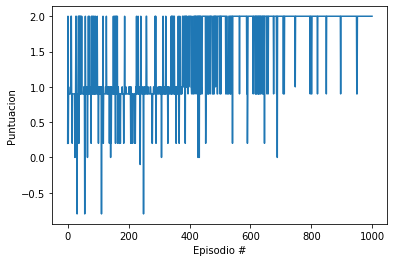

In [13]:
scores = dqn(bigger_agent_adam, env, n_episodes=1000)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Puntuacion')
plt.xlabel('Episodio #')
plt.show()

### Probamos las mismas redes, empleando el algoritmo de optimización RMSProp

En la literatura de Reinforcement Learning, uno de los optimizadores más usados es RMSProp. Probaremos con ese a ver si hay alguna diferecia.

Empezamos por la red básica.

I0816 15:08:58.988468 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:58.991935 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 201.4, gameFPS: 517.6


Episodio 1	Puntuacion media (ultimos 50):0.20

I0816 15:08:59.215898 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:08:59.217303 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:59.218077 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 69.4, gameFPS: 354.1


Episodio 2	Puntuacion media (ultimos 50):1.10

I0816 15:08:59.815781 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:08:59.816843 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 124.5, gameFPS: 440.1


Episodio 3	Puntuacion media (ultimos 50):0.80

I0816 15:09:00.473800 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:00.477064 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 103.3, gameFPS: 373.6


Episodio 4	Puntuacion media (ultimos 50):0.85

I0816 15:09:00.884649 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:00.885533 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 27, FPS: 69.4, gameFPS: 291.1


Episodio 5	Puntuacion media (ultimos 50):0.86

I0816 15:09:01.523645 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:01.524832 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 104.6, gameFPS: 310.6


Episodio 6	Puntuacion media (ultimos 50):0.87

I0816 15:09:02.082016 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:02.085887 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 98.0, gameFPS: 303.2


Episodio 7	Puntuacion media (ultimos 50):0.87

I0816 15:09:02.869330 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:02.874058 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 94.3, gameFPS: 363.2


Episodio 8	Puntuacion media (ultimos 50):0.88

I0816 15:09:03.194838 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:03.195611 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 22, FPS: 70.4, gameFPS: 248.6


Episodio 9	Puntuacion media (ultimos 50):0.88

I0816 15:09:04.162789 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:04.163655 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 89.5, gameFPS: 313.2


Episodio 10	Puntuacion media (ultimos 50):0.88

I0816 15:09:04.868037 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:04.868845 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 80.6, gameFPS: 215.6
I0816 15:09:05.082192 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:09:05.083297 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:05.083927 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 86.0, gameFPS: 375.4


Episodio 12	Puntuacion media (ultimos 50):0.98

I0816 15:09:05.498650 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:09:05.501812 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:05.502906 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 41.4, gameFPS: 254.7


Episodio 13	Puntuacion media (ultimos 50):1.05

I0816 15:09:06.120223 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:06.121193 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 118.6, gameFPS: 400.9


Episodio 14	Puntuacion media (ultimos 50):1.04

I0816 15:09:06.587421 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:09:06.588922 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:06.589738 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 26, FPS: 57.0, gameFPS: 254.5


Episodio 15	Puntuacion media (ultimos 50):1.11

I0816 15:09:07.448713 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:07.451860 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 86.6, gameFPS: 407.5


Episodio 16	Puntuacion media (ultimos 50):1.09

I0816 15:09:08.053791 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:08.059474 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 86.0, gameFPS: 284.3


Episodio 17	Puntuacion media (ultimos 50):1.08

I0816 15:09:08.421285 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:08.422069 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 32, FPS: 90.8, gameFPS: 348.8


Episodio 18	Puntuacion media (ultimos 50):1.07

I0816 15:09:09.177061 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:09.181401 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 74.9, gameFPS: 247.7


Episodio 19	Puntuacion media (ultimos 50):1.06

I0816 15:09:09.792812 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:09.802136 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 92.5, gameFPS: 364.6


Episodio 20	Puntuacion media (ultimos 50):1.06

I0816 15:09:10.876077 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:09:10.877225 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:10.881533 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 72.6, gameFPS: 620.8


Episodio 22	Puntuacion media (ultimos 50):1.09

I0816 15:09:11.460895 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:11.461846 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 118.9, gameFPS: 328.3


Episodio 23	Puntuacion media (ultimos 50):1.08

I0816 15:09:11.735146 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:11.735902 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 25, FPS: 94.8, gameFPS: 325.6


Episodio 24	Puntuacion media (ultimos 50):1.08

I0816 15:09:12.279676 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:12.283949 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 130.9, gameFPS: 464.7


Episodio 26	Puntuacion media (ultimos 50):1.06

I0816 15:09:13.595606 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:13.596515 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 151.6, gameFPS: 573.2


Episodio 27	Puntuacion media (ultimos 50):1.06

I0816 15:09:13.981700 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:13.982582 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 49, FPS: 131.1, gameFPS: 480.2


Episodio 28	Puntuacion media (ultimos 50):1.05

I0816 15:09:14.587336 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:14.592920 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 136.1, gameFPS: 482.3


Episodio 29	Puntuacion media (ultimos 50):1.04

I0816 15:09:14.949995 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:14.951061 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 24, FPS: 70.1, gameFPS: 249.1


Episodio 30	Puntuacion media (ultimos 50):1.04

I0816 15:09:15.563238 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:15.565494 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 89.8, gameFPS: 370.5


Episodio 31	Puntuacion media (ultimos 50):1.04

I0816 15:09:15.781248 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:09:15.782879 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:15.783825 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 52.4, gameFPS: 250.8


Episodio 32	Puntuacion media (ultimos 50):1.07

I0816 15:09:16.677832 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:16.678869 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 102.0, gameFPS: 360.4


Episodio 33	Puntuacion media (ultimos 50):1.06

I0816 15:09:17.111031 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:17.112552 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 122.7, gameFPS: 508.3


Episodio 34	Puntuacion media (ultimos 50):1.06

I0816 15:09:17.609148 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:17.612700 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 116.1, gameFPS: 402.7


Episodio 35	Puntuacion media (ultimos 50):1.05

I0816 15:09:18.349166 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:18.350483 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 117.9, gameFPS: 355.9


Episodio 37	Puntuacion media (ultimos 50):1.01

I0816 15:09:19.708137 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:19.709117 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 131.9, gameFPS: 490.7


Episodio 38	Puntuacion media (ultimos 50):1.00

I0816 15:09:20.489667 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:20.491003 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 102.6, gameFPS: 409.6
I0816 15:09:20.662874 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:09:20.664116 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:20.664739 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.6, gameFPS: 321.9


Episodio 41	Puntuacion media (ultimos 50):1.02

I0816 15:09:21.546075 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:21.547035 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 84.3, gameFPS: 284.6


Episodio 42	Puntuacion media (ultimos 50):1.02

I0816 15:09:22.526847 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:09:22.527880 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:22.528388 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 56.1, gameFPS: 239.9


Episodio 44	Puntuacion media (ultimos 50):1.04

I0816 15:09:23.136912 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:23.138098 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 116.6, gameFPS: 372.9


Episodio 49	Puntuacion media (ultimos 50):1.03

I0816 15:09:27.235270 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:27.236723 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 104.3, gameFPS: 348.0


Episodio 50	Puntuacion media (50 anteriores): 1.03


I0816 15:09:27.599511 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:09:27.600500 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:27.601067 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 34.6, gameFPS: 164.2


Episodio 53	Puntuacion media (ultimos 50):1.04

I0816 15:09:30.348323 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:30.352014 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 104.9, gameFPS: 368.3


Episodio 54	Puntuacion media (ultimos 50):1.03

I0816 15:09:30.925945 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:30.927006 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 121.5, gameFPS: 383.4


Episodio 55	Puntuacion media (ultimos 50):1.03

I0816 15:09:31.530740 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:31.531723 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 135.6, gameFPS: 476.0


Episodio 56	Puntuacion media (ultimos 50):1.03

I0816 15:09:32.315369 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:32.317852 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 96.8, gameFPS: 396.2


Episodio 57	Puntuacion media (ultimos 50):1.01

I0816 15:09:32.757507 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:09:32.758551 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:32.759118 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 29, FPS: 67.0, gameFPS: 365.4


Episodio 58	Puntuacion media (ultimos 50):1.03

I0816 15:09:33.673725 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:33.674533 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 77.4, gameFPS: 346.3


Episodio 59	Puntuacion media (ultimos 50):1.03

I0816 15:09:33.917137 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:09:33.918449 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:33.919512 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 52.3, gameFPS: 453.1


Episodio 60	Puntuacion media (ultimos 50):1.06

I0816 15:09:34.718270 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:34.719054 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 94.6, gameFPS: 305.6


Episodio 61	Puntuacion media (ultimos 50):1.06

I0816 15:09:35.439201 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:35.442219 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 101.2, gameFPS: 346.8


Episodio 63	Puntuacion media (ultimos 50):1.00

I0816 15:09:36.840190 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:36.841015 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 140.8, gameFPS: 499.4
I0816 15:09:37.048134 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:09:37.057101 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:37.058464 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 50.3, gameFPS: 198.7


Episodio 65	Puntuacion media (ultimos 50):1.00

I0816 15:09:37.889703 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:37.890668 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 95, FPS: 115.8, gameFPS: 397.1


Episodio 66	Puntuacion media (ultimos 50):1.00

I0816 15:09:38.182903 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:38.184065 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 22, FPS: 78.6, gameFPS: 262.2


Episodio 67	Puntuacion media (ultimos 50):1.00

I0816 15:09:38.784409 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:38.785385 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 87.9, gameFPS: 291.7


Episodio 68	Puntuacion media (ultimos 50):1.00

I0816 15:09:39.859667 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:39.864783 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 76.9, gameFPS: 301.0


Episodio 69	Puntuacion media (ultimos 50):1.00

I0816 15:09:40.528514 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:40.530570 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 79.0, gameFPS: 304.3


Episodio 71	Puntuacion media (ultimos 50):0.99

I0816 15:09:42.378103 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:42.378973 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 80.3, gameFPS: 295.3


Episodio 73	Puntuacion media (ultimos 50):0.97

I0816 15:09:42.565253 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:09:42.566376 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:42.567203 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.4, gameFPS: 311.4


Episodio 74	Puntuacion media (ultimos 50):0.99

I0816 15:09:43.238485 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:43.241310 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 105.4, gameFPS: 285.2


Episodio 75	Puntuacion media (ultimos 50):0.99

I0816 15:09:44.028097 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:44.029075 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 74.5, gameFPS: 392.6


Episodio 76	Puntuacion media (ultimos 50):0.99

I0816 15:09:44.590051 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:44.591073 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 141.2, gameFPS: 533.9


Episodio 77	Puntuacion media (ultimos 50):0.99

I0816 15:09:45.172725 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:45.173552 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 149.0, gameFPS: 557.8


Episodio 78	Puntuacion media (ultimos 50):0.99

I0816 15:09:45.857938 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:45.858804 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 61, FPS: 90.8, gameFPS: 271.7


Episodio 79	Puntuacion media (ultimos 50):0.99

I0816 15:09:46.503580 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:46.505081 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 133.4, gameFPS: 481.3


Episodio 82	Puntuacion media (ultimos 50):0.96

I0816 15:09:49.454804 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:49.455714 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 121.9, gameFPS: 435.4


Episodio 83	Puntuacion media (ultimos 50):0.94

I0816 15:09:49.698263 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:09:49.699293 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:49.699895 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 56.8, gameFPS: 261.3
I0816 15:09:49.964070 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:49.964910 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 75.1, gameFPS: 280.4


Episodio 85	Puntuacion media (ultimos 50):0.97

I0816 15:09:50.454634 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:50.457706 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 107.7, gameFPS: 350.1


Episodio 88	Puntuacion media (ultimos 50):0.99

I0816 15:09:52.387518 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:09:52.389066 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:52.390301 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 31, FPS: 90.2, gameFPS: 391.0


Episodio 89	Puntuacion media (ultimos 50):1.02

I0816 15:09:53.013626 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:53.017578 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 129.0, gameFPS: 467.3


Episodio 90	Puntuacion media (ultimos 50):1.00

I0816 15:09:53.755048 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:53.758326 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 93, FPS: 127.7, gameFPS: 534.4


Episodio 91	Puntuacion media (ultimos 50):1.00

I0816 15:09:54.001179 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:54.002707 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 84.8, gameFPS: 291.7


Episodio 93	Puntuacion media (ultimos 50):1.00

I0816 15:09:55.753945 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:55.760734 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 102.4, gameFPS: 296.5


Episodio 96	Puntuacion media (ultimos 50):0.98

I0816 15:09:58.110605 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:58.111844 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 86.8, gameFPS: 323.4


Episodio 97	Puntuacion media (ultimos 50):0.98

I0816 15:09:58.571281 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:58.572129 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 114.9, gameFPS: 412.7


Episodio 98	Puntuacion media (ultimos 50):0.97

I0816 15:09:59.185480 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:59.186749 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 86.0, gameFPS: 315.7


Episodio 99	Puntuacion media (ultimos 50):0.97

I0816 15:09:59.674259 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:09:59.675281 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 57, FPS: 119.5, gameFPS: 402.6


Episodio 100	Puntuacion media (50 anteriores): 0.97


I0816 15:10:00.370540 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:00.371438 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 109.5, gameFPS: 484.4


Episodio 102	Puntuacion media (ultimos 50):0.95

I0816 15:10:01.370283 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:10:01.371553 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:01.379250 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 74.0, gameFPS: 266.9


Episodio 103	Puntuacion media (ultimos 50):0.99

I0816 15:10:02.412430 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:10:02.413493 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:02.414192 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 65.3, gameFPS: 289.9


Episodio 106	Puntuacion media (ultimos 50):1.02

I0816 15:10:04.515748 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:10:04.517021 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:04.517753 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 95.4, gameFPS: 386.6


Episodio 109	Puntuacion media (ultimos 50):1.04

I0816 15:10:06.582689 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:06.588199 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 85.4, gameFPS: 339.5


Episodio 110	Puntuacion media (ultimos 50):1.00

I0816 15:10:06.859303 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:06.860497 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 76.1, gameFPS: 270.8


Episodio 111	Puntuacion media (ultimos 50):1.00

I0816 15:10:07.732413 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:07.733901 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 93, FPS: 107.6, gameFPS: 404.0


Episodio 112	Puntuacion media (ultimos 50):1.02

I0816 15:10:08.468713 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:08.469557 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 90.7, gameFPS: 382.0


Episodio 113	Puntuacion media (ultimos 50):1.02

I0816 15:10:09.076155 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:09.080960 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 117.2, gameFPS: 468.6


Episodio 114	Puntuacion media (ultimos 50):1.02

I0816 15:10:09.557811 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:09.558800 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 42, FPS: 90.4, gameFPS: 385.7


Episodio 115	Puntuacion media (ultimos 50):1.00

I0816 15:10:10.289801 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:10.290923 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 109.7, gameFPS: 428.2


Episodio 116	Puntuacion media (ultimos 50):0.99

I0816 15:10:11.271078 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:10:11.273151 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:11.274746 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 58.1, gameFPS: 240.4


Episodio 118	Puntuacion media (ultimos 50):1.01

I0816 15:10:11.971380 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:11.972443 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 116.7, gameFPS: 461.0


Episodio 119	Puntuacion media (ultimos 50):1.01

I0816 15:10:12.445361 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:12.446527 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 57, FPS: 122.9, gameFPS: 463.3


Episodio 121	Puntuacion media (ultimos 50):1.03

I0816 15:10:13.542491 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:13.544565 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 76.6, gameFPS: 267.9


Episodio 123	Puntuacion media (ultimos 50):1.03

I0816 15:10:14.958836 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:14.962977 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 97.4, gameFPS: 345.8
I0816 15:10:15.134231 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:10:15.135453 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:15.138494 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 66.5, gameFPS: 303.0


Episodio 125	Puntuacion media (ultimos 50):1.02

I0816 15:10:15.737335 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:15.743353 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 91.9, gameFPS: 319.5


Episodio 126	Puntuacion media (ultimos 50):1.02

I0816 15:10:16.262267 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:16.263284 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 98.2, gameFPS: 380.7


Episodio 127	Puntuacion media (ultimos 50):1.02

I0816 15:10:16.927452 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:16.930725 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 123.9, gameFPS: 518.3


Episodio 128	Puntuacion media (ultimos 50):1.02

I0816 15:10:17.562079 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:17.563186 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 83.8, gameFPS: 299.5


Episodio 129	Puntuacion media (ultimos 50):1.02

I0816 15:10:18.332815 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:18.336001 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 113.2, gameFPS: 455.9


Episodio 130	Puntuacion media (ultimos 50):1.04

I0816 15:10:18.886964 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:18.887777 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 127.0, gameFPS: 492.4


Episodio 132	Puntuacion media (ultimos 50):1.02

I0816 15:10:20.301705 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:20.302870 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 123.4, gameFPS: 491.5


Episodio 133	Puntuacion media (ultimos 50):1.04

I0816 15:10:21.249594 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:10:21.250818 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:21.251482 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 76.2, gameFPS: 371.4


Episodio 135	Puntuacion media (ultimos 50):1.04

I0816 15:10:21.809337 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:21.810400 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 125.4, gameFPS: 463.0


Episodio 137	Puntuacion media (ultimos 50):1.03

I0816 15:10:23.480865 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:23.483998 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 100.9, gameFPS: 290.4


Episodio 138	Puntuacion media (ultimos 50):1.03

I0816 15:10:24.292354 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:24.293414 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 106.4, gameFPS: 417.5


Episodio 139	Puntuacion media (ultimos 50):1.01

I0816 15:10:25.070267 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:25.071491 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 95.0, gameFPS: 398.3


Episodio 140	Puntuacion media (ultimos 50):1.00

I0816 15:10:25.832103 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:25.833313 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 90.2, gameFPS: 354.6


Episodio 141	Puntuacion media (ultimos 50):0.99

I0816 15:10:26.855970 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:26.859732 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 90.6, gameFPS: 386.8


Episodio 143	Puntuacion media (ultimos 50):0.99

I0816 15:10:28.456196 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:28.458088 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 45, FPS: 85.6, gameFPS: 379.0


Episodio 144	Puntuacion media (ultimos 50):0.99

I0816 15:10:29.390905 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:29.395191 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 94.2, gameFPS: 305.1


Episodio 145	Puntuacion media (ultimos 50):0.99

I0816 15:10:29.820280 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:10:29.821580 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:29.823320 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 26, FPS: 63.2, gameFPS: 318.5


Episodio 147	Puntuacion media (ultimos 50):1.01

I0816 15:10:31.997757 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:10:31.998916 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:31.999678 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 51.8, gameFPS: 210.0


Episodio 149	Puntuacion media (ultimos 50):1.03

I0816 15:10:32.394322 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:10:32.397031 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:32.399932 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 22, FPS: 56.8, gameFPS: 238.7


Episodio 150	Puntuacion media (50 anteriores): 1.05


I0816 15:10:33.433695 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:33.437181 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 76.8, gameFPS: 300.0


Episodio 151	Puntuacion media (ultimos 50):1.05

I0816 15:10:34.297896 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:34.301871 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 83.3, gameFPS: 332.6


Episodio 152	Puntuacion media (ultimos 50):1.05

I0816 15:10:35.256449 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:35.257393 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 90, FPS: 95.5, gameFPS: 348.5
I0816 15:10:35.436185 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:10:35.440268 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:35.446488 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 53.2, gameFPS: 536.3


Episodio 154	Puntuacion media (ultimos 50):1.04

I0816 15:10:35.982577 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:35.985846 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 48, FPS: 91.5, gameFPS: 434.3


Episodio 155	Puntuacion media (ultimos 50):1.02

I0816 15:10:36.668861 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:36.674510 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 127.9, gameFPS: 514.3
I0816 15:10:36.839039 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:10:36.841056 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:36.843919 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.3, gameFPS: 542.8


Episodio 157	Puntuacion media (ultimos 50):1.02

I0816 15:10:37.362872 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:37.364424 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 107.7, gameFPS: 360.1


Episodio 158	Puntuacion media (ultimos 50):1.00

I0816 15:10:38.009297 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:38.012385 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 117.5, gameFPS: 446.8
I0816 15:10:38.257194 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:10:38.258472 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:38.259489 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 75.5, gameFPS: 435.8


Episodio 160	Puntuacion media (ultimos 50):1.04

I0816 15:10:38.752080 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:38.753184 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 114.2, gameFPS: 429.7
I0816 15:10:38.945060 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:10:38.946198 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:38.946773 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 69.7, gameFPS: 270.8


Episodio 162	Puntuacion media (ultimos 50):1.06

I0816 15:10:39.123265 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:10:39.126247 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:39.128870 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 63.9, gameFPS: 568.9


Episodio 164	Puntuacion media (ultimos 50):1.08

I0816 15:10:40.736669 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:40.740474 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 91.1, gameFPS: 347.9


Episodio 165	Puntuacion media (ultimos 50):1.08

I0816 15:10:41.641343 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:41.642123 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 95.7, gameFPS: 374.5


Episodio 166	Puntuacion media (ultimos 50):1.08

I0816 15:10:42.212925 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:42.213777 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 127.2, gameFPS: 493.1


Episodio 167	Puntuacion media (ultimos 50):1.08

I0816 15:10:42.789478 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:42.790271 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 123.3, gameFPS: 540.9


Episodio 168	Puntuacion media (ultimos 50):1.06

I0816 15:10:43.650165 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:43.651317 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 99.9, gameFPS: 476.9


Episodio 169	Puntuacion media (ultimos 50):1.06

I0816 15:10:44.845377 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:10:44.846532 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:44.847309 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 42.4, gameFPS: 176.9


Episodio 171	Puntuacion media (ultimos 50):1.08

I0816 15:10:45.477732 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:45.479033 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 117.6, gameFPS: 493.9


Episodio 172	Puntuacion media (ultimos 50):1.08

I0816 15:10:45.810654 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:45.811643 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 22, FPS: 67.7, gameFPS: 270.2


Episodio 173	Puntuacion media (ultimos 50):1.08

I0816 15:10:46.143819 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:10:46.145239 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:46.146022 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 22, FPS: 67.9, gameFPS: 312.3


Episodio 174	Puntuacion media (ultimos 50):1.10

I0816 15:10:46.916880 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:46.918340 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 94.4, gameFPS: 387.4


Episodio 175	Puntuacion media (ultimos 50):1.08

I0816 15:10:47.558726 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:47.559602 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 123.1, gameFPS: 468.6


Episodio 176	Puntuacion media (ultimos 50):1.08

I0816 15:10:48.166520 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:48.170549 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 129.6, gameFPS: 439.8


Episodio 177	Puntuacion media (ultimos 50):1.08

I0816 15:10:48.882867 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:48.883771 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 122.3, gameFPS: 471.9


Episodio 178	Puntuacion media (ultimos 50):1.08

I0816 15:10:49.552296 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:49.555515 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 124.4, gameFPS: 459.3


Episodio 179	Puntuacion media (ultimos 50):1.08

I0816 15:10:50.178442 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:50.179430 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 112.2, gameFPS: 488.3


Episodio 180	Puntuacion media (ultimos 50):1.07

I0816 15:10:50.790853 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:50.794568 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 117.3, gameFPS: 464.3


Episodio 181	Puntuacion media (ultimos 50):1.07

I0816 15:10:51.332814 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:51.333964 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 60, FPS: 113.3, gameFPS: 446.5
I0816 15:10:51.534974 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:10:51.536068 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:51.536789 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 81.1, gameFPS: 325.7


Episodio 183	Puntuacion media (ultimos 50):1.09

I0816 15:10:51.995323 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:51.996324 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 120.0, gameFPS: 461.2


Episodio 185	Puntuacion media (ultimos 50):1.07

I0816 15:10:53.414311 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:53.415096 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 126.7, gameFPS: 535.6


Episodio 186	Puntuacion media (ultimos 50):1.07

I0816 15:10:54.205415 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:54.206289 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 107.5, gameFPS: 375.0


Episodio 187	Puntuacion media (ultimos 50):1.06

I0816 15:10:54.630059 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:54.630837 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 122.2, gameFPS: 437.1


Episodio 188	Puntuacion media (ultimos 50):1.06

I0816 15:10:55.150902 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:10:55.152208 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:55.153178 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 67, FPS: 130.8, gameFPS: 596.9


Episodio 189	Puntuacion media (ultimos 50):1.08

I0816 15:10:55.655733 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:55.656499 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 115.2, gameFPS: 464.1
I0816 15:10:55.879846 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:10:55.880823 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:55.881406 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 83.2, gameFPS: 334.1


Episodio 191	Puntuacion media (ultimos 50):1.12

I0816 15:10:56.523421 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:56.524319 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 124.3, gameFPS: 474.5


Episodio 192	Puntuacion media (ultimos 50):1.12

I0816 15:10:57.149222 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:57.150075 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 116.9, gameFPS: 404.1


Episodio 193	Puntuacion media (ultimos 50):1.12

I0816 15:10:57.375585 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:57.376457 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 13, FPS: 61.7, gameFPS: 207.2
I0816 15:10:57.605473 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:10:57.606841 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:57.607739 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 53.8, gameFPS: 234.4


Episodio 195	Puntuacion media (ultimos 50):1.14

I0816 15:10:57.761320 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:10:57.762611 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:57.764757 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 68.6, gameFPS: 530.2


Episodio 196	Puntuacion media (ultimos 50):1.14

I0816 15:10:58.362269 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:58.364307 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 123.8, gameFPS: 516.0


Episodio 198	Puntuacion media (ultimos 50):1.14

I0816 15:10:59.747785 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:10:59.748773 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 128.9, gameFPS: 474.1


Episodio 199	Puntuacion media (ultimos 50):1.12

I0816 15:11:00.420600 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:00.421510 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 132.1, gameFPS: 507.8
I0816 15:11:00.685297 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:11:00.686225 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:00.687204 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 93.5, gameFPS: 392.1


Episodio 200	Puntuacion media (50 anteriores): 1.10
Episodio 201	Puntuacion media (ultimos 50):1.12

I0816 15:11:01.344558 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:01.345465 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 131.2, gameFPS: 486.2


Episodio 202	Puntuacion media (ultimos 50):1.12

I0816 15:11:02.230572 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:02.233819 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 95, FPS: 108.4, gameFPS: 454.3


Episodio 203	Puntuacion media (ultimos 50):1.14

I0816 15:11:03.078494 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:03.082395 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 86.0, gameFPS: 427.3


Episodio 204	Puntuacion media (ultimos 50):1.12

I0816 15:11:03.808045 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:03.810995 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 121.4, gameFPS: 389.4


Episodio 205	Puntuacion media (ultimos 50):1.12

I0816 15:11:04.384170 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:04.387410 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 125.5, gameFPS: 467.3


Episodio 206	Puntuacion media (ultimos 50):1.13

I0816 15:11:05.017880 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:05.018853 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 128.3, gameFPS: 467.5


Episodio 207	Puntuacion media (ultimos 50):1.11

I0816 15:11:05.621108 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:05.622105 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 128.3, gameFPS: 478.7


Episodio 208	Puntuacion media (ultimos 50):1.11

I0816 15:11:06.243458 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:06.244370 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 127.6, gameFPS: 462.4


Episodio 209	Puntuacion media (ultimos 50):1.11

I0816 15:11:06.920158 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:06.921061 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 127.5, gameFPS: 452.6


Episodio 210	Puntuacion media (ultimos 50):1.08

I0816 15:11:07.836526 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:11:07.837632 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:07.838269 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 94.6, gameFPS: 402.2


Episodio 212	Puntuacion media (ultimos 50):1.08

I0816 15:11:08.444009 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:08.445039 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 140.5, gameFPS: 507.8


Episodio 214	Puntuacion media (ultimos 50):1.06

I0816 15:11:09.667225 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:09.668159 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 142.5, gameFPS: 539.0


Episodio 216	Puntuacion media (ultimos 50):1.07

I0816 15:11:10.867790 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:10.868570 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 139.1, gameFPS: 538.7


Episodio 217	Puntuacion media (ultimos 50):1.07

I0816 15:11:11.384414 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:11.385192 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 140.5, gameFPS: 559.2


Episodio 218	Puntuacion media (ultimos 50):1.07

I0816 15:11:11.880967 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:11.882257 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 141.8, gameFPS: 589.9


Episodio 223	Puntuacion media (ultimos 50):1.00

I0816 15:11:16.830182 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:16.831183 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 110.2, gameFPS: 323.7


Episodio 224	Puntuacion media (ultimos 50):0.98

I0816 15:11:17.624927 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:17.626104 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 116.8, gameFPS: 385.9
I0816 15:11:17.793084 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:11:17.794100 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:17.794689 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 62.0, gameFPS: 272.2


Episodio 226	Puntuacion media (ultimos 50):1.01

I0816 15:11:18.430778 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:18.431764 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 122.5, gameFPS: 441.4


Episodio 227	Puntuacion media (ultimos 50):1.01

I0816 15:11:18.996786 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:18.997666 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 131.5, gameFPS: 513.0


Episodio 229	Puntuacion media (ultimos 50):1.01

I0816 15:11:20.402155 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:20.403458 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 129.4, gameFPS: 495.1


Episodio 230	Puntuacion media (ultimos 50):1.02

I0816 15:11:20.945752 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:20.946535 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 123.2, gameFPS: 398.2


Episodio 231	Puntuacion media (ultimos 50):1.04

I0816 15:11:21.517025 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:21.517920 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 126.4, gameFPS: 458.1


Episodio 232	Puntuacion media (ultimos 50):1.04

I0816 15:11:21.917913 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:21.918762 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 43, FPS: 109.6, gameFPS: 399.8


Episodio 236	Puntuacion media (ultimos 50):1.02

I0816 15:11:24.649012 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:24.649999 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 60, FPS: 118.0, gameFPS: 473.5


Episodio 237	Puntuacion media (ultimos 50):1.02

I0816 15:11:25.088105 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:25.089060 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 122.7, gameFPS: 488.0


Episodio 239	Puntuacion media (ultimos 50):0.99

I0816 15:11:26.549434 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:11:26.550675 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:26.551304 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 99, FPS: 135.2, gameFPS: 503.7


Episodio 240	Puntuacion media (ultimos 50):1.02

I0816 15:11:27.118432 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:27.119505 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 127.4, gameFPS: 493.6


Episodio 241	Puntuacion media (ultimos 50):0.98

I0816 15:11:27.721708 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:27.722594 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 135.2, gameFPS: 526.5


Episodio 242	Puntuacion media (ultimos 50):0.98

I0816 15:11:28.370871 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:28.371876 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 132.8, gameFPS: 502.6


Episodio 243	Puntuacion media (ultimos 50):0.98

I0816 15:11:29.098588 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:11:29.099904 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:29.100612 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 93, FPS: 128.9, gameFPS: 453.0
I0816 15:11:29.232882 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:11:29.233984 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:29.238880 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 72.5, gameFPS: 712.4


Episodio 245	Puntuacion media (ultimos 50):0.96

I0816 15:11:29.715203 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:29.716016 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 115.8, gameFPS: 419.4


Episodio 247	Puntuacion media (ultimos 50):0.94

I0816 15:11:31.168555 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:31.171937 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 128.0, gameFPS: 439.6


Episodio 248	Puntuacion media (ultimos 50):0.94

I0816 15:11:31.866260 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:31.867233 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 132.6, gameFPS: 497.2


Episodio 250	Puntuacion media (50 anteriores): 0.93


I0816 15:11:33.202855 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:33.203865 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 125.1, gameFPS: 447.5


Episodio 252	Puntuacion media (ultimos 50):0.90

I0816 15:11:34.526491 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:34.527594 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 62, FPS: 109.5, gameFPS: 309.6


Episodio 253	Puntuacion media (ultimos 50):0.90

I0816 15:11:35.033497 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:35.034291 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 129.8, gameFPS: 488.1


Episodio 254	Puntuacion media (ultimos 50):0.90

I0816 15:11:35.517088 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:35.517855 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 119.1, gameFPS: 453.0


Episodio 256	Puntuacion media (ultimos 50):0.90

I0816 15:11:36.717882 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:36.718762 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 122.3, gameFPS: 405.3
I0816 15:11:36.884759 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:11:36.886004 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:36.886675 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 59.5, gameFPS: 266.0


Episodio 258	Puntuacion media (ultimos 50):0.93

I0816 15:11:37.467847 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:37.468912 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 128.9, gameFPS: 495.7


Episodio 259	Puntuacion media (ultimos 50):0.93

I0816 15:11:38.289585 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:38.293672 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 97, FPS: 119.5, gameFPS: 436.1


Episodio 260	Puntuacion media (ultimos 50):0.93

I0816 15:11:39.015027 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:39.016073 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 93, FPS: 130.6, gameFPS: 507.2


Episodio 263	Puntuacion media (ultimos 50):0.91

I0816 15:11:41.227552 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:41.228657 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 127.3, gameFPS: 412.7


Episodio 264	Puntuacion media (ultimos 50):0.91

I0816 15:11:41.784420 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:41.785418 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 129.0, gameFPS: 490.7


Episodio 265	Puntuacion media (ultimos 50):0.89

I0816 15:11:42.141837 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:42.142705 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 36, FPS: 103.8, gameFPS: 358.0
I0816 15:11:42.326039 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:11:42.327284 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:42.328031 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 84.2, gameFPS: 362.4


Episodio 267	Puntuacion media (ultimos 50):0.91

I0816 15:11:42.507370 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:11:42.508523 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:42.512086 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.3, gameFPS: 311.5


Episodio 268	Puntuacion media (ultimos 50):0.93

I0816 15:11:43.104042 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:43.105005 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 126.5, gameFPS: 449.1
I0816 15:11:43.245128 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:11:43.246433 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:43.251237 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 67.9, gameFPS: 634.6


Episodio 270	Puntuacion media (ultimos 50):0.98

I0816 15:11:43.425615 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:11:43.426517 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:43.427110 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 61.4, gameFPS: 269.3


Episodio 271	Puntuacion media (ultimos 50):1.00

I0816 15:11:44.032279 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:44.033236 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 62, FPS: 104.2, gameFPS: 277.6


Episodio 272	Puntuacion media (ultimos 50):1.02

I0816 15:11:44.737681 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:44.738861 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 96, FPS: 137.9, gameFPS: 477.5


Episodio 273	Puntuacion media (ultimos 50):1.02

I0816 15:11:45.518202 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:45.519090 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 98, FPS: 127.6, gameFPS: 424.1


Episodio 275	Puntuacion media (ultimos 50):1.02

I0816 15:11:46.750554 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:46.751575 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 139.1, gameFPS: 492.2


Episodio 276	Puntuacion media (ultimos 50):1.00

I0816 15:11:47.041694 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:47.042912 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 23, FPS: 83.4, gameFPS: 271.6


Episodio 277	Puntuacion media (ultimos 50):1.00

I0816 15:11:47.685612 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:47.686422 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 132.1, gameFPS: 519.1


Episodio 278	Puntuacion media (ultimos 50):1.00

I0816 15:11:48.260102 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:48.261113 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 118.1, gameFPS: 382.7


Episodio 279	Puntuacion media (ultimos 50):1.00

I0816 15:11:48.919426 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:48.920344 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 126.5, gameFPS: 453.1


Episodio 280	Puntuacion media (ultimos 50):1.00

I0816 15:11:49.412586 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:49.413654 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 120.0, gameFPS: 456.5


Episodio 283	Puntuacion media (ultimos 50):1.00

I0816 15:11:51.284756 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:51.285568 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 136.2, gameFPS: 558.8


Episodio 284	Puntuacion media (ultimos 50):1.01

I0816 15:11:51.856437 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:51.857317 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 146.2, gameFPS: 627.2


Episodio 286	Puntuacion media (ultimos 50):1.01

I0816 15:11:53.172445 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:53.173380 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 146.2, gameFPS: 562.8


Episodio 287	Puntuacion media (ultimos 50):1.02

I0816 15:11:53.915886 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:53.917026 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 118.6, gameFPS: 422.2
I0816 15:11:54.129900 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:11:54.131003 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:54.131577 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 94.0, gameFPS: 405.7


Episodio 289	Puntuacion media (ultimos 50):1.04

I0816 15:11:54.638345 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:54.639287 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 139.0, gameFPS: 567.1
I0816 15:11:54.856384 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:11:54.857579 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:54.865456 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 22, FPS: 106.2, gameFPS: 584.6


Episodio 291	Puntuacion media (ultimos 50):1.04

I0816 15:11:55.517168 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:55.518045 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 128.9, gameFPS: 471.8


Episodio 292	Puntuacion media (ultimos 50):1.02

I0816 15:11:55.939592 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:55.940492 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 47, FPS: 113.6, gameFPS: 416.6


Episodio 293	Puntuacion media (ultimos 50):1.03

I0816 15:11:56.232226 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:11:56.234060 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:56.235061 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 29, FPS: 101.7, gameFPS: 423.3


Episodio 294	Puntuacion media (ultimos 50):1.07

I0816 15:11:56.541382 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:11:56.542481 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:56.543039 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 22, FPS: 74.0, gameFPS: 352.3


Episodio 295	Puntuacion media (ultimos 50):1.07

I0816 15:11:57.124781 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:57.125595 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 136.4, gameFPS: 525.3


Episodio 296	Puntuacion media (ultimos 50):1.07

I0816 15:11:57.742642 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:57.743630 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 131.3, gameFPS: 511.6


Episodio 298	Puntuacion media (ultimos 50):1.07

I0816 15:11:59.256754 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:59.257652 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 130.1, gameFPS: 465.2


Episodio 299	Puntuacion media (ultimos 50):1.08

I0816 15:11:59.760484 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:11:59.761262 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 140.0, gameFPS: 565.9


Episodio 300	Puntuacion media (50 anteriores): 1.08


I0816 15:12:00.259738 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:00.260871 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 137.5, gameFPS: 563.4


Episodio 301	Puntuacion media (ultimos 50):1.08

I0816 15:12:00.710860 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:00.711892 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 57, FPS: 129.3, gameFPS: 489.6


Episodio 302	Puntuacion media (ultimos 50):1.08

I0816 15:12:01.131000 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:01.131797 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 122.6, gameFPS: 442.0


Episodio 303	Puntuacion media (ultimos 50):1.08

I0816 15:12:01.783454 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:01.784326 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 131.7, gameFPS: 499.2


Episodio 305	Puntuacion media (ultimos 50):1.06

I0816 15:12:03.064681 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:03.065855 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 120.1, gameFPS: 434.0


Episodio 306	Puntuacion media (ultimos 50):1.06

I0816 15:12:03.568779 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:03.569759 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 61, FPS: 123.2, gameFPS: 468.5


Episodio 307	Puntuacion media (ultimos 50):1.06

I0816 15:12:04.232802 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:04.233884 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 133.2, gameFPS: 520.0


Episodio 308	Puntuacion media (ultimos 50):1.04

I0816 15:12:04.748274 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:04.749614 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 59, FPS: 116.6, gameFPS: 375.1


Episodio 309	Puntuacion media (ultimos 50):1.04

I0816 15:12:05.421832 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:05.423698 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 87.3, gameFPS: 267.8


Episodio 311	Puntuacion media (ultimos 50):1.04

I0816 15:12:07.048068 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:07.049614 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 87.8, gameFPS: 414.3


Episodio 313	Puntuacion media (ultimos 50):1.04

I0816 15:12:08.715000 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:08.716194 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 104.3, gameFPS: 441.2


Episodio 314	Puntuacion media (ultimos 50):1.04

I0816 15:12:09.449356 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:09.450275 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:09.451025 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 100, FPS: 138.1, gameFPS: 559.0


Episodio 315	Puntuacion media (ultimos 50):1.08

I0816 15:12:10.062686 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:10.063801 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 134.3, gameFPS: 503.0


Episodio 316	Puntuacion media (ultimos 50):1.08

I0816 15:12:10.701532 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:10.702704 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 130.6, gameFPS: 511.1
I0816 15:12:10.887472 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:10.888540 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:10.889626 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 77.6, gameFPS: 327.2


Episodio 318	Puntuacion media (ultimos 50):1.06

I0816 15:12:11.599431 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:11.600284 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 131.0, gameFPS: 512.1


Episodio 319	Puntuacion media (ultimos 50):1.06

I0816 15:12:12.311659 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:12.312573 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 121.0, gameFPS: 391.9


Episodio 321	Puntuacion media (ultimos 50):1.00

I0816 15:12:13.746180 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:13.747159 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 133.9, gameFPS: 513.5


Episodio 322	Puntuacion media (ultimos 50):1.00

I0816 15:12:14.406377 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:14.407371 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 128.8, gameFPS: 484.5


Episodio 323	Puntuacion media (ultimos 50):0.98

I0816 15:12:14.952563 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:14.953670 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 132.7, gameFPS: 581.9


Episodio 324	Puntuacion media (ultimos 50):0.98

I0816 15:12:15.510928 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:15.511821 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 140.3, gameFPS: 552.1


Episodio 325	Puntuacion media (ultimos 50):0.98

I0816 15:12:16.095737 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:16.096621 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 137.9, gameFPS: 512.8
I0816 15:12:16.295899 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:16.297050 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:16.297690 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 80.8, gameFPS: 321.5


Episodio 327	Puntuacion media (ultimos 50):1.00

I0816 15:12:16.872582 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:16.873386 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 139.3, gameFPS: 542.3
I0816 15:12:17.024024 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:17.025095 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:17.025790 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 63.8, gameFPS: 318.5


Episodio 329	Puntuacion media (ultimos 50):1.02

I0816 15:12:17.580912 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:17.581715 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 140.9, gameFPS: 560.7


Episodio 330	Puntuacion media (ultimos 50):1.02

I0816 15:12:17.994189 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:17.995072 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 131.1, gameFPS: 563.1


Episodio 331	Puntuacion media (ultimos 50):1.02

I0816 15:12:18.512702 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:18.513609 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 116.3, gameFPS: 484.7


Episodio 332	Puntuacion media (ultimos 50):1.02

I0816 15:12:18.971186 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:18.972079 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 119.3, gameFPS: 479.5


Episodio 333	Puntuacion media (ultimos 50):1.02

I0816 15:12:19.582097 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:19.583119 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 123.1, gameFPS: 428.9


Episodio 334	Puntuacion media (ultimos 50):1.02

I0816 15:12:20.247152 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:20.248144 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 132.1, gameFPS: 503.4


Episodio 335	Puntuacion media (ultimos 50):1.02

I0816 15:12:20.501517 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:20.502555 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 83.2, gameFPS: 298.8


Episodio 336	Puntuacion media (ultimos 50):1.02

I0816 15:12:21.127787 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:21.128634 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 107.6, gameFPS: 286.9


Episodio 337	Puntuacion media (ultimos 50):1.02

I0816 15:12:22.077898 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:22.078976 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:22.079552 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 85.6, gameFPS: 330.8


Episodio 339	Puntuacion media (ultimos 50):1.03

I0816 15:12:22.544993 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:22.546078 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 116.3, gameFPS: 422.7


Episodio 340	Puntuacion media (ultimos 50):1.04

I0816 15:12:22.906468 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:22.908218 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 43, FPS: 123.1, gameFPS: 524.4
I0816 15:12:23.124771 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:23.126102 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:23.126722 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 85.7, gameFPS: 358.3


Episodio 343	Puntuacion media (ultimos 50):1.05

I0816 15:12:24.353443 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:24.354430 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 118.5, gameFPS: 416.6


Episodio 344	Puntuacion media (ultimos 50):1.03

I0816 15:12:24.964035 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:24.965205 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 130.0, gameFPS: 497.8


Episodio 345	Puntuacion media (ultimos 50):1.01

I0816 15:12:25.456286 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:25.457265 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 120.2, gameFPS: 444.6


Episodio 346	Puntuacion media (ultimos 50):1.01

I0816 15:12:25.958527 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:25.959599 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 114.2, gameFPS: 369.7


Episodio 347	Puntuacion media (ultimos 50):1.01

I0816 15:12:26.504106 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:26.505530 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 60, FPS: 112.5, gameFPS: 341.8


Episodio 348	Puntuacion media (ultimos 50):1.02

I0816 15:12:27.196397 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:27.197390 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 129.4, gameFPS: 464.2


Episodio 349	Puntuacion media (ultimos 50):1.02

I0816 15:12:27.804063 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:27.805147 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 128.6, gameFPS: 486.6
I0816 15:12:27.984148 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:27.985352 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:27.985965 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 60.9, gameFPS: 285.7


Episodio 350	Puntuacion media (50 anteriores): 1.02
Episodio 351	Puntuacion media (ultimos 50):1.04

I0816 15:12:28.564741 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:28.565611 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 118.1, gameFPS: 399.2


Episodio 352	Puntuacion media (ultimos 50):1.04

I0816 15:12:28.892612 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:28.893388 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 28, FPS: 87.7, gameFPS: 279.3


Episodio 353	Puntuacion media (ultimos 50):1.04

I0816 15:12:29.493829 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:29.494790 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 117.6, gameFPS: 378.1


Episodio 357	Puntuacion media (ultimos 50):1.06

I0816 15:12:32.355560 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:32.358039 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 119.4, gameFPS: 388.4


Episodio 358	Puntuacion media (ultimos 50):1.06

I0816 15:12:32.936272 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:32.937478 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 138.3, gameFPS: 531.7


Episodio 359	Puntuacion media (ultimos 50):1.06

I0816 15:12:33.687845 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:33.690876 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 97, FPS: 132.0, gameFPS: 491.5


Episodio 360	Puntuacion media (ultimos 50):1.06

I0816 15:12:34.606786 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:34.608098 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:34.609020 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 88.2, gameFPS: 308.3


Episodio 362	Puntuacion media (ultimos 50):1.08

I0816 15:12:34.837978 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:34.839158 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:34.839811 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 81.1, gameFPS: 331.7


Episodio 364	Puntuacion media (ultimos 50):1.10

I0816 15:12:36.184056 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:36.185023 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 124.9, gameFPS: 456.9


Episodio 365	Puntuacion media (ultimos 50):1.08

I0816 15:12:36.706465 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:36.707353 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 137.3, gameFPS: 524.2


Episodio 366	Puntuacion media (ultimos 50):1.08

I0816 15:12:37.257629 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:37.258572 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 138.9, gameFPS: 567.0


Episodio 367	Puntuacion media (ultimos 50):1.08

I0816 15:12:37.884796 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:37.888550 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 139.9, gameFPS: 576.4


Episodio 368	Puntuacion media (ultimos 50):1.06

I0816 15:12:38.538066 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:38.539139 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 132.6, gameFPS: 533.7


Episodio 369	Puntuacion media (ultimos 50):1.06

I0816 15:12:39.148650 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:39.149647 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 126.9, gameFPS: 467.1


Episodio 371	Puntuacion media (ultimos 50):1.08

I0816 15:12:40.371771 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:40.372641 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 128.0, gameFPS: 438.3


Episodio 374	Puntuacion media (ultimos 50):1.10

I0816 15:12:42.222563 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:42.224878 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 34, FPS: 99.6, gameFPS: 378.3


Episodio 377	Puntuacion media (ultimos 50):1.08

I0816 15:12:44.067189 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:44.068138 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 128.6, gameFPS: 481.2


Episodio 378	Puntuacion media (ultimos 50):1.08

I0816 15:12:44.731529 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:44.732342 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 94, FPS: 144.1, gameFPS: 565.6


Episodio 379	Puntuacion media (ultimos 50):1.06

I0816 15:12:45.326066 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:45.326959 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 135.2, gameFPS: 479.6


Episodio 380	Puntuacion media (ultimos 50):1.06

I0816 15:12:45.673772 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:45.674595 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 31, FPS: 94.5, gameFPS: 315.6
I0816 15:12:45.927151 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:45.928125 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 21, FPS: 85.4, gameFPS: 309.0


Episodio 382	Puntuacion media (ultimos 50):1.06

I0816 15:12:46.178764 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:46.179873 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:46.180487 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 99.1, gameFPS: 441.6
I0816 15:12:46.409689 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:46.410802 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:46.411454 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 103.4, gameFPS: 480.0


Episodio 384	Puntuacion media (ultimos 50):1.10

I0816 15:12:46.619471 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:46.620779 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:46.621431 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 80.3, gameFPS: 351.4
I0816 15:12:46.828045 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:46.828908 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 15, FPS: 75.7, gameFPS: 266.1


Episodio 386	Puntuacion media (ultimos 50):1.12

I0816 15:12:47.084320 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:47.085193 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 80.1, gameFPS: 288.2
I0816 15:12:47.336137 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:47.337144 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 82.6, gameFPS: 295.9


Episodio 388	Puntuacion media (ultimos 50):1.12

I0816 15:12:47.587343 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:47.588241 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 82.0, gameFPS: 305.1
I0816 15:12:47.808960 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:47.811491 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 74.6, gameFPS: 260.6


Episodio 390	Puntuacion media (ultimos 50):1.10

I0816 15:12:47.990941 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:47.992124 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:47.992807 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.3, gameFPS: 299.0
I0816 15:12:48.165128 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:48.166237 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:48.166975 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.8, gameFPS: 327.3


Episodio 392	Puntuacion media (ultimos 50):1.12

I0816 15:12:48.322158 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:48.323230 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:48.323826 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 60.5, gameFPS: 278.7


Episodio 393	Puntuacion media (ultimos 50):1.14

I0816 15:12:48.963074 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:48.963878 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 93, FPS: 147.4, gameFPS: 624.7
I0816 15:12:49.116215 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:49.117312 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:49.117979 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 62.6, gameFPS: 303.4


Episodio 395	Puntuacion media (ultimos 50):1.16

I0816 15:12:49.786847 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:49.788539 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 98.3, gameFPS: 332.2
I0816 15:12:49.978845 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:49.980200 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:49.980809 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 53.9, gameFPS: 263.6


Episodio 397	Puntuacion media (ultimos 50):1.18

I0816 15:12:50.172542 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:50.173632 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:50.174219 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 69.9, gameFPS: 312.2
I0816 15:12:50.344568 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:50.345525 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:50.346132 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 79.2, gameFPS: 342.9


Episodio 399	Puntuacion media (ultimos 50):1.22

I0816 15:12:50.534378 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:50.535362 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:50.535980 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 76.8, gameFPS: 341.2


Episodio 400	Puntuacion media (50 anteriores): 1.24


I0816 15:12:50.803735 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:50.804506 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 76.6, gameFPS: 262.3
I0816 15:12:51.004553 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:51.005714 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:51.007086 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 103.2, gameFPS: 647.4


Episodio 402	Puntuacion media (ultimos 50):1.25

I0816 15:12:51.201480 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:51.202512 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:51.203150 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.6, gameFPS: 295.1


Episodio 403	Puntuacion media (ultimos 50):1.27

I0816 15:12:52.103258 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:52.104179 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 100, FPS: 111.9, gameFPS: 435.4


Episodio 404	Puntuacion media (ultimos 50):1.26

I0816 15:12:52.826814 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:12:52.828155 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:52.828752 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 92, FPS: 128.6, gameFPS: 459.9
I0816 15:12:53.111658 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled


Episodio 405	Puntuacion media (ultimos 50):1.23

I0816 15:12:53.112791 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:53.118122 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 27, FPS: 98.7, gameFPS: 612.5
I0816 15:12:53.302565 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:53.304839 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:53.306389 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 58.8, gameFPS: 235.0


Episodio 407	Puntuacion media (ultimos 50):1.27

I0816 15:12:53.592046 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:53.593577 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:53.604214 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 50.3, gameFPS: 310.1
I0816 15:12:53.826026 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:53.827462 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:53.828485 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 47.6, gameFPS: 235.8


Episodio 409	Puntuacion media (ultimos 50):1.31

I0816 15:12:54.240160 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:54.241423 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:54.242490 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 49.6, gameFPS: 255.5


Episodio 410	Puntuacion media (ultimos 50):1.33

I0816 15:12:54.584816 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:54.586148 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:54.587314 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 35.6, gameFPS: 150.4


Episodio 411	Puntuacion media (ultimos 50):1.36

I0816 15:12:55.021602 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:55.023029 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 44.6, gameFPS: 152.1


Episodio 412	Puntuacion media (ultimos 50):1.34

I0816 15:12:55.794541 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:55.795447 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 101.1, gameFPS: 390.5


Episodio 413	Puntuacion media (ultimos 50):1.32

I0816 15:12:56.542426 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:56.543283 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 95.9, gameFPS: 377.6
I0816 15:12:56.731016 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:56.733023 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:56.734232 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.6, gameFPS: 287.8


Episodio 415	Puntuacion media (ultimos 50):1.34

I0816 15:12:56.939343 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:56.940576 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:56.941293 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.5, gameFPS: 284.2
I0816 15:12:57.131384 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:57.132579 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:57.133229 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.8, gameFPS: 273.6


Episodio 418	Puntuacion media (ultimos 50):1.38

I0816 15:12:58.566709 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:58.567735 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 59, FPS: 109.1, gameFPS: 412.9
I0816 15:12:58.810375 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:58.811471 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 15, FPS: 66.6, gameFPS: 234.5


Episodio 420	Puntuacion media (ultimos 50):1.37

I0816 15:12:58.999484 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:59.000757 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:59.001499 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.7, gameFPS: 295.9


Episodio 421	Puntuacion media (ultimos 50):1.39

I0816 15:12:59.602886 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:59.605557 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 124.6, gameFPS: 489.8
I0816 15:12:59.745048 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:12:59.747868 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:12:59.752109 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 67.4, gameFPS: 574.1


Episodio 423	Puntuacion media (ultimos 50):1.41

I0816 15:13:00.010615 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:00.011394 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 72.3, gameFPS: 298.7
I0816 15:13:00.213757 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:00.214856 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:00.215967 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 94.0, gameFPS: 446.8


Episodio 425	Puntuacion media (ultimos 50):1.43

I0816 15:13:00.415741 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:00.416802 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:00.417367 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 72.2, gameFPS: 297.8
I0816 15:13:00.601100 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:00.602188 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:00.602747 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 73.6, gameFPS: 314.0


Episodio 427	Puntuacion media (ultimos 50):1.47

I0816 15:13:00.788473 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:00.789562 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:00.790240 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.3, gameFPS: 299.7
I0816 15:13:00.969701 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:00.970878 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:00.971438 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.7, gameFPS: 310.7


Episodio 429	Puntuacion media (ultimos 50):1.52

I0816 15:13:01.516278 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:01.517086 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 132.6, gameFPS: 549.8


Episodio 430	Puntuacion media (ultimos 50):1.52

I0816 15:13:02.207039 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:02.208042 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 123.5, gameFPS: 457.7
I0816 15:13:02.399549 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:02.400529 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:02.401074 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 71.4, gameFPS: 291.9


Episodio 432	Puntuacion media (ultimos 50):1.52

I0816 15:13:02.608524 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:02.609685 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:02.610262 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 79.8, gameFPS: 351.3
I0816 15:13:02.749600 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:02.750714 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:02.751268 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 69.1, gameFPS: 571.8


Episodio 434	Puntuacion media (ultimos 50):1.52

I0816 15:13:02.928303 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:02.929557 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:02.932371 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 55.8, gameFPS: 234.1
I0816 15:13:03.109199 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:03.110329 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:03.110882 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 62.0, gameFPS: 274.5


Episodio 436	Puntuacion media (ultimos 50):1.54

I0816 15:13:03.277328 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:03.278611 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:03.279635 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.8, gameFPS: 469.9


Episodio 437	Puntuacion media (ultimos 50):1.56

I0816 15:13:03.733393 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:03.734664 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:03.735312 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 52, FPS: 115.7, gameFPS: 479.7


Episodio 438	Puntuacion media (ultimos 50):1.58

I0816 15:13:04.465249 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:04.466162 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 90, FPS: 125.7, gameFPS: 510.5


Episodio 439	Puntuacion media (ultimos 50):1.58

I0816 15:13:05.475802 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:05.477331 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:05.478428 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 82.8, gameFPS: 334.0


Episodio 442	Puntuacion media (ultimos 50):1.56

I0816 15:13:07.212069 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:07.213162 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:07.213723 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.2, gameFPS: 284.1


Episodio 444	Puntuacion media (ultimos 50):1.56

I0816 15:13:07.423242 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:07.424463 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:07.425079 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 69.3, gameFPS: 314.9


Episodio 446	Puntuacion media (ultimos 50):1.55

I0816 15:13:08.422376 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:08.423316 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 22, FPS: 81.3, gameFPS: 282.5


Episodio 447	Puntuacion media (ultimos 50):1.53

I0816 15:13:09.077347 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:09.079270 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:09.079953 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 79, FPS: 121.7, gameFPS: 490.3


Episodio 448	Puntuacion media (ultimos 50):1.53

I0816 15:13:09.794712 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:09.796441 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 121.3, gameFPS: 419.2


Episodio 449	Puntuacion media (ultimos 50):1.51

I0816 15:13:10.527140 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:13:10.528265 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:10.528903 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 92, FPS: 126.8, gameFPS: 486.9
I0816 15:13:10.758604 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:10.759834 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:10.760532 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 72.6, gameFPS: 330.7


Episodio 450	Puntuacion media (50 anteriores): 1.45
Episodio 451	Puntuacion media (ultimos 50):1.47

I0816 15:13:11.506959 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:13:11.507942 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:11.508572 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 93, FPS: 125.9, gameFPS: 438.2
I0816 15:13:11.758459 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:11.759338 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 70.6, gameFPS: 263.4


Episodio 453	Puntuacion media (ultimos 50):1.39

I0816 15:13:11.961007 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:11.962209 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:11.962813 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.3, gameFPS: 289.0


Episodio 454	Puntuacion media (ultimos 50):1.41

I0816 15:13:12.645867 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:12.649044 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 118.6, gameFPS: 421.3
I0816 15:13:12.873976 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:12.875136 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:12.876222 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 82.3, gameFPS: 376.5


Episodio 456	Puntuacion media (ultimos 50):1.45

I0816 15:13:13.323574 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:13.324639 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 120.5, gameFPS: 465.9
I0816 15:13:13.502803 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:13.503942 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:13.504577 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.3, gameFPS: 300.9


Episodio 458	Puntuacion media (ultimos 50):1.43

I0816 15:13:13.720683 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:13.721721 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:13.723850 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 62.2, gameFPS: 273.1


Episodio 459	Puntuacion media (ultimos 50):1.43

I0816 15:13:14.396872 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:14.397876 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 107.0, gameFPS: 455.0


Episodio 461	Puntuacion media (ultimos 50):1.37

I0816 15:13:15.498835 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:15.499670 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 26, FPS: 69.9, gameFPS: 275.0
I0816 15:13:15.700451 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:15.701710 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:15.702312 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 92.1, gameFPS: 647.9


Episodio 463	Puntuacion media (ultimos 50):1.39

I0816 15:13:15.948475 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:15.949465 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:15.951195 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 91.0, gameFPS: 383.3


Episodio 464	Puntuacion media (ultimos 50):1.41

I0816 15:13:16.538102 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:16.539167 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 122.9, gameFPS: 443.4


Episodio 465	Puntuacion media (ultimos 50):1.39

I0816 15:13:16.788447 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:16.789347 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 73.8, gameFPS: 242.2


Episodio 467	Puntuacion media (ultimos 50):1.35

I0816 15:13:17.918508 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:17.919641 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:17.920338 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 44, FPS: 113.2, gameFPS: 444.1
I0816 15:13:18.130605 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:18.131605 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:18.132214 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 78.7, gameFPS: 344.9


Episodio 469	Puntuacion media (ultimos 50):1.39

I0816 15:13:18.334049 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:18.334990 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:18.335913 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 67.2, gameFPS: 280.7


Episodio 470	Puntuacion media (ultimos 50):1.41

I0816 15:13:19.279660 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:19.280780 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:19.281368 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 61.4, gameFPS: 265.7


Episodio 472	Puntuacion media (ultimos 50):1.40

I0816 15:13:19.457828 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:19.459027 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:19.459609 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 59.1, gameFPS: 255.4
I0816 15:13:19.651449 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:19.652415 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:19.653592 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.2, gameFPS: 294.7


Episodio 475	Puntuacion media (ultimos 50):1.38

I0816 15:13:21.153154 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:21.154092 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:21.154589 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 97, FPS: 129.1, gameFPS: 479.0
I0816 15:13:21.340710 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:21.341686 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:21.342289 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.0, gameFPS: 273.8


Episodio 477	Puntuacion media (ultimos 50):1.38

I0816 15:13:21.524146 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:21.525246 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:21.525906 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.7, gameFPS: 290.1
I0816 15:13:21.721858 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:21.723143 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:21.723878 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 74.9, gameFPS: 314.4


Episodio 479	Puntuacion media (ultimos 50):1.38

I0816 15:13:21.911093 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:21.912215 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:21.912863 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.7, gameFPS: 297.0


Episodio 480	Puntuacion media (ultimos 50):1.41

I0816 15:13:22.862310 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:22.863370 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:22.863960 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.2, gameFPS: 282.2


Episodio 482	Puntuacion media (ultimos 50):1.42

I0816 15:13:23.065814 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:23.066873 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:23.067827 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 67.5, gameFPS: 303.8
I0816 15:13:23.265219 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:23.266621 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:23.267312 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.4, gameFPS: 264.1


Episodio 484	Puntuacion media (ultimos 50):1.42

I0816 15:13:23.466368 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:23.467652 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:23.471332 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.8, gameFPS: 247.6
I0816 15:13:23.660017 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:23.661380 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:23.662209 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 59.5, gameFPS: 267.8


Episodio 486	Puntuacion media (ultimos 50):1.42

I0816 15:13:23.850957 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:23.851906 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:23.852484 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.3, gameFPS: 289.0
I0816 15:13:24.037511 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:24.038980 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:24.039913 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.3, gameFPS: 283.5


Episodio 488	Puntuacion media (ultimos 50):1.42

I0816 15:13:24.232766 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:24.234032 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:24.234706 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.6, gameFPS: 274.0
I0816 15:13:24.414672 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:24.415900 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:24.416556 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.9, gameFPS: 272.2


Episodio 490	Puntuacion media (ultimos 50):1.47

I0816 15:13:24.613382 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:24.614637 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:24.615665 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 79.3, gameFPS: 329.1
I0816 15:13:24.811848 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:24.813201 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:24.814194 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.9, gameFPS: 282.6


Episodio 492	Puntuacion media (ultimos 50):1.49

I0816 15:13:25.007193 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:25.008227 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:25.008731 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 59.4, gameFPS: 259.4
I0816 15:13:25.258167 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:25.259182 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:25.259787 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 82.4, gameFPS: 336.0


Episodio 494	Puntuacion media (ultimos 50):1.51

I0816 15:13:25.440629 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:25.442014 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:25.443074 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 58.1, gameFPS: 261.8
I0816 15:13:25.686704 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:25.687878 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:25.688711 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 84.6, gameFPS: 329.7


Episodio 496	Puntuacion media (ultimos 50):1.54

I0816 15:13:25.944974 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:25.946139 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 65.7, gameFPS: 205.1


Episodio 497	Puntuacion media (ultimos 50):1.54

I0816 15:13:26.914374 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:26.915505 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:26.916625 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 81.5, gameFPS: 359.2


Episodio 499	Puntuacion media (ultimos 50):1.53

I0816 15:13:27.117262 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:27.118797 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:27.119681 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.2, gameFPS: 270.0


Episodio 500	Puntuacion media (50 anteriores): 1.58


I0816 15:13:27.355175 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:27.356247 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 77.1, gameFPS: 264.9
I0816 15:13:27.543950 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:27.544981 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:27.545605 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.6, gameFPS: 292.1


Episodio 502	Puntuacion media (ultimos 50):1.62

I0816 15:13:27.751354 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:27.752518 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:27.753577 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 70.3, gameFPS: 304.4


Episodio 503	Puntuacion media (ultimos 50):1.64

I0816 15:13:28.008307 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:28.009164 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 77.1, gameFPS: 262.6


Episodio 504	Puntuacion media (ultimos 50):1.62

I0816 15:13:28.235361 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:28.236382 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 14, FPS: 66.1, gameFPS: 245.6
I0816 15:13:28.429637 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:28.430764 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:28.431487 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 80.4, gameFPS: 382.3


Episodio 506	Puntuacion media (ultimos 50):1.62

I0816 15:13:28.635138 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:28.636508 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:28.637230 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 65.6, gameFPS: 289.8


Episodio 507	Puntuacion media (ultimos 50):1.64

I0816 15:13:28.931310 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:28.932472 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:28.933189 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 82.6, gameFPS: 365.4


Episodio 508	Puntuacion media (ultimos 50):1.64

I0816 15:13:29.608612 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:29.609721 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 103.7, gameFPS: 390.3
I0816 15:13:29.788354 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:29.789499 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:29.790207 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.2, gameFPS: 281.3


Episodio 510	Puntuacion media (ultimos 50):1.64

I0816 15:13:29.968083 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:29.969061 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:29.969641 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 52.6, gameFPS: 242.7


Episodio 511	Puntuacion media (ultimos 50):1.67

I0816 15:13:30.336842 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:30.337732 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 33, FPS: 91.8, gameFPS: 363.3
I0816 15:13:30.523163 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:30.524341 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:30.525011 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.0, gameFPS: 274.2


Episodio 513	Puntuacion media (ultimos 50):1.67

I0816 15:13:30.730126 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:30.731330 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:30.732011 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.9, gameFPS: 272.5


Episodio 514	Puntuacion media (ultimos 50):1.67

I0816 15:13:31.418434 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:31.419587 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 102.0, gameFPS: 277.7
I0816 15:13:31.605770 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:31.607077 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:31.607857 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 56.0, gameFPS: 252.8


Episodio 516	Puntuacion media (ultimos 50):1.70

I0816 15:13:31.787136 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:31.788347 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:31.792309 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 85.8, gameFPS: 573.5
I0816 15:13:31.986242 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:31.987316 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:31.987950 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.2, gameFPS: 288.3


Episodio 518	Puntuacion media (ultimos 50):1.72

I0816 15:13:32.137366 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:32.138661 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:32.139674 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 63.3, gameFPS: 534.8
I0816 15:13:32.337888 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:32.338871 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:32.339430 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.4, gameFPS: 287.9


Episodio 520	Puntuacion media (ultimos 50):1.72

I0816 15:13:32.523584 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:32.524808 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:32.525435 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.9, gameFPS: 297.2
I0816 15:13:32.701410 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:32.702921 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:32.704255 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.5, gameFPS: 322.0


Episodio 522	Puntuacion media (ultimos 50):1.75

I0816 15:13:32.879687 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:32.881556 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:32.882682 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.2, gameFPS: 534.5
I0816 15:13:33.061094 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:33.062224 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:33.062979 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.0, gameFPS: 296.7


Episodio 524	Puntuacion media (ultimos 50):1.75

I0816 15:13:33.244491 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:33.245582 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:33.246264 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.5, gameFPS: 294.8


Episodio 525	Puntuacion media (ultimos 50):1.79

I0816 15:13:33.692091 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:33.693094 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:33.694383 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 54, FPS: 124.0, gameFPS: 542.1
I0816 15:13:33.868580 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:33.869861 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:33.870544 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.9, gameFPS: 336.4


Episodio 527	Puntuacion media (ultimos 50):1.79

I0816 15:13:34.052773 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:34.054497 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:34.055228 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.0, gameFPS: 294.5
I0816 15:13:34.234151 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:34.235170 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:34.235868 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.5, gameFPS: 297.5


Episodio 529	Puntuacion media (ultimos 50):1.79

I0816 15:13:34.426607 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:34.427791 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:34.428482 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.3, gameFPS: 280.8
I0816 15:13:34.599493 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:34.600412 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:34.601190 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.5, gameFPS: 328.5


Episodio 531	Puntuacion media (ultimos 50):1.81

I0816 15:13:34.789086 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:34.790272 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:34.790957 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.0, gameFPS: 276.6
I0816 15:13:34.985533 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:34.986520 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:34.987151 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 68.9, gameFPS: 305.0


Episodio 533	Puntuacion media (ultimos 50):1.81

I0816 15:13:35.235407 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:35.236272 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 80.2, gameFPS: 303.3
I0816 15:13:35.448702 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:35.449757 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:35.450327 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 87.0, gameFPS: 397.2


Episodio 535	Puntuacion media (ultimos 50):1.79

I0816 15:13:35.638547 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:35.639646 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:35.640209 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 56.0, gameFPS: 271.8
I0816 15:13:35.831095 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:35.832044 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:35.832780 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.8, gameFPS: 299.6


Episodio 537	Puntuacion media (ultimos 50):1.79

I0816 15:13:36.055500 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:36.056780 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:36.057481 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 84.6, gameFPS: 381.1
I0816 15:13:36.239865 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:36.240944 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:36.241605 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.8, gameFPS: 297.8


Episodio 539	Puntuacion media (ultimos 50):1.79

I0816 15:13:36.454582 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:36.455972 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:36.456564 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.5, gameFPS: 268.8
I0816 15:13:36.645220 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:36.646446 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:36.647328 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.2, gameFPS: 281.3


Episodio 541	Puntuacion media (ultimos 50):1.79

I0816 15:13:37.551360 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:37.552568 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:37.553275 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 79.5, gameFPS: 361.2


Episodio 543	Puntuacion media (ultimos 50):1.77

I0816 15:13:37.759454 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:37.760525 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:37.761109 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.9, gameFPS: 291.3


Episodio 544	Puntuacion media (ultimos 50):1.77

I0816 15:13:38.053897 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:38.054847 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:38.055697 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 25, FPS: 88.5, gameFPS: 372.3
I0816 15:13:38.243138 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:38.244903 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:38.245638 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 71.7, gameFPS: 337.0


Episodio 546	Puntuacion media (ultimos 50):1.77

I0816 15:13:38.504884 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:38.505664 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 71.3, gameFPS: 262.7
I0816 15:13:38.696212 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:38.697314 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:38.698048 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 70.2, gameFPS: 309.6


Episodio 548	Puntuacion media (ultimos 50):1.80

I0816 15:13:39.358141 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:39.359152 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 130.3, gameFPS: 550.4
I0816 15:13:39.553018 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:39.553924 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:39.554486 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.9, gameFPS: 311.7


Episodio 550	Puntuacion media (50 anteriores): 1.78


I0816 15:13:39.750952 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:39.752142 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:39.752768 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.1, gameFPS: 264.9
I0816 15:13:39.962232 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:39.963243 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:39.963891 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.8, gameFPS: 279.5


Episodio 551	Puntuacion media (ultimos 50):1.80

I0816 15:13:40.150796 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:40.153440 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:40.154407 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.1, gameFPS: 315.7


Episodio 553	Puntuacion media (ultimos 50):1.80

I0816 15:13:40.324148 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:40.325107 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:40.325673 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 62.6, gameFPS: 268.4
I0816 15:13:40.496475 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:40.497537 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:40.498124 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 54.7, gameFPS: 240.7


Episodio 555	Puntuacion media (ultimos 50):1.85

I0816 15:13:41.322028 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:41.322986 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 96, FPS: 118.1, gameFPS: 386.7
I0816 15:13:41.500725 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:41.501840 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:41.502411 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.4, gameFPS: 293.7


Episodio 557	Puntuacion media (ultimos 50):1.83

I0816 15:13:41.699378 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:41.700516 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:41.701108 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.1, gameFPS: 315.5


Episodio 558	Puntuacion media (ultimos 50):1.83

I0816 15:13:42.265145 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:42.266039 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 129.5, gameFPS: 557.6


Episodio 559	Puntuacion media (ultimos 50):1.83

I0816 15:13:42.539335 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:42.540374 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:42.541015 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 22, FPS: 82.6, gameFPS: 344.8


Episodio 560	Puntuacion media (ultimos 50):1.83

I0816 15:13:43.330931 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:43.331890 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 97, FPS: 124.4, gameFPS: 474.2
I0816 15:13:43.526106 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:43.527445 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:43.528110 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.7, gameFPS: 276.1


Episodio 562	Puntuacion media (ultimos 50):1.83

I0816 15:13:43.693760 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:43.694885 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:43.695478 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.4, gameFPS: 302.3
I0816 15:13:43.876744 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:43.877845 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:43.878425 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.5, gameFPS: 298.0


Episodio 564	Puntuacion media (ultimos 50):1.83

I0816 15:13:44.068276 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:44.069357 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:44.069968 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 71.1, gameFPS: 306.3
I0816 15:13:44.247494 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:44.248528 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:44.249149 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.4, gameFPS: 305.8


Episodio 566	Puntuacion media (ultimos 50):1.85

I0816 15:13:44.438481 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:44.439888 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:44.440652 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 71.3, gameFPS: 300.1
I0816 15:13:44.622131 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:44.623242 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:44.623909 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.5, gameFPS: 299.1


Episodio 568	Puntuacion media (ultimos 50):1.85

I0816 15:13:44.819605 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:44.820673 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:44.821762 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 74.0, gameFPS: 300.7
I0816 15:13:44.997039 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:44.998169 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:44.998839 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.3, gameFPS: 303.3


Episodio 570	Puntuacion media (ultimos 50):1.85

I0816 15:13:45.183327 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:45.184636 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:45.185314 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.6, gameFPS: 283.3
I0816 15:13:45.364393 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:45.365520 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:45.366184 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.9, gameFPS: 323.4


Episodio 572	Puntuacion media (ultimos 50):1.85

I0816 15:13:45.550055 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:45.551068 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:45.551714 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.8, gameFPS: 289.8
I0816 15:13:45.765469 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:45.766651 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:45.767325 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.6, gameFPS: 257.7


Episodio 574	Puntuacion media (ultimos 50):1.85

I0816 15:13:45.967443 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:45.968603 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:45.969599 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 52.4, gameFPS: 259.8
I0816 15:13:46.151440 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:46.152422 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:46.153646 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.6, gameFPS: 291.2


Episodio 576	Puntuacion media (ultimos 50):1.85

I0816 15:13:46.435445 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:46.436269 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 74.0, gameFPS: 282.1
I0816 15:13:46.661324 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:46.662338 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:46.662894 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.7, gameFPS: 268.5


Episodio 578	Puntuacion media (ultimos 50):1.83

I0816 15:13:46.841995 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:46.842902 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:46.843468 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.5, gameFPS: 299.2


Episodio 579	Puntuacion media (ultimos 50):1.83

I0816 15:13:47.147101 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:47.147889 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 26, FPS: 90.0, gameFPS: 346.2
I0816 15:13:47.323338 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:47.324643 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:47.325425 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.9, gameFPS: 303.9


Episodio 581	Puntuacion media (ultimos 50):1.80

I0816 15:13:47.518270 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:47.519233 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:47.520148 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.0, gameFPS: 307.3
I0816 15:13:47.669830 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:47.671164 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:47.671849 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 63.8, gameFPS: 299.1


Episodio 583	Puntuacion media (ultimos 50):1.80

I0816 15:13:47.844658 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:47.845633 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:47.846303 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 60.8, gameFPS: 252.2
I0816 15:13:48.032577 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:48.033922 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:48.034578 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 72.4, gameFPS: 308.7


Episodio 585	Puntuacion media (ultimos 50):1.83

I0816 15:13:48.224853 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:48.226002 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:48.226609 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.1, gameFPS: 291.6
I0816 15:13:48.403677 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:48.404995 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:48.405683 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.1, gameFPS: 295.7


Episodio 587	Puntuacion media (ultimos 50):1.83

I0816 15:13:48.585000 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:48.586277 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:48.586930 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.5, gameFPS: 301.9
I0816 15:13:48.754203 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:48.755464 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:48.756127 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.4, gameFPS: 258.0


Episodio 589	Puntuacion media (ultimos 50):1.83

I0816 15:13:48.935204 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:48.936441 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:48.937241 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 58.4, gameFPS: 250.3
I0816 15:13:49.126555 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:49.127653 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:49.128365 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.4, gameFPS: 292.6


Episodio 591	Puntuacion media (ultimos 50):1.83

I0816 15:13:49.308639 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:49.309841 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:49.310632 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.1, gameFPS: 324.7
I0816 15:13:49.500600 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:49.501730 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:49.502300 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.8, gameFPS: 292.0


Episodio 593	Puntuacion media (ultimos 50):1.85

I0816 15:13:49.698247 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:49.699272 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:49.699941 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.9, gameFPS: 285.3
I0816 15:13:49.890134 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:49.891525 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:49.895497 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.6, gameFPS: 284.7


Episodio 595	Puntuacion media (ultimos 50):1.85

I0816 15:13:50.091705 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:50.092931 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:50.094132 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.8, gameFPS: 273.9
I0816 15:13:50.283181 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:50.284241 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:50.284901 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.9, gameFPS: 279.1


Episodio 597	Puntuacion media (ultimos 50):1.87

I0816 15:13:50.471540 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:50.472647 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:50.473295 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.4, gameFPS: 334.7
I0816 15:13:50.630035 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:50.631219 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:50.631822 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 60.1, gameFPS: 259.1


Episodio 599	Puntuacion media (ultimos 50):1.89

I0816 15:13:50.816065 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:50.817162 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:50.817751 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.6, gameFPS: 304.0
I0816 15:13:50.950880 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:50.951864 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:50.955928 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 71.1, gameFPS: 666.0


Episodio 600	Puntuacion media (50 anteriores): 1.89
Episodio 601	Puntuacion media (ultimos 50):1.89

I0816 15:13:51.860822 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:51.862082 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:51.864765 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 56.3, gameFPS: 255.9


Episodio 603	Puntuacion media (ultimos 50):1.87

I0816 15:13:52.090901 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:52.092136 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:52.093014 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 68.6, gameFPS: 330.7


Episodio 604	Puntuacion media (ultimos 50):1.87

I0816 15:13:52.840384 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:52.841638 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:52.842278 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 100, FPS: 135.8, gameFPS: 561.8
I0816 15:13:53.011268 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:53.012455 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:53.013202 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.7, gameFPS: 348.8


Episodio 606	Puntuacion media (ultimos 50):1.89

I0816 15:13:53.229005 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:53.230465 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:53.231833 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 71.5, gameFPS: 306.3
I0816 15:13:53.423267 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:53.424349 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:53.424907 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.3, gameFPS: 333.2


Episodio 608	Puntuacion media (ultimos 50):1.89

I0816 15:13:53.630977 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:53.632369 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:53.633152 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 80.3, gameFPS: 362.5
I0816 15:13:53.817921 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:53.819115 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:53.819958 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.5, gameFPS: 282.5


Episodio 610	Puntuacion media (ultimos 50):1.92

I0816 15:13:54.029360 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:54.030536 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:54.031148 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 74.9, gameFPS: 315.1
I0816 15:13:54.201808 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:54.203016 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:54.204145 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.2, gameFPS: 342.2


Episodio 612	Puntuacion media (ultimos 50):1.94

I0816 15:13:54.412856 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:54.413994 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:54.414559 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 79.4, gameFPS: 382.6


Episodio 613	Puntuacion media (ultimos 50):1.94

I0816 15:13:54.764620 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:54.765635 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 34, FPS: 100.6, gameFPS: 397.5


Episodio 614	Puntuacion media (ultimos 50):1.91

I0816 15:13:55.071225 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:55.072307 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:55.072918 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 30, FPS: 101.6, gameFPS: 430.9
I0816 15:13:55.248023 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:55.249113 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:55.249807 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 61.0, gameFPS: 295.8


Episodio 616	Puntuacion media (ultimos 50):1.91

I0816 15:13:55.450675 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:55.452056 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:55.452711 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 77.1, gameFPS: 325.7
I0816 15:13:55.637687 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:55.638761 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:55.639437 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.2, gameFPS: 286.1


Episodio 618	Puntuacion media (ultimos 50):1.91

I0816 15:13:55.840967 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:55.842396 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:55.843069 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.2, gameFPS: 312.3
I0816 15:13:56.043339 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:56.044543 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:56.045161 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.2, gameFPS: 272.3


Episodio 620	Puntuacion media (ultimos 50):1.91

I0816 15:13:56.577432 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:56.578496 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 103.1, gameFPS: 312.7
I0816 15:13:56.776118 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:56.777189 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:56.777933 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.9, gameFPS: 247.3


Episodio 622	Puntuacion media (ultimos 50):1.89

I0816 15:13:56.970628 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:56.971661 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:56.972297 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 69.8, gameFPS: 292.8
I0816 15:13:57.149171 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:57.150256 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:57.150962 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 59.4, gameFPS: 275.6


Episodio 624	Puntuacion media (ultimos 50):1.89

I0816 15:13:57.378707 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:57.379818 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:57.380443 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 53.9, gameFPS: 248.5
I0816 15:13:57.601646 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:57.603049 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:57.604148 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 70.2, gameFPS: 330.5


Episodio 626	Puntuacion media (ultimos 50):1.89

I0816 15:13:57.812044 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:57.813874 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:57.814648 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.1, gameFPS: 235.1
I0816 15:13:58.043225 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:58.044362 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:58.045001 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.3, gameFPS: 290.3


Episodio 628	Puntuacion media (ultimos 50):1.91

I0816 15:13:58.625630 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:58.626781 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 95.9, gameFPS: 284.1


Episodio 629	Puntuacion media (ultimos 50):1.89

I0816 15:13:58.881739 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:58.882969 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:58.883729 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 53.6, gameFPS: 248.4
I0816 15:13:59.108087 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:59.109134 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:59.109825 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 64.8, gameFPS: 289.8


Episodio 631	Puntuacion media (ultimos 50):1.91

I0816 15:13:59.377190 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:59.378862 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:59.379673 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 47.9, gameFPS: 220.9
I0816 15:13:59.595171 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:59.596153 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:59.596714 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.6, gameFPS: 295.3


Episodio 633	Puntuacion media (ultimos 50):1.91

I0816 15:13:59.795232 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:13:59.796484 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:13:59.797378 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.7, gameFPS: 293.1
I0816 15:14:00.003071 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:00.005897 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:00.006835 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.7, gameFPS: 300.2


Episodio 635	Puntuacion media (ultimos 50):1.91

I0816 15:14:00.189681 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:00.190657 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:00.191232 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.7, gameFPS: 297.3
I0816 15:14:00.389337 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:00.391260 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:00.392254 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.6, gameFPS: 244.1


Episodio 637	Puntuacion media (ultimos 50):1.91

I0816 15:14:00.684490 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:00.685475 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:00.686262 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 46.3, gameFPS: 233.9
I0816 15:14:00.931148 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:00.932305 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:00.933103 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 50.9, gameFPS: 206.7


Episodio 639	Puntuacion media (ultimos 50):1.91

I0816 15:14:02.022042 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:02.022844 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 69.2, gameFPS: 237.5


Episodio 641	Puntuacion media (ultimos 50):1.87

I0816 15:14:02.296561 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:02.297658 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:02.298269 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 74.5, gameFPS: 367.3
I0816 15:14:02.479327 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:02.480311 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:02.480965 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.7, gameFPS: 289.5


Episodio 643	Puntuacion media (ultimos 50):1.87

I0816 15:14:02.738751 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:02.739761 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:02.740385 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 48.4, gameFPS: 232.9
I0816 15:14:03.030629 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:03.031716 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:03.032445 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 59.2, gameFPS: 323.1


Episodio 645	Puntuacion media (ultimos 50):1.87

I0816 15:14:03.435714 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:03.438400 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:03.439156 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 48.0, gameFPS: 223.0
I0816 15:14:03.715261 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:03.716414 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:03.719424 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 44.7, gameFPS: 211.9


Episodio 647	Puntuacion media (ultimos 50):1.87

I0816 15:14:04.292337 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:04.294570 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:04.295397 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 32.2, gameFPS: 199.9


Episodio 648	Puntuacion media (ultimos 50):1.87

I0816 15:14:04.549557 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:04.550524 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 22, FPS: 91.2, gameFPS: 349.0


Episodio 649	Puntuacion media (ultimos 50):1.85

I0816 15:14:04.930736 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:04.935524 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:04.940136 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 32.1, gameFPS: 170.9
I0816 15:14:05.206416 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:05.207863 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:05.208624 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 50.6, gameFPS: 215.0


Episodio 650	Puntuacion media (50 anteriores): 1.85
Episodio 651	Puntuacion media (ultimos 50):1.85

I0816 15:14:05.557806 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:05.560238 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:05.562144 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 34.9, gameFPS: 157.0


Episodio 652	Puntuacion media (ultimos 50):1.87

I0816 15:14:05.831918 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:05.833153 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:05.833796 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 46.2, gameFPS: 241.9


Episodio 653	Puntuacion media (ultimos 50):1.87

I0816 15:14:06.230536 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:06.231640 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:06.232320 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 30.7, gameFPS: 175.4


Episodio 654	Puntuacion media (ultimos 50):1.87

I0816 15:14:06.449931 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:06.451581 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:06.452718 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.1, gameFPS: 232.7
I0816 15:14:06.721946 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:06.723392 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:06.732125 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 34.4, gameFPS: 363.6


Episodio 656	Puntuacion media (ultimos 50):1.87

I0816 15:14:06.983403 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:06.984710 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:06.985294 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 51.1, gameFPS: 292.0


Episodio 657	Puntuacion media (ultimos 50):1.87

I0816 15:14:07.211019 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:07.212330 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:07.213132 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 55.7, gameFPS: 253.4
I0816 15:14:07.439878 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:07.441097 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:07.441724 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.2, gameFPS: 278.8


Episodio 659	Puntuacion media (ultimos 50):1.87

I0816 15:14:07.626265 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:07.627400 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:07.628069 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.5, gameFPS: 268.5
I0816 15:14:07.830730 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:07.832278 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:07.833358 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.4, gameFPS: 242.4


Episodio 661	Puntuacion media (ultimos 50):1.87

I0816 15:14:08.073569 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:08.075086 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:08.077151 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 53.2, gameFPS: 227.5
I0816 15:14:08.276204 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:08.277836 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:08.278502 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.6, gameFPS: 280.8


Episodio 663	Puntuacion media (ultimos 50):1.87

I0816 15:14:08.572703 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:08.576267 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:08.581248 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 41.2, gameFPS: 158.8


Episodio 664	Puntuacion media (ultimos 50):1.89

I0816 15:14:09.150515 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:09.151408 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 37.8, gameFPS: 190.7
I0816 15:14:09.368611 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:09.369752 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:09.370377 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.6, gameFPS: 286.9


Episodio 666	Puntuacion media (ultimos 50):1.87

I0816 15:14:09.561975 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:09.563441 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:09.564263 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.8, gameFPS: 281.0


Episodio 667	Puntuacion media (ultimos 50):1.87

I0816 15:14:10.001339 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:10.002659 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:10.007133 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 46.3, gameFPS: 257.1


Episodio 668	Puntuacion media (ultimos 50):1.87

I0816 15:14:10.290525 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:10.291873 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:10.295599 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 47.2, gameFPS: 221.5
I0816 15:14:10.518998 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:10.520188 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:10.521042 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 67.8, gameFPS: 295.7


Episodio 670	Puntuacion media (ultimos 50):1.87

I0816 15:14:10.781031 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:10.781861 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 67.5, gameFPS: 251.9


Episodio 671	Puntuacion media (ultimos 50):1.87

I0816 15:14:11.897122 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:11.898494 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:11.899719 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 47.2, gameFPS: 202.6


Episodio 673	Puntuacion media (ultimos 50):1.85

I0816 15:14:12.175782 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:12.177223 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:12.178902 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 38.8, gameFPS: 176.8


Episodio 674	Puntuacion media (ultimos 50):1.85

I0816 15:14:12.745692 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:12.746653 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:12.747229 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 37.7, gameFPS: 262.7
I0816 15:14:12.906209 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:12.907211 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:12.908312 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 58.7, gameFPS: 491.4


Episodio 676	Puntuacion media (ultimos 50):1.85

I0816 15:14:13.445802 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:13.446812 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 59, FPS: 111.0, gameFPS: 349.0
I0816 15:14:13.659953 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:13.661349 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:13.662417 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 77.2, gameFPS: 325.3


Episodio 678	Puntuacion media (ultimos 50):1.83

I0816 15:14:13.897224 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:13.898239 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:13.900425 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 73.6, gameFPS: 312.6


Episodio 679	Puntuacion media (ultimos 50):1.85

I0816 15:14:14.150146 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:14.150997 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 67.6, gameFPS: 241.8
I0816 15:14:14.332435 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:14.333502 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:14.334063 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.1, gameFPS: 338.5


Episodio 681	Puntuacion media (ultimos 50):1.83

I0816 15:14:14.510424 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:14.511486 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:14.512123 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 58.5, gameFPS: 278.4


Episodio 682	Puntuacion media (ultimos 50):1.83

I0816 15:14:15.234370 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:15.236136 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 71.3, gameFPS: 253.6
I0816 15:14:15.441304 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:15.442476 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:15.443019 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 71.1, gameFPS: 358.5


Episodio 684	Puntuacion media (ultimos 50):1.80

I0816 15:14:15.631970 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:15.633089 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:15.633671 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.0, gameFPS: 320.4
I0816 15:14:15.816316 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:15.817492 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:15.818078 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.5, gameFPS: 306.0


Episodio 686	Puntuacion media (ultimos 50):1.80

I0816 15:14:16.010481 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:16.011564 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:16.012164 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.0, gameFPS: 301.0
I0816 15:14:16.187649 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:16.188634 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:16.189244 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 66.0, gameFPS: 289.1


Episodio 688	Puntuacion media (ultimos 50):1.80

I0816 15:14:16.393048 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:16.394155 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:16.394803 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.3, gameFPS: 288.0
I0816 15:14:16.567920 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:16.568979 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:16.569674 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.0, gameFPS: 342.2


Episodio 690	Puntuacion media (ultimos 50):1.83

I0816 15:14:16.753384 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:16.754516 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:16.755191 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.0, gameFPS: 320.5


Episodio 691	Puntuacion media (ultimos 50):1.85

I0816 15:14:17.057684 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:17.059593 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:17.061205 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 40.9, gameFPS: 152.9
I0816 15:14:17.268452 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled


Episodio 692	Puntuacion media (ultimos 50):1.85

I0816 15:14:17.269651 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:17.270488 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.0, gameFPS: 330.2
I0816 15:14:17.465184 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:17.466126 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:17.466706 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.9, gameFPS: 280.0


Episodio 694	Puntuacion media (ultimos 50):1.85

I0816 15:14:17.685150 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:17.686176 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:17.686768 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.1, gameFPS: 240.4


Episodio 695	Puntuacion media (ultimos 50):1.85

I0816 15:14:18.101625 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:18.102582 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 48, FPS: 119.4, gameFPS: 424.7


Episodio 696	Puntuacion media (ultimos 50):1.83

I0816 15:14:19.289457 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:19.290494 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:19.291129 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 60.9, gameFPS: 261.0


Episodio 698	Puntuacion media (ultimos 50):1.80

I0816 15:14:19.529714 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:19.530938 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:19.531564 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 51.8, gameFPS: 220.6
I0816 15:14:19.753385 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:19.754486 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:19.755096 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.2, gameFPS: 255.5


Episodio 700	Puntuacion media (50 anteriores): 1.83


I0816 15:14:19.984929 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:19.986034 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:19.986605 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 53.9, gameFPS: 281.6
I0816 15:14:20.178335 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:20.179797 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:20.180693 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.8, gameFPS: 277.6


Episodio 702	Puntuacion media (ultimos 50):1.83

I0816 15:14:20.430956 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:20.431949 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:20.432564 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 49.4, gameFPS: 194.9
I0816 15:14:20.718383 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:20.719462 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:20.720170 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 45.1, gameFPS: 230.2


Episodio 703	Puntuacion media (ultimos 50):1.83

I0816 15:14:20.926131 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:20.927317 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:20.927927 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.9, gameFPS: 333.8


Episodio 705	Puntuacion media (ultimos 50):1.83

I0816 15:14:21.094277 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:21.095450 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:21.096169 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 56.1, gameFPS: 242.8


Episodio 706	Puntuacion media (ultimos 50):1.83

I0816 15:14:21.413776 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:21.415385 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:21.416710 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 38.6, gameFPS: 199.5


Episodio 707	Puntuacion media (ultimos 50):1.83

I0816 15:14:21.673829 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:21.674851 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:21.675533 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 50.6, gameFPS: 281.9
I0816 15:14:21.849518 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:21.861896 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:21.864578 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.5, gameFPS: 307.0


Episodio 709	Puntuacion media (ultimos 50):1.83

I0816 15:14:22.210284 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:22.213085 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:22.214056 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 39.2, gameFPS: 218.8


Episodio 710	Puntuacion media (ultimos 50):1.83

I0816 15:14:22.483383 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:22.485446 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:22.487121 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 46.1, gameFPS: 247.3
I0816 15:14:22.770759 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:22.772232 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:22.773116 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 54.0, gameFPS: 284.6


Episodio 712	Puntuacion media (ultimos 50):1.83

I0816 15:14:23.205170 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:23.206174 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 40.9, gameFPS: 185.1


Episodio 713	Puntuacion media (ultimos 50):1.80

I0816 15:14:24.028377 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:24.029690 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:24.030576 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 60, FPS: 73.4, gameFPS: 336.8
I0816 15:14:24.267003 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:24.268710 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:24.271396 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 43.3, gameFPS: 200.8


Episodio 715	Puntuacion media (ultimos 50):1.83

I0816 15:14:24.589930 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:24.591306 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:24.595665 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 58.7, gameFPS: 542.8


Episodio 716	Puntuacion media (ultimos 50):1.83

I0816 15:14:24.989348 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:24.990582 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 51.8, gameFPS: 168.6


Episodio 717	Puntuacion media (ultimos 50):1.80

I0816 15:14:25.325143 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:25.326333 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:25.327261 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 58.4, gameFPS: 285.6


Episodio 718	Puntuacion media (ultimos 50):1.80

I0816 15:14:25.647590 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:25.651280 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 57.7, gameFPS: 204.8
I0816 15:14:25.846897 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:25.848161 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:25.849059 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 55.1, gameFPS: 243.6


Episodio 720	Puntuacion media (ultimos 50):1.78

I0816 15:14:26.065582 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:26.067044 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:26.068457 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 48.0, gameFPS: 192.0
I0816 15:14:26.307755 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:26.309030 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:26.310467 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 44.2, gameFPS: 217.2


Episodio 722	Puntuacion media (ultimos 50):1.83

I0816 15:14:26.566040 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:26.567701 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:26.568771 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 49.6, gameFPS: 229.4
I0816 15:14:26.775398 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:26.776951 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:26.779733 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 52.4, gameFPS: 257.0


Episodio 724	Puntuacion media (ultimos 50):1.83

I0816 15:14:27.199392 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:27.200549 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 22, FPS: 55.3, gameFPS: 217.9


Episodio 726	Puntuacion media (ultimos 50):1.78

I0816 15:14:28.826918 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:28.831346 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:28.832756 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 40.8, gameFPS: 185.9


Episodio 727	Puntuacion media (ultimos 50):1.80

I0816 15:14:29.104961 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:29.106189 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:29.107728 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 46.0, gameFPS: 181.2
I0816 15:14:29.318949 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:29.320378 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:29.321300 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 75.4, gameFPS: 285.9


Episodio 729	Puntuacion media (ultimos 50):1.80

I0816 15:14:30.282201 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:30.283257 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:30.283893 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.8, gameFPS: 319.2


Episodio 731	Puntuacion media (ultimos 50):1.80

I0816 15:14:30.449264 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:30.450539 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:30.451325 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 56.6, gameFPS: 245.1
I0816 15:14:30.643043 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:30.644068 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:30.644680 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.7, gameFPS: 266.4


Episodio 733	Puntuacion media (ultimos 50):1.82

I0816 15:14:30.962567 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:30.963479 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 53.2, gameFPS: 191.8
I0816 15:14:31.153596 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:31.154611 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:31.155236 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.9, gameFPS: 282.0


Episodio 735	Puntuacion media (ultimos 50):1.80

I0816 15:14:31.335447 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:31.336533 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:31.337310 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.5, gameFPS: 337.4
I0816 15:14:31.584052 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:31.585384 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:31.586192 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 63.8, gameFPS: 301.0


Episodio 737	Puntuacion media (ultimos 50):1.80

I0816 15:14:32.051958 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:32.053147 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 109.1, gameFPS: 358.1


Episodio 738	Puntuacion media (ultimos 50):1.78

I0816 15:14:32.265825 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:32.267162 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:32.267876 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.3, gameFPS: 320.6
I0816 15:14:32.449392 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:32.450499 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:32.451071 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.3, gameFPS: 288.0


Episodio 740	Puntuacion media (ultimos 50):1.78

I0816 15:14:32.639519 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:32.640476 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:32.641123 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.4, gameFPS: 310.2
I0816 15:14:32.837944 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:32.839202 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:32.840099 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.5, gameFPS: 239.7


Episodio 742	Puntuacion media (ultimos 50):1.78

I0816 15:14:33.459550 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:33.460720 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:33.462400 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 75, FPS: 123.5, gameFPS: 471.1
I0816 15:14:33.652826 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:33.653860 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:33.654685 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.5, gameFPS: 289.9


Episodio 744	Puntuacion media (ultimos 50):1.78

I0816 15:14:33.892864 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:33.893945 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 74.7, gameFPS: 269.3
I0816 15:14:34.093136 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:34.094248 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:34.094821 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.4, gameFPS: 289.0


Episodio 746	Puntuacion media (ultimos 50):1.78

I0816 15:14:34.355937 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:34.357035 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:34.357638 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 47.4, gameFPS: 228.7
I0816 15:14:34.567902 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:34.569227 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:34.569862 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.3, gameFPS: 309.5


Episodio 748	Puntuacion media (ultimos 50):1.80

I0816 15:14:34.753322 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:34.754385 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:34.755116 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.6, gameFPS: 295.7
I0816 15:14:34.946475 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:34.947513 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:34.949049 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.2, gameFPS: 268.5


Episodio 750	Puntuacion media (50 anteriores): 1.80


I0816 15:14:35.177706 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:35.178727 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:35.179304 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 91.6, gameFPS: 437.6


Episodio 751	Puntuacion media (ultimos 50):1.80

I0816 15:14:35.899873 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:35.900796 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 93, FPS: 131.7, gameFPS: 519.7
I0816 15:14:36.057488 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:36.058758 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:36.059566 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 66.6, gameFPS: 315.9


Episodio 753	Puntuacion media (ultimos 50):1.78

I0816 15:14:36.240660 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:36.241764 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:36.242468 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.0, gameFPS: 330.5
I0816 15:14:36.409055 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:36.410342 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:36.410952 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.0, gameFPS: 279.0


Episodio 755	Puntuacion media (ultimos 50):1.78

I0816 15:14:36.579802 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:36.580952 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:36.583312 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 62.8, gameFPS: 275.3
I0816 15:14:36.772525 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:36.773892 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:36.774741 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.3, gameFPS: 285.4


Episodio 757	Puntuacion media (ultimos 50):1.78

I0816 15:14:37.296379 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:37.297744 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 106.8, gameFPS: 342.6
I0816 15:14:37.478353 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:37.479588 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:37.480555 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.1, gameFPS: 294.0


Episodio 759	Puntuacion media (ultimos 50):1.76

I0816 15:14:37.658334 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:37.659571 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:37.660348 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.2, gameFPS: 343.2
I0816 15:14:37.845582 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:37.846661 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:37.847312 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.2, gameFPS: 297.1


Episodio 761	Puntuacion media (ultimos 50):1.76

I0816 15:14:38.049734 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:38.050900 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:38.051516 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.1, gameFPS: 290.0
I0816 15:14:38.236857 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:38.237867 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:38.238494 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.1, gameFPS: 288.0


Episodio 763	Puntuacion media (ultimos 50):1.78

I0816 15:14:39.149192 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:39.150279 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:39.150868 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.0, gameFPS: 300.3


Episodio 765	Puntuacion media (ultimos 50):1.76

I0816 15:14:39.325919 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:39.327396 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:39.328095 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.3, gameFPS: 311.5
I0816 15:14:39.573714 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:39.574660 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 81.7, gameFPS: 281.8


Episodio 767	Puntuacion media (ultimos 50):1.76

I0816 15:14:39.742686 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:39.743760 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:39.744516 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.1, gameFPS: 339.1
I0816 15:14:39.941333 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:39.942479 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:39.943094 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 79.1, gameFPS: 322.6


Episodio 769	Puntuacion media (ultimos 50):1.78

I0816 15:14:40.532706 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:40.533480 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 113.0, gameFPS: 383.2


Episodio 770	Puntuacion media (ultimos 50):1.76

I0816 15:14:41.192609 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:41.193701 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:41.194342 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 93, FPS: 143.0, gameFPS: 589.8
I0816 15:14:41.373040 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:41.374095 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:41.374795 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.8, gameFPS: 302.5


Episodio 772	Puntuacion media (ultimos 50):1.76

I0816 15:14:41.551502 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:41.552529 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:41.553140 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.6, gameFPS: 302.2
I0816 15:14:41.731952 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:41.733226 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:41.733966 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.0, gameFPS: 294.2


Episodio 774	Puntuacion media (ultimos 50):1.76

I0816 15:14:41.913697 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:41.914787 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:41.915421 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.7, gameFPS: 294.4
I0816 15:14:42.120010 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:42.122139 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:42.123563 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 71.4, gameFPS: 273.5


Episodio 776	Puntuacion media (ultimos 50):1.81

I0816 15:14:42.325180 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:42.326185 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:42.327501 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.6, gameFPS: 289.4
I0816 15:14:42.506823 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:42.508128 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:42.508837 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.8, gameFPS: 325.9


Episodio 778	Puntuacion media (ultimos 50):1.81

I0816 15:14:43.406687 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:43.407826 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:43.408560 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 71.9, gameFPS: 644.0


Episodio 780	Puntuacion media (ultimos 50):1.81

I0816 15:14:44.077513 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:44.078659 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 127.6, gameFPS: 430.7
I0816 15:14:44.262884 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:44.264374 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:44.265298 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 72.2, gameFPS: 275.5


Episodio 782	Puntuacion media (ultimos 50):1.79

I0816 15:14:44.492758 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:44.493873 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:44.494885 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 72.3, gameFPS: 304.5
I0816 15:14:44.680258 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:44.681348 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:44.681941 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.1, gameFPS: 301.7


Episodio 784	Puntuacion media (ultimos 50):1.81

I0816 15:14:44.862757 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:44.863845 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:44.864530 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.9, gameFPS: 287.9


Episodio 785	Puntuacion media (ultimos 50):1.81

I0816 15:14:46.093441 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:46.094582 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:46.095410 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 50.2, gameFPS: 252.7


Episodio 787	Puntuacion media (ultimos 50):1.79

I0816 15:14:46.414894 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:46.416764 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:46.418554 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 32.1, gameFPS: 188.5
I0816 15:14:46.645582 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:46.646657 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:46.647806 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.9, gameFPS: 270.5


Episodio 789	Puntuacion media (ultimos 50):1.81

I0816 15:14:46.895769 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:46.897156 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:46.898265 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 51.9, gameFPS: 210.9


Episodio 790	Puntuacion media (ultimos 50):1.81

I0816 15:14:47.151843 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:47.153476 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:47.154704 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 53.3, gameFPS: 258.8


Episodio 791	Puntuacion media (ultimos 50):1.81

I0816 15:14:47.785724 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:47.788734 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 82.3, gameFPS: 314.1


Episodio 792	Puntuacion media (ultimos 50):1.79

I0816 15:14:48.144717 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:48.145732 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 52.2, gameFPS: 192.9
I0816 15:14:48.401835 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:48.405063 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:48.406978 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 36.3, gameFPS: 214.5


Episodio 794	Puntuacion media (ultimos 50):1.76

I0816 15:14:48.612365 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:48.613611 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:48.614281 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.8, gameFPS: 317.5
I0816 15:14:48.829503 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:48.830803 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:48.831442 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 77.9, gameFPS: 318.9


Episodio 796	Puntuacion media (ultimos 50):1.79

I0816 15:14:48.994234 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:48.995244 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:48.995891 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 60.0, gameFPS: 266.3
I0816 15:14:49.150317 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:49.151792 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:49.152454 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 68.6, gameFPS: 322.3


Episodio 798	Puntuacion media (ultimos 50):1.79

I0816 15:14:49.575469 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:49.576403 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 123.2, gameFPS: 449.8


Episodio 799	Puntuacion media (ultimos 50):1.76

I0816 15:14:50.532658 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:50.533997 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:50.534617 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 55.7, gameFPS: 285.3


Episodio 800	Puntuacion media (50 anteriores): 1.73
Episodio 801	Puntuacion media (ultimos 50):1.73

I0816 15:14:50.672082 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:50.673206 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:50.673740 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 68.5, gameFPS: 557.1
I0816 15:14:50.854197 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:50.855215 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:50.855861 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.2, gameFPS: 281.8


Episodio 803	Puntuacion media (ultimos 50):1.75

I0816 15:14:51.042371 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:51.043702 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:51.044561 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.2, gameFPS: 308.7
I0816 15:14:51.303119 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:51.305946 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled


Episodio 804	Puntuacion media (ultimos 50):1.75

I0816 15:14:51.308202 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 39.6, gameFPS: 189.7


Episodio 805	Puntuacion media (ultimos 50):1.75

I0816 15:14:51.683161 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:51.688479 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:51.690151 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 32.7, gameFPS: 187.1


Episodio 806	Puntuacion media (ultimos 50):1.75

I0816 15:14:52.040622 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:52.042325 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:52.043910 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 35.0, gameFPS: 191.6


Episodio 807	Puntuacion media (ultimos 50):1.75

I0816 15:14:52.561697 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:52.563049 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 102.2, gameFPS: 380.9
I0816 15:14:52.739261 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:52.740478 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:52.742668 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 53.4, gameFPS: 481.9


Episodio 809	Puntuacion media (ultimos 50):1.75

I0816 15:14:53.063634 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:53.064845 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:53.067220 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 38.6, gameFPS: 269.4
I0816 15:14:53.262178 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:53.263174 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:53.263752 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.7, gameFPS: 263.7


Episodio 811	Puntuacion media (ultimos 50):1.75

I0816 15:14:53.840625 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:53.841506 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 89.5, gameFPS: 295.8
I0816 15:14:54.033224 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:54.034525 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:54.035166 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.9, gameFPS: 293.3


Episodio 813	Puntuacion media (ultimos 50):1.73

I0816 15:14:54.266105 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:54.267542 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:54.268389 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 53.7, gameFPS: 197.5
I0816 15:14:54.510373 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:54.511474 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:54.512058 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 52.3, gameFPS: 232.5


Episodio 815	Puntuacion media (ultimos 50):1.75

I0816 15:14:55.006058 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:55.007024 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 108.5, gameFPS: 331.0
I0816 15:14:55.213480 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:55.215650 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:55.224682 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 50.7, gameFPS: 187.8


Episodio 817	Puntuacion media (ultimos 50):1.75

I0816 15:14:56.055638 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:56.059087 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 62, FPS: 76.0, gameFPS: 290.5
I0816 15:14:56.311413 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:56.312504 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:56.313147 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 85.7, gameFPS: 339.5


Episodio 819	Puntuacion media (ultimos 50):1.73

I0816 15:14:56.535823 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:56.537172 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:56.539600 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 69.5, gameFPS: 293.1
I0816 15:14:56.710735 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:56.711837 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:56.712589 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 68.2, gameFPS: 295.9


Episodio 821	Puntuacion media (ultimos 50):1.75

I0816 15:14:56.855180 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:56.856288 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:56.863474 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 67.3, gameFPS: 551.5
I0816 15:14:57.101563 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:57.102920 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:57.111783 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 69.3, gameFPS: 228.9


Episodio 823	Puntuacion media (ultimos 50):1.75

I0816 15:14:57.506399 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:57.509066 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:57.512696 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 35.1, gameFPS: 207.9
I0816 15:14:57.782227 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:57.788427 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:57.795780 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 35.1, gameFPS: 472.7


Episodio 825	Puntuacion media (ultimos 50):1.75

I0816 15:14:58.088983 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:58.090226 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:58.091480 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 49.3, gameFPS: 483.2
I0816 15:14:58.277752 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:58.278917 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:58.279797 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 55.4, gameFPS: 273.8


Episodio 827	Puntuacion media (ultimos 50):1.75

I0816 15:14:58.696450 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:58.698807 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:58.700623 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 24.9, gameFPS: 114.6
I0816 15:14:58.993196 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:58.994714 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:58.995688 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 45.2, gameFPS: 243.7


Episodio 829	Puntuacion media (ultimos 50):1.77

I0816 15:14:59.443287 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:59.445757 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:59.448693 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 22.8, gameFPS: 100.3


Episodio 830	Puntuacion media (ultimos 50):1.77

I0816 15:14:59.682990 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:59.684128 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:59.685039 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 48.7, gameFPS: 193.9
I0816 15:14:59.917487 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:14:59.919339 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:14:59.921896 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 53.1, gameFPS: 257.2


Episodio 832	Puntuacion media (ultimos 50):1.79

I0816 15:15:00.262196 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:00.263489 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:00.267751 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 37.8, gameFPS: 172.4


Episodio 833	Puntuacion media (ultimos 50):1.79

I0816 15:15:00.582532 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:00.584426 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:00.591327 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 40.0, gameFPS: 216.6


Episodio 834	Puntuacion media (ultimos 50):1.79

I0816 15:15:00.911475 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:00.912545 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:00.913194 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 38.6, gameFPS: 185.6


Episodio 835	Puntuacion media (ultimos 50):1.79

I0816 15:15:01.162482 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:01.163568 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:01.164325 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 37.9, gameFPS: 202.5


Episodio 836	Puntuacion media (ultimos 50):1.81

I0816 15:15:01.381394 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:01.382966 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:01.384737 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.1, gameFPS: 273.4
I0816 15:15:01.633532 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:01.634711 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:01.635701 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 49.7, gameFPS: 241.1


Episodio 838	Puntuacion media (ultimos 50):1.81

I0816 15:15:01.869730 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:01.870678 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:01.871261 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 75.0, gameFPS: 343.0
I0816 15:15:02.109711 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:02.110815 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:02.112065 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 76.9, gameFPS: 323.9


Episodio 840	Puntuacion media (ultimos 50):1.81

I0816 15:15:02.402771 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:02.404155 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:02.408613 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 43.1, gameFPS: 180.7
I0816 15:15:02.687406 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:02.688459 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:02.690968 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 49.2, gameFPS: 195.1


Episodio 842	Puntuacion media (ultimos 50):1.83

I0816 15:15:02.904971 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:02.907052 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:02.910199 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 48.7, gameFPS: 185.6


Episodio 843	Puntuacion media (ultimos 50):1.85

I0816 15:15:03.201421 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:03.203020 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:03.204596 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 42.1, gameFPS: 218.5
I0816 15:15:03.421899 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:03.423951 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:03.425302 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 45.2, gameFPS: 222.1


Episodio 845	Puntuacion media (ultimos 50):1.85

I0816 15:15:03.678075 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:03.680067 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:03.681703 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 50.0, gameFPS: 228.7
I0816 15:15:03.874588 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:03.875676 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:03.876217 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 50.1, gameFPS: 258.1


Episodio 847	Puntuacion media (ultimos 50):1.85

I0816 15:15:04.054736 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:04.055991 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:04.057791 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 58.4, gameFPS: 225.3
I0816 15:15:04.327356 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:04.328504 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:04.329323 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 46.2, gameFPS: 225.9


Episodio 849	Puntuacion media (ultimos 50):1.88

I0816 15:15:04.884201 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:04.885111 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 45, FPS: 83.5, gameFPS: 321.0
I0816 15:15:05.084268 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:05.085351 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:05.086419 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.4, gameFPS: 299.7


Episodio 850	Puntuacion media (50 anteriores): 1.89
Episodio 851	Puntuacion media (ultimos 50):1.89

I0816 15:15:05.266277 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:05.267442 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:05.268160 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.2, gameFPS: 278.8


Episodio 852	Puntuacion media (ultimos 50):1.89

I0816 15:15:05.516485 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:05.517656 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:05.518430 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 41.6, gameFPS: 184.6
I0816 15:15:05.752436 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:05.753982 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:05.755350 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 45.0, gameFPS: 201.9


Episodio 854	Puntuacion media (ultimos 50):1.89

I0816 15:15:06.036044 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:06.038513 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:06.039336 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 56.0, gameFPS: 244.4
I0816 15:15:06.252390 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:06.253845 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:06.254772 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.1, gameFPS: 247.7


Episodio 856	Puntuacion media (ultimos 50):1.89

I0816 15:15:06.469823 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:06.471081 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:06.471950 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.4, gameFPS: 275.4
I0816 15:15:06.664893 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:06.666150 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:06.667296 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.4, gameFPS: 273.7


Episodio 858	Puntuacion media (ultimos 50):1.91

I0816 15:15:06.851316 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:06.852578 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:06.853405 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 51.3, gameFPS: 297.2
I0816 15:15:07.032150 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:07.033449 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:07.034135 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 65.2, gameFPS: 337.5


Episodio 860	Puntuacion media (ultimos 50):1.91

I0816 15:15:07.202437 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:07.203625 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:07.204277 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.8, gameFPS: 361.1
I0816 15:15:07.340988 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:07.342117 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:07.342663 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 70.7, gameFPS: 579.6


Episodio 862	Puntuacion media (ultimos 50):1.93

I0816 15:15:07.526069 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:07.527267 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:07.527875 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.6, gameFPS: 280.2
I0816 15:15:07.682780 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:07.683938 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:07.685841 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 61.9, gameFPS: 533.0


Episodio 864	Puntuacion media (ultimos 50):1.93

I0816 15:15:07.957387 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:07.961264 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:07.963840 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 38.0, gameFPS: 169.8


Episodio 865	Puntuacion media (ultimos 50):1.93

I0816 15:15:08.745239 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:08.750560 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 71.0, gameFPS: 275.8


Episodio 866	Puntuacion media (ultimos 50):1.93

I0816 15:15:09.160924 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:09.162254 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:09.162859 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 42.5, gameFPS: 297.0
I0816 15:15:09.360743 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:09.361751 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:09.362424 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.6, gameFPS: 271.9


Episodio 868	Puntuacion media (ultimos 50):1.96

I0816 15:15:09.569019 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:09.570251 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:09.571270 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 70.2, gameFPS: 283.4


Episodio 869	Puntuacion media (ultimos 50):1.96

I0816 15:15:10.009339 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:10.010404 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 118.2, gameFPS: 404.1
I0816 15:15:10.184047 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:10.185715 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:10.186387 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 59.6, gameFPS: 249.9


Episodio 871	Puntuacion media (ultimos 50):1.93

I0816 15:15:10.639538 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:10.640966 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:10.642720 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 27.0, gameFPS: 131.4
I0816 15:15:10.825030 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:10.826049 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:10.826652 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.6, gameFPS: 316.7


Episodio 873	Puntuacion media (ultimos 50):1.93

I0816 15:15:11.020321 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:11.021294 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:11.021947 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.3, gameFPS: 259.2


Episodio 874	Puntuacion media (ultimos 50):1.93

I0816 15:15:11.409475 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:11.420269 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:11.427798 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 31.0, gameFPS: 157.7


Episodio 875	Puntuacion media (ultimos 50):1.93

I0816 15:15:11.885439 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:11.886684 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:11.887639 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 27.0, gameFPS: 137.0
I0816 15:15:12.071402 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:12.074115 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:12.074964 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.5, gameFPS: 292.1


Episodio 877	Puntuacion media (ultimos 50):1.93

I0816 15:15:12.231552 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:12.232659 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:12.233696 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 66.3, gameFPS: 308.7


Episodio 878	Puntuacion media (ultimos 50):1.93

I0816 15:15:12.466546 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:12.467947 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:12.469495 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 92.8, gameFPS: 397.8


Episodio 879	Puntuacion media (ultimos 50):1.93

I0816 15:15:12.715931 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:12.716962 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 83.8, gameFPS: 302.1


Episodio 880	Puntuacion media (ultimos 50):1.91

I0816 15:15:13.120063 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:13.121076 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 126.7, gameFPS: 481.7
I0816 15:15:13.322882 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:13.324033 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:13.324688 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 98.6, gameFPS: 467.2


Episodio 881	Puntuacion media (ultimos 50):1.89

I0816 15:15:13.520106 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:13.521301 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:13.527758 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 108.5, gameFPS: 727.1


Episodio 883	Puntuacion media (ultimos 50):1.89

I0816 15:15:13.680879 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:13.681969 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:13.683926 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 68.4, gameFPS: 324.6
I0816 15:15:13.867264 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:13.868563 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:13.869255 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 74.2, gameFPS: 306.8


Episodio 885	Puntuacion media (ultimos 50):1.89

I0816 15:15:14.036426 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:14.037539 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:14.038144 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.9, gameFPS: 329.4
I0816 15:15:14.219499 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:14.220818 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:14.221501 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.9, gameFPS: 276.4


Episodio 887	Puntuacion media (ultimos 50):1.89

I0816 15:15:14.388317 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:14.389537 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:14.390360 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 62.5, gameFPS: 276.9
I0816 15:15:14.531511 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:14.532954 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:14.536561 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 66.8, gameFPS: 549.6


Episodio 889	Puntuacion media (ultimos 50):1.89

I0816 15:15:14.716327 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:14.717731 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:14.718458 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.7, gameFPS: 296.7
I0816 15:15:14.906285 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:14.907364 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:14.908034 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 77.3, gameFPS: 327.8


Episodio 891	Puntuacion media (ultimos 50):1.89

I0816 15:15:15.045512 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:15.046502 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:15.051195 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 70.1, gameFPS: 569.6
I0816 15:15:15.234404 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:15.235569 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:15.236316 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.9, gameFPS: 284.5


Episodio 893	Puntuacion media (ultimos 50):1.89

I0816 15:15:15.448693 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:15.450290 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:15.451206 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.4, gameFPS: 235.1
I0816 15:15:15.652345 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:15.653556 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:15.654259 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.2, gameFPS: 280.8


Episodio 895	Puntuacion media (ultimos 50):1.89

I0816 15:15:15.824860 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:15.825913 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:15.826576 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 60.9, gameFPS: 251.4
I0816 15:15:16.050546 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:16.051941 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:16.052560 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 82.9, gameFPS: 361.1


Episodio 897	Puntuacion media (ultimos 50):1.89

I0816 15:15:16.243731 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:16.244891 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:16.245613 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 70.9, gameFPS: 283.8
I0816 15:15:16.485016 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:16.486232 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:16.487044 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 103.9, gameFPS: 432.2


Episodio 899	Puntuacion media (ultimos 50):1.89

I0816 15:15:16.686798 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:16.688001 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:16.688862 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 85.8, gameFPS: 356.0
I0816 15:15:16.891739 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:16.892874 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:16.893478 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 82.6, gameFPS: 373.8


Episodio 900	Puntuacion media (50 anteriores): 1.91
Episodio 901	Puntuacion media (ultimos 50):1.91

I0816 15:15:17.066541 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:17.067892 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:17.068587 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.9, gameFPS: 332.3
I0816 15:15:17.246824 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:17.248237 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:17.248931 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.1, gameFPS: 292.8


Episodio 903	Puntuacion media (ultimos 50):1.91

I0816 15:15:17.405142 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:17.406250 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:17.406913 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 66.6, gameFPS: 307.9


Episodio 904	Puntuacion media (ultimos 50):1.91

I0816 15:15:18.341390 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:18.342634 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:18.343338 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.6, gameFPS: 259.6


Episodio 906	Puntuacion media (ultimos 50):1.88

I0816 15:15:18.508179 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:18.509152 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:18.509769 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 64.1, gameFPS: 272.4
I0816 15:15:18.693728 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:18.694818 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:18.695410 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.2, gameFPS: 269.6


Episodio 908	Puntuacion media (ultimos 50):1.88

I0816 15:15:18.859548 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:18.860692 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:18.861394 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.7, gameFPS: 266.9
I0816 15:15:19.043133 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:19.044268 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:19.044893 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.0, gameFPS: 293.2


Episodio 910	Puntuacion media (ultimos 50):1.88

I0816 15:15:19.224323 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:19.225528 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:19.226141 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.3, gameFPS: 292.2
I0816 15:15:19.436356 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:19.437330 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:19.437964 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 73.6, gameFPS: 305.5


Episodio 912	Puntuacion media (ultimos 50):1.88

I0816 15:15:19.620855 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:19.622057 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:19.623921 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.9, gameFPS: 287.5


Episodio 913	Puntuacion media (ultimos 50):1.88

I0816 15:15:20.119517 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:20.120425 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 37, FPS: 76.1, gameFPS: 154.3
I0816 15:15:20.309165 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:20.310276 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:20.311029 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.6, gameFPS: 289.0


Episodio 915	Puntuacion media (ultimos 50):1.85

I0816 15:15:21.088697 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:21.089554 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 68.8, gameFPS: 234.7
I0816 15:15:21.261147 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:21.262172 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:21.262742 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 60.8, gameFPS: 259.5


Episodio 917	Puntuacion media (ultimos 50):1.85

I0816 15:15:21.452562 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:21.453573 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:21.454227 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 54.6, gameFPS: 241.3


Episodio 918	Puntuacion media (ultimos 50):1.85

I0816 15:15:22.215316 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:22.216435 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 71.1, gameFPS: 295.6


Episodio 919	Puntuacion media (ultimos 50):1.83

I0816 15:15:22.450328 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:22.451971 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:22.453138 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 67.0, gameFPS: 311.9
I0816 15:15:22.638476 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:22.639821 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:22.640480 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.6, gameFPS: 294.6


Episodio 921	Puntuacion media (ultimos 50):1.85

I0816 15:15:23.589412 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:23.590219 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 88.3, gameFPS: 385.4
I0816 15:15:23.773573 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:23.774687 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:23.775333 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.3, gameFPS: 301.9


Episodio 923	Puntuacion media (ultimos 50):1.83

I0816 15:15:23.943117 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:23.944365 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:23.944978 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 64.2, gameFPS: 275.4


Episodio 924	Puntuacion media (ultimos 50):1.83

I0816 15:15:24.365590 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:24.367417 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:24.370524 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 29.3, gameFPS: 174.7


Episodio 925	Puntuacion media (ultimos 50):1.83

I0816 15:15:25.010865 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:25.019253 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 32.1, gameFPS: 149.9


Episodio 926	Puntuacion media (ultimos 50):1.81

I0816 15:15:26.381941 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:26.382878 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:26.383448 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 63.2, gameFPS: 616.4


Episodio 928	Puntuacion media (ultimos 50):1.79

I0816 15:15:26.646949 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:26.649330 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:26.651499 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 35.0, gameFPS: 369.0


Episodio 929	Puntuacion media (ultimos 50):1.79

I0816 15:15:26.932054 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:26.933019 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:26.933674 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 48.4, gameFPS: 252.1


Episodio 930	Puntuacion media (ultimos 50):1.81

I0816 15:15:27.272444 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:27.277236 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:27.281128 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 29.9, gameFPS: 142.1


Episodio 931	Puntuacion media (ultimos 50):1.83

I0816 15:15:27.632725 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:27.634176 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:27.635931 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 30.2, gameFPS: 122.7
I0816 15:15:27.792505 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:27.793764 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:27.794365 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 60.8, gameFPS: 293.1


Episodio 933	Puntuacion media (ultimos 50):1.83

I0816 15:15:27.974566 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:27.977141 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:27.978070 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.5, gameFPS: 289.7


Episodio 934	Puntuacion media (ultimos 50):1.83

I0816 15:15:28.293522 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:28.295041 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:28.295994 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 33.0, gameFPS: 185.1


Episodio 935	Puntuacion media (ultimos 50):1.83

I0816 15:15:29.353697 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:29.354759 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:29.355867 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.5, gameFPS: 279.8


Episodio 937	Puntuacion media (ultimos 50):1.80

I0816 15:15:29.541668 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:29.543980 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:29.544714 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.6, gameFPS: 297.7
I0816 15:15:29.728326 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:29.729401 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:29.729976 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.9, gameFPS: 279.1


Episodio 939	Puntuacion media (ultimos 50):1.80

I0816 15:15:29.923929 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:29.925188 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:29.925763 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 86.9, gameFPS: 356.0
I0816 15:15:30.119724 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:30.121026 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:30.121687 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.8, gameFPS: 280.9


Episodio 941	Puntuacion media (ultimos 50):1.80

I0816 15:15:30.608555 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:30.609701 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:30.610279 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 41.7, gameFPS: 233.2
I0816 15:15:30.785483 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:30.786820 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:30.787567 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 62.0, gameFPS: 246.7


Episodio 943	Puntuacion media (ultimos 50):1.80

I0816 15:15:31.111933 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:31.116630 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:31.117987 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 31.1, gameFPS: 103.1
I0816 15:15:31.387408 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:31.390212 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:31.391315 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.2, gameFPS: 299.6


Episodio 945	Puntuacion media (ultimos 50):1.80

I0816 15:15:31.767552 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:31.769321 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:31.777092 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 40.5, gameFPS: 143.1
I0816 15:15:32.046243 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:32.048404 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:32.049394 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 38.3, gameFPS: 258.3


Episodio 947	Puntuacion media (ultimos 50):1.80

I0816 15:15:32.292694 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:32.293795 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:32.296340 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 50.9, gameFPS: 174.6
I0816 15:15:32.507791 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:32.509283 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:32.510140 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 52.3, gameFPS: 276.1


Episodio 949	Puntuacion media (ultimos 50):1.80

I0816 15:15:32.713893 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:32.715095 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:32.715640 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 51.8, gameFPS: 242.2
I0816 15:15:32.906936 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:32.908092 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:32.908659 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.1, gameFPS: 275.7


Episodio 950	Puntuacion media (50 anteriores): 1.80
Episodio 951	Puntuacion media (ultimos 50):1.80

I0816 15:15:33.090265 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:33.091739 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:33.092540 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.2, gameFPS: 291.9
I0816 15:15:33.288982 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:33.290342 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:33.290928 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 81.1, gameFPS: 339.9


Episodio 953	Puntuacion media (ultimos 50):1.80

I0816 15:15:33.463292 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:33.464228 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:33.464877 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 60.2, gameFPS: 282.2


Episodio 954	Puntuacion media (ultimos 50):1.80

I0816 15:15:33.931783 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:33.932860 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 108.9, gameFPS: 365.6


Episodio 955	Puntuacion media (ultimos 50):1.81

I0816 15:15:34.333418 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:34.334447 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 44.4, gameFPS: 187.7
I0816 15:15:34.539278 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:34.540540 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:34.541295 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.2, gameFPS: 274.6


Episodio 957	Puntuacion media (ultimos 50):1.79

I0816 15:15:34.811045 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:34.812794 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:34.813804 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 45.6, gameFPS: 201.1
I0816 15:15:35.020541 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:35.021660 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:35.022361 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.3, gameFPS: 337.6


Episodio 959	Puntuacion media (ultimos 50):1.79

I0816 15:15:35.245214 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:35.246203 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 74.5, gameFPS: 260.5
I0816 15:15:35.428556 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:35.429639 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:35.430360 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.9, gameFPS: 287.0


Episodio 961	Puntuacion media (ultimos 50):1.77

I0816 15:15:35.614444 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:35.615488 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:35.616024 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.3, gameFPS: 308.0
I0816 15:15:35.793910 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:35.794931 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:35.795549 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.0, gameFPS: 302.5


Episodio 963	Puntuacion media (ultimos 50):1.77

I0816 15:15:35.982279 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:35.983208 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:35.983781 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.6, gameFPS: 270.3
I0816 15:15:36.167947 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:36.169154 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:36.169837 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.6, gameFPS: 330.4


Episodio 965	Puntuacion media (ultimos 50):1.79

I0816 15:15:36.349120 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:36.350402 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:36.351001 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.6, gameFPS: 298.4


Episodio 966	Puntuacion media (ultimos 50):1.81

I0816 15:15:36.631925 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:36.632804 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 62.9, gameFPS: 209.4
I0816 15:15:36.912404 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:36.913317 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 60.2, gameFPS: 253.5


Episodio 967	Puntuacion media (ultimos 50):1.79

I0816 15:15:37.119409 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:37.121115 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:37.122116 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 64.6, gameFPS: 222.2


Episodio 969	Puntuacion media (ultimos 50):1.79

I0816 15:15:37.368771 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:37.370062 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:37.372005 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 51.9, gameFPS: 263.4


Episodio 970	Puntuacion media (ultimos 50):1.79

I0816 15:15:37.583337 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:37.584866 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:37.586134 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 64.4, gameFPS: 281.4
I0816 15:15:37.777891 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:37.779869 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:37.781450 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 57.4, gameFPS: 242.2


Episodio 972	Puntuacion media (ultimos 50):1.81

I0816 15:15:38.154085 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:38.155396 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:38.156911 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 44.3, gameFPS: 181.4


Episodio 973	Puntuacion media (ultimos 50):1.81

I0816 15:15:38.431234 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:38.432438 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:38.433480 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 46.4, gameFPS: 249.2
I0816 15:15:38.605254 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:38.606492 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:38.607429 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.6, gameFPS: 340.4


Episodio 975	Puntuacion media (ultimos 50):1.81

I0816 15:15:38.813313 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:38.814943 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:38.815802 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.5, gameFPS: 246.7
I0816 15:15:39.050755 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:39.053090 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:39.053853 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.9, gameFPS: 246.1


Episodio 977	Puntuacion media (ultimos 50):1.86

I0816 15:15:39.287075 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:39.288250 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:39.289006 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 46.6, gameFPS: 185.3
I0816 15:15:39.495421 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:39.496572 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:39.497385 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.0, gameFPS: 316.5


Episodio 978	Puntuacion media (ultimos 50):1.86

I0816 15:15:39.691981 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:39.692912 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:39.693476 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.7, gameFPS: 340.5


Episodio 980	Puntuacion media (ultimos 50):1.86

I0816 15:15:39.903705 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:39.905082 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:39.905726 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 78.8, gameFPS: 345.1


Episodio 981	Puntuacion media (ultimos 50):1.86

I0816 15:15:40.113595 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:40.114817 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:40.115774 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 94.2, gameFPS: 464.5
I0816 15:15:40.305256 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:40.306359 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:40.307063 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.7, gameFPS: 289.1


Episodio 983	Puntuacion media (ultimos 50):1.86

I0816 15:15:40.497884 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:40.499873 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:40.500756 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.9, gameFPS: 303.9
I0816 15:15:40.668244 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:40.669379 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:40.669956 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 76.2, gameFPS: 341.5


Episodio 985	Puntuacion media (ultimos 50):1.86

I0816 15:15:40.859385 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:40.860508 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:40.861544 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.9, gameFPS: 330.8
I0816 15:15:41.017998 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:41.019593 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:41.020380 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 59.7, gameFPS: 256.0


Episodio 987	Puntuacion media (ultimos 50):1.89

I0816 15:15:41.186042 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:41.187120 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:41.187716 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.8, gameFPS: 348.6
I0816 15:15:41.365399 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:41.366703 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:41.367359 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.1, gameFPS: 293.9


Episodio 989	Puntuacion media (ultimos 50):1.89

I0816 15:15:41.547275 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:41.548425 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:41.549041 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.8, gameFPS: 302.7
I0816 15:15:41.705052 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:41.706313 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:41.706939 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 60.1, gameFPS: 252.6


Episodio 991	Puntuacion media (ultimos 50):1.89

I0816 15:15:41.881288 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:41.882629 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:41.883243 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.8, gameFPS: 300.5
I0816 15:15:42.092386 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:42.093718 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:42.094489 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 80.0, gameFPS: 300.9


Episodio 993	Puntuacion media (ultimos 50):1.89

I0816 15:15:42.274557 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:42.275710 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:42.276417 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.5, gameFPS: 295.3
I0816 15:15:42.466652 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:42.467706 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:42.468335 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 71.3, gameFPS: 299.8


Episodio 995	Puntuacion media (ultimos 50):1.89

I0816 15:15:42.635370 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:42.636626 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:42.637426 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.0, gameFPS: 269.2
I0816 15:15:42.835405 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:42.836458 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:42.839715 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.3, gameFPS: 285.6


Episodio 997	Puntuacion media (ultimos 50):1.89

I0816 15:15:43.033208 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:43.034511 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:43.035279 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.8, gameFPS: 264.0


Episodio 998	Puntuacion media (ultimos 50):1.89

I0816 15:15:43.578062 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:43.578917 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 57, FPS: 109.6, gameFPS: 466.7


Episodio 999	Puntuacion media (ultimos 50):1.87

I0816 15:15:43.844702 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:43.845938 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:43.847254 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 46.4, gameFPS: 219.8


Episodio 1000	Puntuacion media (50 anteriores): 1.87


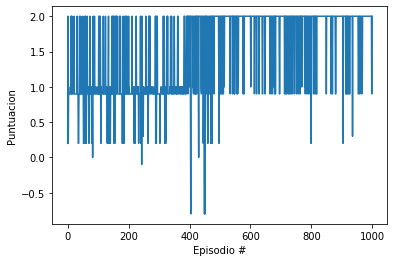

In [14]:
basic_agent_rms = Agent(state_size=115, action_size=21, seed=0, network=BasicNet, optim_fn='rmsprop')

scores = dqn(basic_agent_rms, env, n_episodes=1000)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Puntuacion')
plt.xlabel('Episodio #')
plt.show()

La red más pequeña

I0816 15:15:44.718504 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:44.722755 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 144.7, gameFPS: 384.2
I0816 15:15:44.987156 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:44.988369 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:44.989286 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 58.9, gameFPS: 274.3


Episodio 2	Puntuacion media (ultimos 50):1.10

I0816 15:15:45.849216 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:45.850529 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 85.9, gameFPS: 343.5


Episodio 3	Puntuacion media (ultimos 50):0.80

I0816 15:15:46.575259 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:46.582001 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 94.3, gameFPS: 346.6


Episodio 4	Puntuacion media (ultimos 50):0.85

I0816 15:15:47.129732 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:47.131193 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 27, FPS: 50.2, gameFPS: 207.8


Episodio 5	Puntuacion media (ultimos 50):0.86

I0816 15:15:47.986286 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:47.987658 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 78.2, gameFPS: 268.6


Episodio 6	Puntuacion media (ultimos 50):0.87

I0816 15:15:48.629950 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:48.630890 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 84.9, gameFPS: 287.2


Episodio 7	Puntuacion media (ultimos 50):0.87

I0816 15:15:49.391706 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:49.392705 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 99.0, gameFPS: 423.4


Episodio 8	Puntuacion media (ultimos 50):0.88

I0816 15:15:49.686729 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:49.687952 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 22, FPS: 76.8, gameFPS: 274.2


Episodio 9	Puntuacion media (ultimos 50):0.88

I0816 15:15:50.421893 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:50.426320 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 108.7, gameFPS: 353.4


Episodio 10	Puntuacion media (ultimos 50):0.88

I0816 15:15:51.080429 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:51.081460 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 110.1, gameFPS: 454.5


Episodio 11	Puntuacion media (ultimos 50):0.88

I0816 15:15:51.306081 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:51.307492 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:51.308484 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 58.9, gameFPS: 257.5


Episodio 12	Puntuacion media (ultimos 50):0.98

I0816 15:15:51.842023 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:51.842990 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 131.4, gameFPS: 485.2


Episodio 13	Puntuacion media (ultimos 50):0.92

I0816 15:15:52.421944 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:52.422876 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 127.5, gameFPS: 450.5


Episodio 14	Puntuacion media (ultimos 50):0.91

I0816 15:15:52.906986 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:52.907965 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 60, FPS: 125.9, gameFPS: 419.6


Episodio 15	Puntuacion media (ultimos 50):0.91

I0816 15:15:53.506647 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:53.509226 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 125.5, gameFPS: 432.7


Episodio 16	Puntuacion media (ultimos 50):0.91

I0816 15:15:54.107650 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:54.108548 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 114.7, gameFPS: 456.7
I0816 15:15:54.285051 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:54.286445 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:54.287310 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 55.7, gameFPS: 254.8


Episodio 18	Puntuacion media (ultimos 50):0.93

I0816 15:15:54.964890 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:54.965800 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 128.0, gameFPS: 384.6


Episodio 19	Puntuacion media (ultimos 50):0.88

I0816 15:15:55.584230 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:55.585088 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 137.7, gameFPS: 463.0
I0816 15:15:55.741858 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:55.743266 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:55.744062 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 66.3, gameFPS: 277.4


Episodio 21	Puntuacion media (ultimos 50):0.90

I0816 15:15:56.391968 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:56.393114 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 107.8, gameFPS: 447.5


Episodio 22	Puntuacion media (ultimos 50):0.87

I0816 15:15:57.085630 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:15:57.087931 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:57.088775 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 91, FPS: 132.0, gameFPS: 438.2
I0816 15:15:57.282181 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:57.283371 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:57.284074 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 85.8, gameFPS: 351.1


Episodio 24	Puntuacion media (ultimos 50):0.85

I0816 15:15:57.857518 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:57.858377 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 134.0, gameFPS: 476.9


Episodio 26	Puntuacion media (ultimos 50):0.85

I0816 15:15:58.875571 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:58.876439 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 15, FPS: 65.3, gameFPS: 236.2


Episodio 27	Puntuacion media (ultimos 50):0.86

I0816 15:15:59.424444 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:59.425313 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 128.3, gameFPS: 463.5
I0816 15:15:59.625123 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:59.626187 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:59.626801 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 67.2, gameFPS: 221.3


Episodio 28	Puntuacion media (ultimos 50):0.83

I0816 15:15:59.822305 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:15:59.824910 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:15:59.825838 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 91.4, gameFPS: 578.6


Episodio 30	Puntuacion media (ultimos 50):0.91

I0816 15:16:00.345783 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:00.346554 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 134.5, gameFPS: 527.7


Episodio 31	Puntuacion media (ultimos 50):0.89

I0816 15:16:00.972198 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:00.976051 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 113.0, gameFPS: 410.2


Episodio 32	Puntuacion media (ultimos 50):0.87

I0816 15:16:01.786749 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:01.787636 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 111.6, gameFPS: 327.6


Episodio 33	Puntuacion media (ultimos 50):0.87

I0816 15:16:02.371227 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:02.375171 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 119.2, gameFPS: 494.0
I0816 15:16:02.624747 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:02.625733 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 70.9, gameFPS: 241.5


Episodio 35	Puntuacion media (ultimos 50):0.85

I0816 15:16:03.254479 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:03.255766 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 112.2, gameFPS: 411.1


Episodio 36	Puntuacion media (ultimos 50):0.83

I0816 15:16:04.081426 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:04.086944 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 102.5, gameFPS: 340.8


Episodio 37	Puntuacion media (ultimos 50):0.81

I0816 15:16:04.412591 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:04.414227 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:04.417954 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 56.6, gameFPS: 247.5


Episodio 38	Puntuacion media (ultimos 50):0.84

I0816 15:16:05.497403 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:05.499834 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:05.501834 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 59.0, gameFPS: 225.1


Episodio 41	Puntuacion media (ultimos 50):0.88

I0816 15:16:07.798936 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:07.800063 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 68.2, gameFPS: 455.0
I0816 15:16:08.058218 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:08.059518 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:08.060748 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 55.0, gameFPS: 250.7


Episodio 43	Puntuacion media (ultimos 50):0.89

I0816 15:16:09.483016 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:09.485585 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 55.2, gameFPS: 279.0


Episodio 44	Puntuacion media (ultimos 50):0.89

I0816 15:16:10.199604 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:10.200698 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 121.8, gameFPS: 461.5


Episodio 46	Puntuacion media (ultimos 50):0.87

I0816 15:16:11.213528 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:11.214634 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 23, FPS: 88.0, gameFPS: 278.8


Episodio 48	Puntuacion media (ultimos 50):0.87

I0816 15:16:12.879691 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:12.886052 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 94, FPS: 99.5, gameFPS: 376.9


Episodio 50	Puntuacion media (50 anteriores): 0.88


I0816 15:16:14.506924 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:14.507905 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 99.0, gameFPS: 413.3


Episodio 51	Puntuacion media (ultimos 50):0.89

I0816 15:16:15.163886 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:15.164759 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 115.8, gameFPS: 439.0


Episodio 53	Puntuacion media (ultimos 50):0.88

I0816 15:16:16.176424 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:16.177520 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:16.178129 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 88.9, gameFPS: 371.2


Episodio 54	Puntuacion media (ultimos 50):0.90

I0816 15:16:16.501636 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:16.502995 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:16.504255 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 30, FPS: 94.3, gameFPS: 374.1
I0816 15:16:16.701650 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:16.707669 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:16.711760 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 51.0, gameFPS: 509.7


Episodio 56	Puntuacion media (ultimos 50):0.95

I0816 15:16:16.883272 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:16.884294 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:16.884869 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 62.4, gameFPS: 269.5


Episodio 58	Puntuacion media (ultimos 50):0.95

I0816 15:16:18.557048 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:18.557835 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 91.7, gameFPS: 394.8


Episodio 59	Puntuacion media (ultimos 50):0.95

I0816 15:16:19.060755 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:19.062187 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 48, FPS: 97.4, gameFPS: 442.6


Episodio 60	Puntuacion media (ultimos 50):0.95

I0816 15:16:19.681796 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:19.688357 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 114.7, gameFPS: 403.9


Episodio 61	Puntuacion media (ultimos 50):0.94

I0816 15:16:20.286385 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:20.287369 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 138.7, gameFPS: 495.9


Episodio 62	Puntuacion media (ultimos 50):0.92

I0816 15:16:21.080119 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:16:21.082970 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:21.087438 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 98, FPS: 124.2, gameFPS: 373.0


Episodio 63	Puntuacion media (ultimos 50):0.90

I0816 15:16:21.740475 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:21.751830 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 80.1, gameFPS: 325.4


Episodio 64	Puntuacion media (ultimos 50):0.90

I0816 15:16:22.938858 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:22.940901 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 73.0, gameFPS: 273.3
I0816 15:16:23.183831 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:23.185642 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:23.187262 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 72.7, gameFPS: 311.9


Episodio 66	Puntuacion media (ultimos 50):0.91

I0816 15:16:23.658277 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:23.663898 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 13, FPS: 28.1, gameFPS: 119.9


Episodio 67	Puntuacion media (ultimos 50):0.90

I0816 15:16:24.430584 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:24.435223 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 61, FPS: 80.9, gameFPS: 267.0


Episodio 68	Puntuacion media (ultimos 50):0.88

I0816 15:16:25.442449 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:25.445452 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 86.5, gameFPS: 310.2


Episodio 69	Puntuacion media (ultimos 50):0.90

I0816 15:16:25.924978 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:25.926409 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 44, FPS: 94.8, gameFPS: 393.1


Episodio 70	Puntuacion media (ultimos 50):0.92

I0816 15:16:26.728781 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:26.735471 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 88.8, gameFPS: 328.1
I0816 15:16:26.957085 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:26.958391 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:26.959157 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 47.0, gameFPS: 195.6


Episodio 72	Puntuacion media (ultimos 50):0.92

I0816 15:16:27.754855 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:27.755669 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 109.2, gameFPS: 496.8


Episodio 74	Puntuacion media (ultimos 50):0.91

I0816 15:16:29.248021 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:29.249001 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 101.1, gameFPS: 329.6
I0816 15:16:29.465378 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:29.466554 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:29.467142 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 91.1, gameFPS: 379.7


Episodio 76	Puntuacion media (ultimos 50):0.94

I0816 15:16:30.041069 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:30.041957 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 144.9, gameFPS: 540.9


Episodio 77	Puntuacion media (ultimos 50):0.92

I0816 15:16:30.591579 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:30.592458 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 131.0, gameFPS: 459.2


Episodio 78	Puntuacion media (ultimos 50):0.94

I0816 15:16:31.064531 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:31.065762 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 59, FPS: 127.2, gameFPS: 444.1


Episodio 81	Puntuacion media (ultimos 50):0.91

I0816 15:16:33.321091 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:16:33.322388 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:33.323675 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 95, FPS: 122.8, gameFPS: 416.7


Episodio 82	Puntuacion media (ultimos 50):0.90

I0816 15:16:34.451260 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:34.452359 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 93, FPS: 83.1, gameFPS: 277.7


Episodio 83	Puntuacion media (ultimos 50):0.90

I0816 15:16:35.527685 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:35.528929 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 80.0, gameFPS: 297.9


Episodio 84	Puntuacion media (ultimos 50):0.90

I0816 15:16:36.478717 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:36.479766 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 93.1, gameFPS: 359.7


Episodio 85	Puntuacion media (ultimos 50):0.90

I0816 15:16:37.326415 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:37.335842 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 83.6, gameFPS: 347.4


Episodio 86	Puntuacion media (ultimos 50):0.90

I0816 15:16:38.320764 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:38.325132 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 81.6, gameFPS: 332.5


Episodio 87	Puntuacion media (ultimos 50):0.92

I0816 15:16:38.626094 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:38.627295 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:38.628053 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 55.4, gameFPS: 240.3


Episodio 88	Puntuacion media (ultimos 50):0.92

I0816 15:16:39.459109 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:39.460106 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 101.4, gameFPS: 388.7
I0816 15:16:39.664251 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:39.665462 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:39.666153 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 52.9, gameFPS: 229.9


Episodio 92	Puntuacion media (ultimos 50):0.94

I0816 15:16:41.828196 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:41.829316 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:41.830035 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 66.2, gameFPS: 288.1


Episodio 93	Puntuacion media (ultimos 50):0.94

I0816 15:16:42.692315 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:42.696721 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 103.9, gameFPS: 402.8
I0816 15:16:42.951765 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:42.953991 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:42.955236 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 64.7, gameFPS: 283.5


Episodio 95	Puntuacion media (ultimos 50):0.97

I0816 15:16:43.238042 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:43.239757 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:43.241336 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 61.0, gameFPS: 272.2


Episodio 98	Puntuacion media (ultimos 50):1.00

I0816 15:16:46.357426 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:46.359667 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 89.5, gameFPS: 376.7
I0816 15:16:46.585966 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:46.589088 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:46.590533 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 50.7, gameFPS: 432.9


Episodio 100	Puntuacion media (50 anteriores): 1.01


I0816 15:16:47.383314 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:47.384186 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 95.4, gameFPS: 398.8


Episodio 101	Puntuacion media (ultimos 50):1.01

I0816 15:16:47.974903 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:47.975737 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 85.7, gameFPS: 288.2


Episodio 102	Puntuacion media (ultimos 50):1.01

I0816 15:16:48.981280 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:16:48.982741 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:48.991775 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 97, FPS: 97.4, gameFPS: 343.0
I0816 15:16:49.215257 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:49.216399 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:49.217008 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 46.8, gameFPS: 227.7


Episodio 104	Puntuacion media (ultimos 50):0.99

I0816 15:16:50.233769 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:50.234889 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 99, FPS: 98.5, gameFPS: 355.7


Episodio 105	Puntuacion media (ultimos 50):0.96

I0816 15:16:50.834191 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:50.835165 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 88.4, gameFPS: 344.0


Episodio 106	Puntuacion media (ultimos 50):0.94

I0816 15:16:51.075409 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:51.077006 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:51.077729 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 51.8, gameFPS: 238.3


Episodio 108	Puntuacion media (ultimos 50):0.96

I0816 15:16:53.044783 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:53.045637 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 91.1, gameFPS: 363.0


Episodio 109	Puntuacion media (ultimos 50):0.96

I0816 15:16:53.445924 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:53.446934 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:53.448235 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 31, FPS: 78.5, gameFPS: 341.2


Episodio 110	Puntuacion media (ultimos 50):0.98

I0816 15:16:54.015866 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:54.016956 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:54.019664 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 27, FPS: 48.7, gameFPS: 206.5


Episodio 111	Puntuacion media (ultimos 50):1.02

I0816 15:16:54.498280 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:54.499157 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 26, FPS: 57.9, gameFPS: 273.4


Episodio 112	Puntuacion media (ultimos 50):1.02

I0816 15:16:55.254956 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:55.263480 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 114.6, gameFPS: 475.5


Episodio 114	Puntuacion media (ultimos 50):1.04

I0816 15:16:57.389544 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:57.394880 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 88.6, gameFPS: 348.0


Episodio 115	Puntuacion media (ultimos 50):1.04

I0816 15:16:57.683153 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:57.684072 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 60.6, gameFPS: 272.9


Episodio 116	Puntuacion media (ultimos 50):1.02

I0816 15:16:57.981905 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:57.982999 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:57.983628 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 31, FPS: 111.5, gameFPS: 462.5


Episodio 117	Puntuacion media (ultimos 50):1.06

I0816 15:16:58.542898 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:58.548937 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 127.2, gameFPS: 473.4
I0816 15:16:58.732961 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:16:58.734103 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:58.734717 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 55.6, gameFPS: 266.1


Episodio 119	Puntuacion media (ultimos 50):1.06

I0816 15:16:59.218601 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:59.220273 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 44, FPS: 94.7, gameFPS: 415.4


Episodio 120	Puntuacion media (ultimos 50):1.06

I0816 15:16:59.853389 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:16:59.858012 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 126.8, gameFPS: 424.2


Episodio 121	Puntuacion media (ultimos 50):1.08

I0816 15:17:00.456429 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:00.457413 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 117.1, gameFPS: 443.8


Episodio 122	Puntuacion media (ultimos 50):1.04

I0816 15:17:01.031999 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:01.032906 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 115.1, gameFPS: 323.4


Episodio 123	Puntuacion media (ultimos 50):1.04

I0816 15:17:01.557627 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:01.559245 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 126.2, gameFPS: 406.8


Episodio 124	Puntuacion media (ultimos 50):1.06

I0816 15:17:01.817745 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:01.818503 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 25, FPS: 99.1, gameFPS: 342.7
I0816 15:17:02.062801 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:02.063688 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 79.8, gameFPS: 272.3


Episodio 126	Puntuacion media (ultimos 50):1.04

I0816 15:17:02.553881 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:02.564165 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 57, FPS: 117.9, gameFPS: 350.6


Episodio 130	Puntuacion media (ultimos 50):1.04

I0816 15:17:05.010007 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:05.010783 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 127.8, gameFPS: 369.3


Episodio 131	Puntuacion media (ultimos 50):1.04

I0816 15:17:05.567706 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:05.568597 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 159.6, gameFPS: 599.4


Episodio 132	Puntuacion media (ultimos 50):1.06

I0816 15:17:06.171644 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:06.172649 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 154.8, gameFPS: 529.9


Episodio 134	Puntuacion media (ultimos 50):1.08

I0816 15:17:07.410769 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:07.411824 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 139.6, gameFPS: 517.3


Episodio 135	Puntuacion media (ultimos 50):1.08

I0816 15:17:07.826110 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:07.826997 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 57, FPS: 139.4, gameFPS: 504.6
I0816 15:17:08.000090 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:08.001290 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:08.001936 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 86.4, gameFPS: 358.7


Episodio 137	Puntuacion media (ultimos 50):1.11

I0816 15:17:08.606093 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:08.607170 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 135.4, gameFPS: 462.0


Episodio 138	Puntuacion media (ultimos 50):1.09

I0816 15:17:09.271510 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:09.272393 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 131.2, gameFPS: 446.2


Episodio 139	Puntuacion media (ultimos 50):1.07

I0816 15:17:09.847627 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:09.848632 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 122.7, gameFPS: 444.2


Episodio 140	Puntuacion media (ultimos 50):1.04

I0816 15:17:10.509802 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:10.510942 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 131.6, gameFPS: 477.4


Episodio 141	Puntuacion media (ultimos 50):1.04

I0816 15:17:11.132742 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:11.133721 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 126.6, gameFPS: 430.9
I0816 15:17:11.314273 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:11.315870 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:11.319654 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 56.8, gameFPS: 236.9


Episodio 143	Puntuacion media (ultimos 50):1.04

I0816 15:17:11.588969 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:11.589811 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 24, FPS: 92.5, gameFPS: 314.3


Episodio 144	Puntuacion media (ultimos 50):1.04

I0816 15:17:12.051257 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:12.052266 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 118.7, gameFPS: 373.2


Episodio 146	Puntuacion media (ultimos 50):0.99

I0816 15:17:13.332195 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:13.333164 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 132.4, gameFPS: 462.4


Episodio 147	Puntuacion media (ultimos 50):0.98

I0816 15:17:14.027709 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:14.029660 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 122.1, gameFPS: 428.6
I0816 15:17:14.193238 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:14.194564 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:14.195458 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 82.4, gameFPS: 374.7


Episodio 149	Puntuacion media (ultimos 50):1.01

I0816 15:17:14.469060 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:14.470054 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 25, FPS: 96.1, gameFPS: 333.2
I0816 15:17:14.636186 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:14.637214 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:14.637799 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 93.9, gameFPS: 700.4


Episodio 150	Puntuacion media (50 anteriores): 0.99
Episodio 151	Puntuacion media (ultimos 50):1.01

I0816 15:17:15.014813 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:15.015789 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 45, FPS: 121.7, gameFPS: 477.8
I0816 15:17:15.178306 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:15.179959 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:15.183811 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 57.0, gameFPS: 491.9


Episodio 153	Puntuacion media (ultimos 50):1.05

I0816 15:17:15.454856 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:15.455668 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 70.5, gameFPS: 254.4


Episodio 154	Puntuacion media (ultimos 50):1.03

I0816 15:17:16.356919 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:16.357828 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 95, FPS: 106.6, gameFPS: 408.1


Episodio 155	Puntuacion media (ultimos 50):1.03

I0816 15:17:16.901253 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:16.902250 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 125.2, gameFPS: 405.3


Episodio 156	Puntuacion media (ultimos 50):1.03

I0816 15:17:17.448218 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:17.449212 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 128.3, gameFPS: 412.4
I0816 15:17:17.607900 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:17.609025 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:17.609634 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 66.2, gameFPS: 286.9


Episodio 158	Puntuacion media (ultimos 50):1.03

I0816 15:17:17.770770 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:17.771892 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:17.772444 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 65.0, gameFPS: 269.1


Episodio 159	Puntuacion media (ultimos 50):1.05

I0816 15:17:18.336633 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:18.337612 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 124.2, gameFPS: 401.0


Episodio 160	Puntuacion media (ultimos 50):1.03

I0816 15:17:18.727880 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:18.728763 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 43, FPS: 112.6, gameFPS: 369.1


Episodio 161	Puntuacion media (ultimos 50):1.01

I0816 15:17:19.381472 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:19.382499 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 96, FPS: 148.4, gameFPS: 477.1


Episodio 162	Puntuacion media (ultimos 50):1.01

I0816 15:17:19.771963 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:19.772751 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 135.6, gameFPS: 477.9


Episodio 163	Puntuacion media (ultimos 50):1.02

I0816 15:17:20.375686 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:20.376698 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 150.6, gameFPS: 496.6


Episodio 164	Puntuacion media (ultimos 50):1.02

I0816 15:17:20.668895 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:20.670003 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:20.670618 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 36, FPS: 126.3, gameFPS: 519.6


Episodio 166	Puntuacion media (ultimos 50):1.06

I0816 15:17:22.224787 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:22.225894 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 110.4, gameFPS: 488.4


Episodio 167	Puntuacion media (ultimos 50):1.04

I0816 15:17:22.922768 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:22.923780 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:22.924447 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 96, FPS: 138.5, gameFPS: 504.6


Episodio 168	Puntuacion media (ultimos 50):1.07

I0816 15:17:23.466818 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:23.467758 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 147.8, gameFPS: 540.5
I0816 15:17:23.648550 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:23.649650 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:23.650247 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 87.0, gameFPS: 377.0


Episodio 170	Puntuacion media (ultimos 50):1.08

I0816 15:17:24.150933 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:24.151844 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 143.8, gameFPS: 523.5


Episodio 171	Puntuacion media (ultimos 50):1.08

I0816 15:17:24.645993 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:24.647044 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 146.4, gameFPS: 568.4
I0816 15:17:24.797281 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:24.798445 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:24.799152 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 69.9, gameFPS: 314.8


Episodio 173	Puntuacion media (ultimos 50):1.11

I0816 15:17:24.960455 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:24.964898 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:24.965916 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 70.0, gameFPS: 287.5
I0816 15:17:25.113341 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:25.114405 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:25.118370 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 87.5, gameFPS: 563.6


Episodio 175	Puntuacion media (ultimos 50):1.15

I0816 15:17:25.528898 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:25.532685 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 129.2, gameFPS: 562.7
I0816 15:17:25.693955 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:25.695286 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:25.696029 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 65.5, gameFPS: 270.7


Episodio 177	Puntuacion media (ultimos 50):1.17

I0816 15:17:25.944998 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:25.945962 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:25.946513 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 22, FPS: 90.5, gameFPS: 332.1
I0816 15:17:26.135476 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:26.136484 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:26.143370 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 50.4, gameFPS: 600.1


Episodio 179	Puntuacion media (ultimos 50):1.23

I0816 15:17:26.373844 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:26.375031 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:26.375627 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 46.0, gameFPS: 245.6


Episodio 180	Puntuacion media (ultimos 50):1.25

I0816 15:17:26.981966 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:26.986918 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 125.0, gameFPS: 505.9


Episodio 182	Puntuacion media (ultimos 50):1.25

I0816 15:17:28.698397 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:28.699566 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 127.4, gameFPS: 438.4


Episodio 184	Puntuacion media (ultimos 50):1.25

I0816 15:17:29.896716 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:29.897601 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 43, FPS: 100.9, gameFPS: 389.2


Episodio 185	Puntuacion media (ultimos 50):1.25

I0816 15:17:30.613158 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:30.614162 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 129.8, gameFPS: 393.8
I0816 15:17:30.771740 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:30.772840 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:30.773419 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 72.0, gameFPS: 339.7


Episodio 187	Puntuacion media (ultimos 50):1.25

I0816 15:17:31.533711 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:31.535101 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 120.9, gameFPS: 454.6


Episodio 188	Puntuacion media (ultimos 50):1.25

I0816 15:17:32.204660 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:32.205740 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 121.4, gameFPS: 413.0


Episodio 189	Puntuacion media (ultimos 50):1.27

I0816 15:17:32.804830 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:32.806555 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 135.6, gameFPS: 487.8


Episodio 190	Puntuacion media (ultimos 50):1.28

I0816 15:17:33.425265 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:33.426954 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 132.0, gameFPS: 470.0


Episodio 191	Puntuacion media (ultimos 50):1.28

I0816 15:17:34.038925 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:34.039907 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 135.3, gameFPS: 460.5


Episodio 193	Puntuacion media (ultimos 50):1.26

I0816 15:17:35.036909 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:35.038451 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:35.039092 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 29, FPS: 106.2, gameFPS: 415.2


Episodio 194	Puntuacion media (ultimos 50):1.28

I0816 15:17:35.649046 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:35.649926 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 95, FPS: 157.3, gameFPS: 567.2
I0816 15:17:35.906433 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:35.907322 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 25, FPS: 101.3, gameFPS: 344.8


Episodio 196	Puntuacion media (ultimos 50):1.28

I0816 15:17:36.617467 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:36.618468 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:36.619127 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 100, FPS: 142.4, gameFPS: 504.1


Episodio 198	Puntuacion media (ultimos 50):1.32

I0816 15:17:37.586298 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:37.587904 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:37.588635 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 96.2, gameFPS: 375.8


Episodio 199	Puntuacion media (ultimos 50):1.32

I0816 15:17:38.039818 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:38.040778 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 117.3, gameFPS: 356.4


Episodio 200	Puntuacion media (50 anteriores): 1.32


I0816 15:17:38.373961 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:38.374718 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 34, FPS: 104.5, gameFPS: 338.1


Episodio 201	Puntuacion media (ultimos 50):1.30

I0816 15:17:38.934863 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:38.935935 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 126.7, gameFPS: 405.9


Episodio 202	Puntuacion media (ultimos 50):1.30

I0816 15:17:39.497562 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:39.498761 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 97.6, gameFPS: 316.5


Episodio 203	Puntuacion media (ultimos 50):1.28

I0816 15:17:39.912308 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:39.913439 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 47, FPS: 115.9, gameFPS: 480.0


Episodio 204	Puntuacion media (ultimos 50):1.28

I0816 15:17:40.659544 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:40.663379 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 117.4, gameFPS: 397.4


Episodio 206	Puntuacion media (ultimos 50):1.28

I0816 15:17:42.266525 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:42.267453 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 108.4, gameFPS: 325.3


Episodio 207	Puntuacion media (ultimos 50):1.28

I0816 15:17:42.965962 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:42.966895 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 108.9, gameFPS: 421.3


Episodio 208	Puntuacion media (ultimos 50):1.26

I0816 15:17:43.955333 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:43.959947 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 88.9, gameFPS: 386.6


Episodio 209	Puntuacion media (ultimos 50):1.24

I0816 15:17:44.989830 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:44.999042 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 74.9, gameFPS: 314.4


Episodio 210	Puntuacion media (ultimos 50):1.24

I0816 15:17:46.168639 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:46.169785 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 67.7, gameFPS: 357.2


Episodio 211	Puntuacion media (ultimos 50):1.24

I0816 15:17:46.493982 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:46.495868 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:46.497514 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 50.5, gameFPS: 238.2


Episodio 212	Puntuacion media (ultimos 50):1.26

I0816 15:17:47.548215 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:47.549731 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 81.8, gameFPS: 349.7


Episodio 213	Puntuacion media (ultimos 50):1.26

I0816 15:17:48.298005 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:48.302981 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 95.6, gameFPS: 396.3


Episodio 214	Puntuacion media (ultimos 50):1.25

I0816 15:17:49.097439 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:49.100695 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 104.1, gameFPS: 398.5


Episodio 216	Puntuacion media (ultimos 50):1.23

I0816 15:17:50.697772 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:50.699069 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:50.699965 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 59.7, gameFPS: 255.5


Episodio 219	Puntuacion media (ultimos 50):1.21

I0816 15:17:51.998593 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:51.999369 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 137.9, gameFPS: 534.4
I0816 15:17:52.228492 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:52.229588 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:52.230233 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 107.9, gameFPS: 465.4


Episodio 221	Puntuacion media (ultimos 50):1.21

I0816 15:17:52.445537 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:52.446492 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 87.9, gameFPS: 300.8


Episodio 222	Puntuacion media (ultimos 50):1.21

I0816 15:17:52.984870 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:52.985819 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 132.3, gameFPS: 444.7


Episodio 224	Puntuacion media (ultimos 50):1.16

I0816 15:17:54.194661 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:54.195640 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 57, FPS: 119.3, gameFPS: 380.8


Episodio 225	Puntuacion media (ultimos 50):1.14

I0816 15:17:54.629677 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:54.630891 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 117.7, gameFPS: 368.0


Episodio 226	Puntuacion media (ultimos 50):1.14

I0816 15:17:55.256258 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:55.257222 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 132.7, gameFPS: 441.6


Episodio 227	Puntuacion media (ultimos 50):1.12

I0816 15:17:55.837468 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:55.838573 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 131.0, gameFPS: 459.0


Episodio 228	Puntuacion media (ultimos 50):1.10

I0816 15:17:56.753269 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:56.754256 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 93.9, gameFPS: 368.2


Episodio 229	Puntuacion media (ultimos 50):1.08

I0816 15:17:57.068890 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:57.069841 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 26, FPS: 85.1, gameFPS: 325.4


Episodio 230	Puntuacion media (ultimos 50):1.06

I0816 15:17:57.330925 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:57.335767 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:57.339948 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 61.9, gameFPS: 190.6


Episodio 231	Puntuacion media (ultimos 50):1.08

I0816 15:17:57.638352 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:17:57.639762 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:57.640356 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 42.1, gameFPS: 287.6


Episodio 233	Puntuacion media (ultimos 50):1.10

I0816 15:17:59.222007 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:59.222863 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 76.3, gameFPS: 298.1


Episodio 234	Puntuacion media (ultimos 50):1.10

I0816 15:17:59.831511 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:17:59.832832 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 39, FPS: 64.8, gameFPS: 340.2


Episodio 235	Puntuacion media (ultimos 50):1.10

I0816 15:18:00.543926 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:00.555282 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 96.7, gameFPS: 373.6


Episodio 236	Puntuacion media (ultimos 50):1.10

I0816 15:18:01.072849 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:18:01.074599 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:01.077037 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 47.0, gameFPS: 243.1


Episodio 238	Puntuacion media (ultimos 50):1.08

I0816 15:18:03.537836 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:03.541726 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 65.7, gameFPS: 428.2


Episodio 239	Puntuacion media (ultimos 50):1.08

I0816 15:18:04.095963 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:04.100079 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 48, FPS: 88.0, gameFPS: 465.3


Episodio 240	Puntuacion media (ultimos 50):1.09

I0816 15:18:05.741518 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:05.742617 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 97, FPS: 59.8, gameFPS: 338.2


Episodio 241	Puntuacion media (ultimos 50):1.08

I0816 15:18:06.539925 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:06.541432 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 108.5, gameFPS: 467.7


Episodio 242	Puntuacion media (ultimos 50):1.08

I0816 15:18:07.274224 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:07.275129 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 28, FPS: 38.7, gameFPS: 193.8


Episodio 243	Puntuacion media (ultimos 50):1.09

I0816 15:18:07.644448 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:18:07.645670 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:07.646369 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 28, FPS: 78.6, gameFPS: 316.8


Episodio 244	Puntuacion media (ultimos 50):1.09

I0816 15:18:08.446978 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:08.450963 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 95.7, gameFPS: 354.8


Episodio 245	Puntuacion media (ultimos 50):1.08

I0816 15:18:09.528252 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:09.529731 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 74.7, gameFPS: 399.4


Episodio 246	Puntuacion media (ultimos 50):1.08

I0816 15:18:09.845283 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:18:09.846666 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:09.847853 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 22, FPS: 70.9, gameFPS: 287.8


Episodio 248	Puntuacion media (ultimos 50):1.08

I0816 15:18:10.939488 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:18:10.940917 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:10.941653 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 22, FPS: 94.6, gameFPS: 390.9
I0816 15:18:11.086840 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:18:11.088119 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:11.091840 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 78.9, gameFPS: 610.0


Episodio 250	Puntuacion media (50 anteriores): 1.11


I0816 15:18:11.344367 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:11.345233 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 22, FPS: 89.8, gameFPS: 298.5


Episodio 252	Puntuacion media (ultimos 50):1.10

I0816 15:18:12.537652 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:12.541775 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 145.6, gameFPS: 559.1


Episodio 253	Puntuacion media (ultimos 50):1.10

I0816 15:18:13.028327 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:13.029181 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 134.5, gameFPS: 478.0
I0816 15:18:13.191673 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:18:13.192934 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:13.193621 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 64.3, gameFPS: 256.0


Episodio 255	Puntuacion media (ultimos 50):1.12

I0816 15:18:13.818525 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:13.819416 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 149.0, gameFPS: 500.3
I0816 15:18:13.985316 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:18:13.986342 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:13.987227 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 81.1, gameFPS: 349.2


Episodio 257	Puntuacion media (ultimos 50):1.14

I0816 15:18:14.395715 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:14.396647 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 139.5, gameFPS: 489.9
I0816 15:18:14.567506 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:18:14.568611 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:14.569209 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 76.3, gameFPS: 312.7


Episodio 259	Puntuacion media (ultimos 50):1.17

I0816 15:18:15.207582 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:15.208557 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 90, FPS: 142.8, gameFPS: 502.0


Episodio 260	Puntuacion media (ultimos 50):1.17

I0816 15:18:15.954754 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:15.955696 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 98, FPS: 132.7, gameFPS: 454.2


Episodio 261	Puntuacion media (ultimos 50):1.17

I0816 15:18:16.545374 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:16.546323 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 142.4, gameFPS: 527.9


Episodio 262	Puntuacion media (ultimos 50):1.14

I0816 15:18:17.076036 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:17.076895 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 135.6, gameFPS: 478.7


Episodio 265	Puntuacion media (ultimos 50):1.16

I0816 15:18:19.124817 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:19.125789 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 146.8, gameFPS: 587.5


Episodio 266	Puntuacion media (ultimos 50):1.16

I0816 15:18:19.679985 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:19.680958 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 120.5, gameFPS: 342.2


Episodio 267	Puntuacion media (ultimos 50):1.17

I0816 15:18:20.491394 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:20.492635 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 98, FPS: 122.1, gameFPS: 319.8


Episodio 268	Puntuacion media (ultimos 50):1.15

I0816 15:18:21.067351 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:21.068243 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 134.2, gameFPS: 458.8


Episodio 269	Puntuacion media (ultimos 50):1.15

I0816 15:18:21.630606 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:21.631589 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 134.5, gameFPS: 460.8


Episodio 270	Puntuacion media (ultimos 50):1.15

I0816 15:18:21.927064 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:21.928073 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 30, FPS: 104.2, gameFPS: 361.7


Episodio 271	Puntuacion media (ultimos 50):1.13

I0816 15:18:22.473404 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:22.474385 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 130.0, gameFPS: 418.7


Episodio 272	Puntuacion media (ultimos 50):1.13

I0816 15:18:23.026045 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:23.026997 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 123.0, gameFPS: 373.9


Episodio 274	Puntuacion media (ultimos 50):1.13

I0816 15:18:24.247728 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:24.248692 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 125.4, gameFPS: 410.8


Episodio 275	Puntuacion media (ultimos 50):1.13

I0816 15:18:24.885253 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:24.887215 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 90, FPS: 143.1, gameFPS: 517.4


Episodio 276	Puntuacion media (ultimos 50):1.13

I0816 15:18:25.426167 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:25.427143 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 128.0, gameFPS: 413.1


Episodio 277	Puntuacion media (ultimos 50):1.13

I0816 15:18:25.999275 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:26.000174 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 149.8, gameFPS: 503.1


Episodio 278	Puntuacion media (ultimos 50):1.13

I0816 15:18:26.500509 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:26.501292 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 154.4, gameFPS: 576.1


Episodio 279	Puntuacion media (ultimos 50):1.13

I0816 15:18:26.991804 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:26.992678 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 151.4, gameFPS: 569.8


Episodio 280	Puntuacion media (ultimos 50):1.13

I0816 15:18:27.384835 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:27.385736 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 135.7, gameFPS: 473.0


Episodio 281	Puntuacion media (ultimos 50):1.11

I0816 15:18:27.743393 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:18:27.744377 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:27.748523 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 52, FPS: 148.7, gameFPS: 671.1


Episodio 282	Puntuacion media (ultimos 50):1.11

I0816 15:18:28.271906 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:28.272944 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 158.2, gameFPS: 642.7


Episodio 283	Puntuacion media (ultimos 50):1.11

I0816 15:18:28.707864 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:28.708933 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 126.8, gameFPS: 443.3


Episodio 284	Puntuacion media (ultimos 50):1.11

I0816 15:18:29.225402 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:29.227700 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 156.0, gameFPS: 576.9


Episodio 285	Puntuacion media (ultimos 50):1.11

I0816 15:18:29.702991 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:29.703800 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 150.1, gameFPS: 562.9


Episodio 286	Puntuacion media (ultimos 50):1.11

I0816 15:18:30.041201 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:30.042112 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 40, FPS: 121.6, gameFPS: 417.2


Episodio 287	Puntuacion media (ultimos 50):1.09

I0816 15:18:30.494404 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:30.495421 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 148.0, gameFPS: 535.5


Episodio 288	Puntuacion media (ultimos 50):1.10

I0816 15:18:30.860759 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:30.861652 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 142.9, gameFPS: 555.2


Episodio 289	Puntuacion media (ultimos 50):1.10

I0816 15:18:31.357874 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:31.358661 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 129.4, gameFPS: 361.8
I0816 15:18:31.553603 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:31.554649 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 15, FPS: 80.6, gameFPS: 278.9


Episodio 291	Puntuacion media (ultimos 50):1.10

I0816 15:18:32.133838 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:32.134714 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 132.6, gameFPS: 431.8


Episodio 292	Puntuacion media (ultimos 50):1.10

I0816 15:18:32.686789 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:32.687649 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 131.9, gameFPS: 446.8


Episodio 293	Puntuacion media (ultimos 50):1.10

I0816 15:18:33.209282 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:33.210245 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 138.2, gameFPS: 517.3
I0816 15:18:33.396831 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:18:33.398088 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:33.398810 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 83.4, gameFPS: 347.8


Episodio 295	Puntuacion media (ultimos 50):1.10

I0816 15:18:33.941128 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:33.942056 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 130.9, gameFPS: 429.8


Episodio 296	Puntuacion media (ultimos 50):1.10

I0816 15:18:34.409727 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:34.410712 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 121.9, gameFPS: 389.8


Episodio 297	Puntuacion media (ultimos 50):1.08

I0816 15:18:34.641980 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:34.643072 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 84.7, gameFPS: 284.0


Episodio 298	Puntuacion media (ultimos 50):1.08

I0816 15:18:35.258310 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:35.259257 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 137.8, gameFPS: 481.1
I0816 15:18:35.430430 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:18:35.431465 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:35.432710 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.0, gameFPS: 297.4


Episodio 300	Puntuacion media (50 anteriores): 1.06


I0816 15:18:36.057195 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:36.058344 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 130.1, gameFPS: 421.6


Episodio 301	Puntuacion media (ultimos 50):1.06

I0816 15:18:36.514382 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:36.515396 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 57, FPS: 126.8, gameFPS: 362.3


Episodio 302	Puntuacion media (ultimos 50):1.06

I0816 15:18:37.051522 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:37.052449 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 154.0, gameFPS: 544.3


Episodio 303	Puntuacion media (ultimos 50):1.06

I0816 15:18:37.661593 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:37.662486 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 153.2, gameFPS: 562.4


Episodio 304	Puntuacion media (ultimos 50):1.06

I0816 15:18:38.180705 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:38.181483 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 154.6, gameFPS: 576.9


Episodio 305	Puntuacion media (ultimos 50):1.04

I0816 15:18:38.714563 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:38.716206 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 131.8, gameFPS: 377.3


Episodio 306	Puntuacion media (ultimos 50):1.04

I0816 15:18:39.061499 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:39.062523 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 47, FPS: 139.5, gameFPS: 580.0


Episodio 307	Puntuacion media (ultimos 50):1.02

I0816 15:18:39.512073 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:39.512968 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 149.2, gameFPS: 551.8


Episodio 308	Puntuacion media (ultimos 50):1.02

I0816 15:18:40.008618 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:40.009422 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 131.5, gameFPS: 374.6


Episodio 309	Puntuacion media (ultimos 50):1.00

I0816 15:18:40.416277 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:40.417162 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 135.4, gameFPS: 510.5


Episodio 310	Puntuacion media (ultimos 50):1.00

I0816 15:18:40.964165 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:40.965029 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 152.2, gameFPS: 528.1


Episodio 311	Puntuacion media (ultimos 50):1.00

I0816 15:18:41.376754 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:41.377518 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 136.5, gameFPS: 463.0


Episodio 312	Puntuacion media (ultimos 50):1.00

I0816 15:18:41.861978 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:41.862874 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 132.3, gameFPS: 387.7


Episodio 313	Puntuacion media (ultimos 50):1.00

I0816 15:18:42.198386 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:42.199204 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 45, FPS: 137.8, gameFPS: 547.9


Episodio 314	Puntuacion media (ultimos 50):1.00

I0816 15:18:42.720305 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:42.721181 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 156.4, gameFPS: 582.3


Episodio 315	Puntuacion media (ultimos 50):1.00

I0816 15:18:43.285331 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:43.286314 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 140.3, gameFPS: 546.0
I0816 15:18:43.415938 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:18:43.416997 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:43.420536 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 72.1, gameFPS: 585.5


Episodio 317	Puntuacion media (ultimos 50):1.02

I0816 15:18:43.617445 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:18:43.618495 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:43.619363 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 83.9, gameFPS: 343.5


Episodio 318	Puntuacion media (ultimos 50):1.04

I0816 15:18:44.247926 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:44.249009 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 129.0, gameFPS: 432.1
I0816 15:18:44.410469 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:18:44.411524 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:44.412119 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 65.2, gameFPS: 267.5


Episodio 320	Puntuacion media (ultimos 50):1.06

I0816 15:18:44.899857 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:44.900756 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 148.7, gameFPS: 546.2


Episodio 321	Puntuacion media (ultimos 50):1.06

I0816 15:18:45.306831 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:45.307784 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 128.1, gameFPS: 440.8
I0816 15:18:45.560180 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:45.561083 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 26, FPS: 106.5, gameFPS: 376.4


Episodio 323	Puntuacion media (ultimos 50):1.06

I0816 15:18:46.047306 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:46.048359 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 133.6, gameFPS: 478.3


Episodio 324	Puntuacion media (ultimos 50):1.05

I0816 15:18:46.598419 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:46.599473 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 140.3, gameFPS: 541.5


Episodio 325	Puntuacion media (ultimos 50):1.06

I0816 15:18:47.238558 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:47.239408 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 130.3, gameFPS: 430.3
I0816 15:18:47.402809 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:18:47.403958 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:47.404585 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 64.0, gameFPS: 268.2


Episodio 327	Puntuacion media (ultimos 50):1.07

I0816 15:18:47.942369 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:47.943311 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 134.5, gameFPS: 475.7


Episodio 328	Puntuacion media (ultimos 50):1.07

I0816 15:18:48.526013 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:48.526983 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 139.3, gameFPS: 495.9


Episodio 329	Puntuacion media (ultimos 50):1.07

I0816 15:18:48.908912 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:48.909811 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 135.4, gameFPS: 462.8


Episodio 330	Puntuacion media (ultimos 50):1.07

I0816 15:18:49.388424 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:49.389208 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 142.5, gameFPS: 523.9


Episodio 331	Puntuacion media (ultimos 50):1.07

I0816 15:18:49.923199 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:49.924122 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 163.4, gameFPS: 657.4


Episodio 332	Puntuacion media (ultimos 50):1.05

I0816 15:18:50.312987 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:50.313863 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 144.6, gameFPS: 542.3


Episodio 335	Puntuacion media (ultimos 50):1.05

I0816 15:18:52.021786 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:52.022658 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 62, FPS: 132.1, gameFPS: 389.8


Episodio 338	Puntuacion media (ultimos 50):1.05

I0816 15:18:53.825085 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:53.825971 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 90, FPS: 160.3, gameFPS: 649.2


Episodio 339	Puntuacion media (ultimos 50):1.05

I0816 15:18:54.086434 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:54.087367 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 23, FPS: 91.0, gameFPS: 311.7


Episodio 340	Puntuacion media (ultimos 50):1.05

I0816 15:18:54.389284 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:18:54.390339 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:54.391016 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 34, FPS: 114.6, gameFPS: 439.7
I0816 15:18:54.617638 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:54.618588 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 82.5, gameFPS: 281.5


Episodio 342	Puntuacion media (ultimos 50):1.08

I0816 15:18:54.747877 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:18:54.749178 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:54.752676 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 72.6, gameFPS: 577.9


Episodio 343	Puntuacion media (ultimos 50):1.10

I0816 15:18:55.284956 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:55.285829 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 137.4, gameFPS: 498.0
I0816 15:18:55.459693 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:18:55.460899 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:55.461461 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 83.6, gameFPS: 346.4


Episodio 345	Puntuacion media (ultimos 50):1.10

I0816 15:18:56.012334 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:56.013226 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 156.3, gameFPS: 572.3


Episodio 346	Puntuacion media (ultimos 50):1.10

I0816 15:18:56.396224 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:56.397113 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 139.0, gameFPS: 532.9


Episodio 347	Puntuacion media (ultimos 50):1.09

I0816 15:18:56.878264 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:56.879071 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 154.8, gameFPS: 614.4


Episodio 348	Puntuacion media (ultimos 50):1.10

I0816 15:18:57.313961 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:57.314775 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 61, FPS: 143.4, gameFPS: 525.8


Episodio 349	Puntuacion media (ultimos 50):1.09

I0816 15:18:57.991707 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:57.992667 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 95, FPS: 142.4, gameFPS: 521.0


Episodio 350	Puntuacion media (50 anteriores): 1.07


I0816 15:18:58.580602 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:58.583179 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 138.0, gameFPS: 484.2


Episodio 351	Puntuacion media (ultimos 50):1.07

I0816 15:18:58.866753 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:18:58.868201 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:58.869104 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 35, FPS: 125.5, gameFPS: 508.2


Episodio 352	Puntuacion media (ultimos 50):1.09

I0816 15:18:59.251054 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:59.251959 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 136.2, gameFPS: 467.5
I0816 15:18:59.443418 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:18:59.444530 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:18:59.445122 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 98.0, gameFPS: 407.7


Episodio 354	Puntuacion media (ultimos 50):1.11

I0816 15:19:00.000770 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:00.001825 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 156.9, gameFPS: 591.5


Episodio 355	Puntuacion media (ultimos 50):1.11

I0816 15:19:00.394613 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:00.395831 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 130.6, gameFPS: 437.1


Episodio 356	Puntuacion media (ultimos 50):1.11

I0816 15:19:00.719198 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:00.719997 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 44, FPS: 139.7, gameFPS: 614.4
I0816 15:19:00.900429 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:00.901772 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:00.902456 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 87.2, gameFPS: 371.7


Episodio 358	Puntuacion media (ultimos 50):1.13

I0816 15:19:01.112123 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:01.113204 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:01.113830 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 88.2, gameFPS: 357.8


Episodio 359	Puntuacion media (ultimos 50):1.15

I0816 15:19:01.822597 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:01.824745 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 94, FPS: 134.7, gameFPS: 422.3


Episodio 360	Puntuacion media (ultimos 50):1.15

I0816 15:19:02.492540 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:02.493523 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 134.3, gameFPS: 427.2


Episodio 361	Puntuacion media (ultimos 50):1.15

I0816 15:19:03.152422 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:03.153388 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 93, FPS: 142.8, gameFPS: 505.8


Episodio 362	Puntuacion media (ultimos 50):1.16

I0816 15:19:03.598790 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:03.599791 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 125.7, gameFPS: 427.4
I0816 15:19:03.774305 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:03.775397 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:03.776059 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.8, gameFPS: 265.9


Episodio 364	Puntuacion media (ultimos 50):1.18

I0816 15:19:04.314330 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:04.315193 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 124.6, gameFPS: 379.9


Episodio 365	Puntuacion media (ultimos 50):1.18

I0816 15:19:04.898028 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:04.900377 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 144.0, gameFPS: 574.6


Episodio 367	Puntuacion media (ultimos 50):1.14

I0816 15:19:06.080025 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:06.080837 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 141.9, gameFPS: 462.9


Episodio 368	Puntuacion media (ultimos 50):1.12

I0816 15:19:06.429987 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:06.431011 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 45, FPS: 131.5, gameFPS: 474.8
I0816 15:19:06.633538 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:06.634672 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:06.635347 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 91.4, gameFPS: 367.8


Episodio 370	Puntuacion media (ultimos 50):1.12

I0816 15:19:06.862057 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:06.863021 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 91.4, gameFPS: 315.8
I0816 15:19:07.058355 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:07.059510 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:07.060354 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 53.1, gameFPS: 230.7


Episodio 372	Puntuacion media (ultimos 50):1.14

I0816 15:19:08.031983 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:08.038101 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 96, FPS: 99.5, gameFPS: 339.3


Episodio 373	Puntuacion media (ultimos 50):1.14

I0816 15:19:08.623115 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:08.624248 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 122.8, gameFPS: 426.2


Episodio 374	Puntuacion media (ultimos 50):1.14

I0816 15:19:09.147826 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:09.148895 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 96.4, gameFPS: 323.3


Episodio 375	Puntuacion media (ultimos 50):1.14

I0816 15:19:10.116949 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:10.117946 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 93, FPS: 97.3, gameFPS: 511.7


Episodio 376	Puntuacion media (ultimos 50):1.14

I0816 15:19:10.958539 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:10.964301 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 60, FPS: 72.2, gameFPS: 323.2


Episodio 377	Puntuacion media (ultimos 50):1.12

I0816 15:19:11.937162 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:11.938382 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 68.3, gameFPS: 290.6


Episodio 378	Puntuacion media (ultimos 50):1.12

I0816 15:19:12.668689 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:12.672629 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 111.9, gameFPS: 425.3


Episodio 379	Puntuacion media (ultimos 50):1.12

I0816 15:19:13.737969 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:13.738968 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 80.5, gameFPS: 347.1


Episodio 380	Puntuacion media (ultimos 50):1.12

I0816 15:19:14.821374 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:14.822155 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 67.1, gameFPS: 163.2


Episodio 381	Puntuacion media (ultimos 50):1.12

I0816 15:19:15.562037 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:15.562979 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 99.5, gameFPS: 413.6


Episodio 382	Puntuacion media (ultimos 50):1.12

I0816 15:19:16.045010 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:16.045903 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 105.6, gameFPS: 401.6


Episodio 383	Puntuacion media (ultimos 50):1.12

I0816 15:19:16.542788 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:16.543989 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 118.9, gameFPS: 433.9


Episodio 384	Puntuacion media (ultimos 50):1.12

I0816 15:19:17.124136 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:17.125012 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 100.9, gameFPS: 257.5


Episodio 385	Puntuacion media (ultimos 50):1.12

I0816 15:19:17.712575 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:17.713479 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 110.6, gameFPS: 317.2
I0816 15:19:17.885891 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:17.886976 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:17.887571 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 60.3, gameFPS: 272.0


Episodio 387	Puntuacion media (ultimos 50):1.14

I0816 15:19:18.636328 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:18.638813 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 119.3, gameFPS: 381.5


Episodio 388	Puntuacion media (ultimos 50):1.14

I0816 15:19:19.282808 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:19.286188 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 126.2, gameFPS: 454.9


Episodio 390	Puntuacion media (ultimos 50):1.14

I0816 15:19:20.424480 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:20.425357 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 48, FPS: 130.2, gameFPS: 481.4


Episodio 391	Puntuacion media (ultimos 50):1.12

I0816 15:19:20.997695 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:20.998883 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:20.999540 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 73, FPS: 130.5, gameFPS: 494.5


Episodio 392	Puntuacion media (ultimos 50):1.14

I0816 15:19:21.525650 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:21.526622 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 121.7, gameFPS: 397.8


Episodio 393	Puntuacion media (ultimos 50):1.12

I0816 15:19:22.131791 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:22.134939 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 108.8, gameFPS: 316.0
I0816 15:19:22.311794 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:22.312963 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:22.313916 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 58.7, gameFPS: 242.7


Episodio 395	Puntuacion media (ultimos 50):1.12

I0816 15:19:22.959218 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:22.960417 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 131.0, gameFPS: 476.8
I0816 15:19:23.097644 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:23.098669 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:23.102665 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 68.4, gameFPS: 624.5


Episodio 397	Puntuacion media (ultimos 50):1.14

I0816 15:19:23.652894 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:23.654103 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 130.8, gameFPS: 500.8


Episodio 398	Puntuacion media (ultimos 50):1.14

I0816 15:19:24.303972 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:24.304863 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 131.4, gameFPS: 489.1


Episodio 399	Puntuacion media (ultimos 50):1.14

I0816 15:19:25.062922 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:25.063750 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 98, FPS: 130.1, gameFPS: 439.1


Episodio 400	Puntuacion media (50 anteriores): 1.14


I0816 15:19:25.603386 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:25.604285 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 126.7, gameFPS: 471.3


Episodio 401	Puntuacion media (ultimos 50):1.14

I0816 15:19:26.184220 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:26.188634 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 142.8, gameFPS: 517.0


Episodio 402	Puntuacion media (ultimos 50):1.12

I0816 15:19:26.637349 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:26.638304 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 116.2, gameFPS: 386.2


Episodio 403	Puntuacion media (ultimos 50):1.12

I0816 15:19:27.141680 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:27.142614 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 127.0, gameFPS: 468.2


Episodio 405	Puntuacion media (ultimos 50):1.10

I0816 15:19:28.408218 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:28.409001 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 129.5, gameFPS: 482.8


Episodio 406	Puntuacion media (ultimos 50):1.10

I0816 15:19:29.109372 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:29.110377 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 126.1, gameFPS: 469.8
I0816 15:19:29.283057 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:29.284303 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:29.284991 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 59.9, gameFPS: 214.2


Episodio 408	Puntuacion media (ultimos 50):1.10

I0816 15:19:29.968333 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:29.969120 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 122.6, gameFPS: 497.3
I0816 15:19:30.134278 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:30.135432 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:30.136157 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 64.5, gameFPS: 277.5


Episodio 410	Puntuacion media (ultimos 50):1.10

I0816 15:19:30.470892 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:30.472247 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:30.472951 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 30, FPS: 97.6, gameFPS: 419.3


Episodio 411	Puntuacion media (ultimos 50):1.12

I0816 15:19:31.126061 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:31.126925 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 127.1, gameFPS: 485.1


Episodio 412	Puntuacion media (ultimos 50):1.12

I0816 15:19:31.969816 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:31.970985 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:31.971919 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 64.9, gameFPS: 272.5


Episodio 415	Puntuacion media (ultimos 50):1.10

I0816 15:19:33.052192 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:33.053056 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 28, FPS: 95.1, gameFPS: 352.1


Episodio 416	Puntuacion media (ultimos 50):1.12

I0816 15:19:33.611374 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:33.612290 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 121.6, gameFPS: 466.5
I0816 15:19:33.787089 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:33.788182 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:33.788830 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 60.4, gameFPS: 300.9


Episodio 418	Puntuacion media (ultimos 50):1.15

I0816 15:19:34.420768 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:34.421957 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 138.2, gameFPS: 537.8


Episodio 419	Puntuacion media (ultimos 50):1.13

I0816 15:19:34.810237 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:34.811323 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 44, FPS: 114.8, gameFPS: 508.7


Episodio 421	Puntuacion media (ultimos 50):1.11

I0816 15:19:36.206881 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:36.208035 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 134.7, gameFPS: 482.6


Episodio 422	Puntuacion media (ultimos 50):1.09

I0816 15:19:36.445980 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:36.446973 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:36.447573 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 102.6, gameFPS: 427.4


Episodio 423	Puntuacion media (ultimos 50):1.11

I0816 15:19:37.378077 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:37.379392 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:37.380010 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.5, gameFPS: 308.0


Episodio 425	Puntuacion media (ultimos 50):1.13

I0816 15:19:37.639253 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:37.640178 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 25, FPS: 99.9, gameFPS: 355.5
I0816 15:19:37.888845 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:37.889774 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:37.890363 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 89.1, gameFPS: 362.9


Episodio 427	Puntuacion media (ultimos 50):1.15

I0816 15:19:38.074555 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:38.075667 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:38.076514 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 57.3, gameFPS: 284.8


Episodio 428	Puntuacion media (ultimos 50):1.18

I0816 15:19:38.575736 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:38.576590 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 57, FPS: 116.2, gameFPS: 367.7


Episodio 429	Puntuacion media (ultimos 50):1.18

I0816 15:19:39.195137 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:39.196758 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 148.4, gameFPS: 636.7


Episodio 430	Puntuacion media (ultimos 50):1.18

I0816 15:19:39.772852 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:39.773847 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 126.9, gameFPS: 450.3


Episodio 431	Puntuacion media (ultimos 50):1.17

I0816 15:19:40.271177 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:40.272055 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 137.2, gameFPS: 551.4


Episodio 432	Puntuacion media (ultimos 50):1.17

I0816 15:19:40.920464 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:40.923520 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 122.8, gameFPS: 420.5


Episodio 433	Puntuacion media (ultimos 50):1.17

I0816 15:19:41.516910 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:41.517879 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 112.6, gameFPS: 380.6


Episodio 435	Puntuacion media (ultimos 50):1.17

I0816 15:19:42.796454 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:42.797313 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 116.2, gameFPS: 388.8
I0816 15:19:43.004102 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:43.005559 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:43.006659 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 84.7, gameFPS: 361.7


Episodio 437	Puntuacion media (ultimos 50):1.17

I0816 15:19:43.673331 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:43.674185 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 128.0, gameFPS: 424.3


Episodio 438	Puntuacion media (ultimos 50):1.17

I0816 15:19:44.310054 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:44.311476 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 117.7, gameFPS: 373.3


Episodio 439	Puntuacion media (ultimos 50):1.17

I0816 15:19:44.597048 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:44.598258 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:44.599356 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 29, FPS: 104.2, gameFPS: 424.8


Episodio 443	Puntuacion media (ultimos 50):1.17

I0816 15:19:47.348072 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:47.349032 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 146.8, gameFPS: 585.6


Episodio 444	Puntuacion media (ultimos 50):1.17

I0816 15:19:47.908375 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:47.909376 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 144.3, gameFPS: 555.4


Episodio 445	Puntuacion media (ultimos 50):1.15

I0816 15:19:48.367990 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:48.368839 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 57, FPS: 126.9, gameFPS: 422.8


Episodio 447	Puntuacion media (ultimos 50):1.13

I0816 15:19:49.735660 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:49.742475 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 133.9, gameFPS: 503.2


Episodio 448	Puntuacion media (ultimos 50):1.13

I0816 15:19:50.245690 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:50.246646 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 111.0, gameFPS: 446.7


Episodio 449	Puntuacion media (ultimos 50):1.13

I0816 15:19:51.034850 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:19:51.035745 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:51.036250 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 99, FPS: 126.5, gameFPS: 414.4


Episodio 450	Puntuacion media (50 anteriores): 1.11
Episodio 451	Puntuacion media (ultimos 50):1.11

I0816 15:19:52.477378 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:52.480711 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 125.3, gameFPS: 531.6


Episodio 454	Puntuacion media (ultimos 50):1.10

I0816 15:19:55.092754 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:55.096808 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:55.099811 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 83.0, gameFPS: 635.0


Episodio 456	Puntuacion media (ultimos 50):1.11

I0816 15:19:55.600136 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:55.603952 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 110.8, gameFPS: 339.3


Episodio 457	Puntuacion media (ultimos 50):1.10

I0816 15:19:56.242098 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:56.242970 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 131.7, gameFPS: 529.3


Episodio 458	Puntuacion media (ultimos 50):1.08

I0816 15:19:56.991036 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:56.992356 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:56.993127 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 94, FPS: 127.2, gameFPS: 492.7


Episodio 459	Puntuacion media (ultimos 50):1.10

I0816 15:19:57.656219 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:57.657176 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 129.7, gameFPS: 470.9


Episodio 460	Puntuacion media (ultimos 50):1.08

I0816 15:19:58.190518 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:58.191640 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 100.8, gameFPS: 308.4


Episodio 461	Puntuacion media (ultimos 50):1.06

I0816 15:19:58.908727 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:58.909510 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 107.7, gameFPS: 419.6


Episodio 462	Puntuacion media (ultimos 50):1.06

I0816 15:19:59.231215 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:19:59.232812 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:59.235943 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 30, FPS: 96.5, gameFPS: 421.1


Episodio 463	Puntuacion media (ultimos 50):1.08

I0816 15:19:59.996033 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:19:59.996893 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 122.6, gameFPS: 385.3


Episodio 464	Puntuacion media (ultimos 50):1.06

I0816 15:20:00.672740 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:00.676657 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 126.9, gameFPS: 454.6
I0816 15:20:00.941857 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:00.942822 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 21, FPS: 82.8, gameFPS: 290.5


Episodio 465	Puntuacion media (ultimos 50):1.07

I0816 15:20:01.105452 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:20:01.106670 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:01.107316 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 65.6, gameFPS: 298.1


Episodio 467	Puntuacion media (ultimos 50):1.09

I0816 15:20:01.532515 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:01.533457 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 131.8, gameFPS: 500.6


Episodio 468	Puntuacion media (ultimos 50):1.07

I0816 15:20:02.058900 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:02.059769 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 127.1, gameFPS: 453.0


Episodio 469	Puntuacion media (ultimos 50):1.09

I0816 15:20:02.971533 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:20:02.972571 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:02.973179 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 65.9, gameFPS: 317.3


Episodio 473	Puntuacion media (ultimos 50):1.07

I0816 15:20:05.022205 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:05.025399 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 126.1, gameFPS: 457.5


Episodio 474	Puntuacion media (ultimos 50):1.08

I0816 15:20:05.601636 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:05.603049 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 121.2, gameFPS: 489.1


Episodio 475	Puntuacion media (ultimos 50):1.04

I0816 15:20:06.332336 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:06.334486 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 112.0, gameFPS: 404.6


Episodio 477	Puntuacion media (ultimos 50):1.00

I0816 15:20:07.458971 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:20:07.460453 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:07.461638 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 57.1, gameFPS: 222.1


Episodio 478	Puntuacion media (ultimos 50):1.00

I0816 15:20:08.329612 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:08.330577 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 90, FPS: 105.2, gameFPS: 392.2


Episodio 479	Puntuacion media (ultimos 50):1.00

I0816 15:20:09.103055 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:09.104588 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 91.2, gameFPS: 353.9


Episodio 480	Puntuacion media (ultimos 50):1.00

I0816 15:20:09.718316 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:09.733859 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 115.4, gameFPS: 499.8
I0816 15:20:09.953932 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:20:09.955459 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:09.956166 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 55.8, gameFPS: 209.8


Episodio 482	Puntuacion media (ultimos 50):1.02

I0816 15:20:10.213399 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:20:10.214881 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:10.217734 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 40.0, gameFPS: 239.1


Episodio 483	Puntuacion media (ultimos 50):1.05

I0816 15:20:10.981483 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:10.982472 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 90, FPS: 123.5, gameFPS: 414.3


Episodio 484	Puntuacion media (ultimos 50):1.05

I0816 15:20:11.622807 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:11.623664 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 140.6, gameFPS: 505.4


Episodio 485	Puntuacion media (ultimos 50):1.05

I0816 15:20:12.204769 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:12.205870 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 125.9, gameFPS: 496.2


Episodio 486	Puntuacion media (ultimos 50):1.05

I0816 15:20:12.537322 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:20:12.538215 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:12.539242 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 30, FPS: 92.9, gameFPS: 410.3


Episodio 487	Puntuacion media (ultimos 50):1.05

I0816 15:20:13.019447 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:13.020340 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 107.7, gameFPS: 344.1


Episodio 488	Puntuacion media (ultimos 50):1.05

I0816 15:20:13.729438 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:13.730215 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 93.0, gameFPS: 301.5


Episodio 490	Puntuacion media (ultimos 50):1.03

I0816 15:20:14.953156 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:14.954271 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 122.1, gameFPS: 446.7


Episodio 491	Puntuacion media (ultimos 50):1.03

I0816 15:20:15.465404 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:15.466474 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 111.1, gameFPS: 402.9


Episodio 492	Puntuacion media (ultimos 50):1.03

I0816 15:20:16.010142 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:16.011083 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 118.2, gameFPS: 413.8


Episodio 493	Puntuacion media (ultimos 50):1.03

I0816 15:20:16.674993 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:16.675934 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 97, FPS: 147.4, gameFPS: 526.8


Episodio 494	Puntuacion media (ultimos 50):1.03

I0816 15:20:17.204189 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:17.205205 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 136.7, gameFPS: 531.1


Episodio 495	Puntuacion media (ultimos 50):1.03

I0816 15:20:17.888646 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:17.889792 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 111.6, gameFPS: 430.6
I0816 15:20:18.172575 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:20:18.173552 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:18.174109 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 56.9, gameFPS: 259.1


Episodio 497	Puntuacion media (ultimos 50):1.05

I0816 15:20:18.422533 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:18.423421 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 78.9, gameFPS: 283.4


Episodio 499	Puntuacion media (ultimos 50):1.05

I0816 15:20:19.703887 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:19.704666 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 119.2, gameFPS: 370.6


Episodio 500	Puntuacion media (50 anteriores): 1.07


I0816 15:20:20.381603 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:20.382479 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 129.8, gameFPS: 437.7


Episodio 501	Puntuacion media (ultimos 50):1.07

I0816 15:20:21.119704 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:21.120641 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 90, FPS: 123.3, gameFPS: 397.0


Episodio 503	Puntuacion media (ultimos 50):1.06

I0816 15:20:22.411257 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:22.412184 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 116.7, gameFPS: 348.7
I0816 15:20:22.645308 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:20:22.646511 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:22.647394 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 87.0, gameFPS: 352.7


Episodio 505	Puntuacion media (ultimos 50):1.11

I0816 15:20:23.175360 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:23.176167 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 134.3, gameFPS: 497.6
I0816 15:20:23.351545 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:20:23.352751 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:23.353384 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 59.7, gameFPS: 292.8


Episodio 507	Puntuacion media (ultimos 50):1.09

I0816 15:20:23.807576 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:23.808558 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 118.1, gameFPS: 505.5


Episodio 508	Puntuacion media (ultimos 50):1.09

I0816 15:20:24.352767 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:24.353664 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 129.2, gameFPS: 469.3
I0816 15:20:24.576858 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:24.577689 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 78.4, gameFPS: 262.9


Episodio 510	Puntuacion media (ultimos 50):1.06

I0816 15:20:24.764526 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:20:24.765709 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:24.766353 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 56.6, gameFPS: 259.0


Episodio 511	Puntuacion media (ultimos 50):1.08

I0816 15:20:25.169082 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:25.170055 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 44, FPS: 111.1, gameFPS: 450.9


Episodio 512	Puntuacion media (ultimos 50):1.08

I0816 15:20:25.769618 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:25.770412 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 121.6, gameFPS: 390.1


Episodio 513	Puntuacion media (ultimos 50):1.06

I0816 15:20:26.305301 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:26.308541 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 60, FPS: 113.8, gameFPS: 344.5


Episodio 514	Puntuacion media (ultimos 50):1.06

I0816 15:20:26.922092 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:26.926277 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 122.2, gameFPS: 464.2


Episodio 515	Puntuacion media (ultimos 50):1.06

I0816 15:20:27.331685 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:27.332566 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 131.1, gameFPS: 522.3


Episodio 516	Puntuacion media (ultimos 50):1.06

I0816 15:20:27.945214 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:27.949544 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 139.6, gameFPS: 542.2


Episodio 517	Puntuacion media (ultimos 50):1.04

I0816 15:20:28.527254 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:28.528133 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 125.2, gameFPS: 471.8


Episodio 518	Puntuacion media (ultimos 50):1.04

I0816 15:20:28.832115 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:28.833081 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 32, FPS: 108.2, gameFPS: 394.0


Episodio 519	Puntuacion media (ultimos 50):1.04

I0816 15:20:29.484540 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:29.487742 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 133.6, gameFPS: 484.4


Episodio 521	Puntuacion media (ultimos 50):1.02

I0816 15:20:30.584661 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:30.585427 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 33, FPS: 101.0, gameFPS: 340.3


Episodio 522	Puntuacion media (ultimos 50):1.03

I0816 15:20:31.011892 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:31.012871 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 126.4, gameFPS: 514.8


Episodio 523	Puntuacion media (ultimos 50):1.03

I0816 15:20:31.576894 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:31.580233 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 124.3, gameFPS: 456.1


Episodio 524	Puntuacion media (ultimos 50):1.03

I0816 15:20:32.288247 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:32.289202 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 127.0, gameFPS: 459.4
I0816 15:20:32.456691 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:20:32.459303 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:32.460355 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 62.4, gameFPS: 259.2


Episodio 526	Puntuacion media (ultimos 50):1.06

I0816 15:20:33.045577 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:33.046550 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 134.7, gameFPS: 494.1


Episodio 527	Puntuacion media (ultimos 50):1.08

I0816 15:20:33.252533 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:33.253561 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 80.2, gameFPS: 284.4


Episodio 528	Puntuacion media (ultimos 50):1.06

I0816 15:20:33.873447 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:33.874309 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 135.2, gameFPS: 529.6


Episodio 529	Puntuacion media (ultimos 50):1.06

I0816 15:20:34.309798 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:34.310548 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 47, FPS: 110.8, gameFPS: 380.2


Episodio 530	Puntuacion media (ultimos 50):1.06

I0816 15:20:34.810855 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:34.811883 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 143.7, gameFPS: 572.8


Episodio 531	Puntuacion media (ultimos 50):1.06

I0816 15:20:35.539411 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:35.540419 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 95, FPS: 132.3, gameFPS: 413.5


Episodio 532	Puntuacion media (ultimos 50):1.04

I0816 15:20:36.098846 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:36.099816 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 117.6, gameFPS: 412.0


Episodio 533	Puntuacion media (ultimos 50):1.02

I0816 15:20:36.617054 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:36.618093 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 114.1, gameFPS: 388.2


Episodio 534	Puntuacion media (ultimos 50):1.01

I0816 15:20:37.396169 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:37.397160 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 114.1, gameFPS: 299.5
I0816 15:20:37.563759 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:20:37.564715 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:37.565268 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.1, gameFPS: 294.2


Episodio 536	Puntuacion media (ultimos 50):1.04

I0816 15:20:37.707109 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:20:37.708144 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:37.708668 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 66.5, gameFPS: 551.4


Episodio 538	Puntuacion media (ultimos 50):1.04

I0816 15:20:39.231302 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:20:39.232270 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:39.232845 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 67.8, gameFPS: 690.8


Episodio 540	Puntuacion media (ultimos 50):1.06

I0816 15:20:39.722730 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:39.723916 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 114.6, gameFPS: 458.5


Episodio 542	Puntuacion media (ultimos 50):1.04

I0816 15:20:40.821266 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:40.822575 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 143.7, gameFPS: 578.5


Episodio 543	Puntuacion media (ultimos 50):1.04

I0816 15:20:41.498634 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:41.499878 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 132.3, gameFPS: 501.1


Episodio 544	Puntuacion media (ultimos 50):1.04

I0816 15:20:42.210029 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:42.212661 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 125.0, gameFPS: 455.5
I0816 15:20:42.392382 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:20:42.393566 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:42.394221 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 63.9, gameFPS: 314.0


Episodio 546	Puntuacion media (ultimos 50):1.06

I0816 15:20:42.917679 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:42.918544 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 123.6, gameFPS: 414.3


Episodio 547	Puntuacion media (ultimos 50):1.04

I0816 15:20:43.353388 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:43.354276 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 118.9, gameFPS: 421.4


Episodio 548	Puntuacion media (ultimos 50):1.04

I0816 15:20:43.976246 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:43.977097 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 106.3, gameFPS: 289.6
I0816 15:20:44.234168 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:20:44.235696 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:44.236609 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 92.1, gameFPS: 384.8


Episodio 550	Puntuacion media (50 anteriores): 1.06


I0816 15:20:44.710405 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:44.715590 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 59, FPS: 127.0, gameFPS: 468.6


Episodio 551	Puntuacion media (ultimos 50):1.06

I0816 15:20:45.362147 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:45.367391 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 114.1, gameFPS: 350.6


Episodio 552	Puntuacion media (ultimos 50):1.06

I0816 15:20:46.348264 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:20:46.349370 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:46.350418 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 79.5, gameFPS: 269.4


Episodio 554	Puntuacion media (ultimos 50):1.10

I0816 15:20:47.018523 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:47.020016 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 127.0, gameFPS: 446.9


Episodio 555	Puntuacion media (ultimos 50):1.08

I0816 15:20:47.325245 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:20:47.326257 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:47.330347 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 35, FPS: 118.4, gameFPS: 646.3


Episodio 556	Puntuacion media (ultimos 50):1.12

I0816 15:20:48.035843 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:48.037003 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 117.6, gameFPS: 406.9


Episodio 557	Puntuacion media (ultimos 50):1.09

I0816 15:20:48.799046 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:48.800107 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 111.5, gameFPS: 376.2


Episodio 558	Puntuacion media (ultimos 50):1.09

I0816 15:20:49.603033 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:49.603848 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 92.0, gameFPS: 376.7


Episodio 559	Puntuacion media (ultimos 50):1.11

I0816 15:20:50.531175 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:50.534193 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 86.1, gameFPS: 342.0
I0816 15:20:50.693756 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:20:50.694858 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:50.696176 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 78.0, gameFPS: 636.6


Episodio 561	Puntuacion media (ultimos 50):1.09

I0816 15:20:51.455663 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:51.466423 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 101.8, gameFPS: 430.7


Episodio 562	Puntuacion media (ultimos 50):1.09

I0816 15:20:51.759010 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:20:51.760679 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:51.761941 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 49.4, gameFPS: 209.3


Episodio 563	Puntuacion media (ultimos 50):1.11

I0816 15:20:52.261455 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:52.262286 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 23, FPS: 46.8, gameFPS: 174.3


Episodio 564	Puntuacion media (ultimos 50):1.11

I0816 15:20:53.012451 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:53.013706 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 67.4, gameFPS: 246.0


Episodio 565	Puntuacion media (ultimos 50):1.11

I0816 15:20:53.328530 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:20:53.330590 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:53.331991 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 38.8, gameFPS: 200.1


Episodio 566	Puntuacion media (ultimos 50):1.13

I0816 15:20:54.001889 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:54.007782 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 79.8, gameFPS: 292.9


Episodio 567	Puntuacion media (ultimos 50):1.13

I0816 15:20:55.050576 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:20:55.051890 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:55.052483 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 92, FPS: 89.5, gameFPS: 341.4


Episodio 568	Puntuacion media (ultimos 50):1.11

I0816 15:20:55.685052 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:55.685911 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 126.7, gameFPS: 443.0


Episodio 570	Puntuacion media (ultimos 50):1.11

I0816 15:20:57.092857 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:57.093805 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 119.5, gameFPS: 473.1


Episodio 571	Puntuacion media (ultimos 50):1.11

I0816 15:20:57.683895 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:57.684980 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 59, FPS: 101.1, gameFPS: 251.0


Episodio 572	Puntuacion media (ultimos 50):1.11

I0816 15:20:58.300996 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:58.301999 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 109.7, gameFPS: 334.2


Episodio 573	Puntuacion media (ultimos 50):1.11

I0816 15:20:58.874777 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:58.875912 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 113.4, gameFPS: 321.1


Episodio 574	Puntuacion media (ultimos 50):1.11

I0816 15:20:59.496937 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:20:59.498123 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 138.3, gameFPS: 503.3


Episodio 575	Puntuacion media (ultimos 50):1.11

I0816 15:21:00.293846 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:00.294625 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 90.0, gameFPS: 248.7
I0816 15:21:00.558556 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:21:00.559696 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:00.560610 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 66.0, gameFPS: 269.1


Episodio 577	Puntuacion media (ultimos 50):1.12

I0816 15:21:01.158273 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:01.159095 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 31, FPS: 53.3, gameFPS: 234.4


Episodio 578	Puntuacion media (ultimos 50):1.12

I0816 15:21:02.154610 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:02.155731 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 85.0, gameFPS: 355.0


Episodio 579	Puntuacion media (ultimos 50):1.11

I0816 15:21:02.528151 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:02.529017 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 41, FPS: 112.4, gameFPS: 441.4
I0816 15:21:02.774758 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:21:02.776042 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:02.777221 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 96.8, gameFPS: 437.0


Episodio 581	Puntuacion media (ultimos 50):1.13

I0816 15:21:02.979242 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:02.980423 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 11, FPS: 56.9, gameFPS: 194.3


Episodio 582	Puntuacion media (ultimos 50):1.11

I0816 15:21:03.627475 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:03.629346 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 121.7, gameFPS: 513.6


Episodio 583	Puntuacion media (ultimos 50):1.12

I0816 15:21:04.317847 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:04.318734 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 104.3, gameFPS: 489.6
I0816 15:21:04.521709 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:21:04.522896 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:04.523485 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 92.4, gameFPS: 438.9


Episodio 586	Puntuacion media (ultimos 50):1.12

I0816 15:21:05.840459 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:05.841444 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 48, FPS: 86.5, gameFPS: 404.6


Episodio 587	Puntuacion media (ultimos 50):1.10

I0816 15:21:07.063647 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:07.065525 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 58.6, gameFPS: 221.9


Episodio 588	Puntuacion media (ultimos 50):1.10

I0816 15:21:07.896056 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:07.898719 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 105.6, gameFPS: 453.3


Episodio 591	Puntuacion media (ultimos 50):1.06

I0816 15:21:10.431653 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:10.437461 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 69.3, gameFPS: 265.1


Episodio 593	Puntuacion media (ultimos 50):1.06

I0816 15:21:12.424187 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:12.427752 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 80.5, gameFPS: 267.6
I0816 15:21:12.709297 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:21:12.711884 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled


Episodio 594	Puntuacion media (ultimos 50):1.06

I0816 15:21:12.717437 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 56.7, gameFPS: 258.7


Episodio 595	Puntuacion media (ultimos 50):1.08

I0816 15:21:13.611567 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:13.612994 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 84.6, gameFPS: 334.6


Episodio 596	Puntuacion media (ultimos 50):1.06

I0816 15:21:14.069038 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:14.074232 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 45, FPS: 100.4, gameFPS: 404.5


Episodio 597	Puntuacion media (ultimos 50):1.06

I0816 15:21:14.525236 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:14.529372 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 127.9, gameFPS: 483.6


Episodio 598	Puntuacion media (ultimos 50):1.06

I0816 15:21:14.879596 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:14.880536 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 27, FPS: 79.1, gameFPS: 277.3


Episodio 599	Puntuacion media (ultimos 50):1.06

I0816 15:21:15.362569 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:15.363442 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 60, FPS: 127.1, gameFPS: 445.6


Episodio 600	Puntuacion media (50 anteriores): 1.04


I0816 15:21:15.633993 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:21:15.635188 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:15.635818 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 32, FPS: 122.0, gameFPS: 499.9


Episodio 601	Puntuacion media (ultimos 50):1.07

I0816 15:21:16.266382 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:16.267351 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 135.0, gameFPS: 470.5


Episodio 602	Puntuacion media (ultimos 50):1.07

I0816 15:21:16.978589 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:16.979543 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 96, FPS: 136.0, gameFPS: 460.7


Episodio 605	Puntuacion media (ultimos 50):1.05

I0816 15:21:19.062954 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:19.063925 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 132.7, gameFPS: 511.7


Episodio 606	Puntuacion media (ultimos 50):1.03

I0816 15:21:20.019876 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:21:20.021041 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:20.021796 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 76.5, gameFPS: 334.5


Episodio 608	Puntuacion media (ultimos 50):1.05

I0816 15:21:20.605493 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:20.606375 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 148.4, gameFPS: 525.3


Episodio 610	Puntuacion media (ultimos 50):1.07

I0816 15:21:21.971278 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:21.972250 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 122.7, gameFPS: 391.9


Episodio 611	Puntuacion media (ultimos 50):1.05

I0816 15:21:22.422947 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:22.423938 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 117.4, gameFPS: 375.3


Episodio 612	Puntuacion media (ultimos 50):1.05

I0816 15:21:23.005109 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:23.006067 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 129.2, gameFPS: 436.7


Episodio 613	Puntuacion media (ultimos 50):1.03

I0816 15:21:23.575955 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:23.576852 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 131.6, gameFPS: 449.8


Episodio 614	Puntuacion media (ultimos 50):1.03

I0816 15:21:24.151309 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:24.152415 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 127.2, gameFPS: 411.3


Episodio 616	Puntuacion media (ultimos 50):1.01

I0816 15:21:25.390898 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:25.391901 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 117.1, gameFPS: 417.6


Episodio 617	Puntuacion media (ultimos 50):1.01

I0816 15:21:25.974856 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:25.975829 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 116.5, gameFPS: 338.0


Episodio 618	Puntuacion media (ultimos 50):1.03

I0816 15:21:26.350209 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:26.351111 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 42, FPS: 114.0, gameFPS: 411.1


Episodio 619	Puntuacion media (ultimos 50):1.03

I0816 15:21:27.225029 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:21:27.226138 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:27.227425 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 78.9, gameFPS: 562.5


Episodio 621	Puntuacion media (ultimos 50):1.05

I0816 15:21:27.901297 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:27.902087 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 136.8, gameFPS: 477.8


Episodio 622	Puntuacion media (ultimos 50):1.05

I0816 15:21:28.458605 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:28.459587 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 126.3, gameFPS: 500.6


Episodio 624	Puntuacion media (ultimos 50):1.04

I0816 15:21:29.843985 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:29.847979 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 111.3, gameFPS: 432.1


Episodio 625	Puntuacion media (ultimos 50):1.03

I0816 15:21:30.362925 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:30.366570 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 28, FPS: 55.4, gameFPS: 188.6


Episodio 626	Puntuacion media (ultimos 50):1.03

I0816 15:21:30.987737 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:30.989561 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 81.4, gameFPS: 248.9


Episodio 627	Puntuacion media (ultimos 50):1.00

I0816 15:21:31.782906 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:31.783891 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 62, FPS: 80.3, gameFPS: 276.3


Episodio 628	Puntuacion media (ultimos 50):1.00

I0816 15:21:32.552278 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:32.553268 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 109.3, gameFPS: 357.0


Episodio 629	Puntuacion media (ultimos 50):1.00

I0816 15:21:33.346993 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:33.348122 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 108.6, gameFPS: 451.6


Episodio 630	Puntuacion media (ultimos 50):0.99

I0816 15:21:34.246337 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:34.247157 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 95, FPS: 106.4, gameFPS: 416.5


Episodio 631	Puntuacion media (ultimos 50):0.97

I0816 15:21:34.997392 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:34.998263 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 106.6, gameFPS: 418.4


Episodio 632	Puntuacion media (ultimos 50):0.99

I0816 15:21:35.760778 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:35.761940 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 86.1, gameFPS: 230.8


Episodio 633	Puntuacion media (ultimos 50):0.99

I0816 15:21:36.375454 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:36.380502 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 103.5, gameFPS: 349.7


Episodio 634	Puntuacion media (ultimos 50):0.98

I0816 15:21:37.154185 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:37.156725 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 65.7, gameFPS: 226.1


Episodio 636	Puntuacion media (ultimos 50):0.96

I0816 15:21:39.020202 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:39.023979 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 78.3, gameFPS: 312.1
I0816 15:21:39.254231 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:21:39.255293 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:39.256286 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 60.6, gameFPS: 289.9


Episodio 638	Puntuacion media (ultimos 50):0.98

I0816 15:21:39.411953 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:21:39.413146 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:39.413673 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 60.4, gameFPS: 523.3
I0816 15:21:39.583593 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:21:39.584706 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:39.585282 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 62.5, gameFPS: 250.9


Episodio 640	Puntuacion media (ultimos 50):1.02

I0816 15:21:39.916432 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:21:39.917680 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:39.922324 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 34, FPS: 104.6, gameFPS: 548.3
I0816 15:21:40.175360 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:21:40.176740 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:40.177538 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 61.6, gameFPS: 331.2


Episodio 642	Puntuacion media (ultimos 50):1.08

I0816 15:21:40.771043 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:40.772114 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 126.0, gameFPS: 436.7
I0816 15:21:40.950384 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:21:40.951666 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:40.952291 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 64.1, gameFPS: 300.8


Episodio 645	Puntuacion media (ultimos 50):1.10

I0816 15:21:42.180753 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:42.181649 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 139.1, gameFPS: 497.2


Episodio 646	Puntuacion media (ultimos 50):1.10

I0816 15:21:42.844760 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:42.846601 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 134.6, gameFPS: 472.7


Episodio 647	Puntuacion media (ultimos 50):1.10

I0816 15:21:43.260058 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:43.260967 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 46.6, gameFPS: 221.0


Episodio 648	Puntuacion media (ultimos 50):1.10

I0816 15:21:43.834155 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:43.835103 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 129.3, gameFPS: 459.6


Episodio 649	Puntuacion media (ultimos 50):1.09

I0816 15:21:44.318621 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:44.319543 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 132.7, gameFPS: 515.5
I0816 15:21:44.501712 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:21:44.502960 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:44.503588 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 74.1, gameFPS: 287.5


Episodio 650	Puntuacion media (50 anteriores): 1.09
Episodio 651	Puntuacion media (ultimos 50):1.09

I0816 15:21:45.263132 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:45.263980 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 99, FPS: 132.2, gameFPS: 422.2


Episodio 652	Puntuacion media (ultimos 50):1.09

I0816 15:21:45.891673 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:45.892777 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 134.9, gameFPS: 477.2
I0816 15:21:46.161422 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:21:46.162728 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:46.164273 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 57.6, gameFPS: 247.4


Episodio 654	Puntuacion media (ultimos 50):1.11

I0816 15:21:47.054535 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:47.056142 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 95.5, gameFPS: 424.4


Episodio 656	Puntuacion media (ultimos 50):1.11

I0816 15:21:49.098115 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:49.099087 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 86.9, gameFPS: 358.2


Episodio 657	Puntuacion media (ultimos 50):1.11

I0816 15:21:49.844608 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:49.845569 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 109.9, gameFPS: 412.8


Episodio 658	Puntuacion media (ultimos 50):1.09

I0816 15:21:50.566671 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:21:50.567829 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:50.568520 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 93, FPS: 130.2, gameFPS: 424.9


Episodio 660	Puntuacion media (ultimos 50):1.05

I0816 15:21:52.444043 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:52.447472 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 84.9, gameFPS: 346.0


Episodio 661	Puntuacion media (ultimos 50):1.05

I0816 15:21:53.358692 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:53.360572 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 89.3, gameFPS: 359.9


Episodio 663	Puntuacion media (ultimos 50):1.05

I0816 15:21:54.862061 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:21:54.863536 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:54.864898 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 27.7, gameFPS: 224.9


Episodio 665	Puntuacion media (ultimos 50):1.07

I0816 15:21:56.906472 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:56.908994 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 96.6, gameFPS: 372.9


Episodio 666	Puntuacion media (ultimos 50):1.07

I0816 15:21:58.424286 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:58.425071 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 99, FPS: 66.1, gameFPS: 292.6


Episodio 667	Puntuacion media (ultimos 50):1.07

I0816 15:21:59.318616 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:21:59.322822 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 74.8, gameFPS: 238.0


Episodio 669	Puntuacion media (ultimos 50):1.05

I0816 15:22:01.953102 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled


Episodio 670	Puntuacion media (ultimos 50):1.05

I0816 15:22:01.954431 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:01.957102 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 71.8, gameFPS: 298.9


Episodio 671	Puntuacion media (ultimos 50):1.05

I0816 15:22:03.075538 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:03.076443 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 72.9, gameFPS: 352.9
I0816 15:22:03.224051 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:03.225232 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:03.227714 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 65.2, gameFPS: 562.1


Episodio 673	Puntuacion media (ultimos 50):1.07

I0816 15:22:04.190695 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:04.192895 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:04.200625 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 68, FPS: 70.9, gameFPS: 360.1


Episodio 674	Puntuacion media (ultimos 50):1.11

I0816 15:22:05.193689 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:05.194812 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 73.4, gameFPS: 293.0


Episodio 675	Puntuacion media (ultimos 50):1.13

I0816 15:22:05.629910 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:05.631092 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:05.631995 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 24.4, gameFPS: 196.5


Episodio 676	Puntuacion media (ultimos 50):1.15

I0816 15:22:07.081339 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:07.082865 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 49.9, gameFPS: 225.6


Episodio 677	Puntuacion media (ultimos 50):1.15

I0816 15:22:07.627057 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:07.631842 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:07.634805 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 39.8, gameFPS: 229.8


Episodio 678	Puntuacion media (ultimos 50):1.17

I0816 15:22:08.760060 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:08.761116 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 67.5, gameFPS: 366.5


Episodio 679	Puntuacion media (ultimos 50):1.17

I0816 15:22:10.219051 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:10.220788 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:10.224364 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 36.1, gameFPS: 202.9


Episodio 681	Puntuacion media (ultimos 50):1.21

I0816 15:22:11.348754 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:11.349846 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 65.9, gameFPS: 354.4


Episodio 682	Puntuacion media (ultimos 50):1.21

I0816 15:22:12.444607 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:12.445425 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 70.8, gameFPS: 309.0


Episodio 683	Puntuacion media (ultimos 50):1.21

I0816 15:22:13.279333 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:13.280234 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 61, FPS: 74.9, gameFPS: 250.3


Episodio 684	Puntuacion media (ultimos 50):1.21

I0816 15:22:13.940342 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:13.944293 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 81.0, gameFPS: 299.8


Episodio 685	Puntuacion media (ultimos 50):1.21

I0816 15:22:15.376111 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:15.382290 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 99, FPS: 70.8, gameFPS: 271.4


Episodio 686	Puntuacion media (ultimos 50):1.21

I0816 15:22:16.054714 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:16.056311 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 62, FPS: 93.9, gameFPS: 343.5


Episodio 687	Puntuacion media (ultimos 50):1.21

I0816 15:22:17.090607 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:17.096077 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 65.8, gameFPS: 329.8


Episodio 688	Puntuacion media (ultimos 50):1.19

I0816 15:22:17.931231 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:17.943841 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 64.2, gameFPS: 293.3


Episodio 689	Puntuacion media (ultimos 50):1.17

I0816 15:22:18.933331 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:18.934395 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 82.3, gameFPS: 444.5


Episodio 690	Puntuacion media (ultimos 50):1.15

I0816 15:22:19.733368 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:19.734161 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 96.4, gameFPS: 432.3


Episodio 691	Puntuacion media (ultimos 50):1.12

I0816 15:22:20.254116 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:20.258412 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 107.6, gameFPS: 344.2


Episodio 693	Puntuacion media (ultimos 50):1.10

I0816 15:22:21.694559 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:21.695436 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 122.6, gameFPS: 447.6


Episodio 694	Puntuacion media (ultimos 50):1.08

I0816 15:22:22.272284 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:22.276120 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 110.3, gameFPS: 348.2


Episodio 696	Puntuacion media (ultimos 50):1.08

I0816 15:22:23.219363 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:23.221951 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:23.223717 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 79.4, gameFPS: 329.8


Episodio 697	Puntuacion media (ultimos 50):1.10

I0816 15:22:23.581079 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:23.581868 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 29, FPS: 83.4, gameFPS: 283.4


Episodio 698	Puntuacion media (ultimos 50):1.11

I0816 15:22:24.164328 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:24.165222 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 114.7, gameFPS: 406.1


Episodio 699	Puntuacion media (ultimos 50):1.11

I0816 15:22:24.692981 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:24.694019 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 57, FPS: 109.0, gameFPS: 473.4


Episodio 700	Puntuacion media (50 anteriores): 1.11


I0816 15:22:24.979157 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:24.980151 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:24.980813 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 22, FPS: 78.7, gameFPS: 326.2


Episodio 701	Puntuacion media (ultimos 50):1.11

I0816 15:22:25.264357 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:25.265902 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:25.266700 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 26, FPS: 95.6, gameFPS: 424.8
I0816 15:22:25.461730 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:25.462830 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:25.463438 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 73.3, gameFPS: 294.3


Episodio 703	Puntuacion media (ultimos 50):1.15

I0816 15:22:25.722238 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:25.723509 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:25.724493 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 79.8, gameFPS: 286.1


Episodio 704	Puntuacion media (ultimos 50):1.15

I0816 15:22:25.998649 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:26.000591 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:26.001519 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 26, FPS: 97.2, gameFPS: 381.8


Episodio 705	Puntuacion media (ultimos 50):1.17

I0816 15:22:26.374721 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:26.375699 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:26.376262 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 41, FPS: 112.4, gameFPS: 453.4


Episodio 706	Puntuacion media (ultimos 50):1.19

I0816 15:22:27.028285 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:27.029067 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 129.0, gameFPS: 516.3


Episodio 707	Puntuacion media (ultimos 50):1.19

I0816 15:22:27.743591 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:27.744694 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 123.7, gameFPS: 410.2


Episodio 709	Puntuacion media (ultimos 50):1.21

I0816 15:22:29.097887 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:29.099024 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 128.4, gameFPS: 531.2


Episodio 710	Puntuacion media (ultimos 50):1.23

I0816 15:22:29.588539 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:29.589434 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 115.4, gameFPS: 440.6


Episodio 711	Puntuacion media (ultimos 50):1.23

I0816 15:22:30.150698 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:30.151638 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 126.4, gameFPS: 487.9


Episodio 712	Puntuacion media (ultimos 50):1.23

I0816 15:22:30.770792 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:30.771817 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 108.4, gameFPS: 322.8


Episodio 714	Puntuacion media (ultimos 50):1.21

I0816 15:22:31.782623 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:31.783688 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 66.9, gameFPS: 266.7


Episodio 715	Puntuacion media (ultimos 50):1.21

I0816 15:22:32.261023 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:32.264422 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 110.5, gameFPS: 393.5


Episodio 716	Puntuacion media (ultimos 50):1.21

I0816 15:22:32.521610 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:32.522698 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:32.523354 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 83.8, gameFPS: 291.6
I0816 15:22:32.741524 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:32.742527 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:32.743684 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 99.5, gameFPS: 594.8


Episodio 718	Puntuacion media (ultimos 50):1.25

I0816 15:22:33.246491 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:33.247351 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 109.4, gameFPS: 364.2


Episodio 719	Puntuacion media (ultimos 50):1.26

I0816 15:22:33.518291 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:33.519324 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:33.519976 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 25, FPS: 93.9, gameFPS: 360.3


Episodio 720	Puntuacion media (ultimos 50):1.28

I0816 15:22:34.173720 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:34.174602 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 116.1, gameFPS: 376.7


Episodio 721	Puntuacion media (ultimos 50):1.26

I0816 15:22:34.700496 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:34.701369 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 121.3, gameFPS: 439.2


Episodio 722	Puntuacion media (ultimos 50):1.26

I0816 15:22:35.200739 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:35.201916 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 59, FPS: 119.4, gameFPS: 474.5


Episodio 723	Puntuacion media (ultimos 50):1.24

I0816 15:22:35.864945 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:35.865848 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 134.2, gameFPS: 535.1


Episodio 724	Puntuacion media (ultimos 50):1.22

I0816 15:22:36.658896 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:36.660116 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 107.1, gameFPS: 379.8


Episodio 725	Puntuacion media (ultimos 50):1.20

I0816 15:22:37.285390 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:37.286353 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 103.5, gameFPS: 307.3


Episodio 726	Puntuacion media (ultimos 50):1.18

I0816 15:22:37.922267 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:37.923045 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 122.3, gameFPS: 499.7


Episodio 727	Puntuacion media (ultimos 50):1.18

I0816 15:22:38.218669 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:38.219650 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:38.220248 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 30, FPS: 104.7, gameFPS: 447.0


Episodio 729	Puntuacion media (ultimos 50):1.18

I0816 15:22:39.536798 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:39.537820 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 110.6, gameFPS: 317.8


Episodio 730	Puntuacion media (ultimos 50):1.18

I0816 15:22:40.229004 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:40.229788 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 112.2, gameFPS: 427.8


Episodio 731	Puntuacion media (ultimos 50):1.16

I0816 15:22:40.902802 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:40.904423 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 134.1, gameFPS: 542.6


Episodio 732	Puntuacion media (ultimos 50):1.16

I0816 15:22:41.563236 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:41.564261 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 128.8, gameFPS: 487.6


Episodio 733	Puntuacion media (ultimos 50):1.16

I0816 15:22:42.124811 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:42.125594 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 126.4, gameFPS: 520.9


Episodio 735	Puntuacion media (ultimos 50):1.16

I0816 15:22:43.900412 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:43.901227 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 92.9, gameFPS: 338.9


Episodio 736	Puntuacion media (ultimos 50):1.16

I0816 15:22:44.596384 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:44.597349 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 127.4, gameFPS: 465.6


Episodio 737	Puntuacion media (ultimos 50):1.16

I0816 15:22:45.185503 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:45.189210 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 127.5, gameFPS: 538.1


Episodio 738	Puntuacion media (ultimos 50):1.16

I0816 15:22:45.765503 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:45.766356 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 91.8, gameFPS: 358.8


Episodio 740	Puntuacion media (ultimos 50):1.16

I0816 15:22:46.838826 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:46.839911 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:46.841231 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 90.4, gameFPS: 377.5


Episodio 741	Puntuacion media (ultimos 50):1.18

I0816 15:22:47.422598 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:47.423442 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 128.1, gameFPS: 445.8
I0816 15:22:47.674228 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:47.674994 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 81.3, gameFPS: 286.5


Episodio 744	Puntuacion media (ultimos 50):1.18

I0816 15:22:49.047832 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:49.048816 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 126.3, gameFPS: 486.2


Episodio 745	Puntuacion media (ultimos 50):1.18

I0816 15:22:49.386316 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:49.387299 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 27, FPS: 82.1, gameFPS: 277.5


Episodio 746	Puntuacion media (ultimos 50):1.18

I0816 15:22:49.879393 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:49.880911 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 111.1, gameFPS: 384.4


Episodio 747	Puntuacion media (ultimos 50):1.16

I0816 15:22:50.326299 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:50.327697 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 114.1, gameFPS: 401.2


Episodio 748	Puntuacion media (ultimos 50):1.16

I0816 15:22:50.551851 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:50.553180 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:50.553865 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 82.2, gameFPS: 376.8


Episodio 749	Puntuacion media (ultimos 50):1.18

I0816 15:22:51.156978 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:51.157836 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 107.5, gameFPS: 322.0


Episodio 750	Puntuacion media (50 anteriores): 1.18


I0816 15:22:52.108149 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:52.109334 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:52.109972 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 74.8, gameFPS: 321.8


Episodio 752	Puntuacion media (ultimos 50):1.16

I0816 15:22:52.660825 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:52.661684 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 61, FPS: 113.0, gameFPS: 366.6


Episodio 753	Puntuacion media (ultimos 50):1.14

I0816 15:22:53.119155 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:53.120661 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 114.2, gameFPS: 404.7


Episodio 754	Puntuacion media (ultimos 50):1.11

I0816 15:22:53.697382 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:53.698274 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 117.2, gameFPS: 412.4


Episodio 755	Puntuacion media (ultimos 50):1.09

I0816 15:22:53.971877 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:53.973102 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:53.974639 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 26, FPS: 96.6, gameFPS: 423.6
I0816 15:22:54.233721 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:54.234840 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:54.235512 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 24, FPS: 95.2, gameFPS: 373.2


Episodio 756	Puntuacion media (ultimos 50):1.09

I0816 15:22:54.466599 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:54.468230 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:54.471205 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 89.6, gameFPS: 390.6


Episodio 758	Puntuacion media (ultimos 50):1.13

I0816 15:22:54.924756 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:54.926476 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 112.7, gameFPS: 374.9


Episodio 759	Puntuacion media (ultimos 50):1.13

I0816 15:22:55.663414 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:55.664407 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 125.9, gameFPS: 460.5


Episodio 760	Puntuacion media (ultimos 50):1.13

I0816 15:22:56.003659 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:56.006297 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 33, FPS: 98.9, gameFPS: 366.7


Episodio 761	Puntuacion media (ultimos 50):1.14

I0816 15:22:56.347850 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:22:56.348815 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:56.349470 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 36, FPS: 107.1, gameFPS: 464.7


Episodio 762	Puntuacion media (ultimos 50):1.16

I0816 15:22:57.105521 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:57.107205 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 122.2, gameFPS: 465.8


Episodio 763	Puntuacion media (ultimos 50):1.16

I0816 15:22:57.766585 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:57.769815 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 128.5, gameFPS: 484.0


Episodio 765	Puntuacion media (ultimos 50):1.16

I0816 15:22:59.474310 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:22:59.475358 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 94, FPS: 102.0, gameFPS: 377.8


Episodio 766	Puntuacion media (ultimos 50):1.16

I0816 15:23:00.323364 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:00.324505 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 86.0, gameFPS: 224.5


Episodio 768	Puntuacion media (ultimos 50):1.12

I0816 15:23:02.312828 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:02.318580 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 86.0, gameFPS: 468.9


Episodio 769	Puntuacion media (ultimos 50):1.12

I0816 15:23:03.081358 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:03.082322 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 94.2, gameFPS: 441.3
I0816 15:23:03.271589 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:03.272672 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:03.273926 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.8, gameFPS: 269.2


Episodio 771	Puntuacion media (ultimos 50):1.12

I0816 15:23:03.590117 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:03.591294 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:03.595735 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 36.4, gameFPS: 232.9


Episodio 772	Puntuacion media (ultimos 50):1.14

I0816 15:23:04.353245 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:04.354149 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 119.8, gameFPS: 480.3


Episodio 773	Puntuacion media (ultimos 50):1.14

I0816 15:23:05.327302 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:05.328595 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 95.5, gameFPS: 372.4


Episodio 774	Puntuacion media (ultimos 50):1.14

I0816 15:23:06.116424 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:06.117218 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 85.0, gameFPS: 331.6


Episodio 776	Puntuacion media (ultimos 50):1.15

I0816 15:23:07.372205 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:07.373192 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 36, FPS: 105.1, gameFPS: 363.9


Episodio 777	Puntuacion media (ultimos 50):1.15

I0816 15:23:07.827940 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:07.829626 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:07.830905 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 25, FPS: 56.3, gameFPS: 194.9


Episodio 778	Puntuacion media (ultimos 50):1.15

I0816 15:23:08.691832 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:08.694697 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 98.7, gameFPS: 446.2


Episodio 779	Puntuacion media (ultimos 50):1.15

I0816 15:23:09.081042 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:09.082584 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:09.083278 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 48, FPS: 125.6, gameFPS: 528.3


Episodio 781	Puntuacion media (ultimos 50):1.17

I0816 15:23:10.467093 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:10.467990 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 125.7, gameFPS: 443.5


Episodio 782	Puntuacion media (ultimos 50):1.17

I0816 15:23:11.022943 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:11.023888 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 117.2, gameFPS: 377.6


Episodio 783	Puntuacion media (ultimos 50):1.17

I0816 15:23:11.566943 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:11.567755 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 134.2, gameFPS: 532.4


Episodio 784	Puntuacion media (ultimos 50):1.16

I0816 15:23:11.865754 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:11.866743 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 30, FPS: 104.0, gameFPS: 361.7
I0816 15:23:12.056294 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:12.057443 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:12.058818 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.2, gameFPS: 255.3


Episodio 786	Puntuacion media (ultimos 50):1.18

I0816 15:23:12.353763 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:12.354923 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:12.356638 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 35.4, gameFPS: 169.7


Episodio 787	Puntuacion media (ultimos 50):1.20

I0816 15:23:13.164498 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:13.165473 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 87.7, gameFPS: 295.9


Episodio 788	Puntuacion media (ultimos 50):1.20

I0816 15:23:13.828908 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:13.829705 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 62, FPS: 94.3, gameFPS: 354.8


Episodio 789	Puntuacion media (ultimos 50):1.20

I0816 15:23:14.404779 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:14.405720 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 123.5, gameFPS: 438.8


Episodio 790	Puntuacion media (ultimos 50):1.20

I0816 15:23:14.887423 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:14.888353 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 36, FPS: 76.2, gameFPS: 290.5
I0816 15:23:15.086977 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:15.088412 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:15.089134 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 67.9, gameFPS: 268.3


Episodio 792	Puntuacion media (ultimos 50):1.20

I0816 15:23:15.383999 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:15.385105 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:15.385714 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 31, FPS: 107.5, gameFPS: 410.9


Episodio 794	Puntuacion media (ultimos 50):1.22

I0816 15:23:16.692756 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:16.693700 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 143.4, gameFPS: 538.8


Episodio 795	Puntuacion media (ultimos 50):1.22

I0816 15:23:17.222545 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:17.223648 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 129.3, gameFPS: 487.7


Episodio 797	Puntuacion media (ultimos 50):1.22

I0816 15:23:18.649281 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:18.650165 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 131.3, gameFPS: 452.0


Episodio 799	Puntuacion media (ultimos 50):1.20

I0816 15:23:20.145788 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:20.146742 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 93, FPS: 139.0, gameFPS: 582.4


Episodio 800	Puntuacion media (50 anteriores): 1.21


I0816 15:23:20.840464 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:20.841690 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 132.4, gameFPS: 445.6


Episodio 801	Puntuacion media (ultimos 50):1.21

I0816 15:23:21.503448 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:21.507368 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 102.1, gameFPS: 265.4


Episodio 803	Puntuacion media (ultimos 50):1.19

I0816 15:23:22.948749 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:22.949647 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 120.0, gameFPS: 398.9


Episodio 804	Puntuacion media (ultimos 50):1.19

I0816 15:23:23.697043 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:23.699247 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 94, FPS: 126.5, gameFPS: 425.8
I0816 15:23:23.850333 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:23.851322 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:23.858294 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 62.6, gameFPS: 597.5


Episodio 806	Puntuacion media (ultimos 50):1.19

I0816 15:23:24.224665 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:24.225593 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 38, FPS: 105.3, gameFPS: 346.3
I0816 15:23:24.458494 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:24.459434 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 79.3, gameFPS: 290.1


Episodio 808	Puntuacion media (ultimos 50):1.15

I0816 15:23:25.010757 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:25.011979 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 61, FPS: 112.2, gameFPS: 308.9


Episodio 809	Puntuacion media (ultimos 50):1.15

I0816 15:23:25.399398 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:25.400986 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 40, FPS: 104.7, gameFPS: 382.8


Episodio 810	Puntuacion media (ultimos 50):1.15

I0816 15:23:25.900435 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:25.901333 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 117.9, gameFPS: 405.1


Episodio 811	Puntuacion media (ultimos 50):1.15

I0816 15:23:26.204701 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:26.205592 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 30, FPS: 102.3, gameFPS: 350.8


Episodio 812	Puntuacion media (ultimos 50):1.12

I0816 15:23:26.527415 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:26.528695 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:26.529382 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 34, FPS: 107.2, gameFPS: 422.9


Episodio 813	Puntuacion media (ultimos 50):1.14

I0816 15:23:26.985064 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:26.986190 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 125.3, gameFPS: 464.5


Episodio 814	Puntuacion media (ultimos 50):1.15

I0816 15:23:27.369516 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:27.370434 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 39, FPS: 104.6, gameFPS: 396.5
I0816 15:23:27.549219 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:27.550493 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:27.551143 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.9, gameFPS: 288.1


Episodio 816	Puntuacion media (ultimos 50):1.17

I0816 15:23:28.202034 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:28.203174 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 129.3, gameFPS: 462.2


Episodio 817	Puntuacion media (ultimos 50):1.17

I0816 15:23:28.923799 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:28.924655 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 127.9, gameFPS: 441.5


Episodio 819	Puntuacion media (ultimos 50):1.17

I0816 15:23:30.451309 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:30.452235 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 105.9, gameFPS: 417.3


Episodio 821	Puntuacion media (ultimos 50):1.15

I0816 15:23:31.799596 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:31.800436 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 119.8, gameFPS: 431.0
I0816 15:23:32.002344 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:32.003602 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:32.004715 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 68.1, gameFPS: 289.6


Episodio 823	Puntuacion media (ultimos 50):1.15

I0816 15:23:32.596735 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:32.597567 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 113.9, gameFPS: 417.3
I0816 15:23:32.790494 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:32.791873 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:32.793731 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.5, gameFPS: 246.2


Episodio 826	Puntuacion media (ultimos 50):1.17

I0816 15:23:34.189351 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:34.190626 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:34.191207 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 42, FPS: 115.5, gameFPS: 440.7
I0816 15:23:34.369957 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:34.371012 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:34.371667 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 76.2, gameFPS: 311.4


Episodio 828	Puntuacion media (ultimos 50):1.19

I0816 15:23:34.552433 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:34.554691 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:34.555469 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 74.0, gameFPS: 304.0


Episodio 829	Puntuacion media (ultimos 50):1.21

I0816 15:23:35.192451 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:35.193353 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 103.5, gameFPS: 370.3


Episodio 830	Puntuacion media (ultimos 50):1.19

I0816 15:23:35.817411 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:35.818770 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 86.8, gameFPS: 314.6


Episodio 832	Puntuacion media (ultimos 50):1.19

I0816 15:23:37.349135 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:37.350179 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 124.4, gameFPS: 526.5


Episodio 833	Puntuacion media (ultimos 50):1.19

I0816 15:23:37.814901 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:37.820712 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 109.8, gameFPS: 393.0


Episodio 834	Puntuacion media (ultimos 50):1.20

I0816 15:23:38.591661 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:38.592888 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 104.6, gameFPS: 460.2


Episodio 835	Puntuacion media (ultimos 50):1.21

I0816 15:23:38.843307 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:38.844617 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:38.845959 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 36.7, gameFPS: 210.4


Episodio 836	Puntuacion media (ultimos 50):1.21

I0816 15:23:39.702041 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:39.703897 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 74.7, gameFPS: 310.0
I0816 15:23:39.866942 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:39.871413 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:39.872908 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.9, gameFPS: 481.6


Episodio 839	Puntuacion media (ultimos 50):1.21

I0816 15:23:41.410491 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:41.411464 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 136.5, gameFPS: 528.1


Episodio 840	Puntuacion media (ultimos 50):1.20

I0816 15:23:42.037109 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:42.038148 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 110.4, gameFPS: 325.4


Episodio 841	Puntuacion media (ultimos 50):1.20

I0816 15:23:42.558368 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:42.559299 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 107.5, gameFPS: 326.0
I0816 15:23:42.745411 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:42.746523 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:42.747467 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 55.9, gameFPS: 195.2


Episodio 843	Puntuacion media (ultimos 50):1.18

I0816 15:23:43.017672 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:43.018810 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:43.019648 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 63.1, gameFPS: 313.3
I0816 15:23:43.205843 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:43.207011 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:43.208511 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 95.0, gameFPS: 559.9


Episodio 845	Puntuacion media (ultimos 50):1.22

I0816 15:23:43.723201 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:43.726652 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 108.6, gameFPS: 357.3


Episodio 846	Puntuacion media (ultimos 50):1.22

I0816 15:23:44.044636 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:44.048615 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:44.049503 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 45.0, gameFPS: 180.2


Episodio 847	Puntuacion media (ultimos 50):1.24

I0816 15:23:44.893304 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:44.906718 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 99, FPS: 118.6, gameFPS: 434.9


Episodio 848	Puntuacion media (ultimos 50):1.24

I0816 15:23:45.297076 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:45.298269 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:45.300590 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 29, FPS: 75.6, gameFPS: 346.5


Episodio 849	Puntuacion media (ultimos 50):1.26

I0816 15:23:45.917982 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:45.918970 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 131.5, gameFPS: 469.1
I0816 15:23:46.117165 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:46.118533 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:46.119196 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 89.4, gameFPS: 385.4


Episodio 850	Puntuacion media (50 anteriores): 1.26
Episodio 851	Puntuacion media (ultimos 50):1.28

I0816 15:23:46.325302 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:46.326466 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:46.327040 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 90.1, gameFPS: 387.0


Episodio 852	Puntuacion media (ultimos 50):1.30

I0816 15:23:46.825494 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:46.826637 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 110.3, gameFPS: 355.7


Episodio 853	Puntuacion media (ultimos 50):1.30

I0816 15:23:47.519952 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:47.521090 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 123.8, gameFPS: 399.5


Episodio 854	Puntuacion media (ultimos 50):1.30

I0816 15:23:47.845795 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:47.846879 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:47.847636 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 35, FPS: 110.3, gameFPS: 452.7


Episodio 855	Puntuacion media (ultimos 50):1.32

I0816 15:23:48.424354 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:48.425698 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 123.4, gameFPS: 389.8


Episodio 856	Puntuacion media (ultimos 50):1.30

I0816 15:23:48.970386 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:48.973756 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 103.5, gameFPS: 301.9


Episodio 857	Puntuacion media (ultimos 50):1.30

I0816 15:23:49.434920 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:49.436471 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:49.437261 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 34, FPS: 74.7, gameFPS: 293.7
I0816 15:23:49.634942 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:49.636014 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:49.636708 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 67.5, gameFPS: 288.1


Episodio 859	Puntuacion media (ultimos 50):1.34

I0816 15:23:49.830487 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:49.831571 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:49.832182 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 85.7, gameFPS: 379.1


Episodio 860	Puntuacion media (ultimos 50):1.36

I0816 15:23:50.065942 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:50.067154 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:50.067895 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 88.4, gameFPS: 347.3


Episodio 861	Puntuacion media (ultimos 50):1.38

I0816 15:23:50.588056 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:50.591086 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 108.0, gameFPS: 488.2


Episodio 862	Puntuacion media (ultimos 50):1.38

I0816 15:23:51.308258 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:51.309089 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 118.5, gameFPS: 479.4


Episodio 863	Puntuacion media (ultimos 50):1.36

I0816 15:23:51.958381 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:51.959819 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 128.3, gameFPS: 476.7


Episodio 864	Puntuacion media (ultimos 50):1.36

I0816 15:23:52.486359 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:52.487298 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 61, FPS: 117.0, gameFPS: 379.4


Episodio 865	Puntuacion media (ultimos 50):1.36

I0816 15:23:53.269740 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:53.270748 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 98, FPS: 126.7, gameFPS: 472.7


Episodio 867	Puntuacion media (ultimos 50):1.34

I0816 15:23:54.681282 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:54.682164 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 147.7, gameFPS: 588.2


Episodio 868	Puntuacion media (ultimos 50):1.34

I0816 15:23:55.371275 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:55.372179 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 131.3, gameFPS: 484.1


Episodio 869	Puntuacion media (ultimos 50):1.34

I0816 15:23:56.116656 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:56.117480 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 110.8, gameFPS: 389.6


Episodio 870	Puntuacion media (ultimos 50):1.34

I0816 15:23:56.433697 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:56.434662 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 64.6, gameFPS: 269.6


Episodio 871	Puntuacion media (ultimos 50):1.33

I0816 15:23:57.042140 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:57.043378 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 129.9, gameFPS: 450.9
I0816 15:23:57.210731 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:23:57.211842 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:57.212404 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 69.0, gameFPS: 309.2


Episodio 873	Puntuacion media (ultimos 50):1.33

I0816 15:23:57.694329 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:57.695315 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 59, FPS: 125.8, gameFPS: 406.1


Episodio 874	Puntuacion media (ultimos 50):1.33

I0816 15:23:58.316120 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:58.316976 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 130.7, gameFPS: 456.3


Episodio 875	Puntuacion media (ultimos 50):1.30

I0816 15:23:59.071893 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:23:59.072925 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 117.8, gameFPS: 374.9


Episodio 877	Puntuacion media (ultimos 50):1.28

I0816 15:24:00.156670 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:00.158392 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:00.159164 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 94.0, gameFPS: 381.7


Episodio 878	Puntuacion media (ultimos 50):1.28

I0816 15:24:00.765355 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:00.766441 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 117.5, gameFPS: 412.3


Episodio 879	Puntuacion media (ultimos 50):1.26

I0816 15:24:01.474852 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:01.475951 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 109.7, gameFPS: 400.1


Episodio 880	Puntuacion media (ultimos 50):1.26

I0816 15:24:01.803435 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:01.804478 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 30, FPS: 94.1, gameFPS: 352.1


Episodio 881	Puntuacion media (ultimos 50):1.26

I0816 15:24:02.286204 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:02.293603 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 105.3, gameFPS: 350.2


Episodio 882	Puntuacion media (ultimos 50):1.26

I0816 15:24:03.040193 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:03.041179 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 109.6, gameFPS: 427.1


Episodio 883	Puntuacion media (ultimos 50):1.26

I0816 15:24:03.826044 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:03.831756 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 93, FPS: 119.9, gameFPS: 418.0


Episodio 887	Puntuacion media (ultimos 50):1.24

I0816 15:24:07.079863 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:07.081175 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 112.6, gameFPS: 440.0


Episodio 888	Puntuacion media (ultimos 50):1.22

I0816 15:24:07.328766 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:07.330226 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:07.330937 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 78.2, gameFPS: 276.6


Episodio 889	Puntuacion media (ultimos 50):1.24

I0816 15:24:07.738586 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:07.739841 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:07.740662 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 41, FPS: 101.7, gameFPS: 349.5


Episodio 890	Puntuacion media (ultimos 50):1.27

I0816 15:24:07.953932 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:07.955785 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:07.956468 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 63.1, gameFPS: 247.5
I0816 15:24:08.132714 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:08.133816 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:08.134414 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 59.0, gameFPS: 239.9


Episodio 892	Puntuacion media (ultimos 50):1.32

I0816 15:24:08.830257 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:08.831450 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 61, FPS: 88.5, gameFPS: 286.3
I0816 15:24:09.021052 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:09.022299 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:09.023090 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 54.0, gameFPS: 211.0


Episodio 894	Puntuacion media (ultimos 50):1.29

I0816 15:24:09.663440 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:09.672457 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 113.4, gameFPS: 356.8


Episodio 895	Puntuacion media (ultimos 50):1.27

I0816 15:24:10.048150 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:10.049180 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 27, FPS: 72.9, gameFPS: 232.4


Episodio 896	Puntuacion media (ultimos 50):1.28

I0816 15:24:10.969752 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:10.972083 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 97.2, gameFPS: 381.0
I0816 15:24:11.134682 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:11.135809 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:11.136425 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 57.0, gameFPS: 248.1


Episodio 899	Puntuacion media (ultimos 50):1.24

I0816 15:24:12.505315 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:12.506243 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 144.5, gameFPS: 557.1


Episodio 900	Puntuacion media (50 anteriores): 1.24


I0816 15:24:13.118973 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:13.120011 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 150.9, gameFPS: 592.3
I0816 15:24:13.281908 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:13.283153 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:13.283816 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 72.8, gameFPS: 336.8


Episodio 902	Puntuacion media (ultimos 50):1.20

I0816 15:24:13.683080 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:13.684321 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 48, FPS: 123.3, gameFPS: 488.1


Episodio 903	Puntuacion media (ultimos 50):1.20

I0816 15:24:14.465379 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:24:14.466438 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:14.467027 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 100, FPS: 129.3, gameFPS: 445.7


Episodio 904	Puntuacion media (ultimos 50):1.18

I0816 15:24:15.532045 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:15.533159 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:15.533749 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.4, gameFPS: 288.6


Episodio 906	Puntuacion media (ultimos 50):1.17

I0816 15:24:15.818895 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:15.820037 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:15.820647 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 26, FPS: 93.2, gameFPS: 380.1


Episodio 907	Puntuacion media (ultimos 50):1.19

I0816 15:24:16.446947 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:16.447892 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 112.1, gameFPS: 497.2
I0816 15:24:16.669146 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:16.670410 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:16.671287 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 93.7, gameFPS: 536.4


Episodio 909	Puntuacion media (ultimos 50):1.15

I0816 15:24:17.359113 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:17.360042 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 124.5, gameFPS: 444.3
I0816 15:24:17.569654 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:17.570811 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:17.571386 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.7, gameFPS: 239.4


Episodio 911	Puntuacion media (ultimos 50):1.13

I0816 15:24:18.066621 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:18.072711 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 103.7, gameFPS: 362.3


Episodio 912	Puntuacion media (ultimos 50):1.13

I0816 15:24:18.833298 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:18.834752 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 95, FPS: 126.2, gameFPS: 412.5


Episodio 914	Puntuacion media (ultimos 50):1.13

I0816 15:24:20.426940 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:20.430017 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 52, FPS: 81.8, gameFPS: 278.5


Episodio 915	Puntuacion media (ultimos 50):1.13

I0816 15:24:20.784804 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:20.785620 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 27, FPS: 78.1, gameFPS: 257.9


Episodio 917	Puntuacion media (ultimos 50):1.13

I0816 15:24:22.328362 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:22.332673 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 107.5, gameFPS: 407.8


Episodio 918	Puntuacion media (ultimos 50):1.13

I0816 15:24:22.679632 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:22.680515 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 60.4, gameFPS: 230.0


Episodio 919	Puntuacion media (ultimos 50):1.13

I0816 15:24:22.929236 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:22.930256 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:22.930914 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 60.2, gameFPS: 315.5
I0816 15:24:23.177616 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:23.178993 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:23.179686 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 96.8, gameFPS: 401.8


Episodio 921	Puntuacion media (ultimos 50):1.17

I0816 15:24:23.335187 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:23.336332 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:23.337004 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 67.0, gameFPS: 303.9


Episodio 922	Puntuacion media (ultimos 50):1.19

I0816 15:24:24.217042 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:24.218253 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 102.3, gameFPS: 363.3


Episodio 923	Puntuacion media (ultimos 50):1.17

I0816 15:24:24.527571 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:24.528511 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:24.529094 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 78.6, gameFPS: 346.8


Episodio 925	Puntuacion media (ultimos 50):1.21

I0816 15:24:25.970096 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:25.971433 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 129.3, gameFPS: 444.0


Episodio 927	Puntuacion media (ultimos 50):1.21

I0816 15:24:27.201310 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:27.202369 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 22, FPS: 65.1, gameFPS: 256.5
I0816 15:24:27.427767 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:27.428814 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:27.429423 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 41.5, gameFPS: 192.1


Episodio 929	Puntuacion media (ultimos 50):1.21

I0816 15:24:28.166559 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:28.167411 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 108.9, gameFPS: 371.3
I0816 15:24:28.352609 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:28.353835 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:28.354732 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.0, gameFPS: 254.8


Episodio 931	Puntuacion media (ultimos 50):1.22

I0816 15:24:29.541959 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:29.542770 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 23, FPS: 93.8, gameFPS: 334.5


Episodio 933	Puntuacion media (ultimos 50):1.22

I0816 15:24:30.383395 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:24:30.384542 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:30.385199 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 98, FPS: 118.0, gameFPS: 378.3


Episodio 934	Puntuacion media (ultimos 50):1.20

I0816 15:24:31.031983 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:31.033092 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 128.3, gameFPS: 500.7
I0816 15:24:31.253911 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:31.254886 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 15, FPS: 70.9, gameFPS: 251.1


Episodio 936	Puntuacion media (ultimos 50):1.20

I0816 15:24:31.429114 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:31.430212 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:31.430824 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.3, gameFPS: 319.4


Episodio 937	Puntuacion media (ultimos 50):1.23

I0816 15:24:31.872662 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:31.873554 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 124.3, gameFPS: 468.0


Episodio 938	Puntuacion media (ultimos 50):1.23

I0816 15:24:32.904103 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:32.905253 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:32.906025 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 76.1, gameFPS: 317.6


Episodio 940	Puntuacion media (ultimos 50):1.20

I0816 15:24:33.064528 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:33.065568 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:33.066439 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 65.7, gameFPS: 289.8


Episodio 941	Puntuacion media (ultimos 50):1.20

I0816 15:24:33.771523 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:33.772764 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 127.5, gameFPS: 426.6
I0816 15:24:33.936873 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:33.937941 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:33.938562 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 62.6, gameFPS: 277.4


Episodio 943	Puntuacion media (ultimos 50):1.21

I0816 15:24:34.546223 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:34.547036 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 62, FPS: 103.6, gameFPS: 291.9


Episodio 944	Puntuacion media (ultimos 50):1.18

I0816 15:24:35.344709 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:24:35.345849 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:35.346469 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 97, FPS: 123.1, gameFPS: 436.9


Episodio 945	Puntuacion media (ultimos 50):1.16

I0816 15:24:36.027230 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:36.028404 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 128.3, gameFPS: 447.3


Episodio 946	Puntuacion media (ultimos 50):1.16

I0816 15:24:36.802590 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:36.807159 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 103.2, gameFPS: 423.8


Episodio 947	Puntuacion media (ultimos 50):1.16

I0816 15:24:37.543687 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:37.546958 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 120.6, gameFPS: 526.3


Episodio 948	Puntuacion media (ultimos 50):1.14

I0816 15:24:38.466944 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:38.468194 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 94, FPS: 103.0, gameFPS: 376.4


Episodio 949	Puntuacion media (ultimos 50):1.16

I0816 15:24:38.777034 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:38.778156 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:38.779202 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 65.8, gameFPS: 270.7


Episodio 950	Puntuacion media (50 anteriores): 1.18
Episodio 952	Puntuacion media (ultimos 50):1.17

I0816 15:24:41.062429 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:41.063244 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 114.3, gameFPS: 440.2


Episodio 953	Puntuacion media (ultimos 50):1.17

I0816 15:24:41.633284 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:41.634546 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 114.4, gameFPS: 442.5


Episodio 954	Puntuacion media (ultimos 50):1.19

I0816 15:24:42.398461 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:24:42.399574 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:42.400262 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 93, FPS: 122.5, gameFPS: 414.9


Episodio 955	Puntuacion media (ultimos 50):1.19

I0816 15:24:42.715162 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:42.716126 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 29, FPS: 94.9, gameFPS: 327.6


Episodio 956	Puntuacion media (ultimos 50):1.17

I0816 15:24:43.381856 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:43.386768 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 129.2, gameFPS: 463.6


Episodio 957	Puntuacion media (ultimos 50):1.15

I0816 15:24:43.986109 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:43.992749 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 126.2, gameFPS: 448.0


Episodio 958	Puntuacion media (ultimos 50):1.16

I0816 15:24:44.666296 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:44.673679 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 106.6, gameFPS: 365.2


Episodio 959	Puntuacion media (ultimos 50):1.14

I0816 15:24:45.329483 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:45.330525 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 102.1, gameFPS: 445.9


Episodio 960	Puntuacion media (ultimos 50):1.14

I0816 15:24:46.093960 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:46.094956 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 112.7, gameFPS: 465.4


Episodio 961	Puntuacion media (ultimos 50):1.12

I0816 15:24:46.829484 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:46.832573 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 92, FPS: 126.8, gameFPS: 472.7


Episodio 963	Puntuacion media (ultimos 50):1.12

I0816 15:24:48.550097 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:48.553495 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:48.556828 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.8, gameFPS: 428.7


Episodio 965	Puntuacion media (ultimos 50):1.14

I0816 15:24:49.376607 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:49.382483 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 104.2, gameFPS: 390.9


Episodio 966	Puntuacion media (ultimos 50):1.12

I0816 15:24:49.869086 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:49.870032 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 117.4, gameFPS: 386.7


Episodio 967	Puntuacion media (ultimos 50):1.12

I0816 15:24:50.257781 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:50.258708 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 49, FPS: 129.5, gameFPS: 520.6


Episodio 968	Puntuacion media (ultimos 50):1.12

I0816 15:24:51.181487 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:51.182658 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:51.183662 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 90.7, gameFPS: 405.8


Episodio 970	Puntuacion media (ultimos 50):1.12

I0816 15:24:51.873118 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:51.874168 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 125.7, gameFPS: 491.7


Episodio 971	Puntuacion media (ultimos 50):1.09

I0816 15:24:52.536325 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:52.537299 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 125.1, gameFPS: 448.7


Episodio 972	Puntuacion media (ultimos 50):1.07

I0816 15:24:53.187399 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:53.188388 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 113.8, gameFPS: 338.4


Episodio 973	Puntuacion media (ultimos 50):1.06

I0816 15:24:54.193343 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:54.194945 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled


Episodio 974	Puntuacion media (ultimos 50):1.04

I0816 15:24:54.195862 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 46.1, gameFPS: 165.5


Episodio 975	Puntuacion media (ultimos 50):1.06

I0816 15:24:54.765110 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:54.766210 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 57, FPS: 102.0, gameFPS: 424.3
I0816 15:24:54.926607 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:54.927550 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:54.928201 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 65.0, gameFPS: 289.1


Episodio 977	Puntuacion media (ultimos 50):1.08

I0816 15:24:55.169342 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:55.170608 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:55.171264 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 72.3, gameFPS: 324.7


Episodio 979	Puntuacion media (ultimos 50):1.07

I0816 15:24:56.113974 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:56.114859 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 23, FPS: 92.4, gameFPS: 346.2
I0816 15:24:56.306414 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:56.307537 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:56.309168 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.7, gameFPS: 251.5


Episodio 980	Puntuacion media (ultimos 50):1.07

I0816 15:24:56.531442 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:56.532490 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:56.533318 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 50.1, gameFPS: 251.6


Episodio 982	Puntuacion media (ultimos 50):1.09

I0816 15:24:56.673165 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:56.675470 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:56.677026 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 75.0, gameFPS: 605.9


Episodio 983	Puntuacion media (ultimos 50):1.11

I0816 15:24:57.051121 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:57.052209 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 36, FPS: 98.3, gameFPS: 343.0
I0816 15:24:57.243496 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:57.244277 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 11, FPS: 59.9, gameFPS: 200.6


Episodio 985	Puntuacion media (ultimos 50):1.13

I0816 15:24:57.409559 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:57.410787 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:57.411644 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.7, gameFPS: 271.5
I0816 15:24:57.613579 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:24:57.615003 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:57.616407 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 81.7, gameFPS: 333.3


Episodio 988	Puntuacion media (ultimos 50):1.15

I0816 15:24:59.140631 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:59.141607 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 130.6, gameFPS: 474.5


Episodio 989	Puntuacion media (ultimos 50):1.14

I0816 15:24:59.806818 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:24:59.807815 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 98.9, gameFPS: 300.7


Episodio 990	Puntuacion media (ultimos 50):1.12

I0816 15:25:00.327108 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:00.328345 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 60, FPS: 117.5, gameFPS: 384.8
I0816 15:25:00.549701 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:25:00.550953 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:00.551607 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 89.0, gameFPS: 363.4


Episodio 992	Puntuacion media (ultimos 50):1.12

I0816 15:25:01.166353 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:01.167318 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 133.8, gameFPS: 492.0


Episodio 993	Puntuacion media (ultimos 50):1.09

I0816 15:25:01.647549 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:01.648538 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 113.8, gameFPS: 361.1
I0816 15:25:01.898167 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:25:01.899508 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:01.900844 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 66.1, gameFPS: 251.1


Episodio 995	Puntuacion media (ultimos 50):1.13

I0816 15:25:02.163283 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:25:02.164517 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:02.165114 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 47.3, gameFPS: 210.0


Episodio 996	Puntuacion media (ultimos 50):1.15

I0816 15:25:02.804101 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:02.804977 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 142.2, gameFPS: 595.2


Episodio 997	Puntuacion media (ultimos 50):1.15

I0816 15:25:03.438482 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:03.439670 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 129.5, gameFPS: 431.9


Episodio 998	Puntuacion media (ultimos 50):1.16

I0816 15:25:04.152447 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:04.153331 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 116.8, gameFPS: 451.2
I0816 15:25:04.309914 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:25:04.311409 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:04.312023 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 65.4, gameFPS: 313.7


Episodio 1000	Puntuacion media (50 anteriores): 1.15


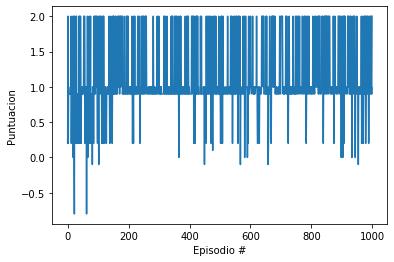

In [15]:
smaller_agent_rms = Agent(state_size=115, action_size=21, seed=0, network=SmallerNet, optim_fn='rmsprop')

scores = dqn(smaller_agent_rms, env, n_episodes=1000)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Puntuacion')
plt.xlabel('Episodio #')
plt.show()

Y finalmente la red más grande.

I0816 15:25:04.967695 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:04.968724 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 179.9, gameFPS: 453.2
I0816 15:25:05.178741 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:25:05.180011 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:05.180614 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 73.9, gameFPS: 338.6


Episodio 2	Puntuacion media (ultimos 50):1.10

I0816 15:25:05.825419 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:05.826945 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 114.9, gameFPS: 428.5


Episodio 3	Puntuacion media (ultimos 50):0.80

I0816 15:25:06.435856 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:06.444678 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 111.9, gameFPS: 401.0


Episodio 4	Puntuacion media (ultimos 50):0.85

I0816 15:25:06.905469 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:06.906879 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 27, FPS: 59.7, gameFPS: 197.5


Episodio 5	Puntuacion media (ultimos 50):0.86

I0816 15:25:07.651323 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:07.652377 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 90.2, gameFPS: 281.5


Episodio 6	Puntuacion media (ultimos 50):0.87

I0816 15:25:08.165302 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:08.166760 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 107.5, gameFPS: 357.4


Episodio 7	Puntuacion media (ultimos 50):0.87

I0816 15:25:08.805696 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:08.806473 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 115.3, gameFPS: 413.3


Episodio 8	Puntuacion media (ultimos 50):0.88

I0816 15:25:09.080967 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:09.081827 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 22, FPS: 82.8, gameFPS: 303.0


Episodio 10	Puntuacion media (ultimos 50):0.88

I0816 15:25:10.886852 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:10.887959 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 93, FPS: 103.4, gameFPS: 382.2


Episodio 13	Puntuacion media (ultimos 50):0.84

I0816 15:25:13.191333 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:13.195510 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 112.8, gameFPS: 451.9


Episodio 14	Puntuacion media (ultimos 50):0.79

I0816 15:25:13.806647 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:13.808444 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 109.2, gameFPS: 375.2


Episodio 16	Puntuacion media (ultimos 50):0.76

I0816 15:25:15.216636 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:15.217435 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 128.7, gameFPS: 507.8


Episodio 17	Puntuacion media (ultimos 50):0.78

I0816 15:25:15.819133 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:15.819933 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 133.4, gameFPS: 563.9


Episodio 18	Puntuacion media (ultimos 50):0.79

I0816 15:25:16.385682 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:16.386584 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 122.1, gameFPS: 496.1


Episodio 20	Puntuacion media (ultimos 50):0.80

I0816 15:25:17.365702 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:17.366706 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 77.8, gameFPS: 274.0
I0816 15:25:17.562211 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:25:17.563160 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:17.564238 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 70.3, gameFPS: 301.0


Episodio 22	Puntuacion media (ultimos 50):0.86

I0816 15:25:18.256831 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:18.258883 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 105.3, gameFPS: 387.8
I0816 15:25:18.471209 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:25:18.472293 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:18.472839 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 67.9, gameFPS: 310.6


Episodio 24	Puntuacion media (ultimos 50):0.91

I0816 15:25:19.288830 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:19.289696 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 87.1, gameFPS: 403.3


Episodio 28	Puntuacion media (ultimos 50):0.89

I0816 15:25:22.771488 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:22.773220 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 92.2, gameFPS: 437.8


Episodio 29	Puntuacion media (ultimos 50):0.86

I0816 15:25:23.528346 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:23.529406 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 62, FPS: 83.8, gameFPS: 268.5


Episodio 30	Puntuacion media (ultimos 50):0.86

I0816 15:25:23.739255 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:25:23.740822 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:23.741528 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 64.2, gameFPS: 275.8


Episodio 31	Puntuacion media (ultimos 50):0.90

I0816 15:25:24.710270 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:25:24.711553 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:24.712331 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 59.0, gameFPS: 281.7


Episodio 33	Puntuacion media (ultimos 50):0.91

I0816 15:25:25.440482 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:25.446966 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 104.7, gameFPS: 428.7


Episodio 34	Puntuacion media (ultimos 50):0.91

I0816 15:25:26.158224 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:26.160094 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 103.2, gameFPS: 437.9


Episodio 35	Puntuacion media (ultimos 50):0.91

I0816 15:25:26.982103 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:25:26.983884 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:26.986150 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 96, FPS: 117.9, gameFPS: 441.6


Episodio 36	Puntuacion media (ultimos 50):0.89

I0816 15:25:27.784165 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:27.785122 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 103.7, gameFPS: 396.3


Episodio 39	Puntuacion media (ultimos 50):0.89

I0816 15:25:30.139749 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:30.140703 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 114.5, gameFPS: 445.4


Episodio 41	Puntuacion media (ultimos 50):0.87

I0816 15:25:31.734204 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:31.735813 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 119.5, gameFPS: 486.2


Episodio 42	Puntuacion media (ultimos 50):0.87

I0816 15:25:32.428027 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:32.429990 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 103.6, gameFPS: 436.9
I0816 15:25:32.587902 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:25:32.589207 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:32.591545 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 73.2, gameFPS: 598.0


Episodio 46	Puntuacion media (ultimos 50):0.90

I0816 15:25:35.132552 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:35.133774 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 89, FPS: 107.7, gameFPS: 356.1


Episodio 50	Puntuacion media (50 anteriores): 0.90
Episodio 51	Puntuacion media (ultimos 50):0.91

I0816 15:25:39.300590 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:39.304447 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 126.7, gameFPS: 491.2


Episodio 52	Puntuacion media (ultimos 50):0.89

I0816 15:25:40.205151 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:40.208616 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 64, FPS: 72.6, gameFPS: 270.5


Episodio 53	Puntuacion media (ultimos 50):0.91

I0816 15:25:40.783544 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:40.784404 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 114.4, gameFPS: 412.8


Episodio 54	Puntuacion media (ultimos 50):0.90

I0816 15:25:41.370522 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:41.371462 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 117.6, gameFPS: 464.7
I0816 15:25:41.534565 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:25:41.535665 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:41.536263 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 64.1, gameFPS: 287.1


Episodio 56	Puntuacion media (ultimos 50):0.91

I0816 15:25:42.621380 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:25:42.622355 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:42.622932 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 52.2, gameFPS: 215.7


Episodio 58	Puntuacion media (ultimos 50):0.93

I0816 15:25:43.430712 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:43.431857 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 89.1, gameFPS: 367.6


Episodio 59	Puntuacion media (ultimos 50):0.93

I0816 15:25:44.078197 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:44.089625 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 62, FPS: 97.5, gameFPS: 345.7


Episodio 60	Puntuacion media (ultimos 50):0.94

I0816 15:25:44.696004 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:44.697215 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 89.1, gameFPS: 330.0


Episodio 61	Puntuacion media (ultimos 50):0.93

I0816 15:25:45.739239 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:45.740078 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 96, FPS: 93.0, gameFPS: 333.6


Episodio 65	Puntuacion media (ultimos 50):0.96

I0816 15:25:49.961730 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:49.962590 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 100, FPS: 96.2, gameFPS: 384.6


Episodio 68	Puntuacion media (ultimos 50):0.96

I0816 15:25:52.367719 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:52.368607 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 130.8, gameFPS: 532.4


Episodio 69	Puntuacion media (ultimos 50):0.96

I0816 15:25:53.013998 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:53.015059 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 116.3, gameFPS: 473.0


Episodio 71	Puntuacion media (ultimos 50):0.96

I0816 15:25:54.781475 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:54.782527 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 92.5, gameFPS: 413.0


Episodio 72	Puntuacion media (ultimos 50):0.92

I0816 15:25:54.996978 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:25:54.998425 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:54.999454 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 81.8, gameFPS: 369.1


Episodio 73	Puntuacion media (ultimos 50):0.95

I0816 15:25:55.494848 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:55.495919 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 102.5, gameFPS: 354.2


Episodio 75	Puntuacion media (ultimos 50):0.92

I0816 15:25:57.233456 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:57.238347 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 105.0, gameFPS: 395.3


Episodio 76	Puntuacion media (ultimos 50):0.93

I0816 15:25:57.961318 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:57.962466 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 95.3, gameFPS: 424.5


Episodio 77	Puntuacion media (ultimos 50):0.94

I0816 15:25:58.699865 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:58.700795 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 105.4, gameFPS: 424.4


Episodio 78	Puntuacion media (ultimos 50):0.94

I0816 15:25:59.341171 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:59.342135 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 120.2, gameFPS: 450.9
I0816 15:25:59.513593 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:25:59.515107 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:25:59.516103 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 60.7, gameFPS: 271.3


Episodio 80	Puntuacion media (ultimos 50):0.98

I0816 15:26:00.354904 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:00.356058 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 104.1, gameFPS: 420.9


Episodio 81	Puntuacion media (ultimos 50):0.96

I0816 15:26:00.676314 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:26:00.677455 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:00.678101 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 67.1, gameFPS: 353.7


Episodio 82	Puntuacion media (ultimos 50):0.99

I0816 15:26:01.399105 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:01.400143 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 63, FPS: 88.3, gameFPS: 359.8


Episodio 83	Puntuacion media (ultimos 50):0.97

I0816 15:26:01.621028 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:01.622068 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 15, FPS: 70.9, gameFPS: 261.2


Episodio 84	Puntuacion media (ultimos 50):0.97

I0816 15:26:02.221593 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:02.222390 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 131.8, gameFPS: 503.8
I0816 15:26:02.466457 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:26:02.467747 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:02.468379 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 85.0, gameFPS: 330.4


Episodio 86	Puntuacion media (ultimos 50):1.01

I0816 15:26:03.039345 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:03.040496 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 131.4, gameFPS: 573.4
I0816 15:26:03.247923 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:26:03.249037 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:03.249698 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 75.2, gameFPS: 324.9


Episodio 89	Puntuacion media (ultimos 50):1.03

I0816 15:26:05.795567 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:05.797015 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 83.2, gameFPS: 391.5


Episodio 90	Puntuacion media (ultimos 50):1.05

I0816 15:26:06.605073 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:06.608509 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 86.1, gameFPS: 314.9


Episodio 91	Puntuacion media (ultimos 50):1.05

I0816 15:26:07.579525 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:07.580788 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 77.4, gameFPS: 350.2


Episodio 92	Puntuacion media (ultimos 50):1.05

I0816 15:26:08.829332 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:08.830473 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 54.1, gameFPS: 264.7


Episodio 93	Puntuacion media (ultimos 50):1.05

I0816 15:26:11.169537 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:11.170596 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 100, FPS: 43.0, gameFPS: 244.6


Episodio 94	Puntuacion media (ultimos 50):1.03

I0816 15:26:12.142477 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:12.144512 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 71.5, gameFPS: 335.7


Episodio 97	Puntuacion media (ultimos 50):1.02

I0816 15:26:15.583494 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:15.584446 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 97.9, gameFPS: 396.4


Episodio 100	Puntuacion media (50 anteriores): 1.02


I0816 15:26:18.637265 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:18.638282 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 105.2, gameFPS: 362.7


Episodio 103	Puntuacion media (ultimos 50):1.02

I0816 15:26:21.256831 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:21.258012 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 42, FPS: 87.1, gameFPS: 356.7


Episodio 105	Puntuacion media (ultimos 50):1.03

I0816 15:26:23.107103 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:23.109860 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 92.6, gameFPS: 405.4


Episodio 106	Puntuacion media (ultimos 50):1.01

I0816 15:26:23.823593 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:23.824894 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 95.2, gameFPS: 332.4


Episodio 107	Puntuacion media (ultimos 50):1.01

I0816 15:26:24.634236 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:24.640180 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 104.9, gameFPS: 420.7


Episodio 108	Puntuacion media (ultimos 50):0.99

I0816 15:26:25.682305 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:25.685588 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 67.2, gameFPS: 226.9


Episodio 109	Puntuacion media (ultimos 50):0.99

I0816 15:26:26.181477 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:26.182805 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 26, FPS: 54.6, gameFPS: 232.5


Episodio 110	Puntuacion media (ultimos 50):0.99

I0816 15:26:26.741830 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:26.744889 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 93.1, gameFPS: 335.5


Episodio 111	Puntuacion media (ultimos 50):0.99

I0816 15:26:27.676005 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:27.676809 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 99, FPS: 107.3, gameFPS: 383.8


Episodio 114	Puntuacion media (ultimos 50):0.97

I0816 15:26:30.188993 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:26:30.190040 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:30.190863 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 39, FPS: 78.9, gameFPS: 312.1


Episodio 115	Puntuacion media (ultimos 50):1.00

I0816 15:26:30.520019 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:30.521497 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 53.1, gameFPS: 205.0


Episodio 116	Puntuacion media (ultimos 50):1.01

I0816 15:26:31.270487 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:31.271368 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 98.7, gameFPS: 397.1


Episodio 117	Puntuacion media (ultimos 50):1.01

I0816 15:26:31.952675 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:31.953531 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 107.1, gameFPS: 418.0


Episodio 118	Puntuacion media (ultimos 50):1.01

I0816 15:26:32.703477 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:32.704570 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 97.2, gameFPS: 360.0


Episodio 119	Puntuacion media (ultimos 50):1.01

I0816 15:26:33.036412 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:26:33.038368 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:33.041053 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 52.7, gameFPS: 336.5
I0816 15:26:33.237327 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:26:33.238339 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:33.238998 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 52.3, gameFPS: 216.9


Episodio 121	Puntuacion media (ultimos 50):1.05

I0816 15:26:34.129154 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:34.130344 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 92.1, gameFPS: 362.0


Episodio 123	Puntuacion media (ultimos 50):1.05

I0816 15:26:36.175813 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:36.176721 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 89.3, gameFPS: 440.1
I0816 15:26:36.388119 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:26:36.390117 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:36.390931 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 55.1, gameFPS: 546.3


Episodio 125	Puntuacion media (ultimos 50):1.07

I0816 15:26:37.244745 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:37.255458 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 87.2, gameFPS: 392.1


Episodio 126	Puntuacion media (ultimos 50):1.07

I0816 15:26:38.175726 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:38.177109 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 93.6, gameFPS: 427.0


Episodio 127	Puntuacion media (ultimos 50):1.07

I0816 15:26:38.443674 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:38.445568 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 65.9, gameFPS: 240.6


Episodio 129	Puntuacion media (ultimos 50):1.06

I0816 15:26:40.619624 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:40.622582 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 83.5, gameFPS: 339.5


Episodio 130	Puntuacion media (ultimos 50):1.04

I0816 15:26:40.876042 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:26:40.877294 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:40.882821 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 41.3, gameFPS: 148.1


Episodio 131	Puntuacion media (ultimos 50):1.06

I0816 15:26:41.834269 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:41.835211 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 72.6, gameFPS: 232.1
I0816 15:26:42.095263 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:42.096083 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 63.7, gameFPS: 235.4


Episodio 132	Puntuacion media (ultimos 50):1.04

I0816 15:26:42.346043 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:26:42.347287 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:42.347938 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 42.8, gameFPS: 239.1


Episodio 134	Puntuacion media (ultimos 50):1.07

I0816 15:26:42.800272 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:42.802206 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 38, FPS: 86.8, gameFPS: 313.6


Episodio 135	Puntuacion media (ultimos 50):1.07

I0816 15:26:44.010834 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:26:44.011721 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:44.012360 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 54.7, gameFPS: 263.3


Episodio 138	Puntuacion media (ultimos 50):1.05

I0816 15:26:45.776353 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:45.777354 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 89.8, gameFPS: 409.2


Episodio 139	Puntuacion media (ultimos 50):1.05

I0816 15:26:46.113517 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:46.117009 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 52.2, gameFPS: 223.7


Episodio 140	Puntuacion media (ultimos 50):1.05

I0816 15:26:46.649496 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:46.650916 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 46, FPS: 87.8, gameFPS: 386.5


Episodio 142	Puntuacion media (ultimos 50):1.05

I0816 15:26:48.117906 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:48.118974 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 44, FPS: 89.5, gameFPS: 453.2


Episodio 143	Puntuacion media (ultimos 50):1.05

I0816 15:26:48.835201 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:48.839696 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 100.2, gameFPS: 420.7


Episodio 144	Puntuacion media (ultimos 50):1.05

I0816 15:26:49.945351 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:26:49.946712 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:49.948912 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 93, FPS: 85.4, gameFPS: 351.9


Episodio 146	Puntuacion media (ultimos 50):1.04

I0816 15:26:52.133450 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:26:52.134818 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:52.136607 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 95, FPS: 89.6, gameFPS: 346.6


Episodio 147	Puntuacion media (ultimos 50):1.02

I0816 15:26:52.479877 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:52.480753 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 54.7, gameFPS: 258.1


Episodio 148	Puntuacion media (ultimos 50):1.01

I0816 15:26:53.274562 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:53.275404 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 101.9, gameFPS: 446.9


Episodio 150	Puntuacion media (50 anteriores): 1.01


I0816 15:26:54.706444 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:54.707247 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 99.3, gameFPS: 407.5
I0816 15:26:54.928280 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:26:54.929762 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:54.931475 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 84.4, gameFPS: 709.4


Episodio 152	Puntuacion media (ultimos 50):1.04

I0816 15:26:55.571886 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:55.572734 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 105.9, gameFPS: 438.3


Episodio 153	Puntuacion media (ultimos 50):1.04

I0816 15:26:56.151610 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:56.152509 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 57, FPS: 100.1, gameFPS: 424.1


Episodio 155	Puntuacion media (ultimos 50):1.04

I0816 15:26:57.663558 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:57.664361 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 104.0, gameFPS: 389.6


Episodio 156	Puntuacion media (ultimos 50):1.04

I0816 15:26:58.240287 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:58.241084 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 95.4, gameFPS: 369.3


Episodio 157	Puntuacion media (ultimos 50):1.04

I0816 15:26:59.325259 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:26:59.326178 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:26:59.326810 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 60.3, gameFPS: 287.8


Episodio 160	Puntuacion media (ultimos 50):1.06

I0816 15:27:00.994202 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:00.995031 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 110.4, gameFPS: 455.0


Episodio 161	Puntuacion media (ultimos 50):1.06

I0816 15:27:01.658536 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:01.659985 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 62, FPS: 96.3, gameFPS: 359.0


Episodio 162	Puntuacion media (ultimos 50):1.06

I0816 15:27:02.448687 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:02.450082 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 70.4, gameFPS: 267.5


Episodio 163	Puntuacion media (ultimos 50):1.06

I0816 15:27:03.408552 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:03.410345 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 86.8, gameFPS: 342.8


Episodio 164	Puntuacion media (ultimos 50):1.06

I0816 15:27:03.646237 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:27:03.647336 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:03.647939 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 74.0, gameFPS: 398.2
I0816 15:27:03.893124 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:27:03.894250 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:03.895289 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 81.7, gameFPS: 557.6


Episodio 166	Puntuacion media (ultimos 50):1.09

I0816 15:27:04.648617 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:04.649701 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 109.7, gameFPS: 529.6


Episodio 167	Puntuacion media (ultimos 50):1.09

I0816 15:27:05.341054 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:05.341912 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 100.8, gameFPS: 379.3


Episodio 168	Puntuacion media (ultimos 50):1.09

I0816 15:27:05.996803 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:05.997628 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 83.3, gameFPS: 301.7


Episodio 170	Puntuacion media (ultimos 50):1.05

I0816 15:27:07.992114 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:07.992902 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 96.1, gameFPS: 428.2


Episodio 171	Puntuacion media (ultimos 50):1.03

I0816 15:27:08.870059 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:08.870839 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 57, FPS: 65.7, gameFPS: 286.2


Episodio 172	Puntuacion media (ultimos 50):1.03

I0816 15:27:10.080855 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:10.082331 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 72.6, gameFPS: 319.4


Episodio 173	Puntuacion media (ultimos 50):1.01

I0816 15:27:10.978749 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:10.983496 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 84.5, gameFPS: 294.4


Episodio 174	Puntuacion media (ultimos 50):1.01

I0816 15:27:11.887362 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:11.888608 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 91.4, gameFPS: 361.0


Episodio 175	Puntuacion media (ultimos 50):0.99

I0816 15:27:12.736873 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:12.738176 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 101.6, gameFPS: 401.4


Episodio 176	Puntuacion media (ultimos 50):0.99

I0816 15:27:13.513576 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:13.514442 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 99.5, gameFPS: 398.3


Episodio 177	Puntuacion media (ultimos 50):0.99

I0816 15:27:14.171315 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:14.172499 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 106.8, gameFPS: 455.9
I0816 15:27:14.374689 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:27:14.375710 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:14.376317 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 66.2, gameFPS: 257.0


Episodio 179	Puntuacion media (ultimos 50):0.99

I0816 15:27:15.069493 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:15.070884 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 82.2, gameFPS: 321.7


Episodio 180	Puntuacion media (ultimos 50):0.99

I0816 15:27:15.844089 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:15.844961 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 95.4, gameFPS: 432.2


Episodio 181	Puntuacion media (ultimos 50):0.97

I0816 15:27:16.382936 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:16.384003 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 97.3, gameFPS: 388.0


Episodio 182	Puntuacion media (ultimos 50):0.97

I0816 15:27:17.173826 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:17.176686 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 92.3, gameFPS: 390.9


Episodio 183	Puntuacion media (ultimos 50):0.97

I0816 15:27:17.432753 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:27:17.433938 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:17.435318 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 39.9, gameFPS: 183.8
I0816 15:27:17.683421 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:27:17.684777 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:17.685518 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 55.0, gameFPS: 286.2


Episodio 185	Puntuacion media (ultimos 50):0.99

I0816 15:27:18.579676 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:18.580648 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 97.6, gameFPS: 411.0


Episodio 186	Puntuacion media (ultimos 50):0.99

I0816 15:27:18.795941 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:27:18.797014 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:18.797703 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 63.7, gameFPS: 279.0


Episodio 188	Puntuacion media (ultimos 50):0.99

I0816 15:27:20.487376 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:20.488270 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 109.0, gameFPS: 465.5


Episodio 189	Puntuacion media (ultimos 50):0.99

I0816 15:27:21.349462 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:21.350340 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 91.9, gameFPS: 329.0


Episodio 190	Puntuacion media (ultimos 50):0.99

I0816 15:27:22.056714 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:22.060509 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 101.6, gameFPS: 430.5
I0816 15:27:22.286410 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:27:22.287382 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:22.288010 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 73.9, gameFPS: 379.8


Episodio 192	Puntuacion media (ultimos 50):1.01

I0816 15:27:23.152375 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:23.153843 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 93, FPS: 108.9, gameFPS: 491.9


Episodio 193	Puntuacion media (ultimos 50):1.02

I0816 15:27:23.929021 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:23.929882 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 91.3, gameFPS: 292.7


Episodio 194	Puntuacion media (ultimos 50):1.02

I0816 15:27:24.412082 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:24.413276 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 33, FPS: 70.5, gameFPS: 237.9


Episodio 195	Puntuacion media (ultimos 50):1.04

I0816 15:27:24.747452 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:27:24.748704 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:24.749302 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 35.4, gameFPS: 240.9


Episodio 196	Puntuacion media (ultimos 50):1.06

I0816 15:27:25.746170 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:25.747082 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 85.6, gameFPS: 372.8


Episodio 197	Puntuacion media (ultimos 50):1.08

I0816 15:27:26.906325 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:26.907679 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 62.7, gameFPS: 328.7


Episodio 198	Puntuacion media (ultimos 50):1.08

I0816 15:27:27.567460 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:27.571695 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 83.3, gameFPS: 399.3


Episodio 200	Puntuacion media (50 anteriores): 1.09


I0816 15:27:29.354476 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:29.355252 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 110.3, gameFPS: 478.0


Episodio 201	Puntuacion media (ultimos 50):1.09

I0816 15:27:30.114322 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:30.115210 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 57, FPS: 76.2, gameFPS: 242.3


Episodio 202	Puntuacion media (ultimos 50):1.07

I0816 15:27:30.408352 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:30.409585 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 14, FPS: 50.1, gameFPS: 193.5


Episodio 204	Puntuacion media (ultimos 50):1.06

I0816 15:27:32.149107 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:32.154482 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 73.4, gameFPS: 266.6


Episodio 205	Puntuacion media (ultimos 50):1.06

I0816 15:27:32.519689 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:27:32.520871 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:32.521602 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 37.2, gameFPS: 190.1


Episodio 206	Puntuacion media (ultimos 50):1.08

I0816 15:27:32.872811 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:32.873772 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 32, FPS: 93.5, gameFPS: 382.9
I0816 15:27:33.097119 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:27:33.098280 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:33.099174 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.0, gameFPS: 286.5


Episodio 208	Puntuacion media (ultimos 50):1.11

I0816 15:27:33.745488 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:33.746369 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 113.0, gameFPS: 432.6
I0816 15:27:33.983603 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:27:33.985473 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:33.986696 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 65.6, gameFPS: 457.0


Episodio 210	Puntuacion media (ultimos 50):1.11

I0816 15:27:34.886987 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:34.888121 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 83, FPS: 93.6, gameFPS: 381.9


Episodio 211	Puntuacion media (ultimos 50):1.11

I0816 15:27:35.642640 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:35.645004 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 106.0, gameFPS: 486.9


Episodio 212	Puntuacion media (ultimos 50):1.11

I0816 15:27:35.969651 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:35.970537 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 64.0, gameFPS: 233.4


Episodio 213	Puntuacion media (ultimos 50):1.11

I0816 15:27:37.169494 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:27:37.171197 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:37.172995 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 98, FPS: 82.2, gameFPS: 369.1


Episodio 214	Puntuacion media (ultimos 50):1.10

I0816 15:27:37.956773 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:37.957638 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 51, FPS: 66.4, gameFPS: 245.9


Episodio 215	Puntuacion media (ultimos 50):1.08

I0816 15:27:38.719722 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:38.720535 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 109.9, gameFPS: 454.3


Episodio 216	Puntuacion media (ultimos 50):1.06

I0816 15:27:39.465586 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:39.472058 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 98.8, gameFPS: 400.3


Episodio 217	Puntuacion media (ultimos 50):1.06

I0816 15:27:40.161995 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:40.162982 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 75.4, gameFPS: 342.6


Episodio 218	Puntuacion media (ultimos 50):1.06

I0816 15:27:40.458489 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:27:40.459540 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:40.463769 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 45.3, gameFPS: 181.3


Episodio 219	Puntuacion media (ultimos 50):1.08

I0816 15:27:41.349731 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:41.354403 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 100.4, gameFPS: 446.5


Episodio 220	Puntuacion media (ultimos 50):1.09

I0816 15:27:41.949486 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:41.950407 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 90.8, gameFPS: 385.0


Episodio 221	Puntuacion media (ultimos 50):1.09

I0816 15:27:42.933629 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:42.936933 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 88.3, gameFPS: 429.8


Episodio 222	Puntuacion media (ultimos 50):1.09

I0816 15:27:43.207312 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:27:43.208337 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:43.209213 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 79.8, gameFPS: 374.9


Episodio 223	Puntuacion media (ultimos 50):1.13

I0816 15:27:43.882103 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:43.882958 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 104.0, gameFPS: 483.2


Episodio 225	Puntuacion media (ultimos 50):1.12

I0816 15:27:45.617338 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:45.618172 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 100.5, gameFPS: 343.4


Episodio 226	Puntuacion media (ultimos 50):1.12

I0816 15:27:46.368954 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:46.370155 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 104.6, gameFPS: 483.4


Episodio 228	Puntuacion media (ultimos 50):1.14

I0816 15:27:47.737140 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:47.738038 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 112.3, gameFPS: 481.1


Episodio 230	Puntuacion media (ultimos 50):1.12

I0816 15:27:50.276067 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:50.284080 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 77.3, gameFPS: 293.6


Episodio 231	Puntuacion media (ultimos 50):1.11

I0816 15:27:51.016903 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:51.017834 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 102.1, gameFPS: 438.1


Episodio 232	Puntuacion media (ultimos 50):1.11

I0816 15:27:51.864949 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:51.868593 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 87.1, gameFPS: 371.3


Episodio 234	Puntuacion media (ultimos 50):1.09

I0816 15:27:54.128312 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:54.129503 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 78.1, gameFPS: 351.7


Episodio 235	Puntuacion media (ultimos 50):1.06

I0816 15:27:55.022276 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:55.025992 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 84.1, gameFPS: 377.1


Episodio 237	Puntuacion media (ultimos 50):1.03

I0816 15:27:56.617295 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:56.618196 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 92.6, gameFPS: 322.3


Episodio 238	Puntuacion media (ultimos 50):1.04

I0816 15:27:57.562862 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:57.563999 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 85.7, gameFPS: 404.8


Episodio 239	Puntuacion media (ultimos 50):1.04

I0816 15:27:58.089705 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:58.090860 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 26, FPS: 50.3, gameFPS: 251.3


Episodio 240	Puntuacion media (ultimos 50):1.04

I0816 15:27:58.440318 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:27:58.444245 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:58.445145 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 29.0, gameFPS: 194.7


Episodio 241	Puntuacion media (ultimos 50):1.06

I0816 15:27:59.142620 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:59.144157 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 107.7, gameFPS: 506.3


Episodio 242	Puntuacion media (ultimos 50):1.04

I0816 15:27:59.991549 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:27:59.992423 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 83.9, gameFPS: 415.0


Episodio 243	Puntuacion media (ultimos 50):1.04

I0816 15:28:01.019544 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:01.022891 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 89.4, gameFPS: 394.5
I0816 15:28:01.289652 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:28:01.290726 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:01.291266 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 72.7, gameFPS: 382.7


Episodio 245	Puntuacion media (ultimos 50):1.06

I0816 15:28:01.517114 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:28:01.518234 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:01.518860 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 76.5, gameFPS: 386.8


Episodio 246	Puntuacion media (ultimos 50):1.06

I0816 15:28:02.614795 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:28:02.616032 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:02.619793 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.5, gameFPS: 226.2


Episodio 248	Puntuacion media (ultimos 50):1.08

I0816 15:28:03.783112 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:03.787522 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 73, FPS: 63.6, gameFPS: 406.3


Episodio 249	Puntuacion media (ultimos 50):1.08

I0816 15:28:05.062440 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:05.063223 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 62.0, gameFPS: 234.2


Episodio 250	Puntuacion media (50 anteriores): 1.08


I0816 15:28:06.058860 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:06.062835 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 80.1, gameFPS: 301.3


Episodio 252	Puntuacion media (ultimos 50):1.08

I0816 15:28:07.950422 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:07.951297 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 72.1, gameFPS: 292.0


Episodio 253	Puntuacion media (ultimos 50):1.08

I0816 15:28:08.879067 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:08.880317 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 76.1, gameFPS: 368.7


Episodio 254	Puntuacion media (ultimos 50):1.08

I0816 15:28:09.892729 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:28:09.894376 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:09.895805 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 69, FPS: 68.5, gameFPS: 377.2


Episodio 255	Puntuacion media (ultimos 50):1.10

I0816 15:28:10.815160 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:10.816719 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 79.8, gameFPS: 375.4


Episodio 257	Puntuacion media (ultimos 50):1.08

I0816 15:28:13.044417 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:13.045835 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 72.6, gameFPS: 338.2


Episodio 258	Puntuacion media (ultimos 50):1.06

I0816 15:28:13.387285 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:13.388225 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 55.5, gameFPS: 267.2


Episodio 259	Puntuacion media (ultimos 50):1.06

I0816 15:28:14.267277 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:14.268397 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 87.5, gameFPS: 455.0


Episodio 260	Puntuacion media (ultimos 50):1.04

I0816 15:28:14.548627 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:14.551775 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 20, FPS: 74.5, gameFPS: 276.5


Episodio 261	Puntuacion media (ultimos 50):1.03

I0816 15:28:15.413341 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:28:15.414567 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:15.415251 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 99, FPS: 115.7, gameFPS: 473.0


Episodio 263	Puntuacion media (ultimos 50):1.01

I0816 15:28:16.963101 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:16.964170 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 115.1, gameFPS: 558.6


Episodio 265	Puntuacion media (ultimos 50):1.02

I0816 15:28:18.043832 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:18.044860 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 24, FPS: 89.1, gameFPS: 346.7
I0816 15:28:18.273168 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:28:18.274153 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:18.275156 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 74.0, gameFPS: 328.1


Episodio 267	Puntuacion media (ultimos 50):1.05

I0816 15:28:18.510521 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:18.511327 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 14, FPS: 62.4, gameFPS: 234.9


Episodio 268	Puntuacion media (ultimos 50):1.05

I0816 15:28:19.058104 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:19.059038 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 100.4, gameFPS: 358.6


Episodio 269	Puntuacion media (ultimos 50):1.02

I0816 15:28:19.578469 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:19.579432 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 103.5, gameFPS: 406.8


Episodio 270	Puntuacion media (ultimos 50):1.02

I0816 15:28:20.304900 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:20.305876 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 113.6, gameFPS: 480.1


Episodio 271	Puntuacion media (ultimos 50):1.02

I0816 15:28:21.056510 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:21.057425 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 94, FPS: 126.7, gameFPS: 567.0


Episodio 272	Puntuacion media (ultimos 50):1.02

I0816 15:28:21.522065 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:21.523100 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 121.0, gameFPS: 558.5
I0816 15:28:21.729943 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:28:21.731045 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:21.732048 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 80.9, gameFPS: 383.7


Episodio 274	Puntuacion media (ultimos 50):1.04

I0816 15:28:22.412225 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:22.413169 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 77, FPS: 114.8, gameFPS: 470.6


Episodio 276	Puntuacion media (ultimos 50):1.04

I0816 15:28:23.676372 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:28:23.677485 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:23.678148 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 39, FPS: 100.1, gameFPS: 439.3


Episodio 277	Puntuacion media (ultimos 50):1.06

I0816 15:28:24.437844 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:24.438867 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 113.6, gameFPS: 458.7


Episodio 278	Puntuacion media (ultimos 50):1.06

I0816 15:28:24.818317 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:28:24.819414 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:24.820000 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 43, FPS: 115.5, gameFPS: 545.3


Episodio 279	Puntuacion media (ultimos 50):1.08

I0816 15:28:25.451713 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:25.452647 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 114.0, gameFPS: 478.5


Episodio 280	Puntuacion media (ultimos 50):1.08

I0816 15:28:25.974356 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:25.975327 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 109.6, gameFPS: 468.4


Episodio 281	Puntuacion media (ultimos 50):1.08

I0816 15:28:26.813822 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:26.819555 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 94, FPS: 113.4, gameFPS: 453.5


Episodio 285	Puntuacion media (ultimos 50):1.08

I0816 15:28:30.125834 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:30.127331 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 92.6, gameFPS: 411.4


Episodio 286	Puntuacion media (ultimos 50):1.08

I0816 15:28:31.164239 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:31.165122 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 82.8, gameFPS: 390.3


Episodio 287	Puntuacion media (ultimos 50):1.09

I0816 15:28:32.067255 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:32.068880 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 95.9, gameFPS: 417.1


Episodio 288	Puntuacion media (ultimos 50):1.08

I0816 15:28:33.105409 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:33.109180 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 82.2, gameFPS: 373.3


Episodio 289	Puntuacion media (ultimos 50):1.08

I0816 15:28:34.111306 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:34.112663 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 96, FPS: 96.6, gameFPS: 443.8


Episodio 290	Puntuacion media (ultimos 50):1.08

I0816 15:28:34.923641 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:34.924538 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 105.0, gameFPS: 454.5
I0816 15:28:35.088988 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:28:35.090072 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:35.090696 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.9, gameFPS: 292.1


Episodio 292	Puntuacion media (ultimos 50):1.08

I0816 15:28:35.287470 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:28:35.288420 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:35.289003 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.2, gameFPS: 282.1
I0816 15:28:35.464957 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:28:35.466080 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:35.466798 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 60.3, gameFPS: 263.9


Episodio 294	Puntuacion media (ultimos 50):1.12

I0816 15:28:35.981280 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:35.983129 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 109.3, gameFPS: 414.5


Episodio 295	Puntuacion media (ultimos 50):1.10

I0816 15:28:36.679109 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:36.680230 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 72, FPS: 104.8, gameFPS: 438.5


Episodio 296	Puntuacion media (ultimos 50):1.08

I0816 15:28:37.252410 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:37.256520 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 56, FPS: 99.5, gameFPS: 329.7


Episodio 297	Puntuacion media (ultimos 50):1.08

I0816 15:28:38.050563 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:38.051381 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 84.6, gameFPS: 354.8


Episodio 298	Puntuacion media (ultimos 50):1.06

I0816 15:28:38.760146 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:38.761876 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 60, FPS: 85.9, gameFPS: 401.9


Episodio 299	Puntuacion media (ultimos 50):1.06

I0816 15:28:38.974489 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:28:38.976131 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:38.976925 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 63.5, gameFPS: 261.5


Episodio 300	Puntuacion media (50 anteriores): 1.08


I0816 15:28:39.799277 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:39.800454 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 106.5, gameFPS: 400.3


Episodio 301	Puntuacion media (ultimos 50):1.08

I0816 15:28:40.466089 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:40.467114 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 98.8, gameFPS: 311.9


Episodio 303	Puntuacion media (ultimos 50):1.08

I0816 15:28:42.601334 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:42.602646 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 90.1, gameFPS: 418.2


Episodio 304	Puntuacion media (ultimos 50):1.08

I0816 15:28:43.934190 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:43.935181 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 95, FPS: 72.0, gameFPS: 292.5


Episodio 305	Puntuacion media (ultimos 50):1.06

I0816 15:28:44.365557 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:28:44.366899 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:44.367526 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 36, FPS: 85.5, gameFPS: 434.0


Episodio 306	Puntuacion media (ultimos 50):1.08

I0816 15:28:45.196602 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:45.197587 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 105.9, gameFPS: 464.5


Episodio 307	Puntuacion media (ultimos 50):1.08

I0816 15:28:46.023333 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:46.024245 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 87.3, gameFPS: 412.8


Episodio 308	Puntuacion media (ultimos 50):1.08

I0816 15:28:47.085984 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:47.086888 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 95, FPS: 90.2, gameFPS: 379.0
I0816 15:28:47.237669 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:28:47.238717 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:47.240351 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 63.3, gameFPS: 712.8


Episodio 310	Puntuacion media (ultimos 50):1.10

I0816 15:28:48.111326 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:48.112226 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 60, FPS: 69.8, gameFPS: 344.2


Episodio 311	Puntuacion media (ultimos 50):1.10

I0816 15:28:49.021299 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:49.022708 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 94, FPS: 104.2, gameFPS: 437.4


Episodio 312	Puntuacion media (ultimos 50):1.12

I0816 15:28:49.768984 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:49.769993 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 100.4, gameFPS: 386.9
I0816 15:28:49.934016 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:28:49.935180 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:49.935808 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 11, FPS: 70.1, gameFPS: 584.4


Episodio 314	Puntuacion media (ultimos 50):1.16

I0816 15:28:50.545421 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:50.546439 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 126.7, gameFPS: 583.8


Episodio 315	Puntuacion media (ultimos 50):1.16

I0816 15:28:51.219664 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:51.227509 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 126.6, gameFPS: 566.3


Episodio 316	Puntuacion media (ultimos 50):1.15

I0816 15:28:51.924236 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:51.925408 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 45, FPS: 66.6, gameFPS: 358.8


Episodio 317	Puntuacion media (ultimos 50):1.13

I0816 15:28:52.771874 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:52.773828 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 82.4, gameFPS: 345.1


Episodio 318	Puntuacion media (ultimos 50):1.12

I0816 15:28:53.450696 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:53.451594 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 70, FPS: 104.6, gameFPS: 481.7


Episodio 319	Puntuacion media (ultimos 50):1.12

I0816 15:28:54.461376 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:28:54.462351 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:54.463121 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 92, FPS: 92.0, gameFPS: 389.1


Episodio 320	Puntuacion media (ultimos 50):1.10

I0816 15:28:54.926472 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:28:54.927523 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:54.928310 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 20, FPS: 45.0, gameFPS: 193.4


Episodio 321	Puntuacion media (ultimos 50):1.12

I0816 15:28:55.282376 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:28:55.283312 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:55.283918 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 30, FPS: 88.7, gameFPS: 390.1


Episodio 322	Puntuacion media (ultimos 50):1.14

I0816 15:28:55.996461 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:55.997352 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 113.5, gameFPS: 482.2


Episodio 325	Puntuacion media (ultimos 50):1.12

I0816 15:28:58.942078 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:58.943030 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 113.3, gameFPS: 477.7


Episodio 326	Puntuacion media (ultimos 50):1.12

I0816 15:28:59.533483 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:28:59.534310 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 34, FPS: 58.5, gameFPS: 231.2


Episodio 327	Puntuacion media (ultimos 50):1.10

I0816 15:29:00.166491 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:00.167462 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 65, FPS: 104.1, gameFPS: 368.4
I0816 15:29:00.388276 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:29:00.389622 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:00.390346 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 79.0, gameFPS: 366.3


Episodio 329	Puntuacion media (ultimos 50):1.10

I0816 15:29:00.686696 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:29:00.687788 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:00.688471 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 26, FPS: 89.8, gameFPS: 376.3


Episodio 330	Puntuacion media (ultimos 50):1.12

I0816 15:29:01.462561 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:29:01.463681 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:01.464334 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 96, FPS: 125.1, gameFPS: 506.3


Episodio 331	Puntuacion media (ultimos 50):1.10

I0816 15:29:02.229194 139969143023424 observation_processor.py:362] Dump "lost_score": count limit reached / disabled
I0816 15:29:02.230395 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:02.231315 139969143023424 football_env_wrapper.py:85] Episode reward: -1.00 score: [0, 1], steps: 98, FPS: 129.4, gameFPS: 539.8


Episodio 332	Puntuacion media (ultimos 50):1.09

I0816 15:29:02.877512 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:02.878473 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 116.4, gameFPS: 533.7


Episodio 333	Puntuacion media (ultimos 50):1.10

I0816 15:29:03.374690 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:03.379122 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 110.6, gameFPS: 509.7


Episodio 336	Puntuacion media (ultimos 50):1.10

I0816 15:29:05.501839 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:05.502696 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 66, FPS: 112.8, gameFPS: 483.9


Episodio 338	Puntuacion media (ultimos 50):1.10

I0816 15:29:06.938609 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:06.939422 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 122.5, gameFPS: 533.7


Episodio 340	Puntuacion media (ultimos 50):1.10

I0816 15:29:08.257082 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:08.258093 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 61, FPS: 119.6, gameFPS: 528.4


Episodio 341	Puntuacion media (ultimos 50):1.10

I0816 15:29:09.059074 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:09.062862 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 93, FPS: 117.6, gameFPS: 532.0


Episodio 342	Puntuacion media (ultimos 50):1.08

I0816 15:29:09.576664 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:09.577707 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 40, FPS: 79.4, gameFPS: 339.8


Episodio 343	Puntuacion media (ultimos 50):1.06

I0816 15:29:09.933508 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:29:09.934584 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:09.935684 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 34, FPS: 97.2, gameFPS: 437.2


Episodio 344	Puntuacion media (ultimos 50):1.06

I0816 15:29:10.419146 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:29:10.420251 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:10.420914 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 52, FPS: 109.5, gameFPS: 484.6


Episodio 346	Puntuacion media (ultimos 50):1.08

I0816 15:29:11.591010 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:11.591905 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 29, FPS: 87.4, gameFPS: 337.9


Episodio 347	Puntuacion media (ultimos 50):1.08

I0816 15:29:12.290011 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:12.290991 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 115.7, gameFPS: 497.9


Episodio 350	Puntuacion media (50 anteriores): 1.06


I0816 15:29:14.325108 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:14.326005 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 39, FPS: 104.1, gameFPS: 442.1


Episodio 352	Puntuacion media (ultimos 50):1.06

I0816 15:29:15.367065 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:29:15.368369 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:15.369085 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 26, FPS: 96.7, gameFPS: 439.0


Episodio 353	Puntuacion media (ultimos 50):1.08

I0816 15:29:16.228032 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:16.228837 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 98, FPS: 115.2, gameFPS: 464.8


Episodio 354	Puntuacion media (ultimos 50):1.08

I0816 15:29:16.995205 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:16.996470 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 110.6, gameFPS: 438.4
I0816 15:29:17.192940 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:29:17.194236 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:17.194897 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 68.7, gameFPS: 308.8


Episodio 356	Puntuacion media (ultimos 50):1.08

I0816 15:29:17.942608 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:17.943845 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 82, FPS: 110.9, gameFPS: 445.1


Episodio 357	Puntuacion media (ultimos 50):1.09

I0816 15:29:18.551928 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:18.552773 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 25, FPS: 41.8, gameFPS: 180.0
I0816 15:29:18.726448 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:29:18.727530 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:18.728218 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.4, gameFPS: 327.2


Episodio 359	Puntuacion media (ultimos 50):1.11

I0816 15:29:18.999694 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:29:19.000653 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:19.001323 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 79.4, gameFPS: 410.0


Episodio 361	Puntuacion media (ultimos 50):1.11

I0816 15:29:20.660329 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:20.661191 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 55, FPS: 85.9, gameFPS: 338.3


Episodio 362	Puntuacion media (ultimos 50):1.10

I0816 15:29:20.937451 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:29:20.938546 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:20.939194 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 86.8, gameFPS: 395.1


Episodio 363	Puntuacion media (ultimos 50):1.13

I0816 15:29:21.535432 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:21.536692 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 75, FPS: 127.6, gameFPS: 602.9


Episodio 364	Puntuacion media (ultimos 50):1.11

I0816 15:29:22.598687 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:22.601516 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 95, FPS: 90.4, gameFPS: 353.0


Episodio 365	Puntuacion media (ultimos 50):1.11

I0816 15:29:23.504733 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:23.505616 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 98.0, gameFPS: 471.0


Episodio 366	Puntuacion media (ultimos 50):1.11

I0816 15:29:24.692790 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:24.694633 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 73.9, gameFPS: 360.7


Episodio 367	Puntuacion media (ultimos 50):1.11

I0816 15:29:25.039158 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:25.040241 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 56.3, gameFPS: 208.2


Episodio 368	Puntuacion media (ultimos 50):1.12

I0816 15:29:25.422101 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:25.423431 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 27, FPS: 71.9, gameFPS: 311.5


Episodio 371	Puntuacion media (ultimos 50):1.12

I0816 15:29:27.786737 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:29:27.787731 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:27.788268 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 39.1, gameFPS: 285.1


Episodio 373	Puntuacion media (ultimos 50):1.13

I0816 15:29:29.729480 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:29.730362 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 88, FPS: 93.0, gameFPS: 418.8


Episodio 374	Puntuacion media (ultimos 50):1.12

I0816 15:29:30.218417 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:30.219390 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 47, FPS: 97.7, gameFPS: 466.3


Episodio 375	Puntuacion media (ultimos 50):1.12

I0816 15:29:30.817012 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:30.818001 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 117.6, gameFPS: 550.7


Episodio 377	Puntuacion media (ultimos 50):1.11

I0816 15:29:32.588476 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:32.589348 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 98, FPS: 101.5, gameFPS: 431.6


Episodio 378	Puntuacion media (ultimos 50):1.10

I0816 15:29:33.643671 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:33.644876 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 78, FPS: 74.8, gameFPS: 320.7


Episodio 379	Puntuacion media (ultimos 50):1.08

I0816 15:29:34.234570 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:34.235466 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 71, FPS: 122.3, gameFPS: 567.2


Episodio 383	Puntuacion media (ultimos 50):1.10

I0816 15:29:39.068798 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:39.072349 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 66.1, gameFPS: 269.9


Episodio 384	Puntuacion media (ultimos 50):1.10

I0816 15:29:39.535313 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:29:39.539315 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:39.545306 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 25, FPS: 55.6, gameFPS: 338.9


Episodio 386	Puntuacion media (ultimos 50):1.12

I0816 15:29:41.577026 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:29:41.578597 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:41.579987 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 40.3, gameFPS: 200.7


Episodio 387	Puntuacion media (ultimos 50):1.14

I0816 15:29:42.140756 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:29:42.154531 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:42.157684 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 33, FPS: 58.6, gameFPS: 438.9


Episodio 388	Puntuacion media (ultimos 50):1.16

I0816 15:29:42.736625 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:29:42.738199 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:42.741061 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 25, FPS: 45.0, gameFPS: 213.0


Episodio 389	Puntuacion media (ultimos 50):1.18

I0816 15:29:43.974414 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:43.975444 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 70.7, gameFPS: 372.2


Episodio 390	Puntuacion media (ultimos 50):1.18

I0816 15:29:45.270207 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:45.271099 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 100, FPS: 78.3, gameFPS: 380.2


Episodio 391	Puntuacion media (ultimos 50):1.18

I0816 15:29:45.892545 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:45.893379 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 38, FPS: 62.9, gameFPS: 242.1


Episodio 393	Puntuacion media (ultimos 50):1.18

I0816 15:29:48.275392 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:48.278971 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 70.8, gameFPS: 285.1


Episodio 394	Puntuacion media (ultimos 50):1.16

I0816 15:29:49.388402 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:49.389281 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 78.6, gameFPS: 355.7


Episodio 395	Puntuacion media (ultimos 50):1.14

I0816 15:29:50.295920 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:50.298049 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 77.1, gameFPS: 361.9


Episodio 396	Puntuacion media (ultimos 50):1.12

I0816 15:29:50.847796 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:50.849502 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 36, FPS: 67.0, gameFPS: 296.3


Episodio 399	Puntuacion media (ultimos 50):1.13

I0816 15:29:54.520694 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:54.521653 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 80, FPS: 71.1, gameFPS: 274.4


Episodio 400	Puntuacion media (50 anteriores): 1.12
Episodio 401	Puntuacion media (ultimos 50):1.12

I0816 15:29:57.330291 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:57.332175 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 84, FPS: 53.8, gameFPS: 203.4


Episodio 402	Puntuacion media (ultimos 50):1.12

I0816 15:29:58.647428 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:29:58.650912 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 60.8, gameFPS: 356.6


Episodio 404	Puntuacion media (ultimos 50):1.10

I0816 15:30:00.876631 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:00.877658 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 62, FPS: 61.0, gameFPS: 364.4


Episodio 406	Puntuacion media (ultimos 50):1.08

I0816 15:30:03.308233 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:03.310527 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 61.1, gameFPS: 239.6


Episodio 407	Puntuacion media (ultimos 50):1.08

I0816 15:30:04.193877 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:04.195293 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 59, FPS: 69.2, gameFPS: 339.1


Episodio 411	Puntuacion media (ultimos 50):1.04

I0816 15:30:07.508417 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:07.509328 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 50, FPS: 102.6, gameFPS: 388.2


Episodio 412	Puntuacion media (ultimos 50):1.04

I0816 15:30:08.071327 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:08.072269 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 59, FPS: 106.7, gameFPS: 448.6


Episodio 414	Puntuacion media (ultimos 50):1.02

I0816 15:30:10.607739 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:10.609188 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 58.9, gameFPS: 313.6


Episodio 415	Puntuacion media (ultimos 50):1.02

I0816 15:30:11.066284 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:30:11.068367 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:11.070105 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 38.2, gameFPS: 203.7


Episodio 418	Puntuacion media (ultimos 50):1.04

I0816 15:30:15.676192 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:15.678055 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 50.3, gameFPS: 238.9


Episodio 419	Puntuacion media (ultimos 50):1.05

I0816 15:30:16.239782 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:30:16.241527 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:16.242199 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 43.7, gameFPS: 253.9


Episodio 421	Puntuacion media (ultimos 50):1.07

I0816 15:30:18.223271 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:18.227197 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 94, FPS: 105.7, gameFPS: 477.5


Episodio 424	Puntuacion media (ultimos 50):1.05

I0816 15:30:21.396746 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:21.397621 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 93.4, gameFPS: 409.8


Episodio 425	Puntuacion media (ultimos 50):1.05

I0816 15:30:22.222919 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:22.223996 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 91.3, gameFPS: 406.1


Episodio 426	Puntuacion media (ultimos 50):1.06

I0816 15:30:22.987332 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:22.988294 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 53, FPS: 70.1, gameFPS: 297.8


Episodio 429	Puntuacion media (ultimos 50):1.07

I0816 15:30:25.290298 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:25.291086 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 42, FPS: 79.1, gameFPS: 292.9


Episodio 432	Puntuacion media (ultimos 50):1.07

I0816 15:30:27.744600 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:30:27.745789 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:27.747730 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 42, FPS: 76.9, gameFPS: 396.7


Episodio 433	Puntuacion media (ultimos 50):1.09

I0816 15:30:28.785749 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:28.786749 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 99, FPS: 96.0, gameFPS: 423.7


Episodio 434	Puntuacion media (ultimos 50):1.09

I0816 15:30:29.733342 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:29.734475 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 99, FPS: 106.0, gameFPS: 428.2


Episodio 436	Puntuacion media (ultimos 50):1.07

I0816 15:30:31.085155 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:30:31.086225 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:31.087152 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 50, FPS: 107.2, gameFPS: 497.6


Episodio 437	Puntuacion media (ultimos 50):1.07

I0816 15:30:32.157703 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:32.158933 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 96, FPS: 91.1, gameFPS: 447.3


Episodio 438	Puntuacion media (ultimos 50):1.05

I0816 15:30:32.901655 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:32.902637 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 79, FPS: 107.6, gameFPS: 471.3


Episodio 439	Puntuacion media (ultimos 50):1.03

I0816 15:30:33.449863 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:33.456558 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 107.5, gameFPS: 478.2


Episodio 440	Puntuacion media (ultimos 50):1.03

I0816 15:30:33.717829 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:30:33.719021 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:33.719753 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 47.0, gameFPS: 257.6


Episodio 441	Puntuacion media (ultimos 50):1.05

I0816 15:30:34.563735 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:34.564520 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 61, FPS: 73.6, gameFPS: 355.8


Episodio 442	Puntuacion media (ultimos 50):1.05

I0816 15:30:35.450786 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:35.453944 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 95, FPS: 109.1, gameFPS: 483.3


Episodio 444	Puntuacion media (ultimos 50):1.05

I0816 15:30:37.082238 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:37.085418 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 67, FPS: 100.5, gameFPS: 363.8


Episodio 445	Puntuacion media (ultimos 50):1.05

I0816 15:30:38.243393 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:38.252388 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 70.5, gameFPS: 359.9


Episodio 446	Puntuacion media (ultimos 50):1.06

I0816 15:30:38.912324 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:38.913339 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 54, FPS: 84.6, gameFPS: 417.5


Episodio 449	Puntuacion media (ultimos 50):1.06

I0816 15:30:41.702519 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:41.703430 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 44, FPS: 95.3, gameFPS: 435.0


Episodio 450	Puntuacion media (50 anteriores): 1.06
Episodio 451	Puntuacion media (ultimos 50):1.06

I0816 15:30:43.343151 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:43.344084 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 76, FPS: 104.3, gameFPS: 382.0


Episodio 452	Puntuacion media (ultimos 50):1.06

I0816 15:30:44.054046 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:44.054990 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 69, FPS: 98.1, gameFPS: 403.6


Episodio 454	Puntuacion media (ultimos 50):1.06

I0816 15:30:45.626850 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:45.627830 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 74, FPS: 111.6, gameFPS: 477.2


Episodio 455	Puntuacion media (ultimos 50):1.06

I0816 15:30:46.336457 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:46.337444 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 81, FPS: 115.9, gameFPS: 518.0


Episodio 456	Puntuacion media (ultimos 50):1.07

I0816 15:30:47.122870 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:47.123877 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 87, FPS: 112.0, gameFPS: 459.4


Episodio 457	Puntuacion media (ultimos 50):1.06

I0816 15:30:47.516927 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:47.517821 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 36, FPS: 94.1, gameFPS: 373.0


Episodio 459	Puntuacion media (ultimos 50):1.05

I0816 15:30:48.991663 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:30:48.992896 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:48.993571 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 68.8, gameFPS: 371.4


Episodio 460	Puntuacion media (ultimos 50):1.07

I0816 15:30:49.318846 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:30:49.325124 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:49.326823 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 55.7, gameFPS: 196.0


Episodio 462	Puntuacion media (ultimos 50):1.09

I0816 15:30:51.039868 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:51.040873 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 42, FPS: 64.7, gameFPS: 244.7
I0816 15:30:51.216503 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:30:51.217577 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:51.218316 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 59.6, gameFPS: 283.0


Episodio 466	Puntuacion media (ultimos 50):1.09

I0816 15:30:54.306251 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:54.307028 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 58, FPS: 81.9, gameFPS: 328.0
I0816 15:30:54.491190 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:30:54.492487 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:54.493162 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 72.9, gameFPS: 364.7


Episodio 468	Puntuacion media (ultimos 50):1.11

I0816 15:30:54.700613 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:30:54.701827 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:54.703129 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.0, gameFPS: 257.4


Episodio 469	Puntuacion media (ultimos 50):1.13

I0816 15:30:55.008686 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:55.009547 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 24, FPS: 80.9, gameFPS: 320.9


Episodio 470	Puntuacion media (ultimos 50):1.11

I0816 15:30:55.889101 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:55.892261 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 98, FPS: 112.5, gameFPS: 441.3


Episodio 471	Puntuacion media (ultimos 50):1.11

I0816 15:30:56.378511 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:56.379477 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 47, FPS: 98.2, gameFPS: 397.5


Episodio 472	Puntuacion media (ultimos 50):1.11

I0816 15:30:56.813677 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:56.814741 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 36, FPS: 85.6, gameFPS: 341.2
I0816 15:30:57.074391 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:57.075568 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 66.8, gameFPS: 240.5


Episodio 474	Puntuacion media (ultimos 50):1.11

I0816 15:30:57.955210 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:57.957364 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 98.4, gameFPS: 447.2


Episodio 475	Puntuacion media (ultimos 50):1.11

I0816 15:30:58.635559 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:30:58.636602 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:58.637215 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 43, FPS: 64.6, gameFPS: 389.9
I0816 15:30:58.850202 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:30:58.851259 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:58.851885 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.4, gameFPS: 272.6


Episodio 477	Puntuacion media (ultimos 50):1.15

I0816 15:30:59.235588 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:30:59.236661 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:59.239759 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 23, FPS: 61.5, gameFPS: 293.7
I0816 15:30:59.447523 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:30:59.448983 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:59.449785 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.2, gameFPS: 224.6


Episodio 479	Puntuacion media (ultimos 50):1.19

I0816 15:30:59.815790 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:30:59.816764 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 31, FPS: 86.5, gameFPS: 369.4


Episodio 480	Puntuacion media (ultimos 50):1.19

I0816 15:31:00.828755 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:00.829782 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:00.830841 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.8, gameFPS: 273.5


Episodio 482	Puntuacion media (ultimos 50):1.21

I0816 15:31:01.024956 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:01.025964 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:01.026586 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 54.4, gameFPS: 244.5


Episodio 483	Puntuacion media (ultimos 50):1.21

I0816 15:31:02.089078 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:02.090368 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:02.091349 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 62.8, gameFPS: 315.7


Episodio 485	Puntuacion media (ultimos 50):1.22

I0816 15:31:02.394526 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:02.395411 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 27, FPS: 91.5, gameFPS: 371.3


Episodio 486	Puntuacion media (ultimos 50):1.22

I0816 15:31:02.716591 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:02.718069 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:02.718960 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 38.9, gameFPS: 149.6


Episodio 487	Puntuacion media (ultimos 50):1.22

I0816 15:31:03.016625 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:03.017852 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:03.019091 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 48.5, gameFPS: 266.9
I0816 15:31:03.224342 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:03.225461 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:03.226341 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.6, gameFPS: 280.5


Episodio 489	Puntuacion media (ultimos 50):1.26

I0816 15:31:03.634428 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:03.635432 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:03.636551 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 45.2, gameFPS: 283.3


Episodio 490	Puntuacion media (ultimos 50):1.28

I0816 15:31:04.551481 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:04.552463 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 91, FPS: 101.1, gameFPS: 483.3
I0816 15:31:04.755728 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:04.756850 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:04.757438 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.3, gameFPS: 331.1


Episodio 492	Puntuacion media (ultimos 50):1.27

I0816 15:31:05.084482 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:05.085538 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:05.086151 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 37.9, gameFPS: 169.4


Episodio 493	Puntuacion media (ultimos 50):1.29

I0816 15:31:05.322585 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:05.324024 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:05.324852 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 73.0, gameFPS: 387.3
I0816 15:31:05.525096 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:05.526202 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:05.526994 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.0, gameFPS: 278.3


Episodio 495	Puntuacion media (ultimos 50):1.33

I0816 15:31:05.786722 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:05.789297 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:05.792743 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 39.9, gameFPS: 168.5
I0816 15:31:06.027554 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:06.028609 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:06.030903 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 53.9, gameFPS: 270.0


Episodio 497	Puntuacion media (ultimos 50):1.37

I0816 15:31:06.412676 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:06.413658 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:06.414345 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 37, FPS: 99.5, gameFPS: 470.7


Episodio 499	Puntuacion media (ultimos 50):1.39

I0816 15:31:07.571679 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:07.573215 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:07.574008 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 52.1, gameFPS: 232.3


Episodio 500	Puntuacion media (50 anteriores): 1.42


I0816 15:31:07.856997 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:07.858258 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:07.859703 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 44.1, gameFPS: 202.0
I0816 15:31:08.116434 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:08.117578 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:08.118261 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 49.5, gameFPS: 256.9


Episodio 502	Puntuacion media (ultimos 50):1.46

I0816 15:31:08.313400 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:08.314388 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:08.314968 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.3, gameFPS: 294.0
I0816 15:31:08.552142 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:08.553593 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:08.554391 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 52.4, gameFPS: 245.3


Episodio 504	Puntuacion media (ultimos 50):1.50

I0816 15:31:08.738914 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:08.740333 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:08.741190 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 56.1, gameFPS: 252.3


Episodio 505	Puntuacion media (ultimos 50):1.52

I0816 15:31:09.604796 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:09.607486 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 68, FPS: 79.4, gameFPS: 410.1


Episodio 506	Puntuacion media (ultimos 50):1.50

I0816 15:31:09.930296 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:09.931595 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 18, FPS: 57.3, gameFPS: 278.8
I0816 15:31:10.170984 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:10.172131 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:10.173486 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 68.7, gameFPS: 348.9


Episodio 508	Puntuacion media (ultimos 50):1.52

I0816 15:31:10.371403 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:10.372722 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:10.375074 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.9, gameFPS: 288.4


Episodio 509	Puntuacion media (ultimos 50):1.56

I0816 15:31:11.369462 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:11.370568 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 85, FPS: 86.5, gameFPS: 370.4


Episodio 510	Puntuacion media (ultimos 50):1.52

I0816 15:31:11.599426 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:11.600671 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:11.601523 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 53.9, gameFPS: 248.0
I0816 15:31:11.799548 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:11.800724 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:11.801458 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.1, gameFPS: 289.7


Episodio 512	Puntuacion media (ultimos 50):1.54

I0816 15:31:12.005777 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:12.006855 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:12.007534 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 67.0, gameFPS: 293.0


Episodio 513	Puntuacion media (ultimos 50):1.56

I0816 15:31:12.222180 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:12.223828 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:12.225162 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.4, gameFPS: 250.7
I0816 15:31:12.423029 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:12.424504 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:12.425333 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.3, gameFPS: 288.7


Episodio 515	Puntuacion media (ultimos 50):1.58

I0816 15:31:12.631042 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:12.632469 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:12.633506 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.2, gameFPS: 279.2


Episodio 516	Puntuacion media (ultimos 50):1.60

I0816 15:31:13.097119 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:13.097978 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 27, FPS: 59.5, gameFPS: 271.4
I0816 15:31:13.374613 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:13.375736 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:13.376371 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 63.1, gameFPS: 356.8


Episodio 518	Puntuacion media (ultimos 50):1.60

I0816 15:31:13.654688 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:13.658923 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:13.663444 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 43.9, gameFPS: 179.3


Episodio 519	Puntuacion media (ultimos 50):1.60

I0816 15:31:14.218779 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:14.219927 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 31.9, gameFPS: 126.1
I0816 15:31:14.508424 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:14.509412 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:14.510087 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 47.4, gameFPS: 289.3


Episodio 521	Puntuacion media (ultimos 50):1.62

I0816 15:31:14.886541 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:14.887834 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:14.892593 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 57.4, gameFPS: 251.5
I0816 15:31:15.147672 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:15.149597 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:15.150255 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 49.9, gameFPS: 280.9


Episodio 523	Puntuacion media (ultimos 50):1.66

I0816 15:31:15.350746 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:15.352149 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:15.352891 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.6, gameFPS: 307.2
I0816 15:31:15.565741 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:15.566692 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:15.567233 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.8, gameFPS: 285.3


Episodio 525	Puntuacion media (ultimos 50):1.70

I0816 15:31:15.871582 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:15.873087 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 64.5, gameFPS: 254.5


Episodio 526	Puntuacion media (ultimos 50):1.68

I0816 15:31:16.226298 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:16.228091 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:16.234699 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 35.0, gameFPS: 165.6


Episodio 527	Puntuacion media (ultimos 50):1.68

I0816 15:31:16.490731 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:16.493007 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:16.500653 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 49.2, gameFPS: 183.6


Episodio 528	Puntuacion media (ultimos 50):1.68

I0816 15:31:16.848204 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:16.855038 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:16.856176 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 38.7, gameFPS: 196.8
I0816 15:31:17.170399 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:17.171433 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:17.172225 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 33.6, gameFPS: 209.3


Episodio 530	Puntuacion media (ultimos 50):1.70

I0816 15:31:17.541150 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:17.542320 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:17.543355 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 36.5, gameFPS: 228.5
I0816 15:31:17.771063 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:17.772586 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:17.774139 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.9, gameFPS: 234.5


Episodio 532	Puntuacion media (ultimos 50):1.72

I0816 15:31:18.152899 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:18.153954 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:18.154561 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 36.2, gameFPS: 233.3


Episodio 533	Puntuacion media (ultimos 50):1.72

I0816 15:31:18.615003 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:18.615929 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 22, FPS: 49.0, gameFPS: 261.3


Episodio 534	Puntuacion media (ultimos 50):1.74

I0816 15:31:19.094395 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:19.095922 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 48, FPS: 102.2, gameFPS: 466.4


Episodio 535	Puntuacion media (ultimos 50):1.72

I0816 15:31:19.402621 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:19.404386 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:19.407087 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 40.7, gameFPS: 230.0
I0816 15:31:19.636429 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:19.637336 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:19.637958 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 55.1, gameFPS: 225.8


Episodio 538	Puntuacion media (ultimos 50):1.72

I0816 15:31:20.933631 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:20.934648 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:20.935731 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 60.2, gameFPS: 282.7
I0816 15:31:21.169168 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:21.170261 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:21.170879 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.7, gameFPS: 290.4


Episodio 540	Puntuacion media (ultimos 50):1.72

I0816 15:31:21.413071 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:21.415572 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:21.416571 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 52.2, gameFPS: 205.9
I0816 15:31:21.635609 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:21.636939 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:21.637655 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.1, gameFPS: 283.3


Episodio 542	Puntuacion media (ultimos 50):1.75

I0816 15:31:21.823552 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:21.829293 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:21.831518 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 51.3, gameFPS: 542.8


Episodio 543	Puntuacion media (ultimos 50):1.75

I0816 15:31:22.129243 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:22.130326 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:22.131771 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 42.9, gameFPS: 208.5
I0816 15:31:22.348798 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:22.349753 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:22.350587 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 49.1, gameFPS: 245.7


Episodio 545	Puntuacion media (ultimos 50):1.75

I0816 15:31:22.586705 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:22.587637 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:22.588297 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 52.3, gameFPS: 226.2
I0816 15:31:22.791853 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:22.792865 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:22.793601 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 51.3, gameFPS: 250.4


Episodio 547	Puntuacion media (ultimos 50):1.75

I0816 15:31:23.001749 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:23.002867 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:23.003570 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 52.0, gameFPS: 240.4
I0816 15:31:23.234836 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:23.235774 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:23.236344 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.0, gameFPS: 253.7


Episodio 549	Puntuacion media (ultimos 50):1.77

I0816 15:31:23.500103 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:23.501339 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:23.502470 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 47.4, gameFPS: 210.8


Episodio 550	Puntuacion media (50 anteriores): 1.77


I0816 15:31:23.832313 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:23.836519 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 50.1, gameFPS: 199.6


Episodio 551	Puntuacion media (ultimos 50):1.75

I0816 15:31:24.128604 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:24.130034 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:24.130691 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 19, FPS: 67.2, gameFPS: 348.4


Episodio 552	Puntuacion media (ultimos 50):1.75

I0816 15:31:24.423313 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:24.424079 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 59.8, gameFPS: 239.9
I0816 15:31:24.692561 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:24.693484 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 15, FPS: 58.0, gameFPS: 221.2


Episodio 554	Puntuacion media (ultimos 50):1.71

I0816 15:31:24.969580 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:24.970456 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 60.2, gameFPS: 230.6
I0816 15:31:25.193171 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:25.194446 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:25.195675 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.4, gameFPS: 265.5


Episodio 556	Puntuacion media (ultimos 50):1.72

I0816 15:31:25.409266 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:25.410873 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:25.412744 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.9, gameFPS: 269.6


Episodio 557	Puntuacion media (ultimos 50):1.74

I0816 15:31:25.625811 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:25.626904 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:25.628020 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.6, gameFPS: 278.5
I0816 15:31:25.856071 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:25.857316 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:25.858002 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 55.1, gameFPS: 226.0


Episodio 559	Puntuacion media (ultimos 50):1.74

I0816 15:31:26.093874 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:26.095639 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:26.096776 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 52.6, gameFPS: 226.1
I0816 15:31:26.372466 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:26.374045 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:26.375072 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 52.5, gameFPS: 246.3


Episodio 560	Puntuacion media (ultimos 50):1.78

I0816 15:31:26.612416 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:26.613729 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:26.614337 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 55.6, gameFPS: 343.4


Episodio 562	Puntuacion media (ultimos 50):1.78

I0816 15:31:26.820080 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:26.821314 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:26.821952 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 66.2, gameFPS: 296.5
I0816 15:31:27.014115 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:27.015427 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:27.020731 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.0, gameFPS: 293.2


Episodio 564	Puntuacion media (ultimos 50):1.78

I0816 15:31:27.777543 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:27.778489 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 86, FPS: 114.7, gameFPS: 464.6


Episodio 565	Puntuacion media (ultimos 50):1.76

I0816 15:31:27.998135 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:27.999335 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:28.000117 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 74.7, gameFPS: 341.0
I0816 15:31:28.146072 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:28.147167 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:28.148049 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 65.3, gameFPS: 581.9


Episodio 567	Puntuacion media (ultimos 50):1.78

I0816 15:31:28.330428 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:28.331438 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:28.332053 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.1, gameFPS: 313.2
I0816 15:31:28.518668 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:28.519948 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:28.520553 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.6, gameFPS: 297.8


Episodio 569	Puntuacion media (ultimos 50):1.78

I0816 15:31:28.668444 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:28.669597 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:28.671756 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 64.5, gameFPS: 564.8
I0816 15:31:28.860512 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:28.861550 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:28.862152 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 71.4, gameFPS: 323.4


Episodio 571	Puntuacion media (ultimos 50):1.80

I0816 15:31:29.044380 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:29.045390 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:29.045999 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.1, gameFPS: 341.6
I0816 15:31:29.242306 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:29.245064 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:29.246066 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.3, gameFPS: 266.6


Episodio 573	Puntuacion media (ultimos 50):1.80

I0816 15:31:29.437018 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:29.438109 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:29.438714 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.7, gameFPS: 307.2
I0816 15:31:29.612444 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:29.613757 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:29.614347 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.5, gameFPS: 345.6


Episodio 575	Puntuacion media (ultimos 50):1.80

I0816 15:31:29.795163 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:29.796386 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:29.797178 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.7, gameFPS: 333.7
I0816 15:31:29.986881 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:29.987987 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:29.988519 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.5, gameFPS: 295.8


Episodio 577	Puntuacion media (ultimos 50):1.82

I0816 15:31:30.172821 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:30.173859 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:30.174537 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.3, gameFPS: 336.3
I0816 15:31:30.370941 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:30.372117 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:30.373061 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 68.6, gameFPS: 306.4


Episodio 579	Puntuacion media (ultimos 50):1.82

I0816 15:31:30.624576 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:30.625977 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:30.626774 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 58.3, gameFPS: 263.1
I0816 15:31:30.820596 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:30.821863 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:30.822475 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.8, gameFPS: 297.7


Episodio 581	Puntuacion media (ultimos 50):1.82

I0816 15:31:31.024070 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:31.025415 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:31.026045 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 73.2, gameFPS: 323.2
I0816 15:31:31.204910 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:31.206113 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:31.206764 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.5, gameFPS: 336.1


Episodio 583	Puntuacion media (ultimos 50):1.82

I0816 15:31:31.385428 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:31.386458 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:31.387137 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.7, gameFPS: 338.0
I0816 15:31:31.573960 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:31.575300 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:31.576018 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.7, gameFPS: 305.3


Episodio 585	Puntuacion media (ultimos 50):1.87

I0816 15:31:31.786816 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:31.788158 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:31.788848 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 73.7, gameFPS: 327.6
I0816 15:31:31.964081 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:31.965168 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:31.965756 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.4, gameFPS: 333.2


Episodio 587	Puntuacion media (ultimos 50):1.87

I0816 15:31:32.146296 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:32.147426 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:32.148066 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.7, gameFPS: 343.7
I0816 15:31:32.323828 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:32.324882 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:32.325479 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 59.6, gameFPS: 278.2


Episodio 589	Puntuacion media (ultimos 50):1.89

I0816 15:31:32.577221 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:32.578252 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:32.578896 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 21, FPS: 85.7, gameFPS: 412.3
I0816 15:31:32.754937 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:32.756014 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:32.756662 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.1, gameFPS: 335.3


Episodio 591	Puntuacion media (ultimos 50):1.89

I0816 15:31:32.951840 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:32.952896 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:32.953480 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.0, gameFPS: 287.3
I0816 15:31:33.110211 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:33.111293 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:33.111919 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 59.9, gameFPS: 293.9


Episodio 593	Puntuacion media (ultimos 50):1.89

I0816 15:31:33.298585 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:33.299548 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:33.300139 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.6, gameFPS: 320.8
I0816 15:31:33.497791 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:33.499174 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:33.499848 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 68.4, gameFPS: 323.2


Episodio 595	Puntuacion media (ultimos 50):1.89

I0816 15:31:33.684174 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:33.685442 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:33.686155 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 57.0, gameFPS: 249.7
I0816 15:31:33.865778 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:33.866871 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:33.867527 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.5, gameFPS: 328.3


Episodio 597	Puntuacion media (ultimos 50):1.89

I0816 15:31:34.076330 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:34.077481 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:34.078032 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 69.3, gameFPS: 318.2
I0816 15:31:34.277438 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:34.278833 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:34.279462 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 78.0, gameFPS: 354.3


Episodio 598	Puntuacion media (ultimos 50):1.89

I0816 15:31:34.471250 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:34.472404 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:34.473105 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.4, gameFPS: 292.9


Episodio 600	Puntuacion media (50 anteriores): 1.89


I0816 15:31:34.663693 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:34.664788 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:34.665326 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.7, gameFPS: 299.1
I0816 15:31:34.851404 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:34.852695 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:34.853323 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.1, gameFPS: 295.2


Episodio 602	Puntuacion media (ultimos 50):1.91

I0816 15:31:35.046227 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:35.047282 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:35.047959 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.5, gameFPS: 317.9
I0816 15:31:35.227080 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:35.228322 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:35.229020 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.1, gameFPS: 340.2


Episodio 604	Puntuacion media (ultimos 50):1.96

I0816 15:31:35.416808 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:35.418137 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:35.419135 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.5, gameFPS: 296.7
I0816 15:31:35.603929 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:35.605227 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:35.605879 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.6, gameFPS: 298.4


Episodio 606	Puntuacion media (ultimos 50):1.98

I0816 15:31:35.795137 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:35.796195 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:35.796808 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.1, gameFPS: 293.8
I0816 15:31:35.984334 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:35.985443 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:35.987442 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.9, gameFPS: 294.6


Episodio 608	Puntuacion media (ultimos 50):1.98

I0816 15:31:36.169435 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:36.170435 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:36.171037 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.7, gameFPS: 338.0
I0816 15:31:36.356477 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:36.357542 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:36.358191 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.6, gameFPS: 343.5


Episodio 610	Puntuacion media (ultimos 50):1.98

I0816 15:31:36.548803 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:36.549985 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:36.550678 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.6, gameFPS: 298.0
I0816 15:31:36.743705 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:36.745026 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:36.745657 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.7, gameFPS: 277.9


Episodio 612	Puntuacion media (ultimos 50):1.98

I0816 15:31:36.948782 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:36.949887 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:36.950730 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.8, gameFPS: 260.2
I0816 15:31:37.154696 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:37.156120 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:37.156757 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.4, gameFPS: 290.2


Episodio 614	Puntuacion media (ultimos 50):1.98

I0816 15:31:37.350698 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:37.351756 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:37.352339 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.8, gameFPS: 302.7
I0816 15:31:37.550772 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:37.551938 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:37.552973 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 80.9, gameFPS: 371.5


Episodio 616	Puntuacion media (ultimos 50):2.00

I0816 15:31:37.743827 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:37.744910 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:37.745878 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.1, gameFPS: 294.6
I0816 15:31:37.933321 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:37.934400 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:37.935023 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.1, gameFPS: 298.9


Episodio 618	Puntuacion media (ultimos 50):2.00

I0816 15:31:38.126062 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:38.127906 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:38.128601 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.0, gameFPS: 294.7
I0816 15:31:38.323814 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:38.325013 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:38.325634 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 79.5, gameFPS: 376.3


Episodio 620	Puntuacion media (ultimos 50):2.00

I0816 15:31:38.722162 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:38.723247 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 37, FPS: 95.1, gameFPS: 365.6
I0816 15:31:38.908415 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:38.909500 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:38.910105 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.8, gameFPS: 292.7


Episodio 622	Puntuacion media (ultimos 50):1.98

I0816 15:31:39.113045 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:39.114152 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:39.114816 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 71.4, gameFPS: 303.9
I0816 15:31:39.302230 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:39.303373 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:39.304180 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.9, gameFPS: 300.3


Episodio 624	Puntuacion media (ultimos 50):1.98

I0816 15:31:39.494765 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:39.495950 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:39.496823 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.5, gameFPS: 290.6
I0816 15:31:39.685557 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:39.686641 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:39.687225 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.2, gameFPS: 291.3


Episodio 626	Puntuacion media (ultimos 50):1.98

I0816 15:31:40.692559 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:40.693691 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:40.694447 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.0, gameFPS: 337.7


Episodio 628	Puntuacion media (ultimos 50):1.96

I0816 15:31:40.882288 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:40.883435 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:40.884230 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.2, gameFPS: 342.5
I0816 15:31:41.071126 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:41.072501 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:41.073107 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.8, gameFPS: 296.2


Episodio 630	Puntuacion media (ultimos 50):1.96

I0816 15:31:41.260952 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:41.262248 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:41.262934 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.4, gameFPS: 286.5
I0816 15:31:41.441268 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:41.442501 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:41.443167 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.1, gameFPS: 336.2


Episodio 632	Puntuacion media (ultimos 50):1.96

I0816 15:31:41.641554 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:41.642630 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:41.643250 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.6, gameFPS: 300.6
I0816 15:31:41.830931 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:41.831962 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:41.832513 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.5, gameFPS: 295.2


Episodio 634	Puntuacion media (ultimos 50):1.96

I0816 15:31:42.024054 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:42.025004 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:42.025577 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.6, gameFPS: 299.8
I0816 15:31:42.212895 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:42.214105 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:42.214690 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.6, gameFPS: 298.4


Episodio 636	Puntuacion media (ultimos 50):1.96

I0816 15:31:42.405684 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:42.406733 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:42.407366 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.1, gameFPS: 279.6
I0816 15:31:42.591410 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:42.592444 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:42.593037 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 73.5, gameFPS: 368.7


Episodio 638	Puntuacion media (ultimos 50):1.96

I0816 15:31:42.784996 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:42.786036 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:42.786679 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.6, gameFPS: 293.4
I0816 15:31:42.980160 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:42.981398 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:42.982020 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.1, gameFPS: 294.7


Episodio 640	Puntuacion media (ultimos 50):1.96

I0816 15:31:43.177601 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:43.178775 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:43.179734 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.8, gameFPS: 300.0
I0816 15:31:43.377281 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:43.378712 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:43.379436 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 78.9, gameFPS: 359.3


Episodio 642	Puntuacion media (ultimos 50):1.96

I0816 15:31:43.546684 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:43.547671 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:43.548357 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 56.2, gameFPS: 269.0
I0816 15:31:43.724503 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:43.725543 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:43.726535 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.1, gameFPS: 341.5


Episodio 644	Puntuacion media (ultimos 50):1.96

I0816 15:31:43.921307 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:43.922476 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:43.923183 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.1, gameFPS: 295.0
I0816 15:31:44.100363 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:44.101502 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:44.102227 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.7, gameFPS: 337.1


Episodio 646	Puntuacion media (ultimos 50):1.96

I0816 15:31:44.291656 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:44.292720 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:44.293409 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.5, gameFPS: 295.4
I0816 15:31:44.476236 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:44.477265 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:44.478271 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.1, gameFPS: 308.5


Episodio 648	Puntuacion media (ultimos 50):1.96

I0816 15:31:44.657902 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:44.659225 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:44.659899 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.8, gameFPS: 354.1
I0816 15:31:44.840412 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:44.841769 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:44.842379 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.2, gameFPS: 340.3


Episodio 650	Puntuacion media (50 anteriores): 1.96


I0816 15:31:45.030093 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:45.031694 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:45.032696 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.4, gameFPS: 304.0
I0816 15:31:45.208890 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:45.210070 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:45.210844 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.5, gameFPS: 349.1


Episodio 652	Puntuacion media (ultimos 50):1.96

I0816 15:31:45.392859 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:45.393978 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:45.394550 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.5, gameFPS: 315.6
I0816 15:31:45.571806 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:45.572819 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:45.573695 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.1, gameFPS: 339.7


Episodio 654	Puntuacion media (ultimos 50):1.96

I0816 15:31:45.767036 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:45.768230 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:45.769070 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.7, gameFPS: 285.9
I0816 15:31:45.946698 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:45.947834 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:45.948437 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.9, gameFPS: 348.2


Episodio 656	Puntuacion media (ultimos 50):1.96

I0816 15:31:46.151715 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:46.152931 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:46.153633 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 77.0, gameFPS: 344.5
I0816 15:31:46.342975 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:46.344372 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:46.345068 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.6, gameFPS: 275.4


Episodio 658	Puntuacion media (ultimos 50):1.96

I0816 15:31:46.532498 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:46.533732 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:46.534377 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.9, gameFPS: 294.7
I0816 15:31:46.708909 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:46.710011 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:46.710633 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.4, gameFPS: 343.5


Episodio 660	Puntuacion media (ultimos 50):1.96

I0816 15:31:46.981374 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:46.982502 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:46.983500 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 46.2, gameFPS: 217.8
I0816 15:31:47.199811 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:47.201267 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:47.202162 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.3, gameFPS: 290.2


Episodio 662	Puntuacion media (ultimos 50):1.96

I0816 15:31:47.399307 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:47.400496 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:47.402593 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 69.0, gameFPS: 309.9
I0816 15:31:47.591584 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:47.592680 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:47.593332 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.3, gameFPS: 302.0


Episodio 664	Puntuacion media (ultimos 50):1.96

I0816 15:31:47.784211 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:47.785232 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:47.785822 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.7, gameFPS: 299.0
I0816 15:31:47.965944 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:47.967277 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:47.968053 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.0, gameFPS: 334.0


Episodio 666	Puntuacion media (ultimos 50):1.96

I0816 15:31:48.159242 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:48.160376 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:48.161113 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.9, gameFPS: 300.6


Episodio 667	Puntuacion media (ultimos 50):1.96

I0816 15:31:48.404787 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:48.405767 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 81.2, gameFPS: 312.7
I0816 15:31:48.604205 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:48.605343 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:48.606100 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.0, gameFPS: 293.2


Episodio 669	Puntuacion media (ultimos 50):1.93

I0816 15:31:48.817487 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:48.818680 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:48.819381 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 68.4, gameFPS: 307.9
I0816 15:31:49.018889 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:49.019984 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:49.020592 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.1, gameFPS: 284.5


Episodio 671	Puntuacion media (ultimos 50):1.96

I0816 15:31:49.277048 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:49.278063 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:49.278719 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 64.2, gameFPS: 328.1
I0816 15:31:49.470002 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:49.471186 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:49.472459 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 54.4, gameFPS: 233.0


Episodio 673	Puntuacion media (ultimos 50):1.96

I0816 15:31:49.670142 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:49.671127 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:49.671669 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.9, gameFPS: 296.1
I0816 15:31:49.864361 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:49.865425 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:49.866549 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.7, gameFPS: 294.1


Episodio 675	Puntuacion media (ultimos 50):1.96

I0816 15:31:50.039704 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:50.040818 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:50.041449 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 60.2, gameFPS: 269.6
I0816 15:31:50.221165 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:50.222233 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:50.222896 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.3, gameFPS: 340.5


Episodio 677	Puntuacion media (ultimos 50):1.98

I0816 15:31:50.411979 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:50.412994 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:50.413603 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.0, gameFPS: 302.5
I0816 15:31:50.609855 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:50.611325 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:50.612139 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.5, gameFPS: 264.0


Episodio 679	Puntuacion media (ultimos 50):1.98

I0816 15:31:50.806536 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:50.807816 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:50.808561 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.7, gameFPS: 271.9
I0816 15:31:51.000471 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:51.001523 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:51.002525 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.7, gameFPS: 294.5


Episodio 681	Puntuacion media (ultimos 50):1.98

I0816 15:31:51.186133 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:51.187256 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:51.187916 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.7, gameFPS: 319.0
I0816 15:31:51.376275 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:51.377532 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:51.378340 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.0, gameFPS: 288.6


Episodio 683	Puntuacion media (ultimos 50):1.98

I0816 15:31:51.571047 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:51.572266 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:51.572977 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.6, gameFPS: 274.8
I0816 15:31:51.751240 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:51.752346 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:51.753343 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.5, gameFPS: 343.9


Episodio 685	Puntuacion media (ultimos 50):1.98

I0816 15:31:51.947816 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:51.949090 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:51.949766 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.5, gameFPS: 300.4
I0816 15:31:52.124665 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:52.125937 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:52.126647 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.6, gameFPS: 335.7


Episodio 687	Puntuacion media (ultimos 50):1.98

I0816 15:31:52.291107 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:52.292376 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:52.293189 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 57.2, gameFPS: 266.9
I0816 15:31:52.464234 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:52.465353 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:52.465943 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 61.3, gameFPS: 275.9


Episodio 689	Puntuacion media (ultimos 50):1.98

I0816 15:31:52.657268 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:52.658348 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:52.659002 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.3, gameFPS: 296.8
I0816 15:31:52.843034 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:52.844210 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:52.844998 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.0, gameFPS: 285.8


Episodio 691	Puntuacion media (ultimos 50):1.98

I0816 15:31:53.104137 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:53.105271 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:53.106066 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 47.6, gameFPS: 261.1
I0816 15:31:53.325338 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:53.326557 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:53.327166 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.5, gameFPS: 273.6


Episodio 693	Puntuacion media (ultimos 50):1.98

I0816 15:31:53.522120 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:53.523401 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:53.524022 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.4, gameFPS: 262.6


Episodio 694	Puntuacion media (ultimos 50):1.98

I0816 15:31:54.009722 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:54.010665 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 49, FPS: 102.9, gameFPS: 417.2
I0816 15:31:54.196041 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:54.197409 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:54.198022 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.3, gameFPS: 305.6


Episodio 696	Puntuacion media (ultimos 50):1.96

I0816 15:31:54.381375 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:54.382282 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:54.382857 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.5, gameFPS: 338.6
I0816 15:31:54.545176 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:54.546272 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:54.547382 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 64.4, gameFPS: 302.5


Episodio 698	Puntuacion media (ultimos 50):1.96

I0816 15:31:54.732843 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:54.735341 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:54.736265 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.2, gameFPS: 336.6
I0816 15:31:54.910351 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:54.911586 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:54.912192 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.9, gameFPS: 344.6


Episodio 700	Puntuacion media (50 anteriores): 1.96


I0816 15:31:55.096283 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:55.097558 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:55.098204 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.5, gameFPS: 346.6
I0816 15:31:55.262102 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:55.263110 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:55.263741 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 63.8, gameFPS: 295.5


Episodio 702	Puntuacion media (ultimos 50):1.96

I0816 15:31:55.451298 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:55.452225 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:55.452737 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.7, gameFPS: 337.2
I0816 15:31:55.645524 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:55.646813 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:55.647493 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.2, gameFPS: 297.4


Episodio 704	Puntuacion media (ultimos 50):1.96

I0816 15:31:55.838627 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:55.840163 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:55.841079 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.5, gameFPS: 297.8
I0816 15:31:56.026675 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:56.027997 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:56.028667 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.3, gameFPS: 304.7


Episodio 706	Puntuacion media (ultimos 50):1.96

I0816 15:31:56.218364 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:56.219691 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:56.220262 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.4, gameFPS: 289.9
I0816 15:31:56.395998 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:56.397306 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:56.398008 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.9, gameFPS: 339.9


Episodio 708	Puntuacion media (ultimos 50):1.96

I0816 15:31:56.576982 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:56.578305 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:56.579027 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.8, gameFPS: 334.8
I0816 15:31:56.748714 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:56.749826 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:56.750406 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 61.4, gameFPS: 282.3


Episodio 710	Puntuacion media (ultimos 50):1.96

I0816 15:31:56.935071 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:56.936218 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:56.936878 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.6, gameFPS: 322.5
I0816 15:31:57.110414 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:57.111760 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:57.112381 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.1, gameFPS: 340.7


Episodio 712	Puntuacion media (ultimos 50):1.96

I0816 15:31:57.298177 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:57.299266 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:57.299905 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.8, gameFPS: 336.4
I0816 15:31:57.493824 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:57.494900 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:57.495553 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.6, gameFPS: 299.4


Episodio 714	Puntuacion media (ultimos 50):1.96

I0816 15:31:57.686516 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:57.687658 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:57.688285 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.7, gameFPS: 306.0
I0816 15:31:57.858165 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:57.859198 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:57.859902 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 61.3, gameFPS: 276.1


Episodio 716	Puntuacion media (ultimos 50):1.96

I0816 15:31:58.041277 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:58.042364 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:58.042959 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.8, gameFPS: 338.4
I0816 15:31:58.231655 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:58.232922 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:58.233551 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.8, gameFPS: 293.2


Episodio 718	Puntuacion media (ultimos 50):1.98

I0816 15:31:58.421158 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:58.422450 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:58.423101 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.8, gameFPS: 329.1
I0816 15:31:58.604045 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:58.605352 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:58.606225 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.8, gameFPS: 332.7


Episodio 720	Puntuacion media (ultimos 50):1.98

I0816 15:31:58.797413 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:58.798514 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:58.799082 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.8, gameFPS: 293.7
I0816 15:31:58.974625 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:58.975894 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:58.976545 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.0, gameFPS: 341.1


Episodio 722	Puntuacion media (ultimos 50):1.98

I0816 15:31:59.173077 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:59.174219 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:59.174824 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.1, gameFPS: 291.1
I0816 15:31:59.371476 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:59.372581 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:59.373288 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 79.1, gameFPS: 368.8


Episodio 724	Puntuacion media (ultimos 50):1.98

I0816 15:31:59.553838 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:59.555905 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:59.557265 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.5, gameFPS: 331.6
I0816 15:31:59.749379 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:59.750479 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:59.751118 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.1, gameFPS: 296.7


Episodio 726	Puntuacion media (ultimos 50):1.98

I0816 15:31:59.943194 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:31:59.944340 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:31:59.944986 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.7, gameFPS: 297.8
I0816 15:32:00.131665 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:00.132823 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:00.133403 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.9, gameFPS: 299.6


Episodio 728	Puntuacion media (ultimos 50):1.98

I0816 15:32:00.323225 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:00.324264 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:00.324887 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.5, gameFPS: 304.2
I0816 15:32:00.514633 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:00.516027 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:00.516649 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.3, gameFPS: 304.1


Episodio 730	Puntuacion media (ultimos 50):1.98

I0816 15:32:00.712858 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:00.713826 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:00.714449 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.7, gameFPS: 289.0
I0816 15:32:00.904046 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:00.905145 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:00.905774 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.8, gameFPS: 296.3


Episodio 732	Puntuacion media (ultimos 50):1.98

I0816 15:32:01.090379 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:01.091632 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:01.092279 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.6, gameFPS: 323.4
I0816 15:32:01.279697 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:01.280810 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:01.281422 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.4, gameFPS: 295.9


Episodio 734	Puntuacion media (ultimos 50):1.98

I0816 15:32:01.492965 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:01.494191 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:01.494779 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 79.3, gameFPS: 373.2
I0816 15:32:01.688177 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:01.689273 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:01.690253 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.3, gameFPS: 277.6


Episodio 736	Puntuacion media (ultimos 50):1.98

I0816 15:32:01.911847 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:01.913149 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:01.913819 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 15, FPS: 71.9, gameFPS: 322.2
I0816 15:32:02.100004 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:02.101082 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:02.101693 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.9, gameFPS: 299.8


Episodio 738	Puntuacion media (ultimos 50):1.98

I0816 15:32:02.293589 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:02.294824 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:02.295501 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.1, gameFPS: 293.5
I0816 15:32:02.484539 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:02.485708 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:02.486363 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.7, gameFPS: 291.6


Episodio 740	Puntuacion media (ultimos 50):1.98

I0816 15:32:02.675156 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:02.676311 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:02.676915 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.5, gameFPS: 294.7
I0816 15:32:02.874920 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:02.876270 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:02.876927 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 68.5, gameFPS: 291.2


Episodio 742	Puntuacion media (ultimos 50):1.98

I0816 15:32:03.064005 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:03.064953 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:03.066043 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.7, gameFPS: 295.4
I0816 15:32:03.258104 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:03.259389 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:03.260461 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.8, gameFPS: 295.6


Episodio 744	Puntuacion media (ultimos 50):1.98

I0816 15:32:03.442799 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:03.444278 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:03.444970 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.4, gameFPS: 342.4


Episodio 745	Puntuacion media (ultimos 50):2.00

I0816 15:32:03.669860 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:03.670754 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 14, FPS: 65.7, gameFPS: 238.7
I0816 15:32:03.858100 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:03.859135 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:03.859816 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.0, gameFPS: 293.0


Episodio 747	Puntuacion media (ultimos 50):1.98

I0816 15:32:04.048983 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:04.050102 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:04.051046 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.9, gameFPS: 292.0
I0816 15:32:04.229082 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:04.230344 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:04.231032 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.2, gameFPS: 345.9


Episodio 749	Puntuacion media (ultimos 50):1.98

I0816 15:32:04.427056 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:04.428153 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:04.428902 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.7, gameFPS: 298.6
I0816 15:32:04.607825 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:04.609116 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:04.609822 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.7, gameFPS: 349.5


Episodio 750	Puntuacion media (50 anteriores): 1.98
Episodio 751	Puntuacion media (ultimos 50):1.98

I0816 15:32:04.801061 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:04.802114 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:04.802780 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.1, gameFPS: 301.7
I0816 15:32:04.988918 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:04.990276 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:04.990957 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.3, gameFPS: 302.6


Episodio 753	Puntuacion media (ultimos 50):1.98

I0816 15:32:05.176044 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:05.176950 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:05.177511 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.6, gameFPS: 331.1
I0816 15:32:05.351729 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:05.352762 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:05.353385 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.7, gameFPS: 342.9


Episodio 755	Puntuacion media (ultimos 50):1.98

I0816 15:32:05.542886 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:05.543952 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:05.544526 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.1, gameFPS: 279.2
I0816 15:32:05.702244 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:05.703378 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:05.704025 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 60.6, gameFPS: 297.9


Episodio 757	Puntuacion media (ultimos 50):1.98

I0816 15:32:05.902137 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:05.903291 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:05.904026 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.7, gameFPS: 305.2
I0816 15:32:06.088494 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:06.089713 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:06.090404 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.5, gameFPS: 302.5


Episodio 759	Puntuacion media (ultimos 50):1.98

I0816 15:32:06.270733 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:06.272226 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:06.272917 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.0, gameFPS: 341.2
I0816 15:32:06.458006 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:06.459123 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:06.459796 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.3, gameFPS: 294.2


Episodio 761	Puntuacion media (ultimos 50):1.98

I0816 15:32:06.651048 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:06.652211 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:06.652859 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.2, gameFPS: 265.6
I0816 15:32:06.844521 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:06.845750 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:06.846327 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.6, gameFPS: 292.9


Episodio 763	Puntuacion media (ultimos 50):1.98

I0816 15:32:07.037289 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:07.038637 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:07.039238 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.6, gameFPS: 293.1
I0816 15:32:07.230350 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:07.231442 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:07.232133 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.8, gameFPS: 276.8


Episodio 765	Puntuacion media (ultimos 50):1.98

I0816 15:32:07.378615 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:07.379716 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:07.382144 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 65.3, gameFPS: 564.4
I0816 15:32:07.570330 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:07.573057 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:07.574073 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.3, gameFPS: 292.8


Episodio 767	Puntuacion media (ultimos 50):1.98

I0816 15:32:07.761139 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:07.763365 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:07.764154 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.4, gameFPS: 305.2
I0816 15:32:07.954077 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:07.955181 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:07.955906 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.3, gameFPS: 294.3


Episodio 769	Puntuacion media (ultimos 50):1.98

I0816 15:32:08.144692 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:08.145816 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:08.146414 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.5, gameFPS: 299.7
I0816 15:32:08.333220 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:08.334213 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:08.334835 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.9, gameFPS: 301.7


Episodio 771	Puntuacion media (ultimos 50):1.98

I0816 15:32:08.538607 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:08.539750 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:08.540422 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.3, gameFPS: 269.7
I0816 15:32:08.759988 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:08.761120 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:08.761680 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.7, gameFPS: 283.9


Episodio 773	Puntuacion media (ultimos 50):1.98

I0816 15:32:08.965873 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:08.966925 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:08.967502 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.9, gameFPS: 265.1
I0816 15:32:09.160431 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:09.161909 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:09.162661 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.0, gameFPS: 290.2


Episodio 775	Puntuacion media (ultimos 50):1.98

I0816 15:32:09.358389 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:09.359664 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:09.360976 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.0, gameFPS: 282.3
I0816 15:32:09.547862 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:09.548967 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:09.549602 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.1, gameFPS: 298.9


Episodio 777	Puntuacion media (ultimos 50):1.98

I0816 15:32:09.744774 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:09.746242 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:09.747165 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.6, gameFPS: 274.8


Episodio 778	Puntuacion media (ultimos 50):1.98

I0816 15:32:09.973063 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:09.974352 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:09.975059 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.4, gameFPS: 248.9
I0816 15:32:10.167928 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:10.169197 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:10.169934 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.2, gameFPS: 283.8


Episodio 780	Puntuacion media (ultimos 50):1.98

I0816 15:32:10.362612 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:10.363831 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:10.364563 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.0, gameFPS: 283.5
I0816 15:32:10.556548 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:10.558024 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:10.558803 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.3, gameFPS: 288.5


Episodio 782	Puntuacion media (ultimos 50):1.98

I0816 15:32:10.751528 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:10.752833 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:10.753572 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.0, gameFPS: 289.5
I0816 15:32:10.900380 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:10.901386 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:10.901959 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 63.7, gameFPS: 563.7


Episodio 784	Puntuacion media (ultimos 50):1.98

I0816 15:32:11.093726 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:11.094860 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:11.095443 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.2, gameFPS: 293.8
I0816 15:32:11.267329 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:11.268473 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:11.269114 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 59.9, gameFPS: 274.5


Episodio 786	Puntuacion media (ultimos 50):1.98

I0816 15:32:11.498582 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:11.499760 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:11.500709 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 53.6, gameFPS: 227.8


Episodio 787	Puntuacion media (ultimos 50):1.98

I0816 15:32:11.743393 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:11.744582 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:11.745262 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 51.1, gameFPS: 286.3
I0816 15:32:11.979910 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:11.981384 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:11.982178 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 43.6, gameFPS: 198.8


Episodio 789	Puntuacion media (ultimos 50):1.98

I0816 15:32:12.229732 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:12.230919 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:12.231636 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 49.7, gameFPS: 231.8
I0816 15:32:12.497947 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:12.499084 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:12.499780 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 46.1, gameFPS: 215.2


Episodio 791	Puntuacion media (ultimos 50):1.98

I0816 15:32:12.695035 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:12.696137 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:12.696754 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.4, gameFPS: 284.9
I0816 15:32:12.886459 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:12.887562 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:12.888266 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.1, gameFPS: 289.6


Episodio 793	Puntuacion media (ultimos 50):1.98

I0816 15:32:13.084344 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:13.085435 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:13.086062 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.8, gameFPS: 295.5
I0816 15:32:13.286153 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:13.287348 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:13.288033 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 68.3, gameFPS: 311.8


Episodio 794	Puntuacion media (ultimos 50):1.98

I0816 15:32:13.486244 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:13.487308 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:13.488204 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.8, gameFPS: 271.4


Episodio 796	Puntuacion media (ultimos 50):2.00

I0816 15:32:13.771910 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:13.772931 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:13.773625 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 43.5, gameFPS: 243.9
I0816 15:32:13.961314 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:13.962353 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:13.963195 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.1, gameFPS: 298.8


Episodio 798	Puntuacion media (ultimos 50):2.00

I0816 15:32:14.151173 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:14.152193 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:14.152763 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.6, gameFPS: 332.6
I0816 15:32:14.338227 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:14.339333 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:14.340017 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.6, gameFPS: 304.9


Episodio 800	Puntuacion media (50 anteriores): 2.00


I0816 15:32:14.533484 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:14.534593 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:14.535224 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.0, gameFPS: 299.6
I0816 15:32:14.724646 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:14.726044 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:14.726949 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.4, gameFPS: 296.0


Episodio 802	Puntuacion media (ultimos 50):2.00

I0816 15:32:14.911714 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:14.912788 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:14.913443 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.9, gameFPS: 333.9
I0816 15:32:15.104078 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:15.105164 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:15.105831 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.8, gameFPS: 295.3


Episodio 804	Puntuacion media (ultimos 50):2.00

I0816 15:32:15.294596 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:15.297113 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:15.298044 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.4, gameFPS: 300.9
I0816 15:32:15.476153 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:15.477161 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:15.477791 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 72.0, gameFPS: 347.5


Episodio 806	Puntuacion media (ultimos 50):2.00

I0816 15:32:15.680664 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:15.681945 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:15.682659 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.4, gameFPS: 291.4
I0816 15:32:15.861238 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:15.862334 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:15.862925 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.2, gameFPS: 326.5


Episodio 808	Puntuacion media (ultimos 50):2.00

I0816 15:32:16.054963 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:16.056149 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:16.056782 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.5, gameFPS: 292.5
I0816 15:32:16.244524 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:16.245630 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:16.246632 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.0, gameFPS: 300.0


Episodio 810	Puntuacion media (ultimos 50):2.00

I0816 15:32:16.433148 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:16.434335 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:16.435091 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.3, gameFPS: 314.0
I0816 15:32:16.628687 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:16.630000 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:16.630735 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.8, gameFPS: 312.5


Episodio 812	Puntuacion media (ultimos 50):2.00

I0816 15:32:16.820748 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:16.821659 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:16.822248 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.9, gameFPS: 296.7
I0816 15:32:16.998058 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:16.999264 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:17.000228 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.6, gameFPS: 340.1


Episodio 814	Puntuacion media (ultimos 50):2.00

I0816 15:32:17.190463 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:17.191601 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:17.192586 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.6, gameFPS: 333.4
I0816 15:32:17.367470 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:17.368541 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:17.369202 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.4, gameFPS: 340.5


Episodio 816	Puntuacion media (ultimos 50):2.00

I0816 15:32:17.555335 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:17.556468 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:17.557171 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.0, gameFPS: 303.4
I0816 15:32:17.733214 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:17.734316 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:17.734939 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.5, gameFPS: 349.9


Episodio 818	Puntuacion media (ultimos 50):2.00

I0816 15:32:17.907308 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:17.908246 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:17.908812 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 60.7, gameFPS: 275.2
I0816 15:32:18.086343 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:18.087414 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:18.088075 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.8, gameFPS: 342.1


Episodio 820	Puntuacion media (ultimos 50):2.00

I0816 15:32:18.302705 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:18.305295 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:18.306766 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.3, gameFPS: 254.3
I0816 15:32:18.504730 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:18.506043 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:18.506686 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.5, gameFPS: 291.6


Episodio 822	Puntuacion media (ultimos 50):2.00

I0816 15:32:18.685321 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:18.686627 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:18.687433 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.9, gameFPS: 341.3
I0816 15:32:18.876452 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:18.877484 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:18.878105 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.7, gameFPS: 283.8


Episodio 824	Puntuacion media (ultimos 50):2.00

I0816 15:32:19.067856 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:19.068949 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:19.069496 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.6, gameFPS: 331.3
I0816 15:32:19.280640 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:19.282927 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:19.283651 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 58.6, gameFPS: 252.3


Episodio 826	Puntuacion media (ultimos 50):2.00

I0816 15:32:19.587186 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:19.588038 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 16, FPS: 54.6, gameFPS: 232.4
I0816 15:32:19.788751 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:19.789863 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:19.790427 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.7, gameFPS: 344.3


Episodio 828	Puntuacion media (ultimos 50):1.98

I0816 15:32:19.980632 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:19.981868 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:19.982504 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.8, gameFPS: 323.6
I0816 15:32:20.160310 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:20.161580 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:20.162138 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.3, gameFPS: 345.8


Episodio 830	Puntuacion media (ultimos 50):1.98

I0816 15:32:20.325454 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:20.326555 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:20.327114 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 58.4, gameFPS: 291.5
I0816 15:32:20.502888 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:20.503988 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:20.504606 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.2, gameFPS: 342.2


Episodio 832	Puntuacion media (ultimos 50):1.98

I0816 15:32:20.651294 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:20.652370 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:20.655470 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 65.0, gameFPS: 576.9
I0816 15:32:20.839178 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:20.840484 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:20.841144 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.3, gameFPS: 342.9


Episodio 834	Puntuacion media (ultimos 50):1.98

I0816 15:32:21.027747 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:21.028935 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:21.029701 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.8, gameFPS: 335.8
I0816 15:32:21.209386 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:21.211934 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:21.214384 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.5, gameFPS: 338.5


Episodio 836	Puntuacion media (ultimos 50):1.98

I0816 15:32:21.401775 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:21.402944 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:21.403548 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.3, gameFPS: 286.3
I0816 15:32:21.605281 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:21.606483 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:21.607088 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 67.8, gameFPS: 279.6


Episodio 838	Puntuacion media (ultimos 50):1.98

I0816 15:32:21.807623 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:21.808608 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:21.809181 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.5, gameFPS: 291.0


Episodio 839	Puntuacion media (ultimos 50):1.98

I0816 15:32:22.057453 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:22.058245 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 17, FPS: 71.2, gameFPS: 275.0
I0816 15:32:22.250240 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:22.251335 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:22.252063 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.2, gameFPS: 298.1


Episodio 841	Puntuacion media (ultimos 50):1.96

I0816 15:32:22.433164 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:22.434136 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:22.434803 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.2, gameFPS: 337.4
I0816 15:32:22.629102 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:22.630172 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:22.630880 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.2, gameFPS: 292.2


Episodio 843	Puntuacion media (ultimos 50):1.96

I0816 15:32:22.812327 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:22.813394 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:22.814069 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.2, gameFPS: 324.9
I0816 15:32:23.003923 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:23.004942 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:23.005554 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.7, gameFPS: 306.7


Episodio 845	Puntuacion media (ultimos 50):1.96

I0816 15:32:23.191127 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:23.192653 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:23.193316 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.5, gameFPS: 342.8
I0816 15:32:23.373977 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:23.375045 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:23.375689 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.8, gameFPS: 332.5


Episodio 847	Puntuacion media (ultimos 50):1.96

I0816 15:32:23.566386 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:23.567359 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:23.568135 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.4, gameFPS: 307.9
I0816 15:32:23.743723 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:23.745028 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:23.745767 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.1, gameFPS: 340.1


Episodio 849	Puntuacion media (ultimos 50):1.96

I0816 15:32:23.932262 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:23.934180 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:23.934979 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.3, gameFPS: 312.9
I0816 15:32:24.123326 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:24.124390 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:24.125068 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.2, gameFPS: 298.7


Episodio 850	Puntuacion media (50 anteriores): 1.96
Episodio 851	Puntuacion media (ultimos 50):1.96

I0816 15:32:24.316060 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:24.317107 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:24.317684 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.4, gameFPS: 334.6
I0816 15:32:24.508199 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:24.509263 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:24.509994 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.3, gameFPS: 293.4


Episodio 853	Puntuacion media (ultimos 50):1.96

I0816 15:32:24.700462 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:24.701465 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:24.702013 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.5, gameFPS: 298.3
I0816 15:32:24.890115 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:24.891135 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:24.892169 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.5, gameFPS: 298.8


Episodio 855	Puntuacion media (ultimos 50):1.96

I0816 15:32:25.080811 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:25.081781 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:25.082349 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.7, gameFPS: 310.6
I0816 15:32:25.260323 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:25.261344 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:25.261999 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.3, gameFPS: 338.4


Episodio 857	Puntuacion media (ultimos 50):1.96

I0816 15:32:25.459830 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:25.460829 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:25.461399 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 69.4, gameFPS: 309.9
I0816 15:32:25.654652 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:25.656074 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:25.656727 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.9, gameFPS: 300.4


Episodio 859	Puntuacion media (ultimos 50):1.96

I0816 15:32:25.854516 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:25.855588 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:25.856269 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.5, gameFPS: 292.7
I0816 15:32:26.054752 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:26.056546 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:26.061773 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 16, FPS: 83.7, gameFPS: 604.6


Episodio 861	Puntuacion media (ultimos 50):1.96

I0816 15:32:26.247721 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:26.248801 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:26.249353 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.5, gameFPS: 315.6
I0816 15:32:26.486517 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:26.487423 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:26.488071 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 52.2, gameFPS: 244.6


Episodio 863	Puntuacion media (ultimos 50):1.96

I0816 15:32:26.673902 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:26.674971 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:26.675626 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.4, gameFPS: 332.3
I0816 15:32:26.855526 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:26.856603 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:26.857257 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.7, gameFPS: 340.6


Episodio 865	Puntuacion media (ultimos 50):1.96

I0816 15:32:27.036348 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:27.037454 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:27.038459 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.6, gameFPS: 347.1
I0816 15:32:27.213034 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:27.214107 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:27.214737 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.4, gameFPS: 345.9


Episodio 867	Puntuacion media (ultimos 50):1.96

I0816 15:32:27.404988 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:27.405889 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:27.406474 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.4, gameFPS: 305.4
I0816 15:32:27.584738 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:27.585791 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:27.586380 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.8, gameFPS: 339.6


Episodio 869	Puntuacion media (ultimos 50):1.96

I0816 15:32:27.768294 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:27.769247 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:27.769838 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.8, gameFPS: 324.2
I0816 15:32:27.958923 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:27.960028 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:27.960663 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.2, gameFPS: 302.2


Episodio 871	Puntuacion media (ultimos 50):1.96

I0816 15:32:28.153519 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:28.154649 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:28.155320 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.7, gameFPS: 292.9
I0816 15:32:28.338385 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:28.339416 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:28.340042 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.1, gameFPS: 308.9


Episodio 873	Puntuacion media (ultimos 50):1.96

I0816 15:32:28.531358 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:28.532449 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:28.533196 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.8, gameFPS: 296.2
I0816 15:32:28.720561 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:28.721663 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:28.722378 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.6, gameFPS: 299.0


Episodio 875	Puntuacion media (ultimos 50):1.96

I0816 15:32:28.913468 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:28.914629 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:28.915454 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.1, gameFPS: 295.2
I0816 15:32:29.113778 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:29.114805 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:29.115876 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.0, gameFPS: 294.1


Episodio 877	Puntuacion media (ultimos 50):1.98

I0816 15:32:29.336546 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:29.337486 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:29.338081 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 56.6, gameFPS: 275.1
I0816 15:32:29.522420 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:29.523434 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:29.524102 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.8, gameFPS: 343.8


Episodio 879	Puntuacion media (ultimos 50):1.98

I0816 15:32:29.703419 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:29.704520 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:29.705058 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.6, gameFPS: 334.3
I0816 15:32:29.881512 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:29.882720 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:29.883384 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.1, gameFPS: 342.8


Episodio 881	Puntuacion media (ultimos 50):1.98

I0816 15:32:30.072745 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:30.074051 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:30.074841 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.1, gameFPS: 330.1
I0816 15:32:30.265304 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:30.266628 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:30.267326 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 71.7, gameFPS: 322.8


Episodio 883	Puntuacion media (ultimos 50):1.98

I0816 15:32:30.452974 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:30.454176 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:30.454790 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.2, gameFPS: 334.8
I0816 15:32:30.647826 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:30.649022 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:30.650078 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.7, gameFPS: 277.7


Episodio 885	Puntuacion media (ultimos 50):1.98

I0816 15:32:30.831263 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:30.832408 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:30.833031 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.2, gameFPS: 342.9
I0816 15:32:31.019051 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:31.020472 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:31.021219 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.1, gameFPS: 299.4


Episodio 887	Puntuacion media (ultimos 50):1.98

I0816 15:32:31.209664 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:31.210801 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:31.211519 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.0, gameFPS: 294.7
I0816 15:32:31.401556 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:31.402779 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:31.403445 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.0, gameFPS: 293.9


Episodio 889	Puntuacion media (ultimos 50):1.98

I0816 15:32:31.594368 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:31.595484 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:31.596608 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.9, gameFPS: 263.0
I0816 15:32:31.788185 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:31.789261 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:31.790290 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.6, gameFPS: 297.6


Episodio 891	Puntuacion media (ultimos 50):2.00

I0816 15:32:31.981140 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:31.982335 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:31.983220 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.9, gameFPS: 287.4
I0816 15:32:32.158941 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:32.160175 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:32.160806 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 71.5, gameFPS: 349.8


Episodio 893	Puntuacion media (ultimos 50):2.00

I0816 15:32:32.358782 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:32.360050 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:32.360686 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.4, gameFPS: 295.9
I0816 15:32:32.557466 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:32.558560 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:32.559236 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 14, FPS: 74.1, gameFPS: 346.3


Episodio 895	Puntuacion media (ultimos 50):2.00

I0816 15:32:32.758343 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:32.759563 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:32.760269 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.8, gameFPS: 294.8
I0816 15:32:32.947526 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:32.948676 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:32.949259 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.5, gameFPS: 294.4


Episodio 897	Puntuacion media (ultimos 50):2.00

I0816 15:32:33.138319 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:33.139408 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:33.140020 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.1, gameFPS: 319.3
I0816 15:32:33.317441 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:33.318632 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:33.319363 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.3, gameFPS: 338.6


Episodio 899	Puntuacion media (ultimos 50):2.00

I0816 15:32:33.497382 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:33.498418 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:33.499179 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.1, gameFPS: 339.8
I0816 15:32:33.679857 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:33.680880 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:33.681485 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.6, gameFPS: 340.1


Episodio 900	Puntuacion media (50 anteriores): 2.00
Episodio 901	Puntuacion media (ultimos 50):2.00

I0816 15:32:33.864239 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:33.865473 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:33.866093 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 69.0, gameFPS: 332.1
I0816 15:32:34.054397 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:34.055698 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:34.056289 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.3, gameFPS: 295.3


Episodio 903	Puntuacion media (ultimos 50):2.00

I0816 15:32:34.252870 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:34.254095 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:34.254712 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 69.0, gameFPS: 309.3
I0816 15:32:34.450510 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:34.452816 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:34.453843 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 69.1, gameFPS: 315.1


Episodio 905	Puntuacion media (ultimos 50):2.00

I0816 15:32:34.642879 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:34.643873 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:34.644477 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.8, gameFPS: 319.1
I0816 15:32:34.824782 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:34.825810 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:34.826455 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 70.1, gameFPS: 345.5


Episodio 907	Puntuacion media (ultimos 50):2.00

I0816 15:32:35.015463 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:35.016653 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:35.017340 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.5, gameFPS: 322.9
I0816 15:32:35.190582 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:35.191675 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:35.192308 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 61.2, gameFPS: 285.1


Episodio 909	Puntuacion media (ultimos 50):2.00

I0816 15:32:35.385992 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:35.387040 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:35.388020 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.6, gameFPS: 300.4
I0816 15:32:35.576262 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:35.577484 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:35.578109 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.1, gameFPS: 304.4


Episodio 911	Puntuacion media (ultimos 50):2.00

I0816 15:32:35.761321 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:35.762546 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:35.763196 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 68.1, gameFPS: 333.6
I0816 15:32:35.951347 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:35.952448 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:35.953051 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.4, gameFPS: 300.4


Episodio 913	Puntuacion media (ultimos 50):2.00

I0816 15:32:36.147329 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:36.148267 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:36.149001 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.1, gameFPS: 271.0
I0816 15:32:36.380102 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:36.389824 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:36.391834 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 43.7, gameFPS: 165.5


Episodio 915	Puntuacion media (ultimos 50):2.00

I0816 15:32:36.690630 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:36.691592 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:36.692743 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 43.1, gameFPS: 262.3
I0816 15:32:36.915896 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:36.917498 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:36.918236 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 55.9, gameFPS: 254.9


Episodio 917	Puntuacion media (ultimos 50):2.00

I0816 15:32:37.129173 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:37.132665 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:37.133826 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 49.7, gameFPS: 235.4


Episodio 918	Puntuacion media (ultimos 50):2.00

I0816 15:32:37.360118 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:37.361315 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:37.362245 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 54.7, gameFPS: 241.3
I0816 15:32:37.619768 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:37.620772 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:37.621394 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 49.9, gameFPS: 265.4


Episodio 920	Puntuacion media (ultimos 50):2.00

I0816 15:32:37.857036 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:37.858215 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:37.859200 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 53.5, gameFPS: 235.0
I0816 15:32:38.088101 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:38.089492 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:38.092118 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 13, FPS: 59.4, gameFPS: 295.6


Episodio 922	Puntuacion media (ultimos 50):2.00

I0816 15:32:38.319842 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:38.321106 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:38.323501 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 55.6, gameFPS: 274.1
I0816 15:32:38.559119 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:38.560390 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:38.561234 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 44.3, gameFPS: 206.0


Episodio 924	Puntuacion media (ultimos 50):2.00

I0816 15:32:38.854784 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:38.856038 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:38.856815 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 42.2, gameFPS: 218.2
I0816 15:32:39.128885 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:39.130260 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:39.131843 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 45.6, gameFPS: 225.5


Episodio 925	Puntuacion media (ultimos 50):2.00

I0816 15:32:39.422341 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:39.423342 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:39.423992 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 43.7, gameFPS: 212.3


Episodio 926	Puntuacion media (ultimos 50):2.00

I0816 15:32:39.696137 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:39.697276 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:39.698175 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 38.5, gameFPS: 177.2


Episodio 928	Puntuacion media (ultimos 50):2.00

I0816 15:32:40.026492 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:40.028776 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:40.030276 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 37.7, gameFPS: 181.4


Episodio 929	Puntuacion media (ultimos 50):2.00

I0816 15:32:40.375658 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:40.377096 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:40.377796 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 37.0, gameFPS: 154.6


Episodio 930	Puntuacion media (ultimos 50):2.00

I0816 15:32:40.692072 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:40.693473 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:40.694581 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 40.6, gameFPS: 192.2


Episodio 931	Puntuacion media (ultimos 50):2.00

I0816 15:32:40.995271 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:40.997724 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:40.998628 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 41.9, gameFPS: 212.0


Episodio 932	Puntuacion media (ultimos 50):2.00

I0816 15:32:41.344689 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:41.345846 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:41.346952 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 36.8, gameFPS: 159.5


Episodio 933	Puntuacion media (ultimos 50):2.00

I0816 15:32:41.678776 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:41.680111 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:41.680930 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 37.7, gameFPS: 178.9


Episodio 934	Puntuacion media (ultimos 50):2.00

I0816 15:32:42.065086 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:42.066184 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:42.067368 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 17, FPS: 45.9, gameFPS: 223.8


Episodio 935	Puntuacion media (ultimos 50):2.00

I0816 15:32:42.364258 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:42.365175 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:42.365799 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 44.6, gameFPS: 227.0
I0816 15:32:42.648973 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled


Episodio 936	Puntuacion media (ultimos 50):2.00

I0816 15:32:42.650284 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:42.654308 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 44.3, gameFPS: 206.0


Episodio 937	Puntuacion media (ultimos 50):2.00

I0816 15:32:42.960137 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:42.961187 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:42.961792 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 42.2, gameFPS: 207.5
I0816 15:32:43.245274 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:43.246286 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:43.247067 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 45.2, gameFPS: 216.7


Episodio 939	Puntuacion media (ultimos 50):2.00

I0816 15:32:43.558140 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:43.559778 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:43.560608 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 41.0, gameFPS: 198.6


Episodio 940	Puntuacion media (ultimos 50):2.00

I0816 15:32:43.842147 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:43.843332 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:43.843877 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 45.3, gameFPS: 222.7
I0816 15:32:44.116342 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:44.119198 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:44.125773 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 44.9, gameFPS: 210.4


Episodio 941	Puntuacion media (ultimos 50):2.00

I0816 15:32:44.402485 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:44.404662 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:44.406070 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 44.7, gameFPS: 215.9


Episodio 943	Puntuacion media (ultimos 50):2.00

I0816 15:32:44.694661 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:44.695882 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:44.696661 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 43.0, gameFPS: 190.3
I0816 15:32:44.979644 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:44.980806 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:44.981437 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 44.5, gameFPS: 199.4


Episodio 945	Puntuacion media (ultimos 50):2.00

I0816 15:32:46.647077 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:46.648280 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:46.649302 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 44.8, gameFPS: 211.3


Episodio 946	Puntuacion media (ultimos 50):1.98

I0816 15:32:46.914029 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:46.919058 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:46.919843 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 47.7, gameFPS: 210.0


Episodio 948	Puntuacion media (ultimos 50):1.98

I0816 15:32:47.214235 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:47.216983 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:47.218040 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 42.5, gameFPS: 200.6


Episodio 949	Puntuacion media (ultimos 50):1.98

I0816 15:32:47.529941 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:47.531272 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:47.532007 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 41.9, gameFPS: 188.1


Episodio 950	Puntuacion media (50 anteriores): 1.98


I0816 15:32:47.827823 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:47.830173 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:47.831142 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 43.3, gameFPS: 215.8
I0816 15:32:48.104616 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:48.108072 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:48.109134 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 45.7, gameFPS: 245.4


Episodio 952	Puntuacion media (ultimos 50):1.98

I0816 15:32:48.391026 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:48.392277 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:48.392894 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 44.2, gameFPS: 193.5


Episodio 953	Puntuacion media (ultimos 50):1.98

I0816 15:32:48.697206 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:48.698657 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:48.699980 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 41.8, gameFPS: 194.1


Episodio 954	Puntuacion media (ultimos 50):1.98

I0816 15:32:49.049209 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:49.050305 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:49.050921 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 36.8, gameFPS: 182.6


Episodio 955	Puntuacion media (ultimos 50):1.98

I0816 15:32:49.383728 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:49.387638 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:49.388907 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 39.6, gameFPS: 232.5


Episodio 956	Puntuacion media (ultimos 50):1.98

I0816 15:32:49.726344 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:49.727412 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:49.728046 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 38.2, gameFPS: 236.0


Episodio 957	Puntuacion media (ultimos 50):1.98

I0816 15:32:50.143940 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:50.145390 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 47.0, gameFPS: 189.7


Episodio 958	Puntuacion media (ultimos 50):1.96

I0816 15:32:50.430217 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:50.431707 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:50.432512 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 44.3, gameFPS: 191.1
I0816 15:32:50.696841 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:50.697845 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:50.700815 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 48.3, gameFPS: 228.8


Episodio 960	Puntuacion media (ultimos 50):1.96

I0816 15:32:50.982001 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:50.983173 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:50.983872 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 44.5, gameFPS: 232.5


Episodio 961	Puntuacion media (ultimos 50):1.96

I0816 15:32:51.404444 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:51.408734 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 47.4, gameFPS: 176.1


Episodio 962	Puntuacion media (ultimos 50):1.93

I0816 15:32:51.766628 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:51.767634 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:51.768648 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 18, FPS: 51.9, gameFPS: 257.6


Episodio 963	Puntuacion media (ultimos 50):1.93

I0816 15:32:52.062760 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:52.063697 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:52.064339 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 43.1, gameFPS: 212.0
I0816 15:32:52.336720 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:52.342421 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:52.343236 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 46.5, gameFPS: 196.8


Episodio 965	Puntuacion media (ultimos 50):1.93

I0816 15:32:52.644963 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:52.646118 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:52.647162 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 41.1, gameFPS: 209.6
I0816 15:32:52.901531 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:52.903205 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:52.904682 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 48.6, gameFPS: 227.7


Episodio 967	Puntuacion media (ultimos 50):1.93

I0816 15:32:53.189620 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:53.193779 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:53.194731 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 36.2, gameFPS: 181.2
I0816 15:32:53.409532 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:53.410734 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:53.411331 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 9, FPS: 43.4, gameFPS: 361.4


Episodio 969	Puntuacion media (ultimos 50):1.93

I0816 15:32:53.668676 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:53.669673 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:53.676619 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 40.9, gameFPS: 184.4


Episodio 970	Puntuacion media (ultimos 50):1.93

I0816 15:32:53.977133 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:53.978194 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:53.979789 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 42.2, gameFPS: 181.1


Episodio 971	Puntuacion media (ultimos 50):1.93

I0816 15:32:54.251185 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:54.257109 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:54.258082 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 38.6, gameFPS: 192.2


Episodio 972	Puntuacion media (ultimos 50):1.93

I0816 15:32:54.570457 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:54.572281 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:54.574293 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 39.2, gameFPS: 165.6


Episodio 973	Puntuacion media (ultimos 50):1.93

I0816 15:32:54.929906 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:54.930810 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:54.931479 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 35.3, gameFPS: 168.2
I0816 15:32:55.219363 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:55.220719 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:55.223745 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 43.8, gameFPS: 217.2


Episodio 975	Puntuacion media (ultimos 50):1.93

I0816 15:32:55.517004 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:55.518229 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:55.518843 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 42.5, gameFPS: 240.8
I0816 15:32:55.778947 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:55.780200 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:55.782233 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 40.3, gameFPS: 173.1


Episodio 977	Puntuacion media (ultimos 50):1.93

I0816 15:32:56.070000 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:56.074334 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:56.077273 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 43.8, gameFPS: 220.0
I0816 15:32:56.350696 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:56.360406 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:56.361633 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 44.3, gameFPS: 220.5


Episodio 979	Puntuacion media (ultimos 50):1.93

I0816 15:32:56.655818 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:56.656874 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:56.662962 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 43.5, gameFPS: 196.9
I0816 15:32:56.944297 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:56.947221 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:56.948168 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 44.4, gameFPS: 208.0


Episodio 980	Puntuacion media (ultimos 50):1.93

I0816 15:32:57.224812 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:57.227843 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:57.228952 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 44.2, gameFPS: 228.8


Episodio 982	Puntuacion media (ultimos 50):1.93

I0816 15:32:57.532109 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:57.533159 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:57.533880 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 40.7, gameFPS: 194.8


Episodio 983	Puntuacion media (ultimos 50):1.93

I0816 15:32:57.840166 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:57.843847 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:57.847024 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 40.7, gameFPS: 199.0


Episodio 984	Puntuacion media (ultimos 50):1.93

I0816 15:32:58.278018 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:58.278974 139969143023424 football_env_wrapper.py:85] Episode reward: 0.00 score: [0, 0], steps: 19, FPS: 45.9, gameFPS: 195.9
I0816 15:32:58.564571 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:58.565506 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:58.566219 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 45.2, gameFPS: 222.0


Episodio 985	Puntuacion media (ultimos 50):1.91

I0816 15:32:58.836557 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:58.837837 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:58.841909 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 47.3, gameFPS: 220.9


Episodio 987	Puntuacion media (ultimos 50):1.91

I0816 15:32:59.102872 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:59.104003 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:59.104598 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 48.1, gameFPS: 221.1
I0816 15:32:59.389048 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:59.390383 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:59.397825 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 46.9, gameFPS: 203.3


Episodio 989	Puntuacion media (ultimos 50):1.91

I0816 15:32:59.679594 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:59.680568 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:59.681218 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 37.0, gameFPS: 195.1


Episodio 990	Puntuacion media (ultimos 50):1.91

I0816 15:32:59.963454 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:32:59.964557 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:32:59.965218 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 10, FPS: 37.7, gameFPS: 166.2


Episodio 991	Puntuacion media (ultimos 50):1.91

I0816 15:33:00.270400 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:33:00.271591 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:33:00.272379 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 40.5, gameFPS: 220.4


Episodio 992	Puntuacion media (ultimos 50):1.91

I0816 15:33:00.585503 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:33:00.587979 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:33:00.589413 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 41.1, gameFPS: 178.1
I0816 15:33:00.849840 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:33:00.851013 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:33:00.851705 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 48.4, gameFPS: 214.0


Episodio 994	Puntuacion media (ultimos 50):1.91

I0816 15:33:01.150087 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:33:01.151191 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:33:01.151818 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 42.9, gameFPS: 198.2
I0816 15:33:01.416588 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:33:01.417958 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:33:01.419287 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 46.7, gameFPS: 204.2


Episodio 996	Puntuacion media (ultimos 50):1.93

I0816 15:33:01.716691 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:33:01.717810 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:33:01.718419 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 43.4, gameFPS: 239.4
I0816 15:33:02.004811 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:33:02.006006 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:33:02.007094 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 46.8, gameFPS: 217.8


Episodio 998	Puntuacion media (ultimos 50):1.93

I0816 15:33:02.294733 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:33:02.296719 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:33:02.298089 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 43.9, gameFPS: 189.8
I0816 15:33:02.582032 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:33:02.583031 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:33:02.583701 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 44.1, gameFPS: 215.7


Episodio 1000	Puntuacion media (50 anteriores): 1.93


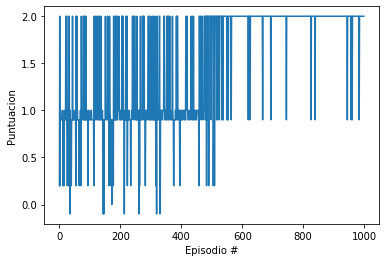

In [16]:
bigger_agent_rms = Agent(state_size=115, action_size=21, seed=0, network=BiggerNet, optim_fn='rmsprop')

scores = dqn(bigger_agent_rms, env, n_episodes=1000)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Puntuacion')
plt.xlabel('Episodio #')
plt.show()

Finalmente tenemos todos nuestros resultados de entrenamiento durante 1000 pasos de tiempo:
    
| Red           | Optimización  | Train Score  |
| ------------- |:-------------:| ------------:|
| Basic         | Adam          | 1.98         |
| Smaller       | Adam          | 1.50         |
| Bigger        | Adam          | 1.98         |
| Basic         | RMSProp       | 1.87         |
| Smaller       | RMSProp       | 1.15         |
| Bigger        | RMSProp       | 1.93         |


Dada que la performance de la red Básica y Bigger son iguales entrenando con RMSProp, reportaremos la performance durante 50 episodios del agente básico por cuestiones de costo de inferencia.


## Performance del mejor agente entrenado

I0816 15:56:44.326310 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:44.327456 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:44.328147 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 92.5, gameFPS: 340.2
I0816 15:56:44.454864 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:44.455918 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:44.456609 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 94.9, gameFPS: 349.1
I0816 15:56:44.583153 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:44.584323 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:44.585504 1

Episodio 3	Puntuacion media (ultimos 50):2.00

I0816 15:56:44.711634 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:44.712909 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:44.713581 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 95.3, gameFPS: 352.8
I0816 15:56:44.850112 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:44.851293 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:44.851965 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 88.0, gameFPS: 347.7


Episodio 5	Puntuacion media (ultimos 50):2.00

I0816 15:56:44.980943 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:44.982089 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:44.987479 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 93.2, gameFPS: 329.9
I0816 15:56:45.119401 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:45.120562 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:45.121398 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 91.2, gameFPS: 347.1
I0816 15:56:45.246227 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:45.247241 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:45.247901 1

Episodio 8	Puntuacion media (ultimos 50):2.00

I0816 15:56:45.407389 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:45.409417 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:45.410590 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 75.8, gameFPS: 254.4
I0816 15:56:45.608157 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:45.609261 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:45.609915 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.1, gameFPS: 273.3


Episodio 10	Puntuacion media (ultimos 50):2.00

I0816 15:56:45.773751 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:45.774722 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:45.775700 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 74.4, gameFPS: 255.9
I0816 15:56:45.923739 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:45.924880 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:45.929855 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 81.2, gameFPS: 311.7


Episodio 12	Puntuacion media (ultimos 50):2.00

I0816 15:56:46.111095 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:46.112385 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:46.115014 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.7, gameFPS: 224.6
I0816 15:56:46.400841 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:46.402776 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:46.409261 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 42.2, gameFPS: 150.4


Episodio 14	Puntuacion media (ultimos 50):2.00

I0816 15:56:46.593558 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:46.594593 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:46.595249 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 65.5, gameFPS: 335.0
I0816 15:56:46.724518 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:46.725645 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:46.726257 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 92.9, gameFPS: 348.3
I0816 15:56:46.869349 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:46.870415 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:46.871044 1

Episodio 17	Puntuacion media (ultimos 50):2.00

I0816 15:56:47.027487 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:47.028657 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:47.029306 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 76.8, gameFPS: 351.3
I0816 15:56:47.155545 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:47.156718 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:47.157364 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 95.1, gameFPS: 345.7
I0816 15:56:47.300029 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:47.301375 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:47.304280 1

Episodio 19	Puntuacion media (ultimos 50):2.00

I0816 15:56:47.531165 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:47.534961 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:47.536353 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 52.6, gameFPS: 187.5


Episodio 21	Puntuacion media (ultimos 50):2.00

I0816 15:56:47.716151 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:47.717143 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:47.717785 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.0, gameFPS: 346.1
I0816 15:56:47.843070 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:47.844484 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:47.845545 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 95.6, gameFPS: 351.1


Episodio 23	Puntuacion media (ultimos 50):2.00

I0816 15:56:48.038501 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:48.040137 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:48.041610 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 62.2, gameFPS: 177.4
I0816 15:56:48.247137 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:48.248394 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:48.249408 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.0, gameFPS: 219.5


Episodio 25	Puntuacion media (ultimos 50):2.00

I0816 15:56:48.399725 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:48.400754 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:48.401448 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 80.3, gameFPS: 293.4
I0816 15:56:48.534126 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:48.535146 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:48.535976 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 90.7, gameFPS: 324.0


Episodio 27	Puntuacion media (ultimos 50):2.00

I0816 15:56:48.763285 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:48.764552 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:48.765405 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 53.0, gameFPS: 174.5
I0816 15:56:48.946823 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:48.948450 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:48.951330 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 67.5, gameFPS: 279.0


Episodio 29	Puntuacion media (ultimos 50):2.00

I0816 15:56:49.096748 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:49.097761 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:49.098484 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 82.9, gameFPS: 325.3
I0816 15:56:49.300221 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:49.301791 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:49.305963 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.9, gameFPS: 190.3


Episodio 31	Puntuacion media (ultimos 50):2.00

I0816 15:56:49.507575 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:49.510667 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:49.511532 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 59.3, gameFPS: 265.7
I0816 15:56:49.638478 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:49.639639 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:49.640303 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 94.8, gameFPS: 344.5


Episodio 33	Puntuacion media (ultimos 50):2.00

I0816 15:56:49.794228 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:49.795585 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:49.798835 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 78.7, gameFPS: 248.7
I0816 15:56:49.994105 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:49.995077 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:49.995687 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 64.1, gameFPS: 273.2


Episodio 35	Puntuacion media (ultimos 50):2.00

I0816 15:56:50.152696 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:50.153693 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:50.154319 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 77.1, gameFPS: 262.8
I0816 15:56:50.364767 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:50.365968 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:50.368459 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 57.3, gameFPS: 236.1


Episodio 37	Puntuacion media (ultimos 50):2.00

I0816 15:56:50.514667 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:50.516101 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:50.517295 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 82.4, gameFPS: 310.2
I0816 15:56:50.698789 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:50.699893 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:50.700691 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 66.3, gameFPS: 262.4


Episodio 39	Puntuacion media (ultimos 50):2.00

I0816 15:56:50.864990 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:50.865947 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:50.866530 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 73.2, gameFPS: 313.2
I0816 15:56:51.065490 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:51.066476 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:51.067174 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 60.4, gameFPS: 178.0


Episodio 41	Puntuacion media (ultimos 50):2.00

I0816 15:56:51.260635 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:51.261778 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:51.266773 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 63.6, gameFPS: 245.4
I0816 15:56:51.506242 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:51.507877 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:51.508825 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 50.5, gameFPS: 192.6


Episodio 43	Puntuacion media (ultimos 50):2.00

I0816 15:56:51.659136 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:51.660566 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:51.661701 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 80.1, gameFPS: 311.2
I0816 15:56:51.802335 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:51.803256 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:51.804241 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 85.7, gameFPS: 321.6
I0816 15:56:51.927844 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:51.928871 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:51.929567 1

Episodio 46	Puntuacion media (ultimos 50):2.00

I0816 15:56:52.061031 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:52.062152 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:52.063130 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 91.4, gameFPS: 320.4
I0816 15:56:52.184649 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:52.185799 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:52.186537 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 99.0, gameFPS: 361.9
I0816 15:56:52.309199 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:52.310291 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:52.310831 1

Episodio 49	Puntuacion media (ultimos 50):2.00

I0816 15:56:52.504790 139969143023424 observation_processor.py:362] Dump "score": count limit reached / disabled
I0816 15:56:52.506261 139969143023424 observation_processor.py:362] Dump "episode_done": count limit reached / disabled
I0816 15:56:52.507637 139969143023424 football_env_wrapper.py:85] Episode reward: 1.00 score: [1, 0], steps: 12, FPS: 61.8, gameFPS: 193.6


Episodio 50	Puntuacion media (50 anteriores): 2.00


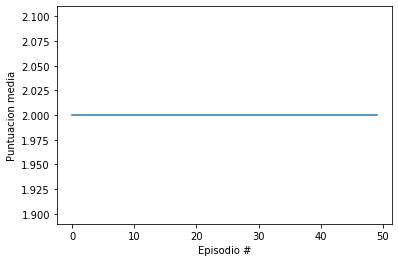

In [17]:
N_EPS = 50

scores = []                             # puntuaciones de cada episodio
scores_window = deque(maxlen=50)        # puntuaciones de los ultimos 100 episodios
for i_episode in range(1, N_EPS+1):
    state = env.reset()
    score = 0
    done = False # Por qué esto? Porque confío en él
    while not done:

        # elegir accion At con politica e-greedy
        action = basic_agent_adam.act(state, 0.0)

        # aplicar At y obtener Rt+1, St+1
        next_state, reward, done, _ = env.step(action)

        # avanzar estado
        state = next_state
        score += reward
    
    scores_window.append(score)       # guardar ultima puntuacion
    scores.append(score)              # guardar ultima puntuacion

    print('\rEpisodio {}\tPuntuacion media (ultimos {:d}):{:.2f}'.format(i_episode, 50, np.mean(scores_window)), end="")
    if i_episode % 50 == 0:
        print('\rEpisodio {}\tPuntuacion media ({:d} anteriores): {:.2f}'.format(i_episode, 50, np.mean(scores_window)))
    if np.mean(scores_window)>=195.0:
        # Por qué 2? 
        print('\nProblema resuelto en {:d} episodios!\tPuntuacion media (ultimos {:d}): {:.2f}'.format(i_episode-max_len, 50, np.mean(scores_window)))
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint-football.pth') # guardar pesos de agente entrenado
        break

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Puntuacion media')
plt.xlabel('Episodio #')
plt.show()